In [ ]:
!pip install pydriller

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
!pwd

/content


In [ ]:
!git clone https://github.com/VCHARVY/embedchain

Cloning into 'embedchain'...
remote: Enumerating objects: 7461, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 7461 (delta 66), reused 123 (delta 38), pack-reused 7278
Receiving objects: 100% (7461/7461), 14.41 MiB | 28.16 MiB/s, done.
Resolving deltas: 100% (4971/4971), done.


In [ ]:
%cd embedchain

/content/embedchain


In [ ]:
!pip install nltk

KNOWLEDGE GRAPH FOR README LINES

In [ ]:
#Readme files update

import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
from pydriller import Repository
nlp_model = spacy.load('en_core_web_sm')
def getSentences(text):
    nlp = English()
    nlp.add_pipe('sentencizer')
    document = nlp(text)
    return [sentence.text.strip() for sentence in document.sents]


def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    c=0
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)

        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if ("compound" in token.dep_) and ("subj" in tokens[c+1].dep_ ):
                subject = appendChunk(token.text, subject)

        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''
        if ("compound" in token.dep_) and ("obj" in tokens[c+1].dep_ ):
                object = appendChunk(token.text, object)
        c=c+1

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

import os
from pydriller import Repository

def find_readme_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower() == 'readme.md':
                return os.path.join(root, file)
    return None

def retrieve_readme_and_commits(repo_path):
    readme_content = None
    commit_messages = []

    # Find the README file recursively within the repository directory
    readme_path = find_readme_file(repo_path)
    if readme_path:
        with open(readme_path, 'r') as file:
            readme_content = file.read()

    return readme_content

def create_readme_dict(readme_content):
    sentences=getSentences(readme_content)
    print(sentences)
    readme_dict = {}
    count=1
    for sentence in sentences:
            triples = []
            triples=list(processSentence(sentence))
            readme_dict[triples[0]+triples[1]+triples[2]]=count
            count=count+1
            print("triples length is:",triples[0]+triples[1]+triples[2])
            #printGraph(triples)
    return readme_dict#dictionary of readme lines with line number


def printGraph(triples):
    G = nx.Graph()
    #for i, triple in enumerate(triples):
    G.add_node(triples[0])
    G.add_node(triples[1])
    print(triples[2])
    G.add_node(triples[2])
    G.add_edge(triples[0], triples[1], label="entity 1")
    G.add_edge(triples[1], triples[2], label="entity 2")

    components = nx.connected_components(G)
    print(components)
    for i in components:
      print(i)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(50, 20))
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})

    edge_labels = {(edge[0], edge[1]): attr['label'] for edge, attr in G.edges.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.axis('off')
    plt.show()

#
if __name__ == "__main__":


    # Specify the path to the cloned repository
    repo_path = '/content/embedchain'

# Retrieve the README file content and commit messages
    readme_content = retrieve_readme_and_commits(repo_path)
    readme_dict=create_readme_dict(readme_content)
    print(len(readme_dict))







    #useless
    #print (readme_content)
   # for sentence in sentences:
    #    triples.append(processSentence(sentence))
   # printGraph(triples)
   # for sentence in sentences_commit:
    #    triples2.append(processSentence(sentence))
   # printGraph(triples2)
 # Iterate over all commits in the repository
    #for commit in Repository(repo_path).traverse_commits():
        # Retrieve the commit message
       # commit_messages.append(commit.msg)
       #return readme_content, commit_messages
       # Print the README file content

   # if readme_content:
      #print("README File Content:")
      #print(readme_content)
   # else:
      #print("README file not found.")
   # readme_commits = get_commits_related_to_readme(repo_path)
   #def get_commits_related_to_readme(repo_path):
   # readme_commits = []

    # Iterate over all commits in the repository
    #for commit in Repository(repo_path).traverse_commits():
        # Check if the commit modifies the README file
       # for modified_file in commit.modified_files:
           # if modified_file.filename.lower() == 'readme.md':
                # Extract relevant information from the commit
                #commit_info = {
                  #  'title': commit.msg,
                   # 'patch': modified_file.diff,
                    #'commit_id': commit.hash,
                    #'author': commit.author.name,
                    #'date': commit.author_date,
                    #'email': commit.author.email
               # }
               # readme_commits.append(commit_info)

   # return readme_commits


['<p align="center">\n  <img src="docs/logo/dark.svg" width="400px" alt="Embedchain Logo">\n</p>\n\n<p align="center">\n  <a href="https://pypi.org/project/embedchain/">\n    <img src="https://img.shields.io/pypi/v/embedchain" alt="PyPI">\n  </a>\n  <a href="https://pepy.tech/project/embedchain">\n    <img src="https://static.pepy.tech/badge/embedchain" alt="Downloads">\n  </a>\n  <a href="https://embedchain.ai/slack">\n    <img src="https://img.shields.io/badge/slack-embedchain-brightgreen.svg?logo=slack" alt="Slack">\n  </a>\n  <a href="https://embedchain.ai/discord">\n    <img src="https://dcbadge.vercel.app/api/server/6PzXDgEjG5?style=flat" alt="Discord">\n  </a>\n  <a href="https://twitter.com/embedchain">\n    <img src="https://img.shields.io/twitter/follow/embedchain" alt="Twitter">\n  </a>\n  <a href="https://colab.research.google.com/drive/138lMWhENGeEu7Q1-6lNbNTHGLZXBBz_B?usp=sharing">\n    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab

README COMMITS KNOWLEDGE GRAPH(THIS MAPS THE README COMMIT TO LINE NUMBER IN README FILE)

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b77d0>
{'', 'c5950034810c8fc47e9f8ac20dca098abca1a6ff', 'check pull', 'issues repository request', 20}


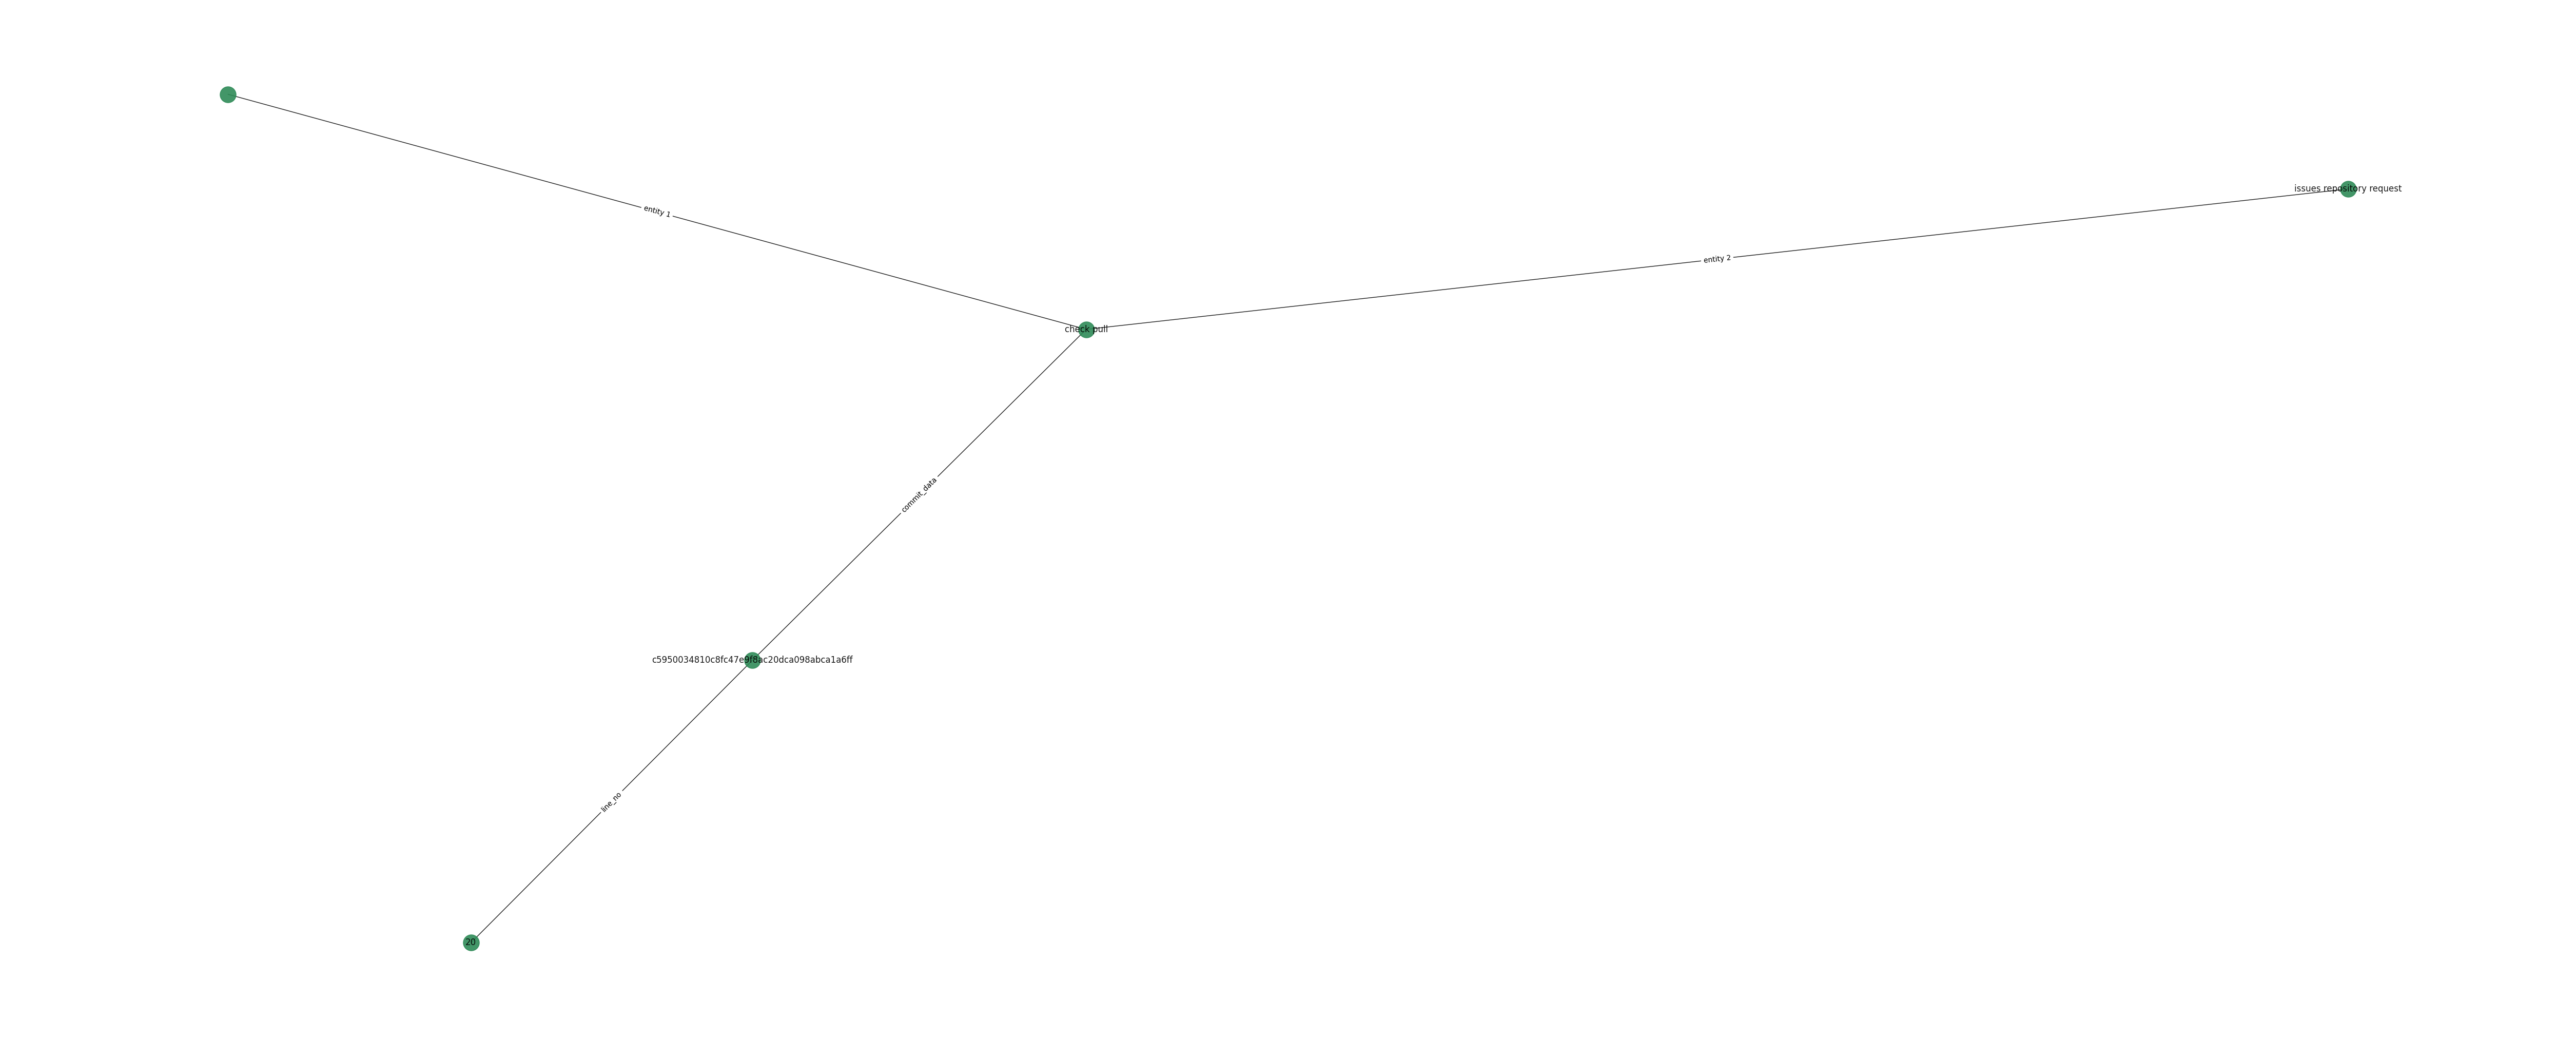

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3ae0>
{'', 'information contributing guidelines](CONTRIBUTING.md', 'c5950034810c8fc47e9f8ac20dca098abca1a6ff', 'more see', 21}


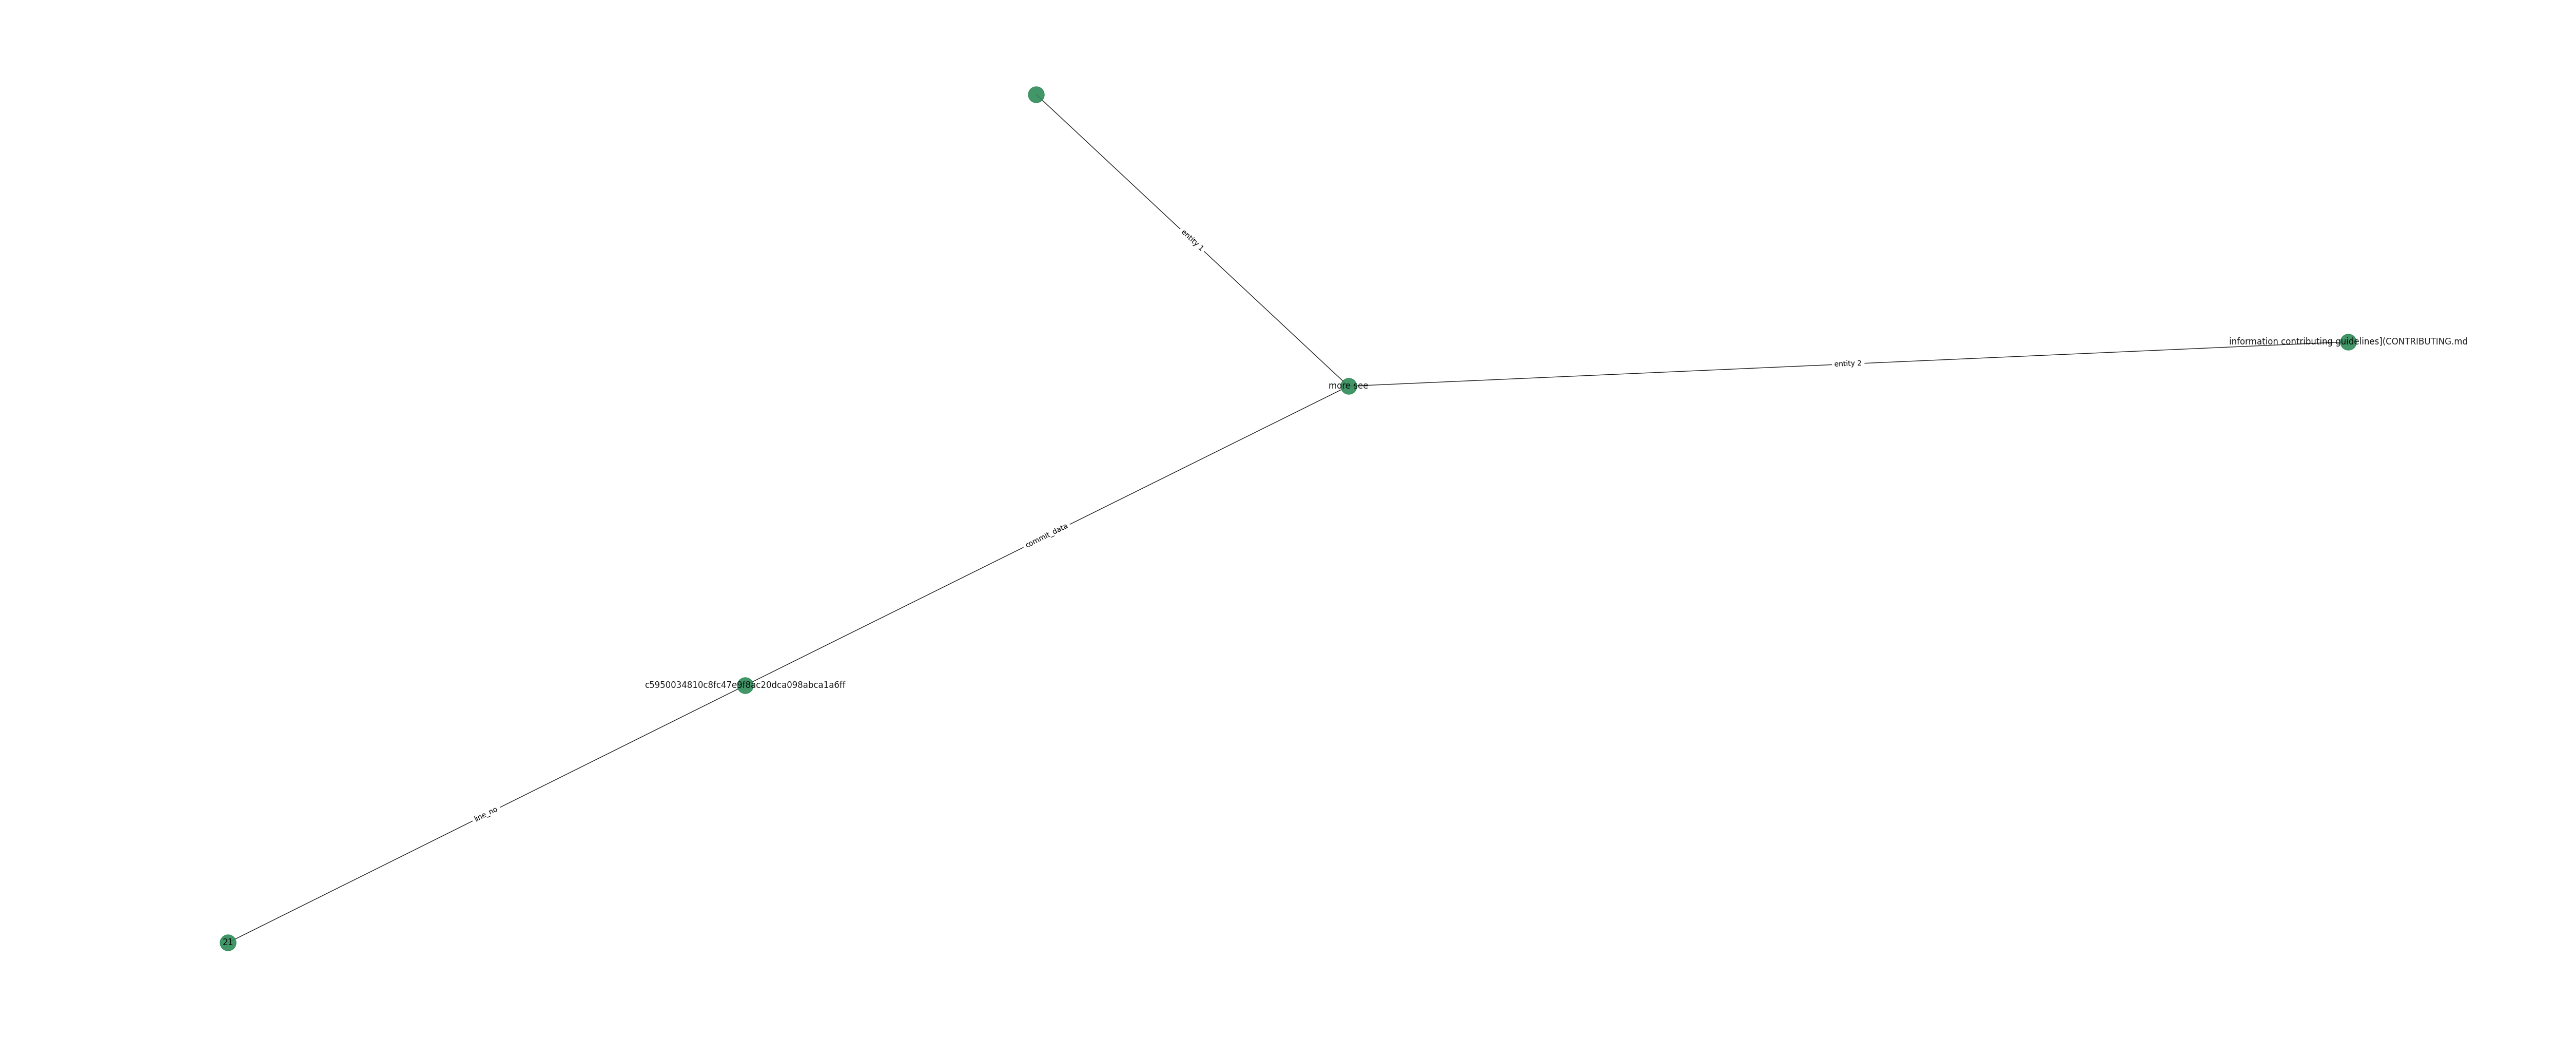

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7530>
{'', 'be', 'Contributions', 19, '7585bc557bc26ea946c0c71ac94ad889af3a491b'}


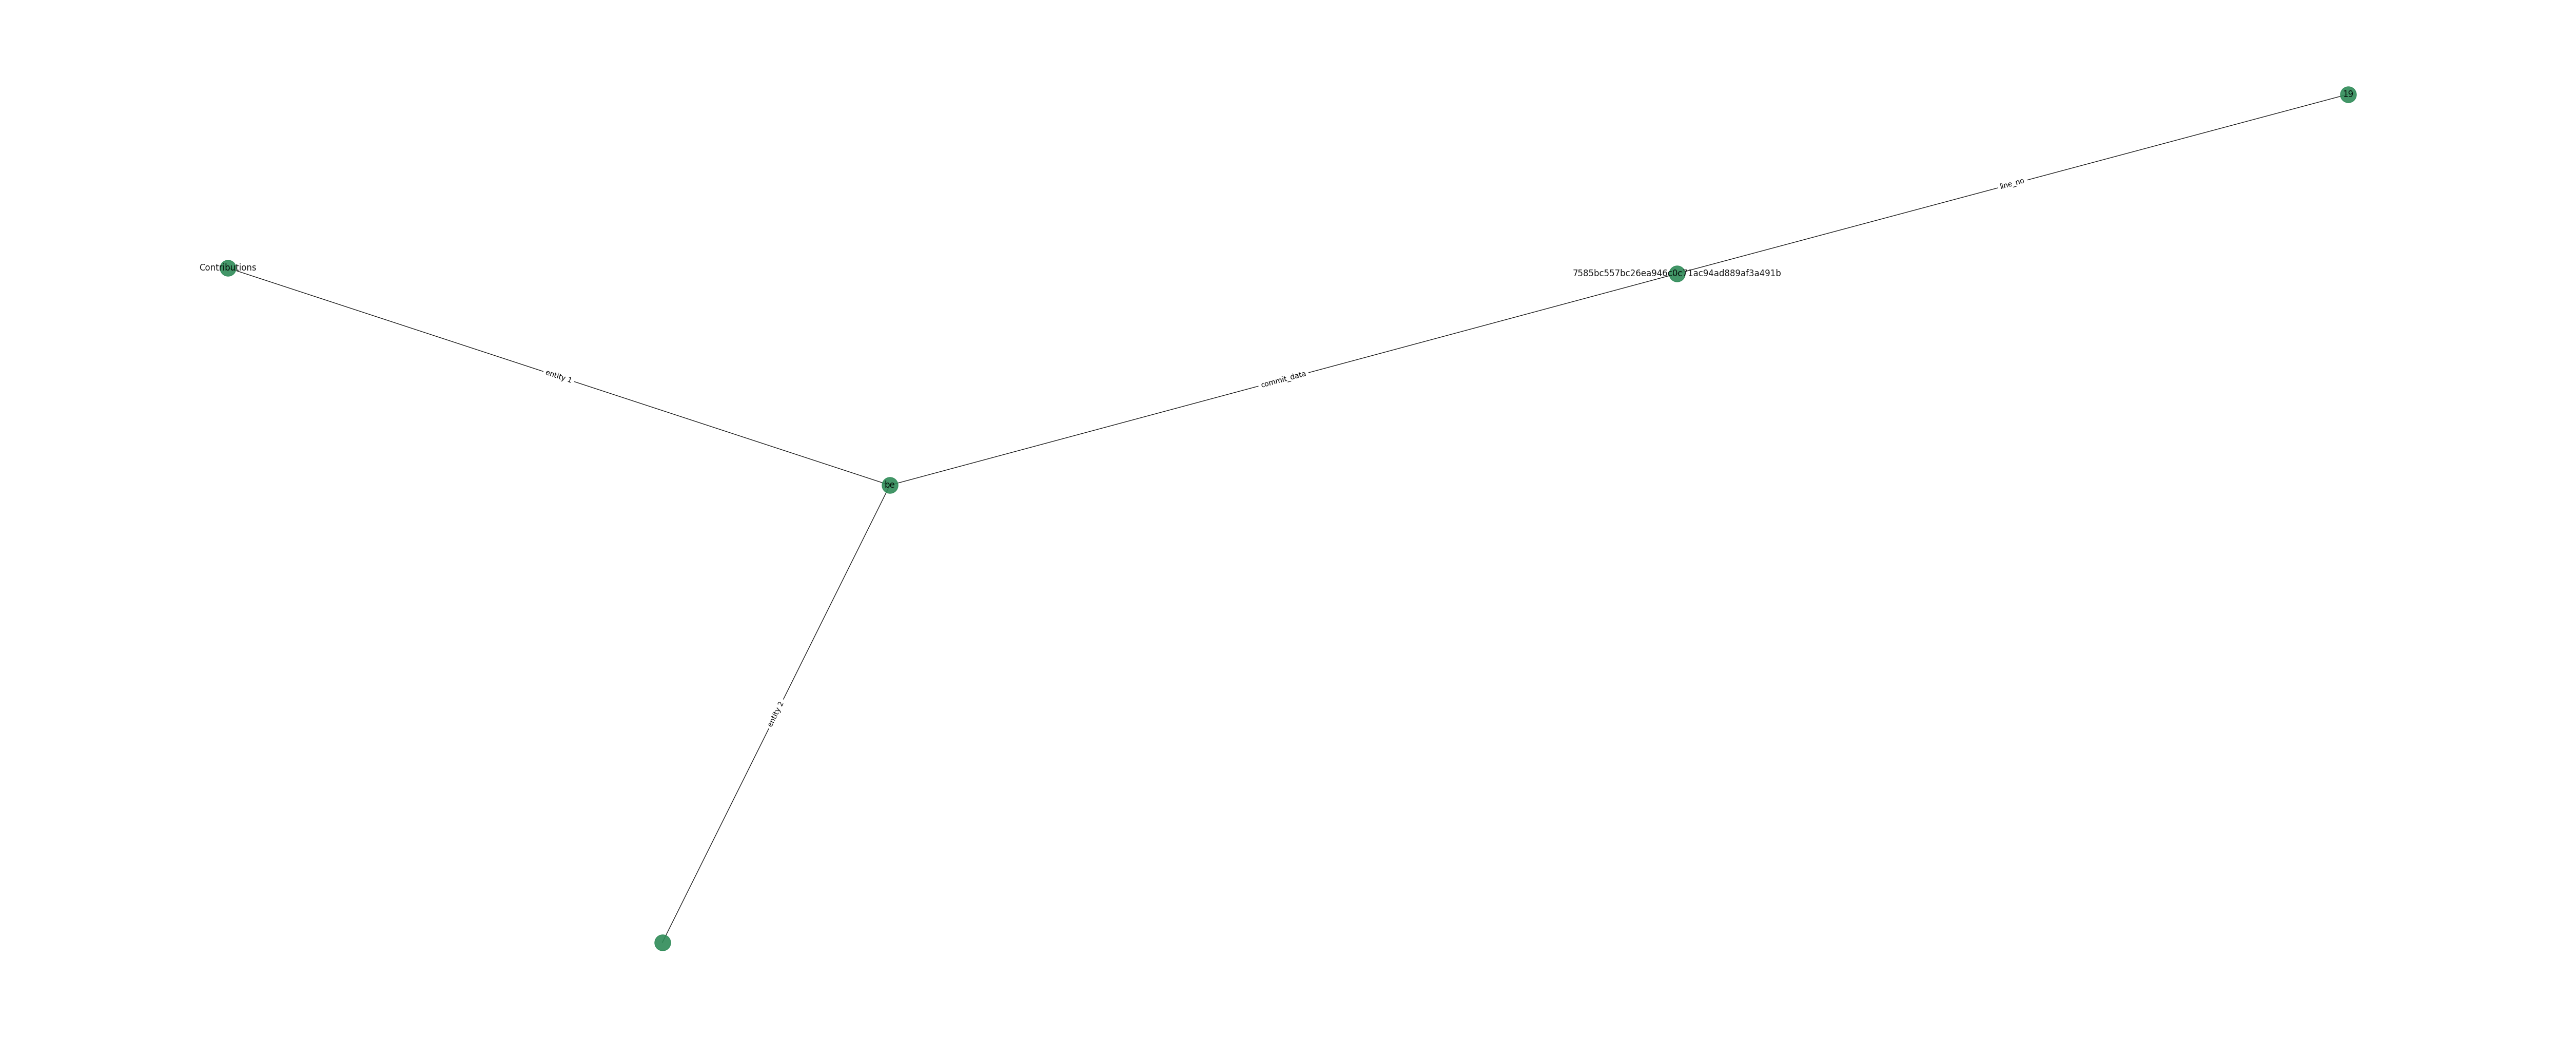

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7300>
{'', 'check pull', 'issues repository request', 20, '7585bc557bc26ea946c0c71ac94ad889af3a491b'}


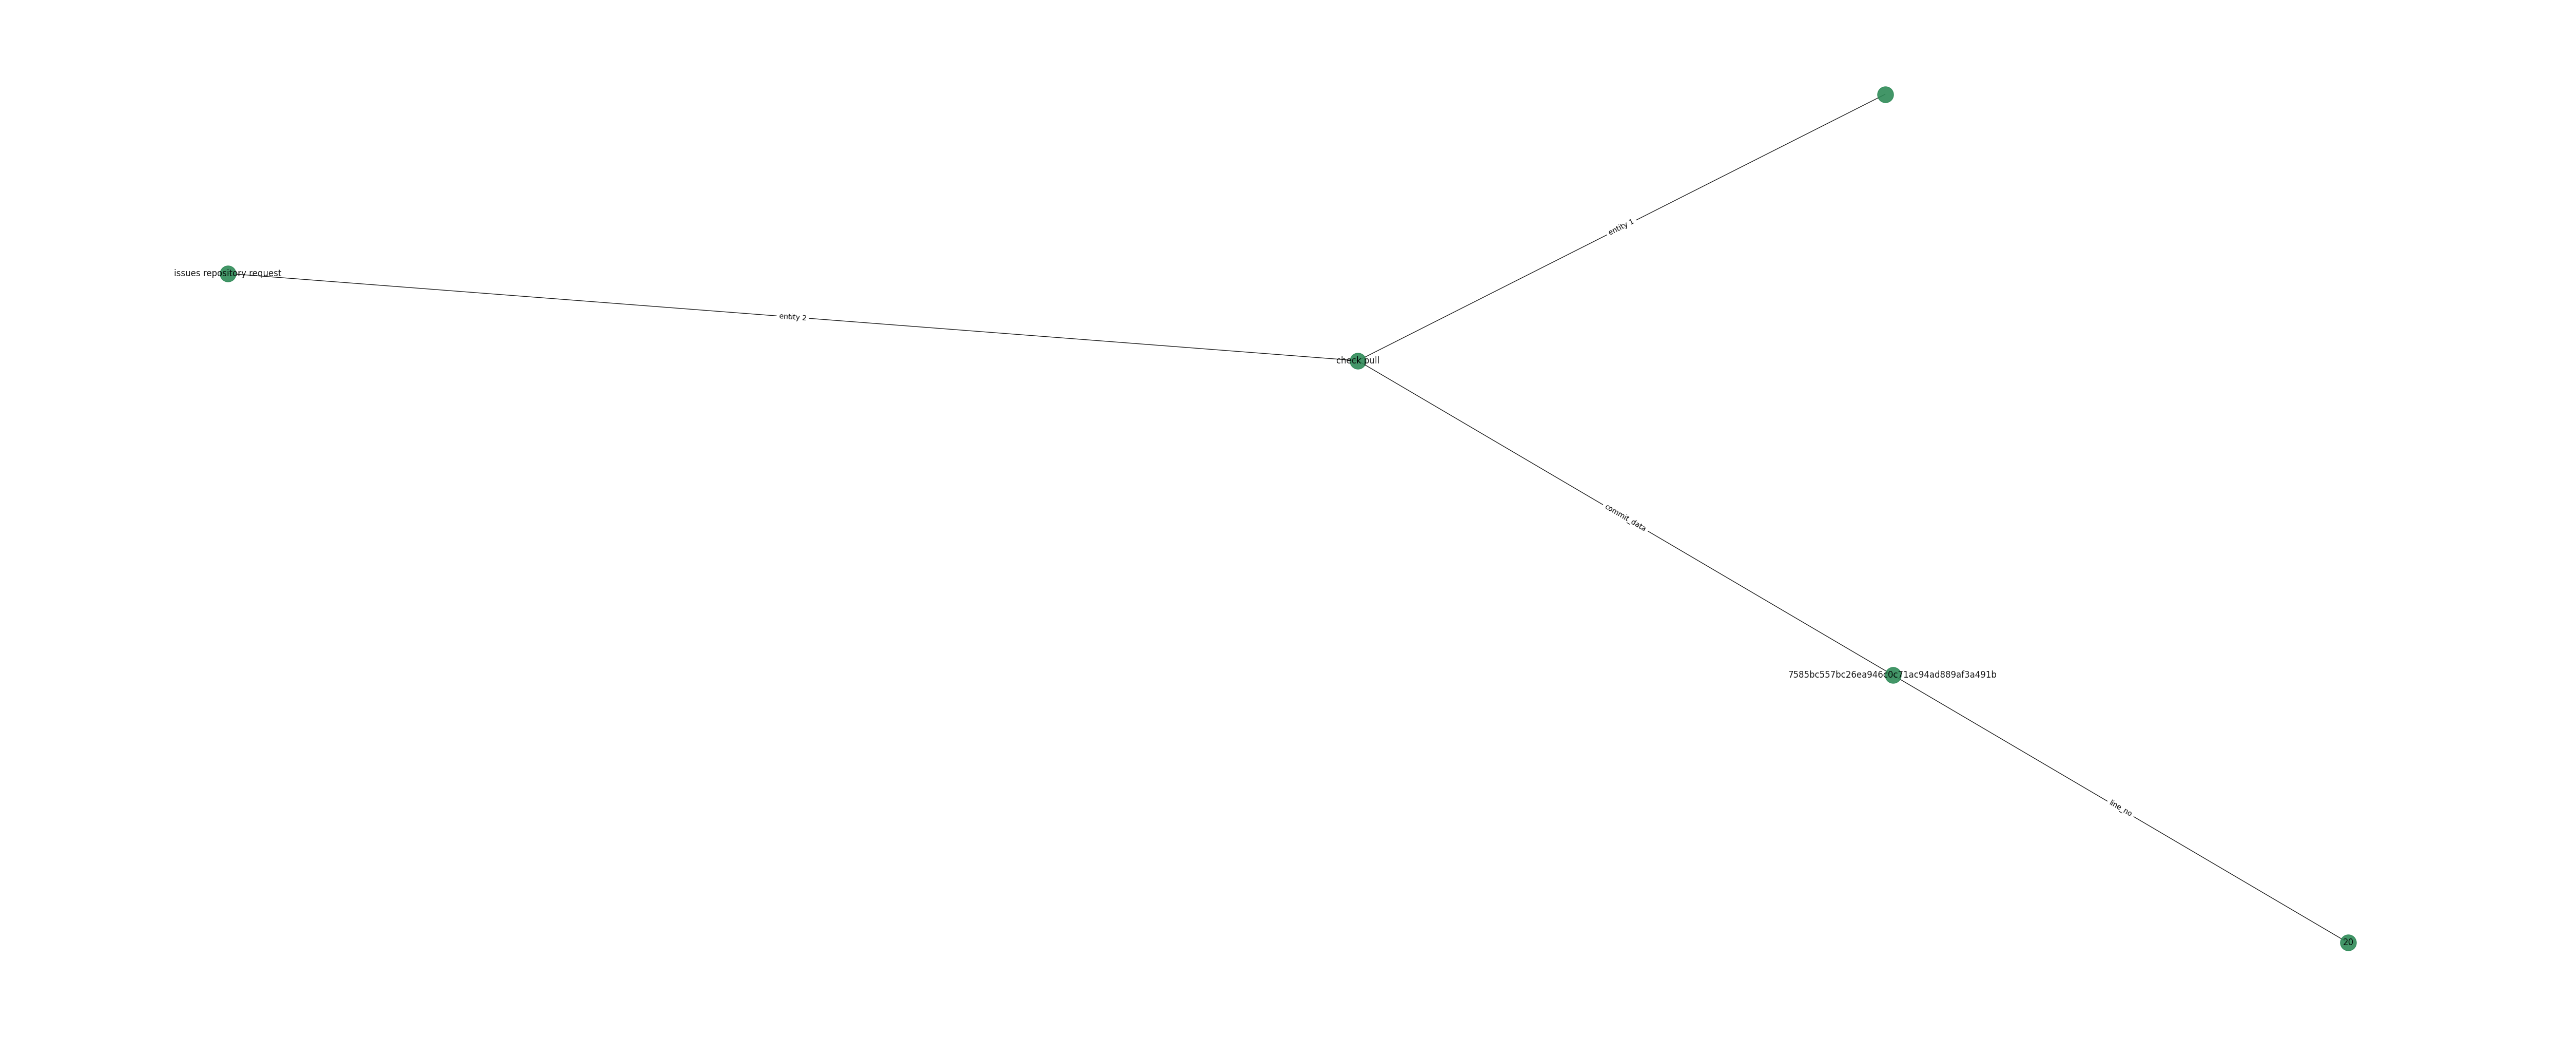

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b78b0>
{'', 'information contributing guidelines](CONTRIBUTING.md', 'more see', 21, '7585bc557bc26ea946c0c71ac94ad889af3a491b'}


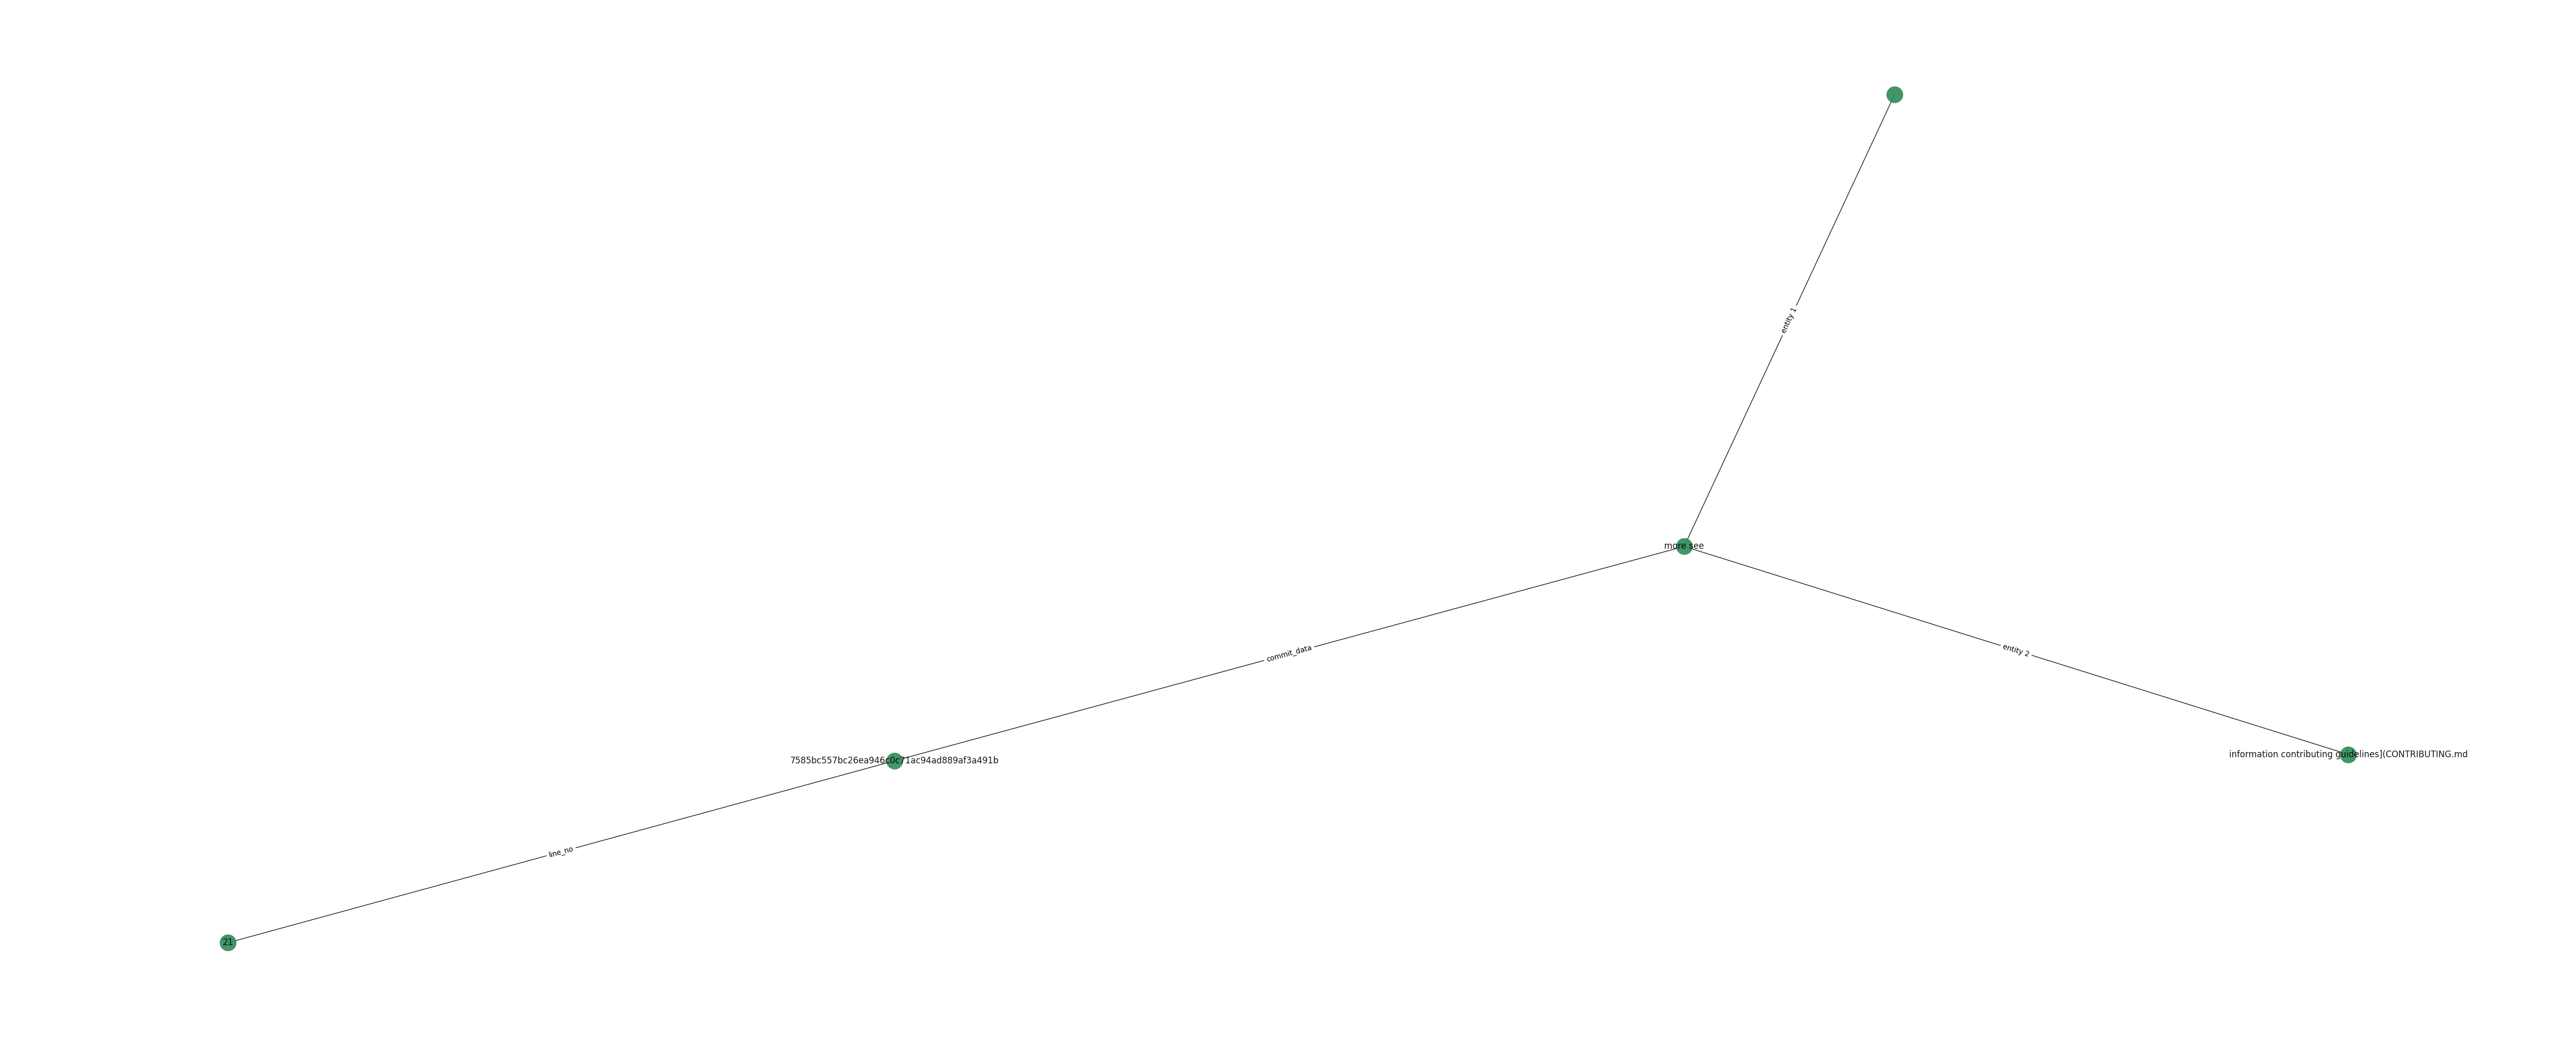

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b75a0>
{'', 'be', '9f1f17a611b2d957df36f853a83890f47ab461af', 'Contributions', 19}


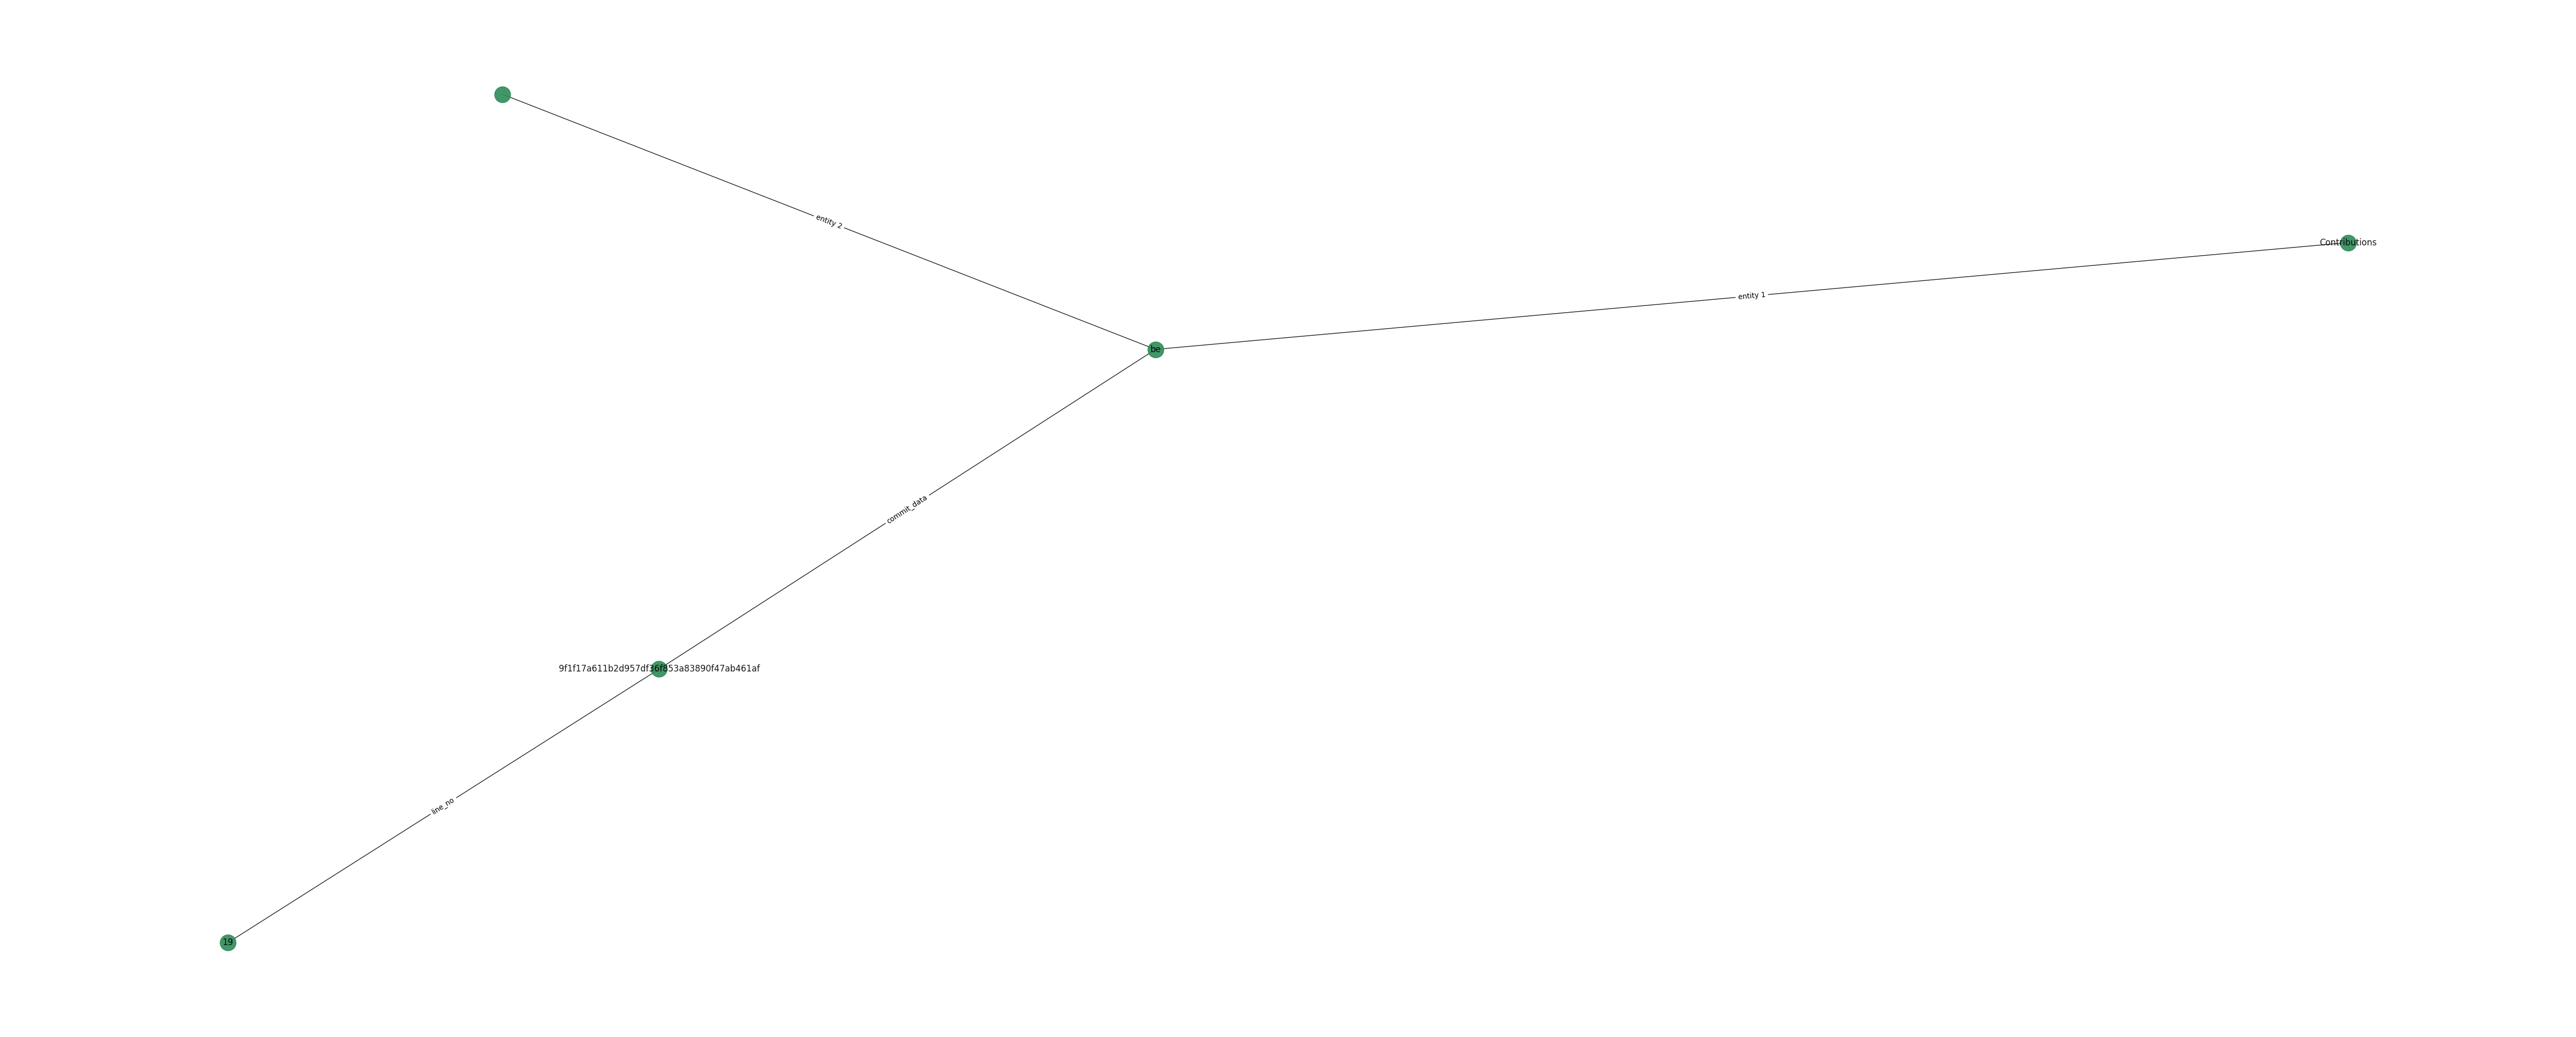

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b75a0>
{'', '9f1f17a611b2d957df36f853a83890f47ab461af', 'check pull', 20, 'issues repository request'}


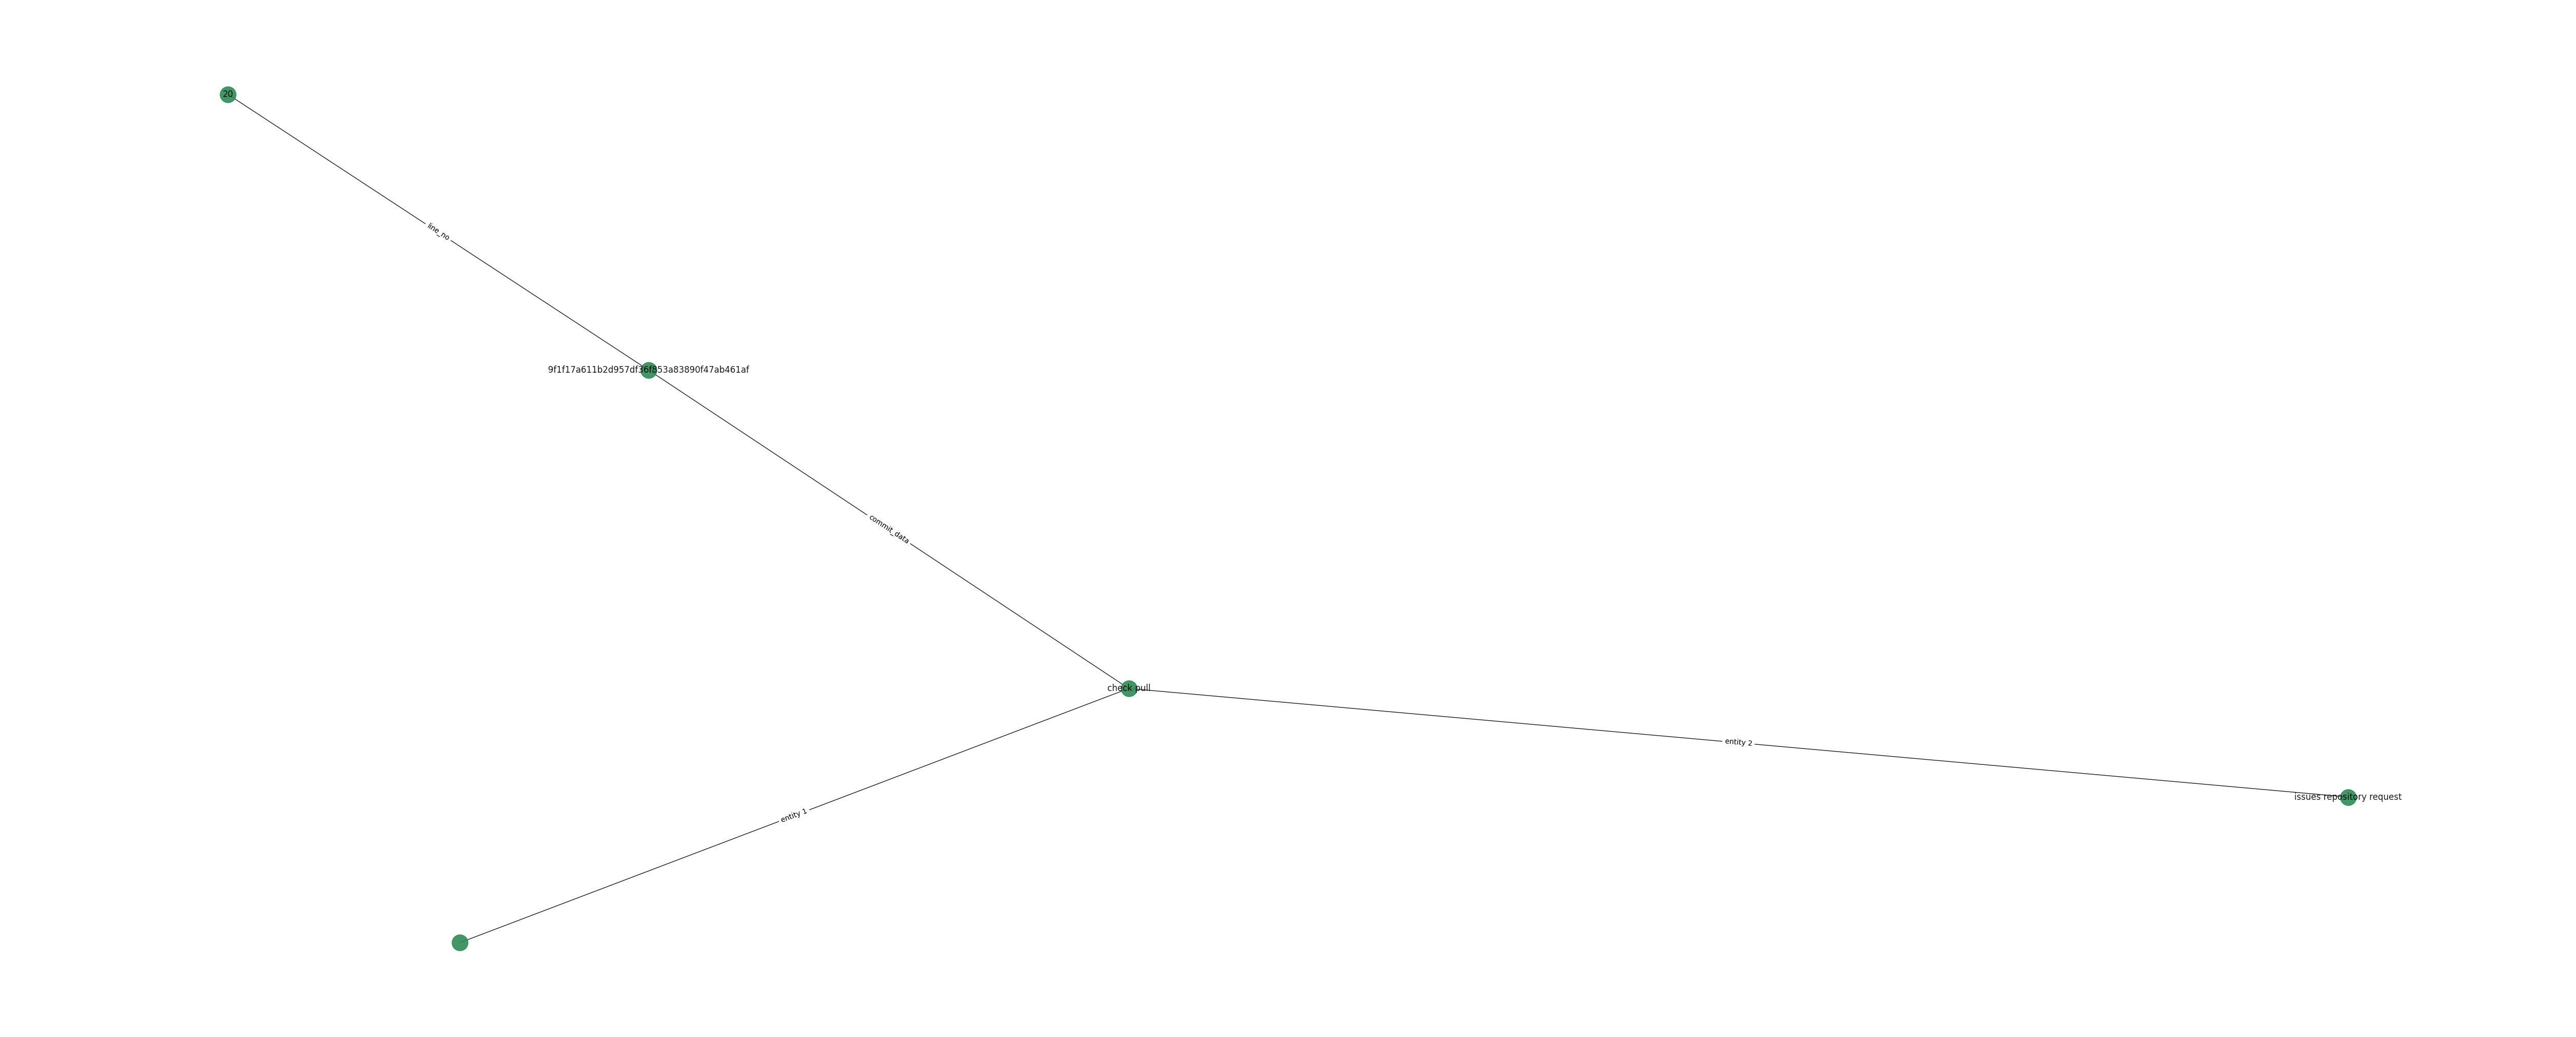

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7ae0>
{'', 'information contributing guidelines](CONTRIBUTING.md', '9f1f17a611b2d957df36f853a83890f47ab461af', 'more see', 21}


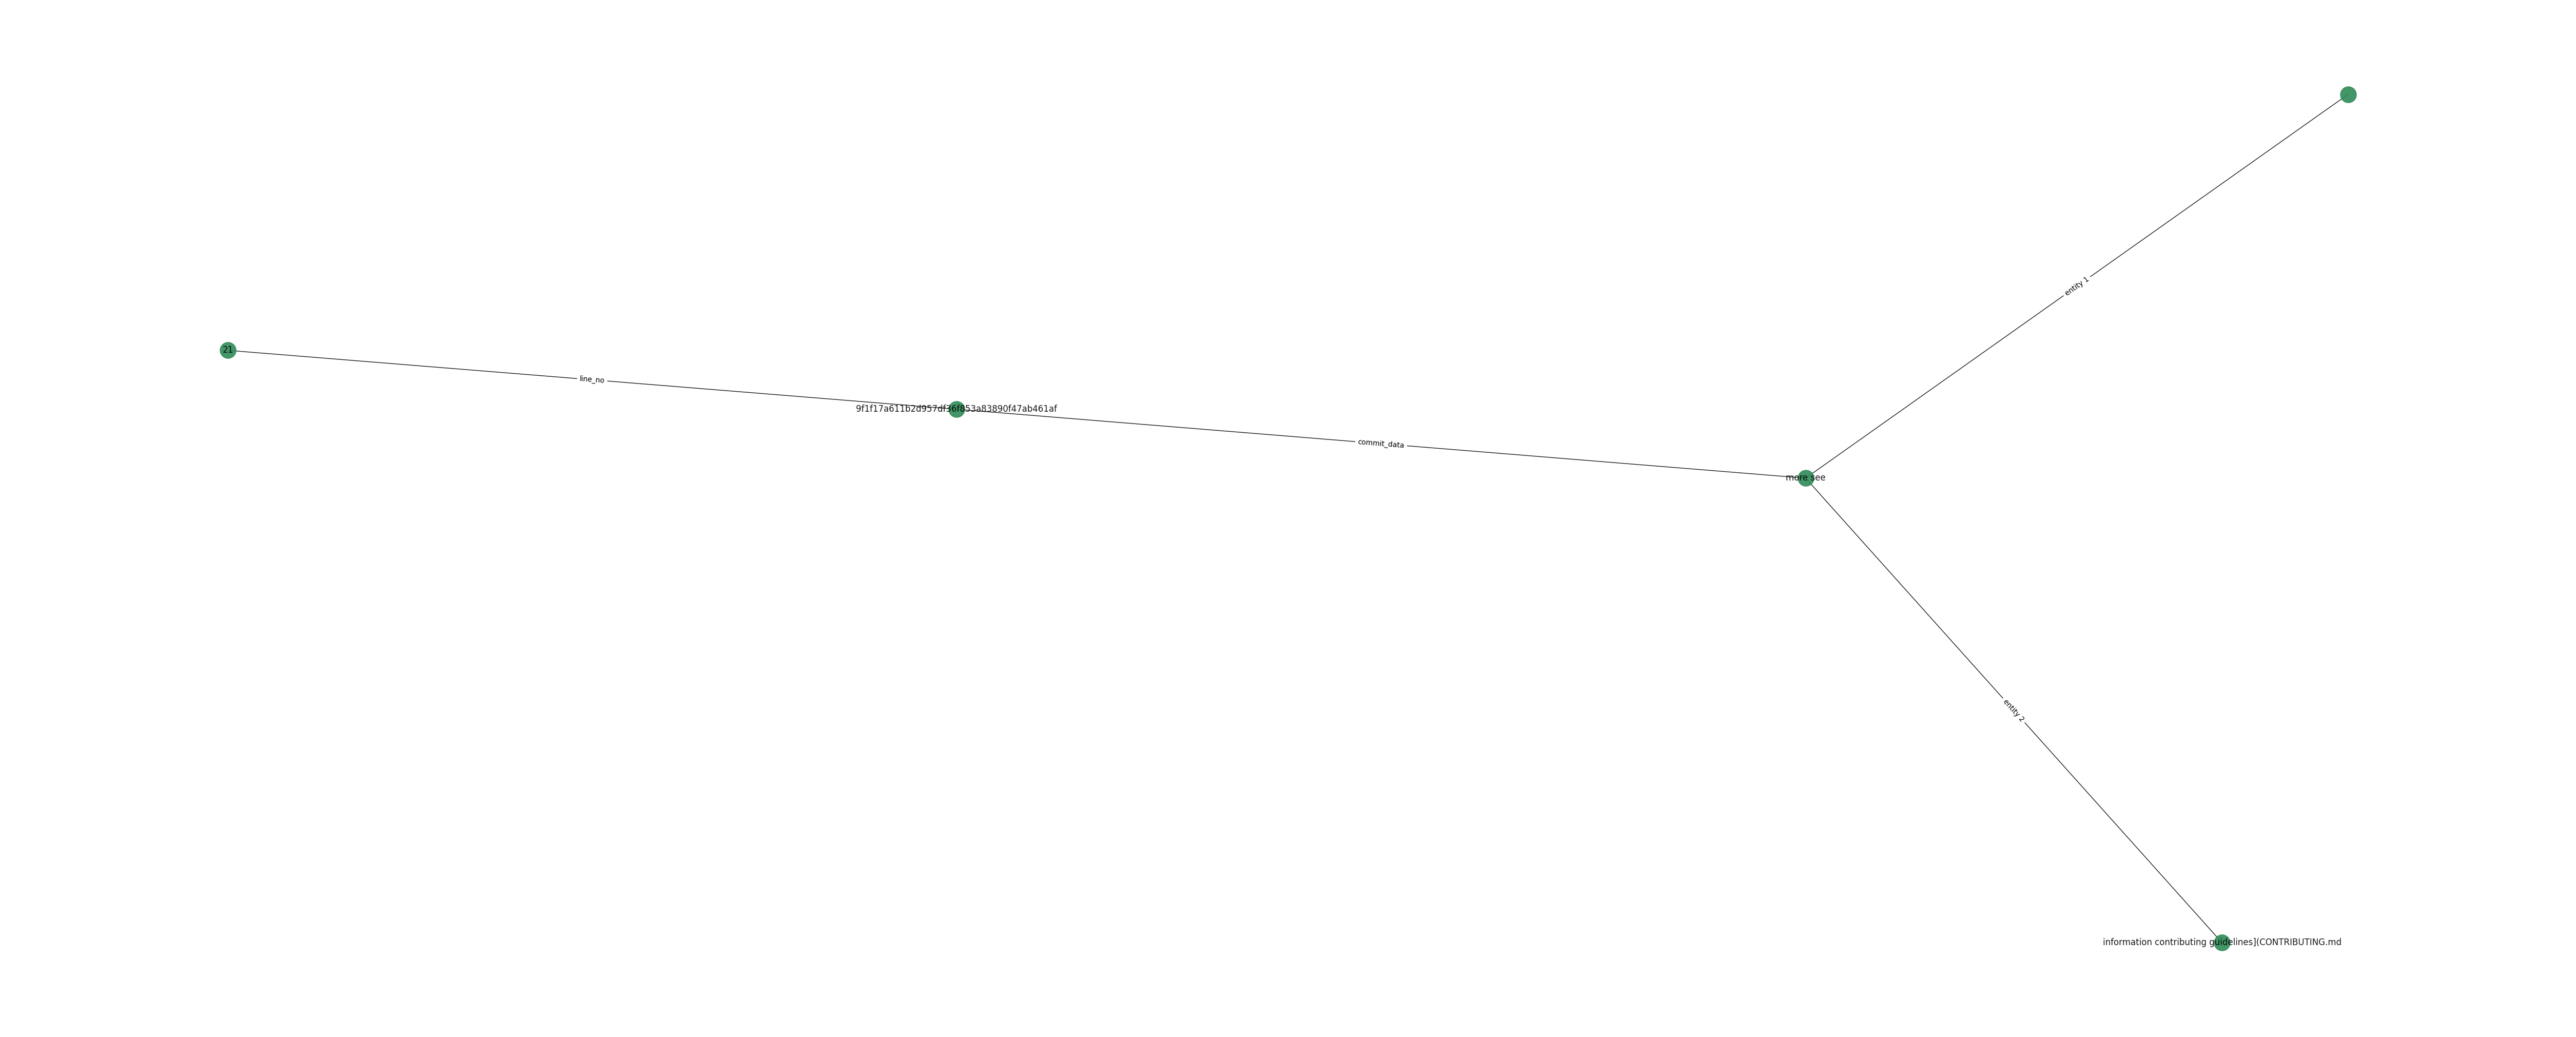

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7530>
{'', '9f1f17a611b2d957df36f853a83890f47ab461af', 'more go', 'reference dev', 22}


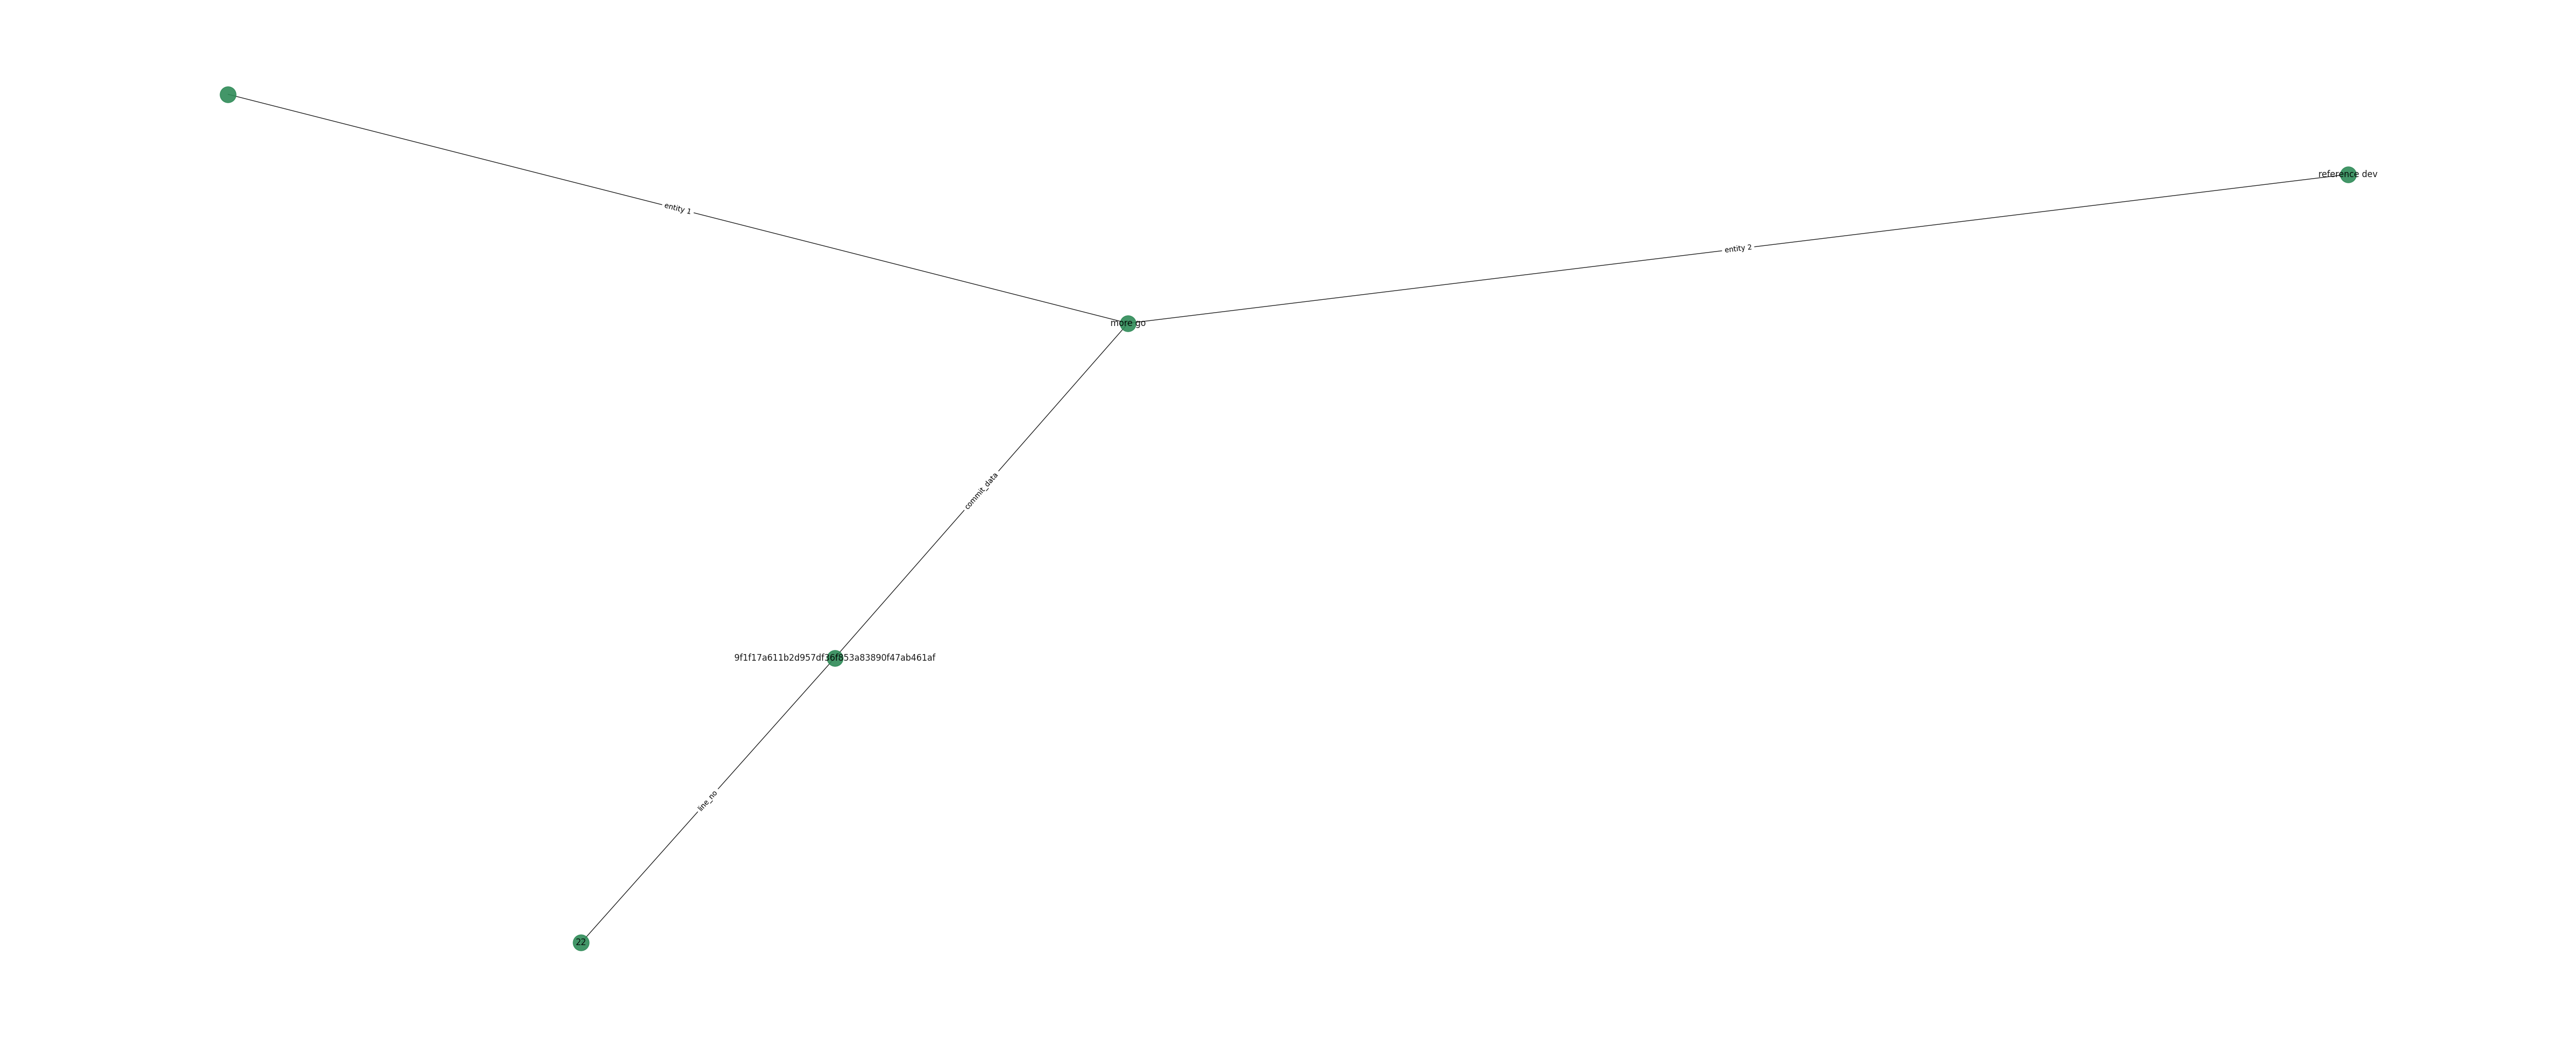

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3990>
{'', 'information contributing guidelines](CONTRIBUTING.md', 'c07fbc07b1c42a8fc6437e3509403b8a8c55b409', 'more see', 21}


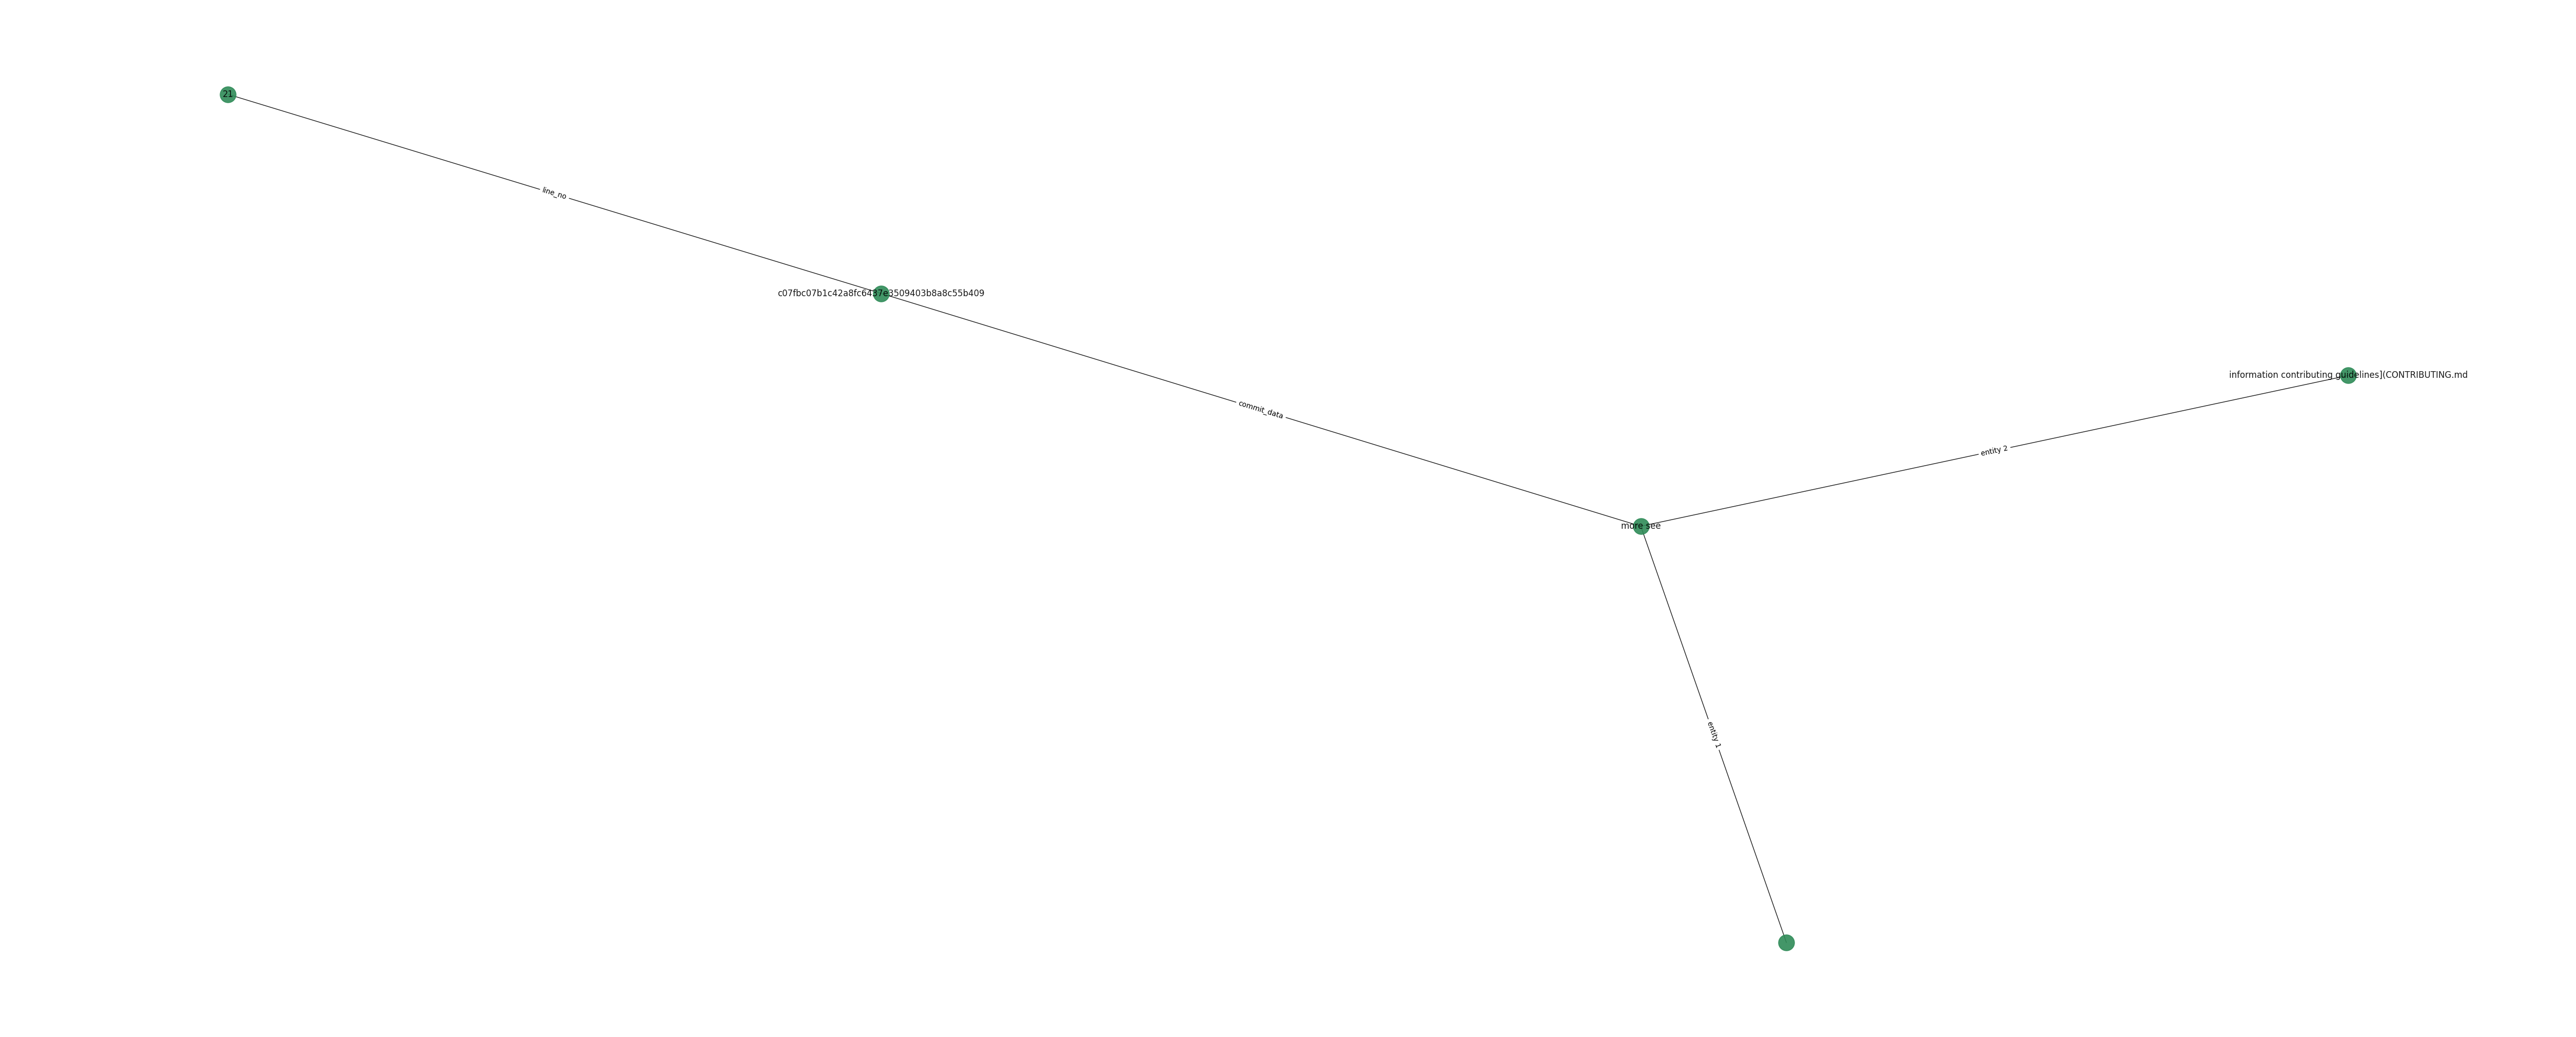

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3990>
{'', 'more go', 'c07fbc07b1c42a8fc6437e3509403b8a8c55b409', 'reference dev', 22}


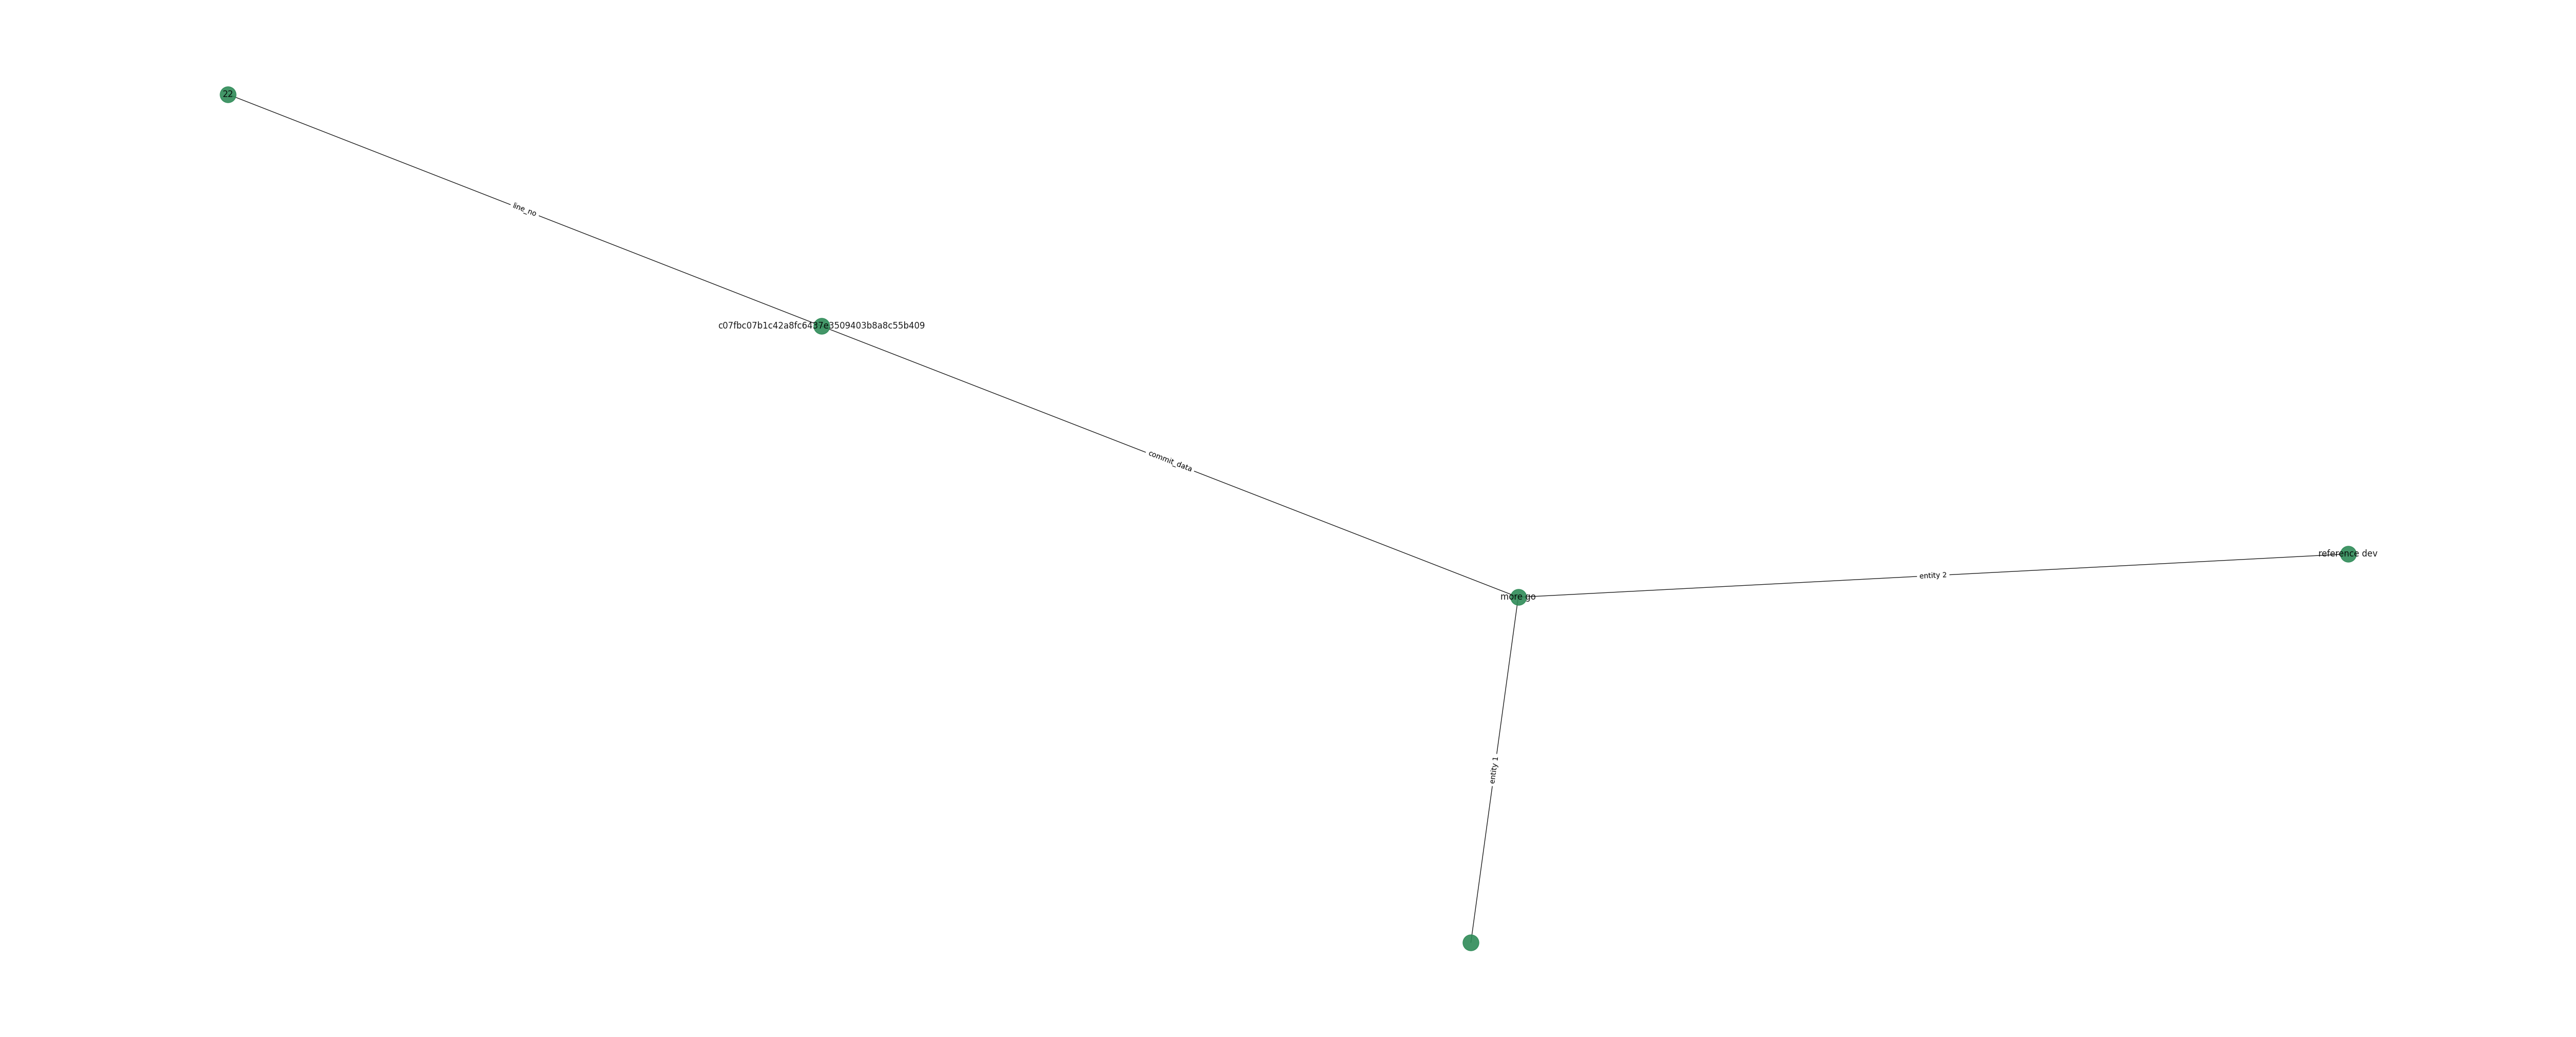

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a2420>
{'b1af82eba8f583b3644ff3d95a909d68354225b8', 12, 'Musk', 'answer several', 'companies'}


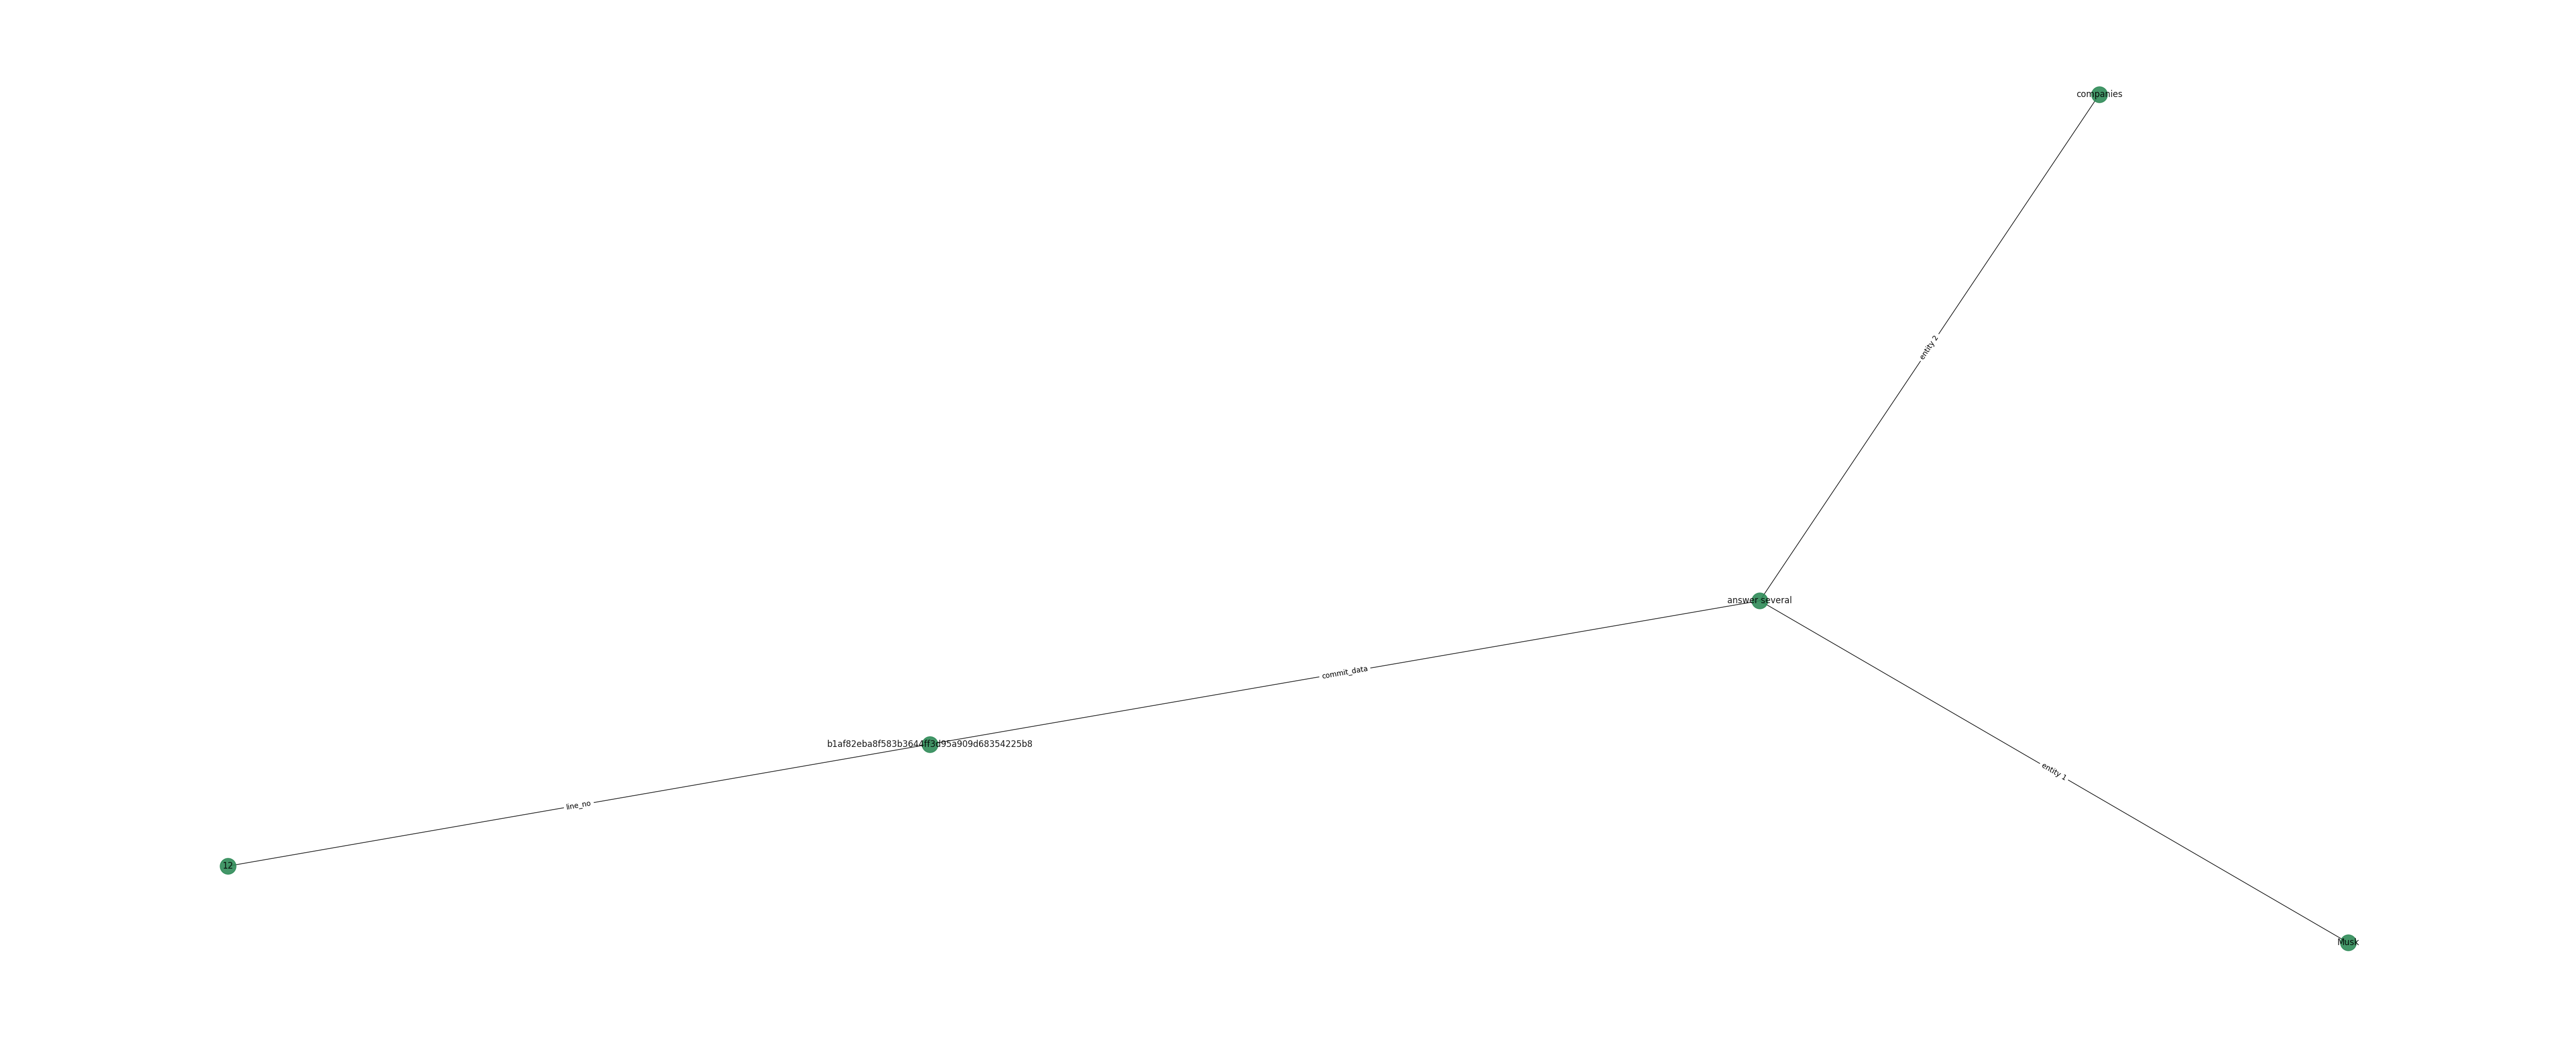

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a2420>
{'b1af82eba8f583b3644ff3d95a909d68354225b8', 13, 'he', 'knowledge SpaceX Tesla Neuralink Company', 'be designer'}


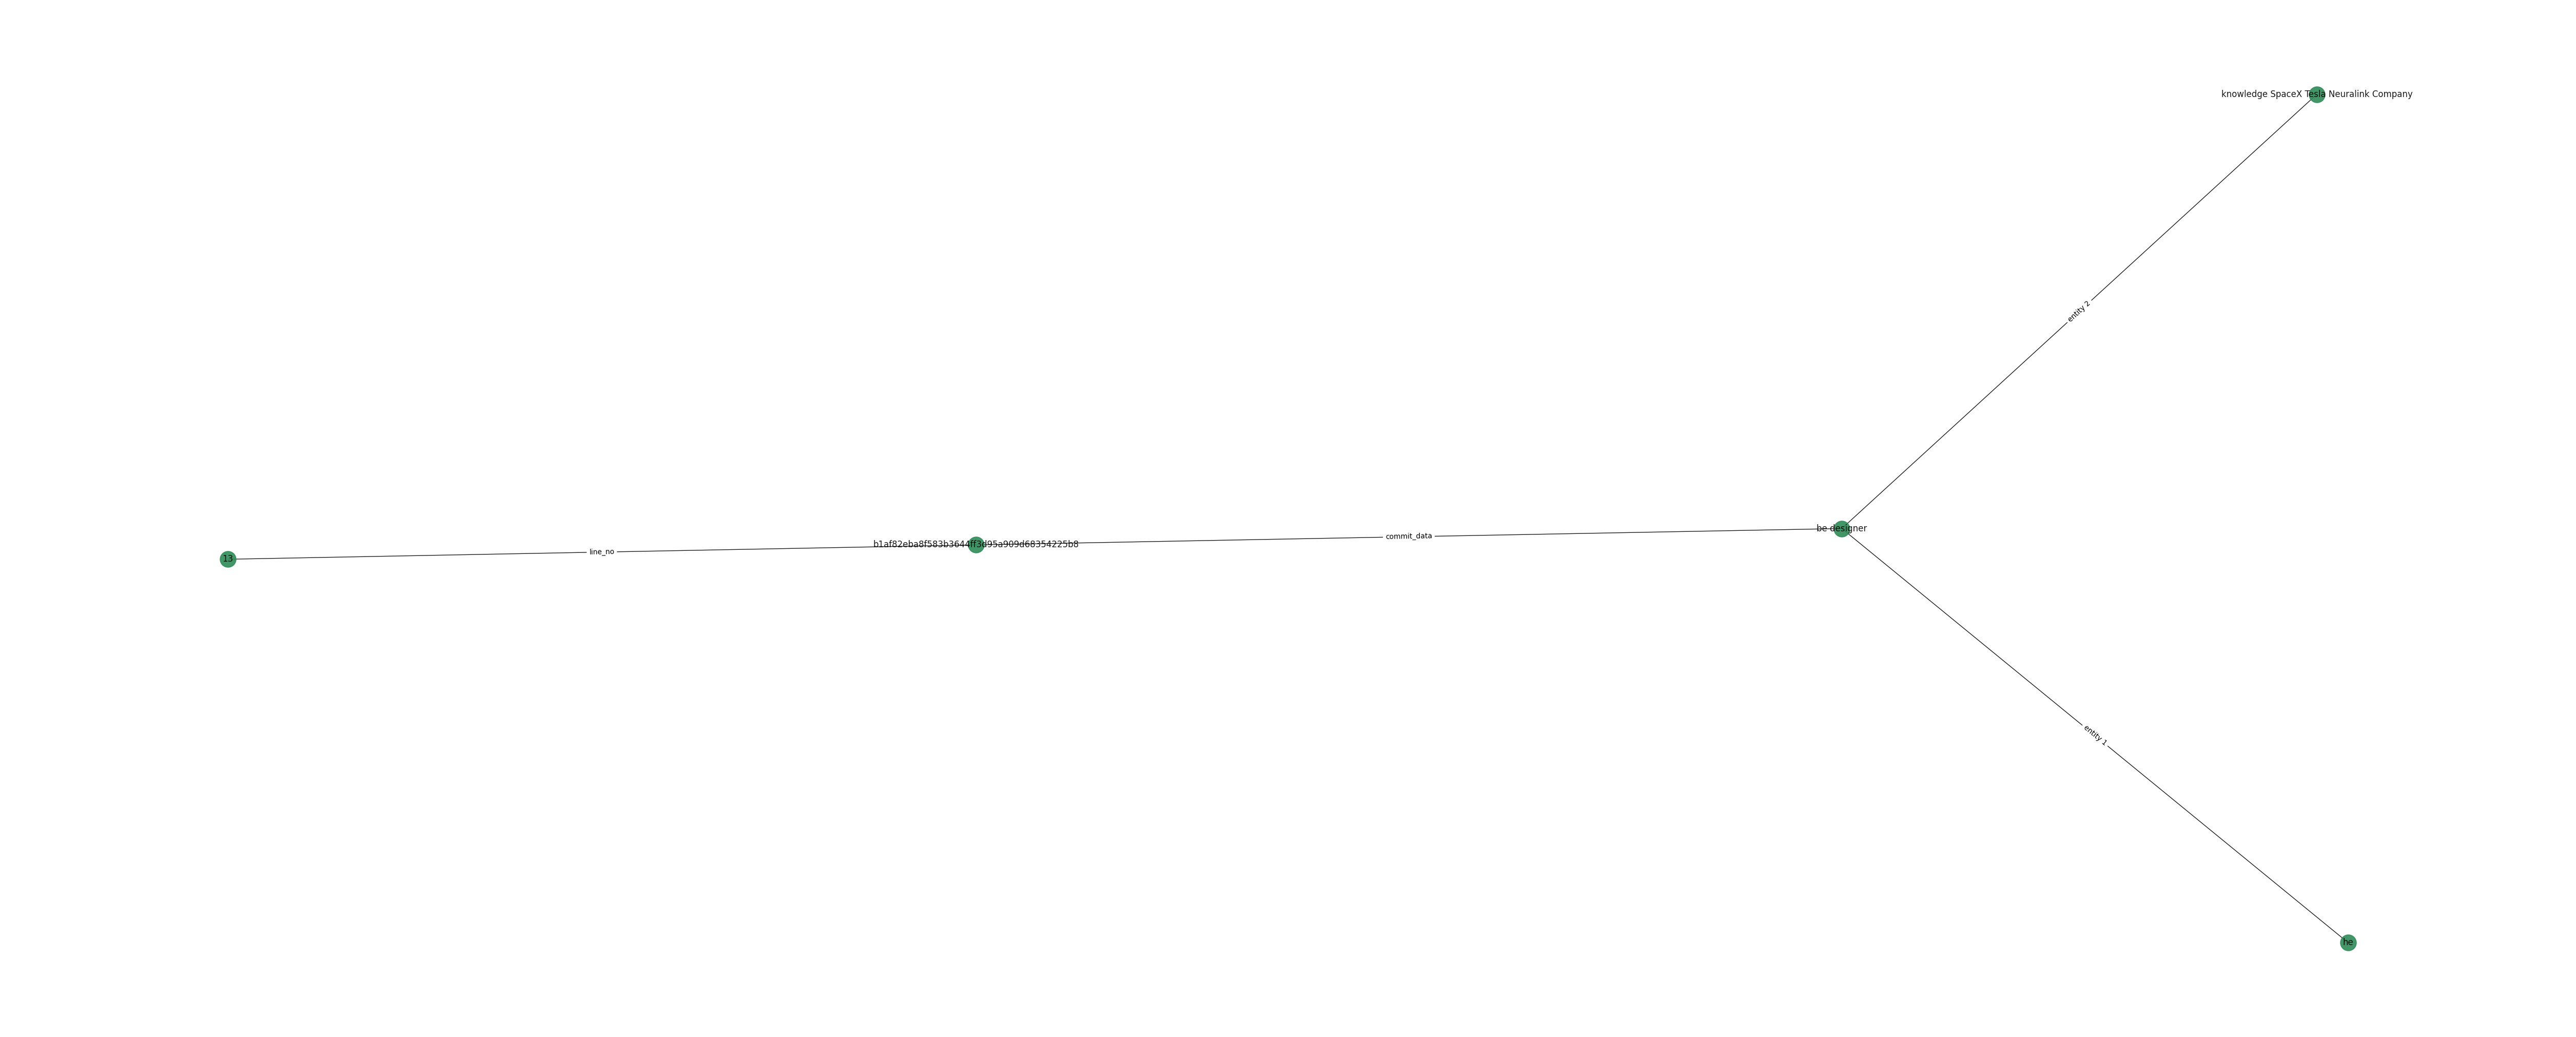

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a2420>
{'information it', 'b1af82eba8f583b3644ff3d95a909d68354225b8', 14, 'time updates', 'note late'}


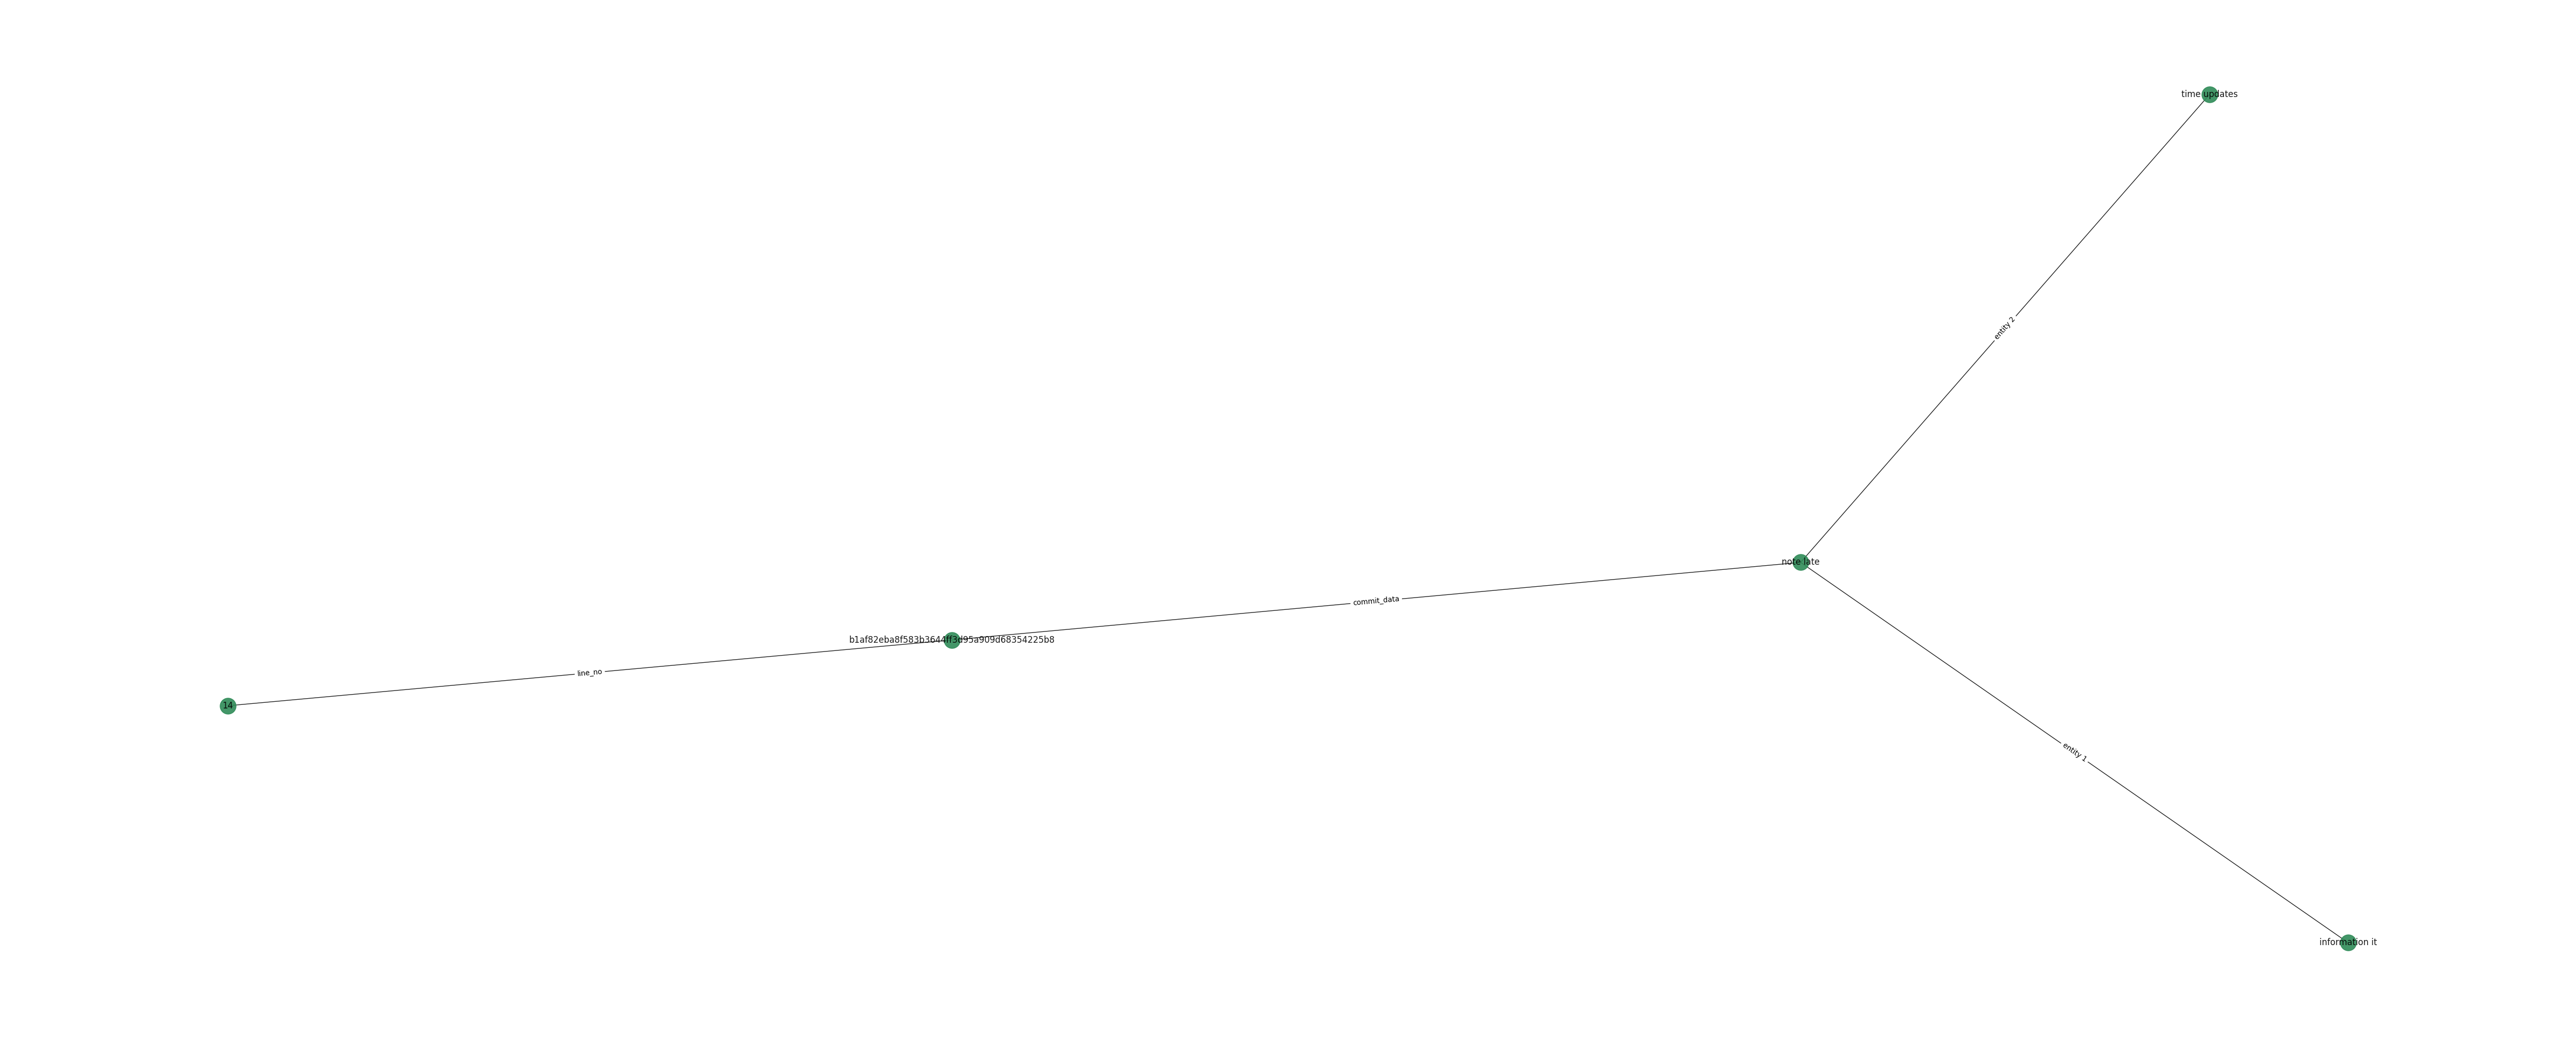

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a2420>
{'data us', '16e123b7bb17dcba6cbfc0d4216dc1e7598879de', 'help', 'improvements compatibility', 25}


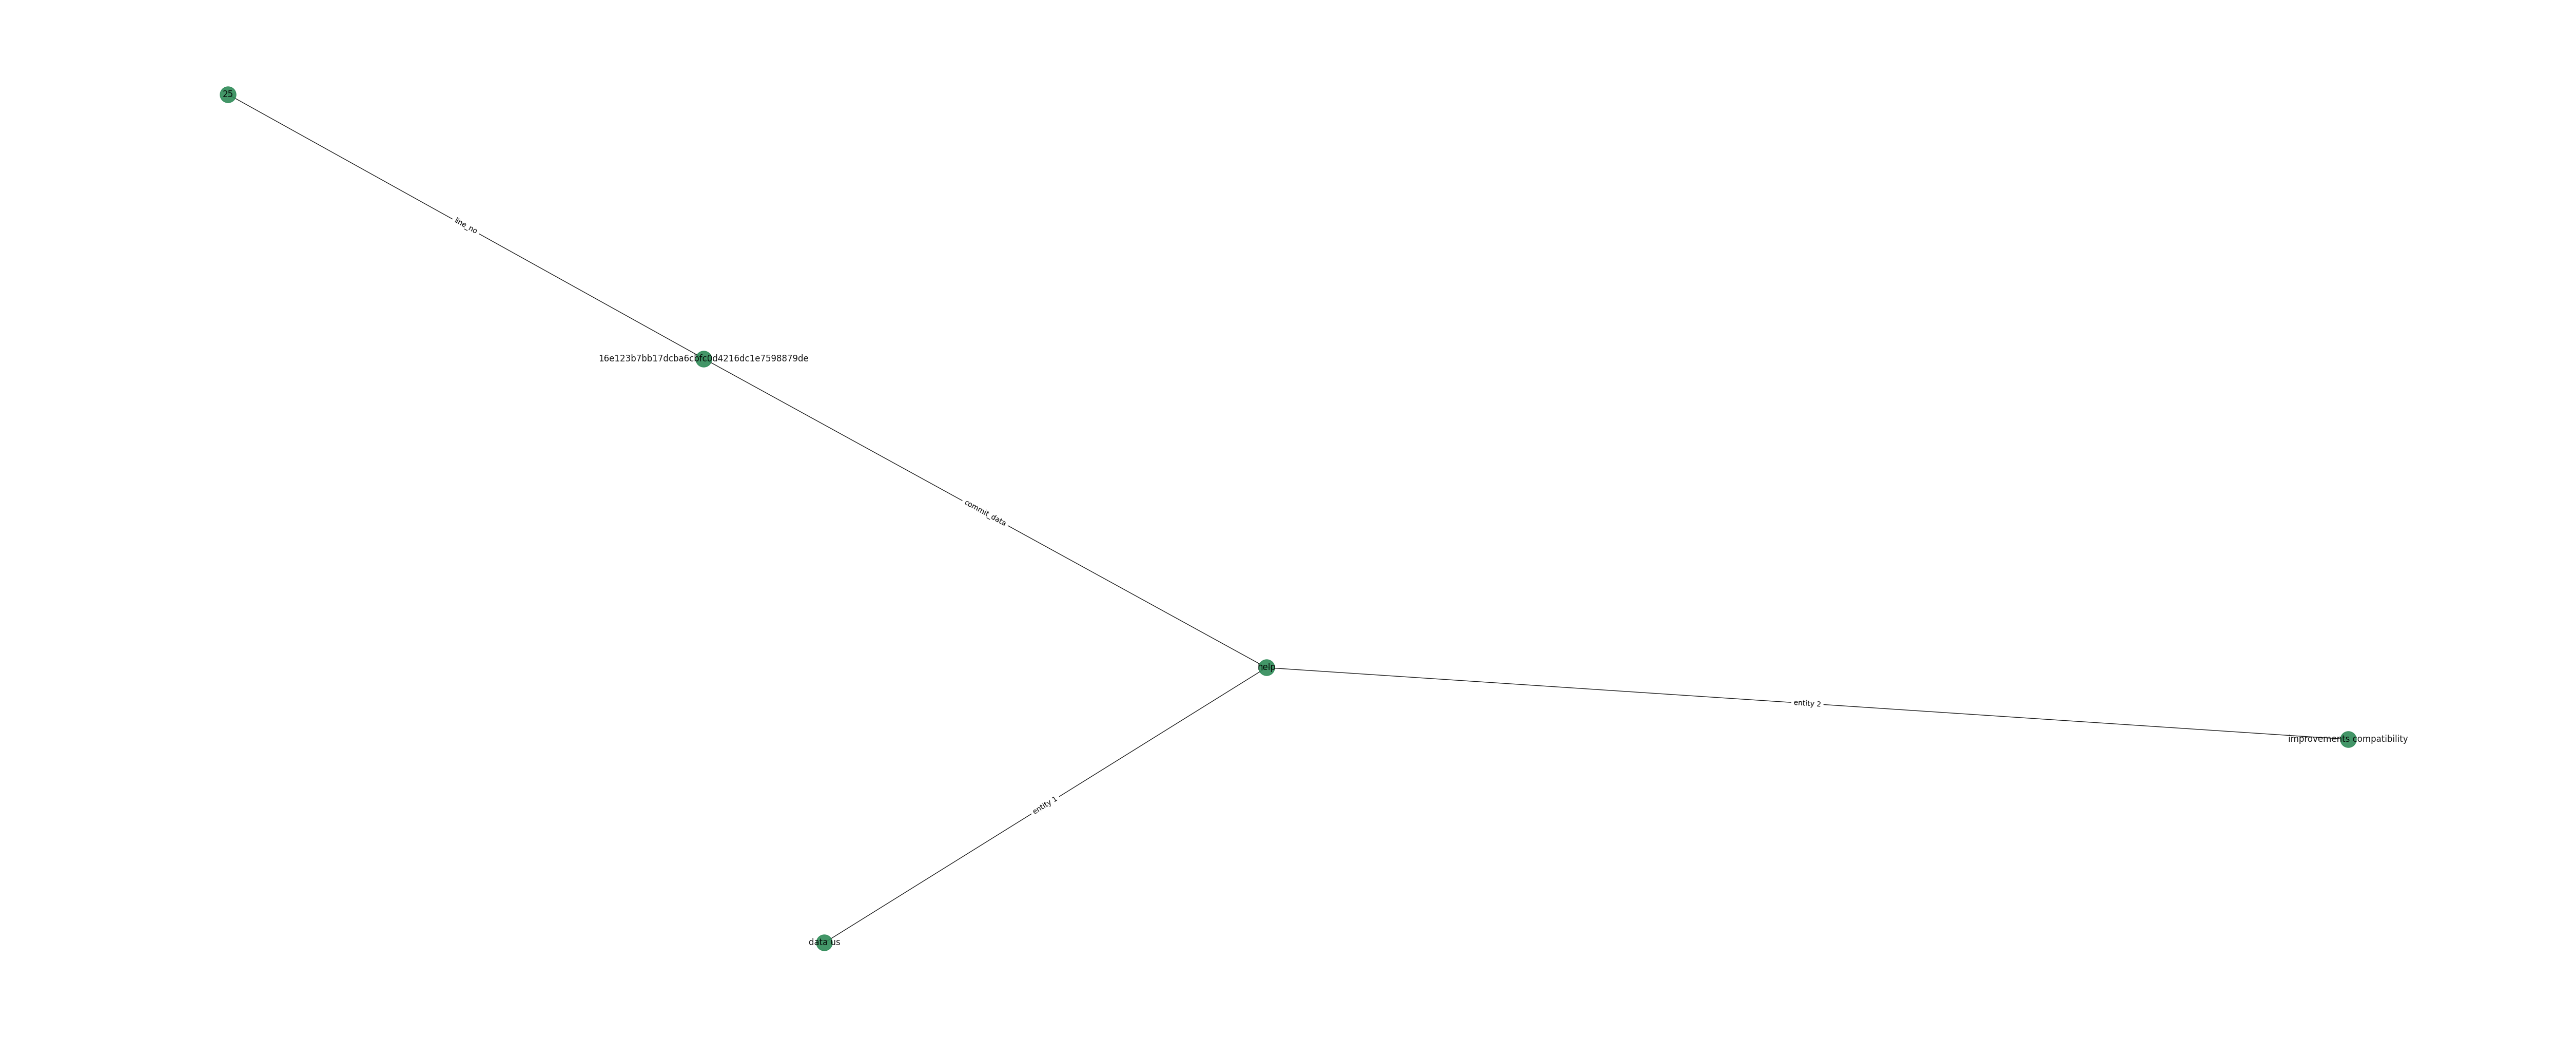

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3ae0>
{12, 'Musk', '4dc1785ef18be181708d79f68652721cd4ca05e5', 'answer several', 'companies'}


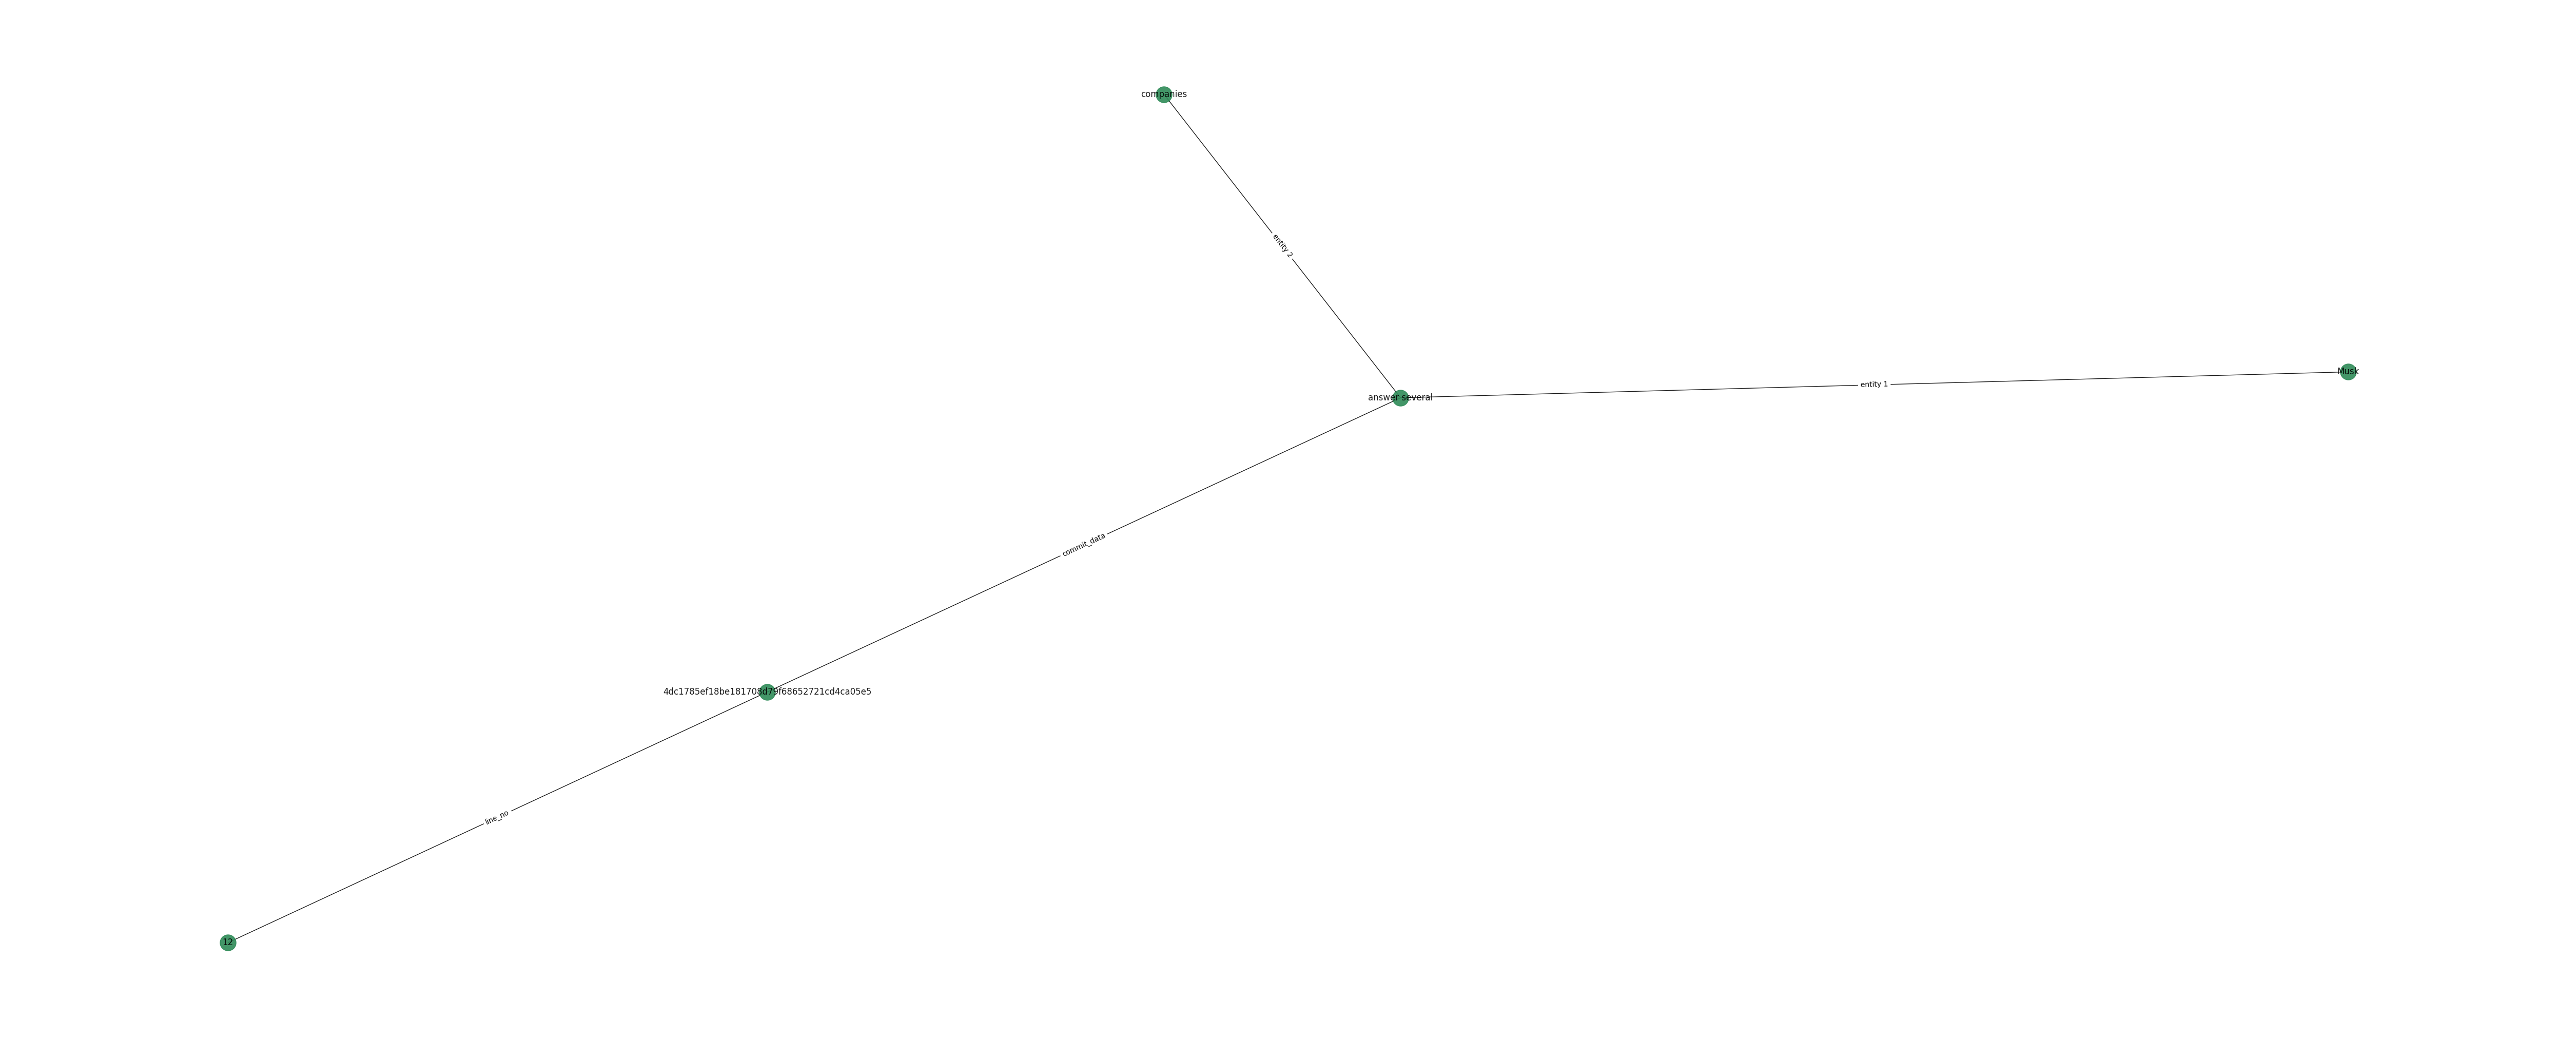

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a28f0>
{13, 'he', 'knowledge SpaceX Tesla Neuralink Company', '4dc1785ef18be181708d79f68652721cd4ca05e5', 'be designer'}


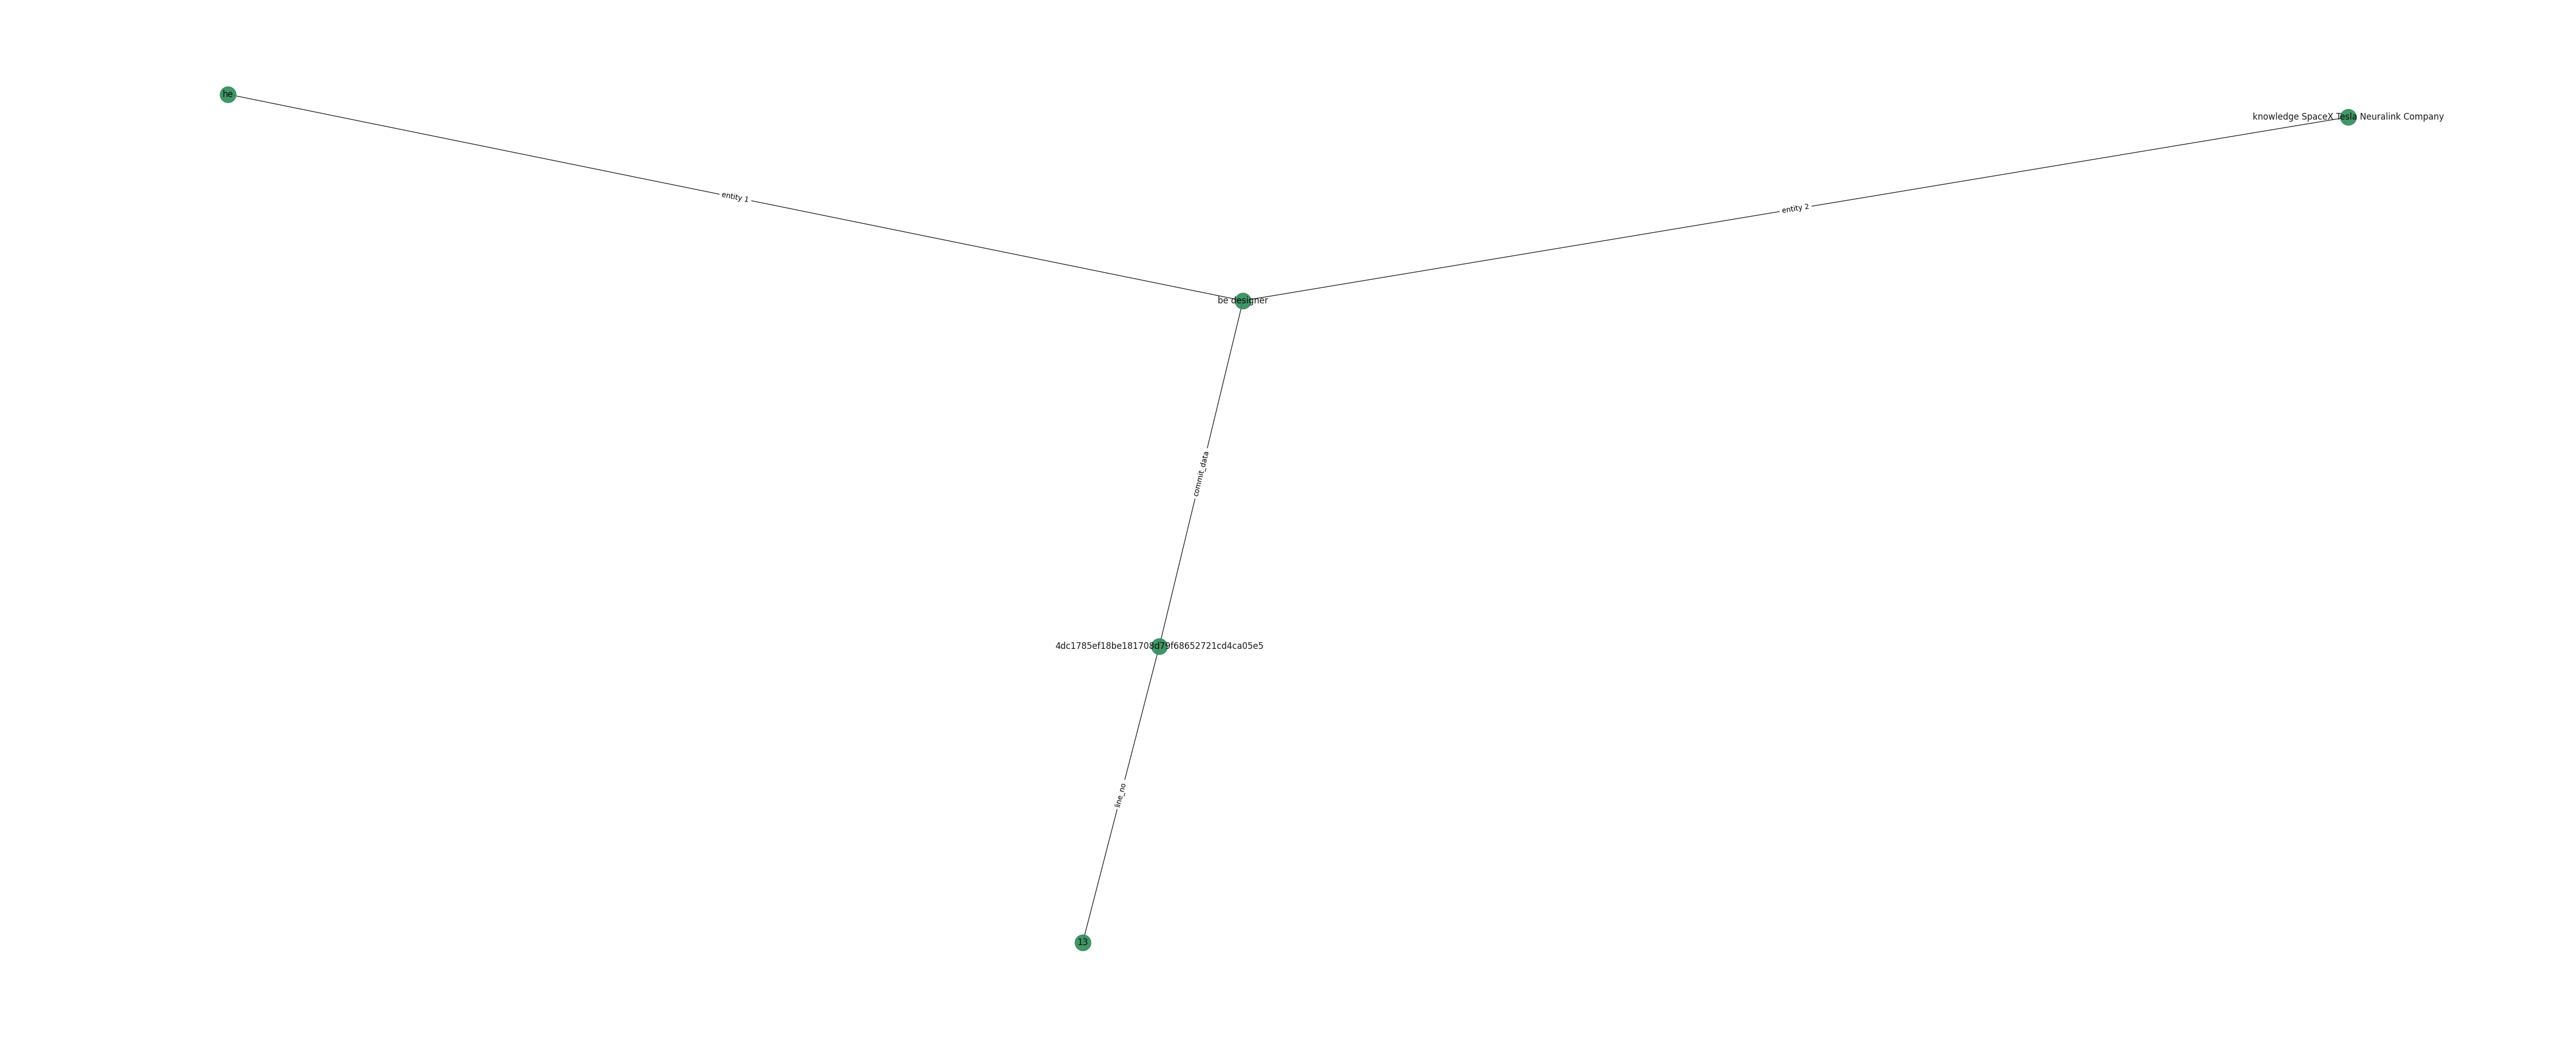

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a35a0>
{'information it', 14, 'time updates', '4dc1785ef18be181708d79f68652721cd4ca05e5', 'note late'}


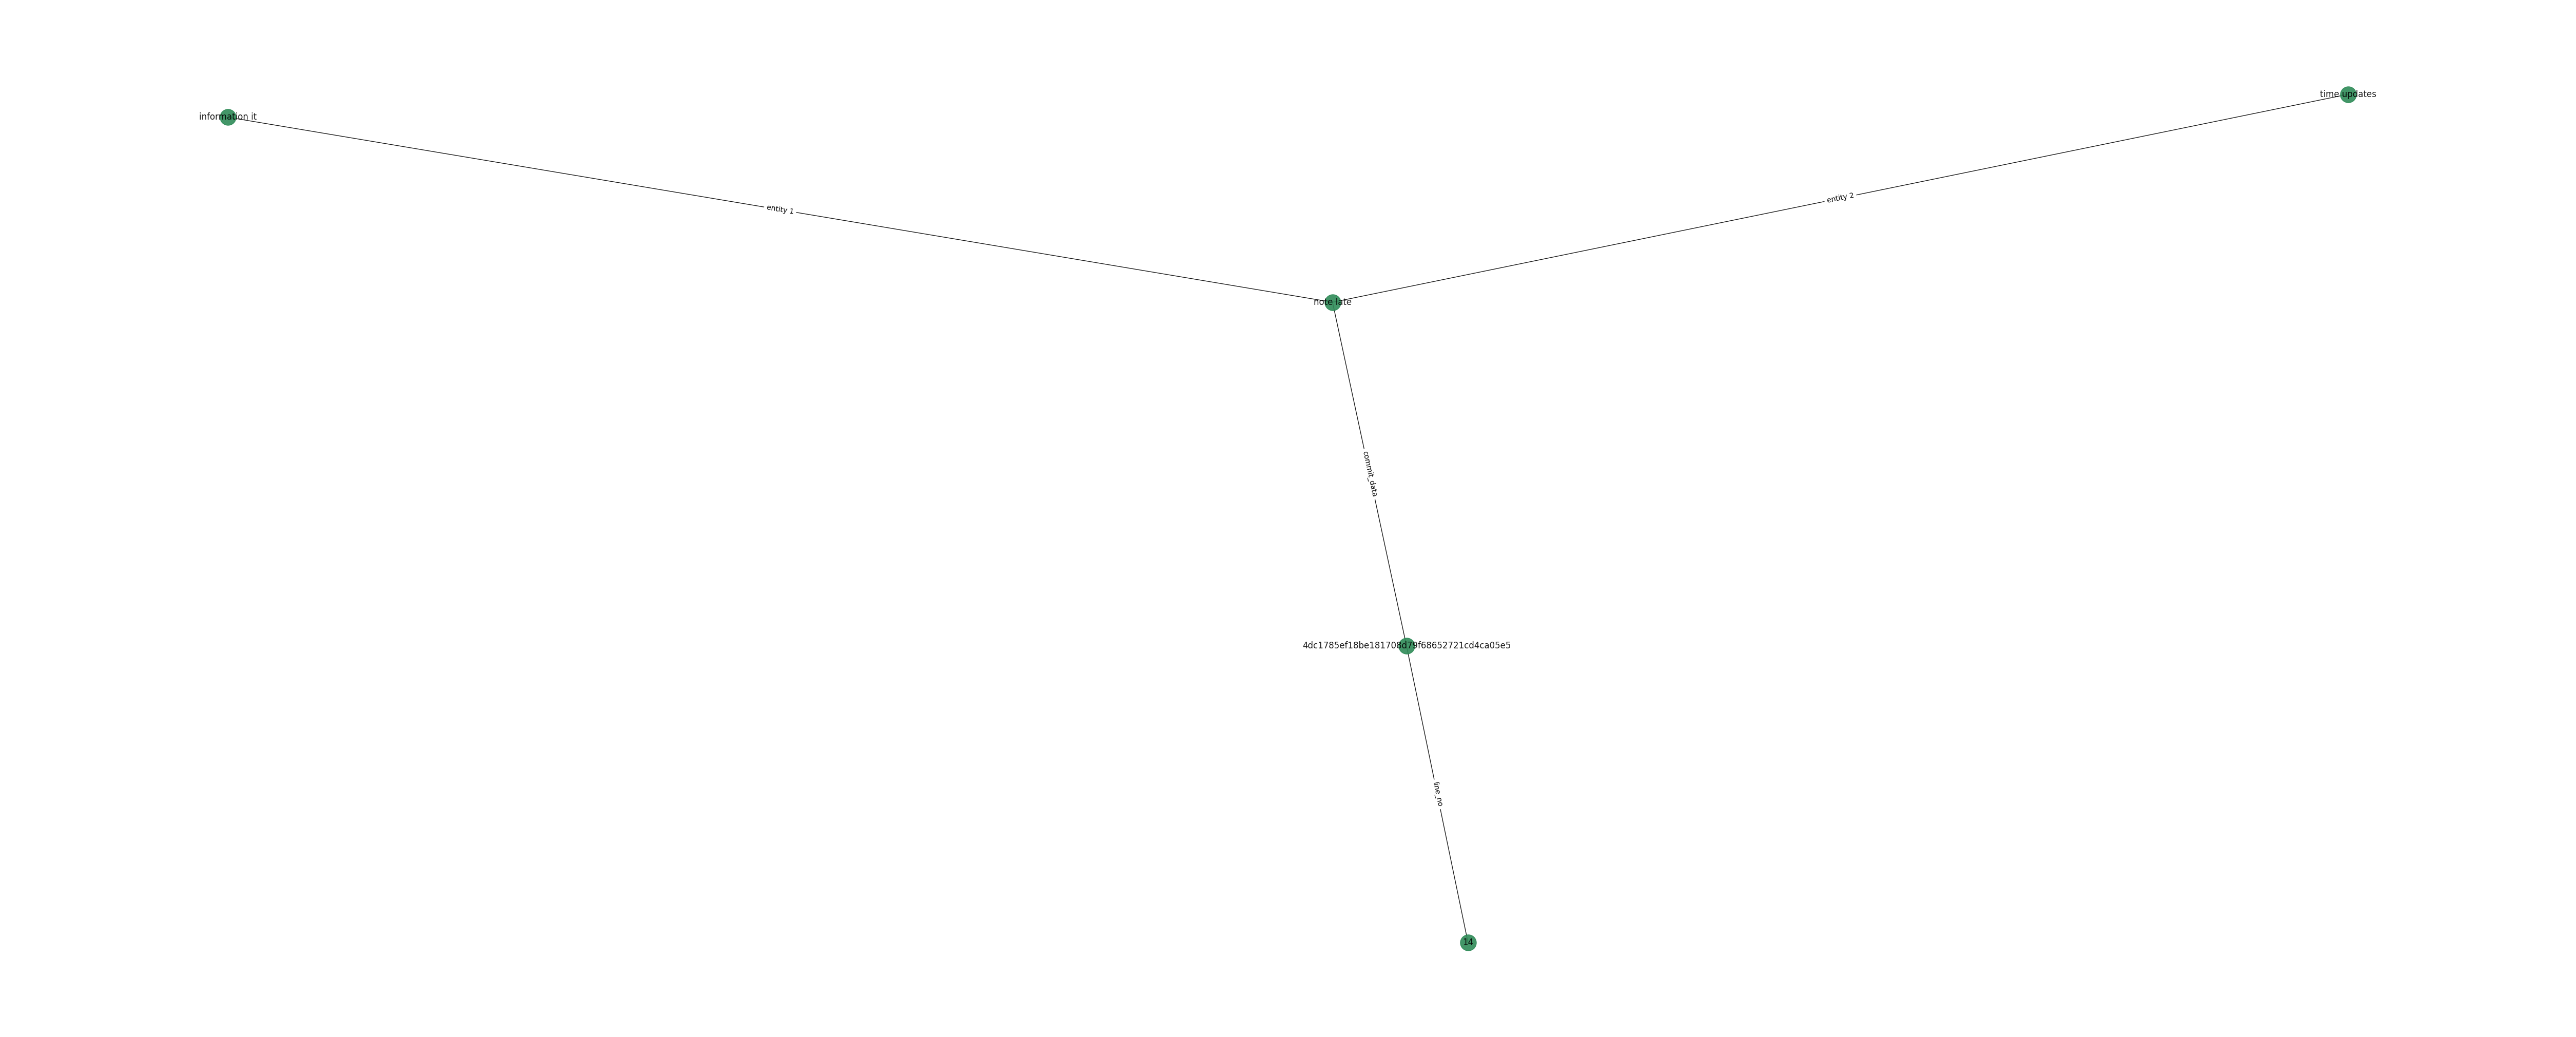

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3680>
{'', 'check pull', '4dc1785ef18be181708d79f68652721cd4ca05e5', 'issues repository request', 20}


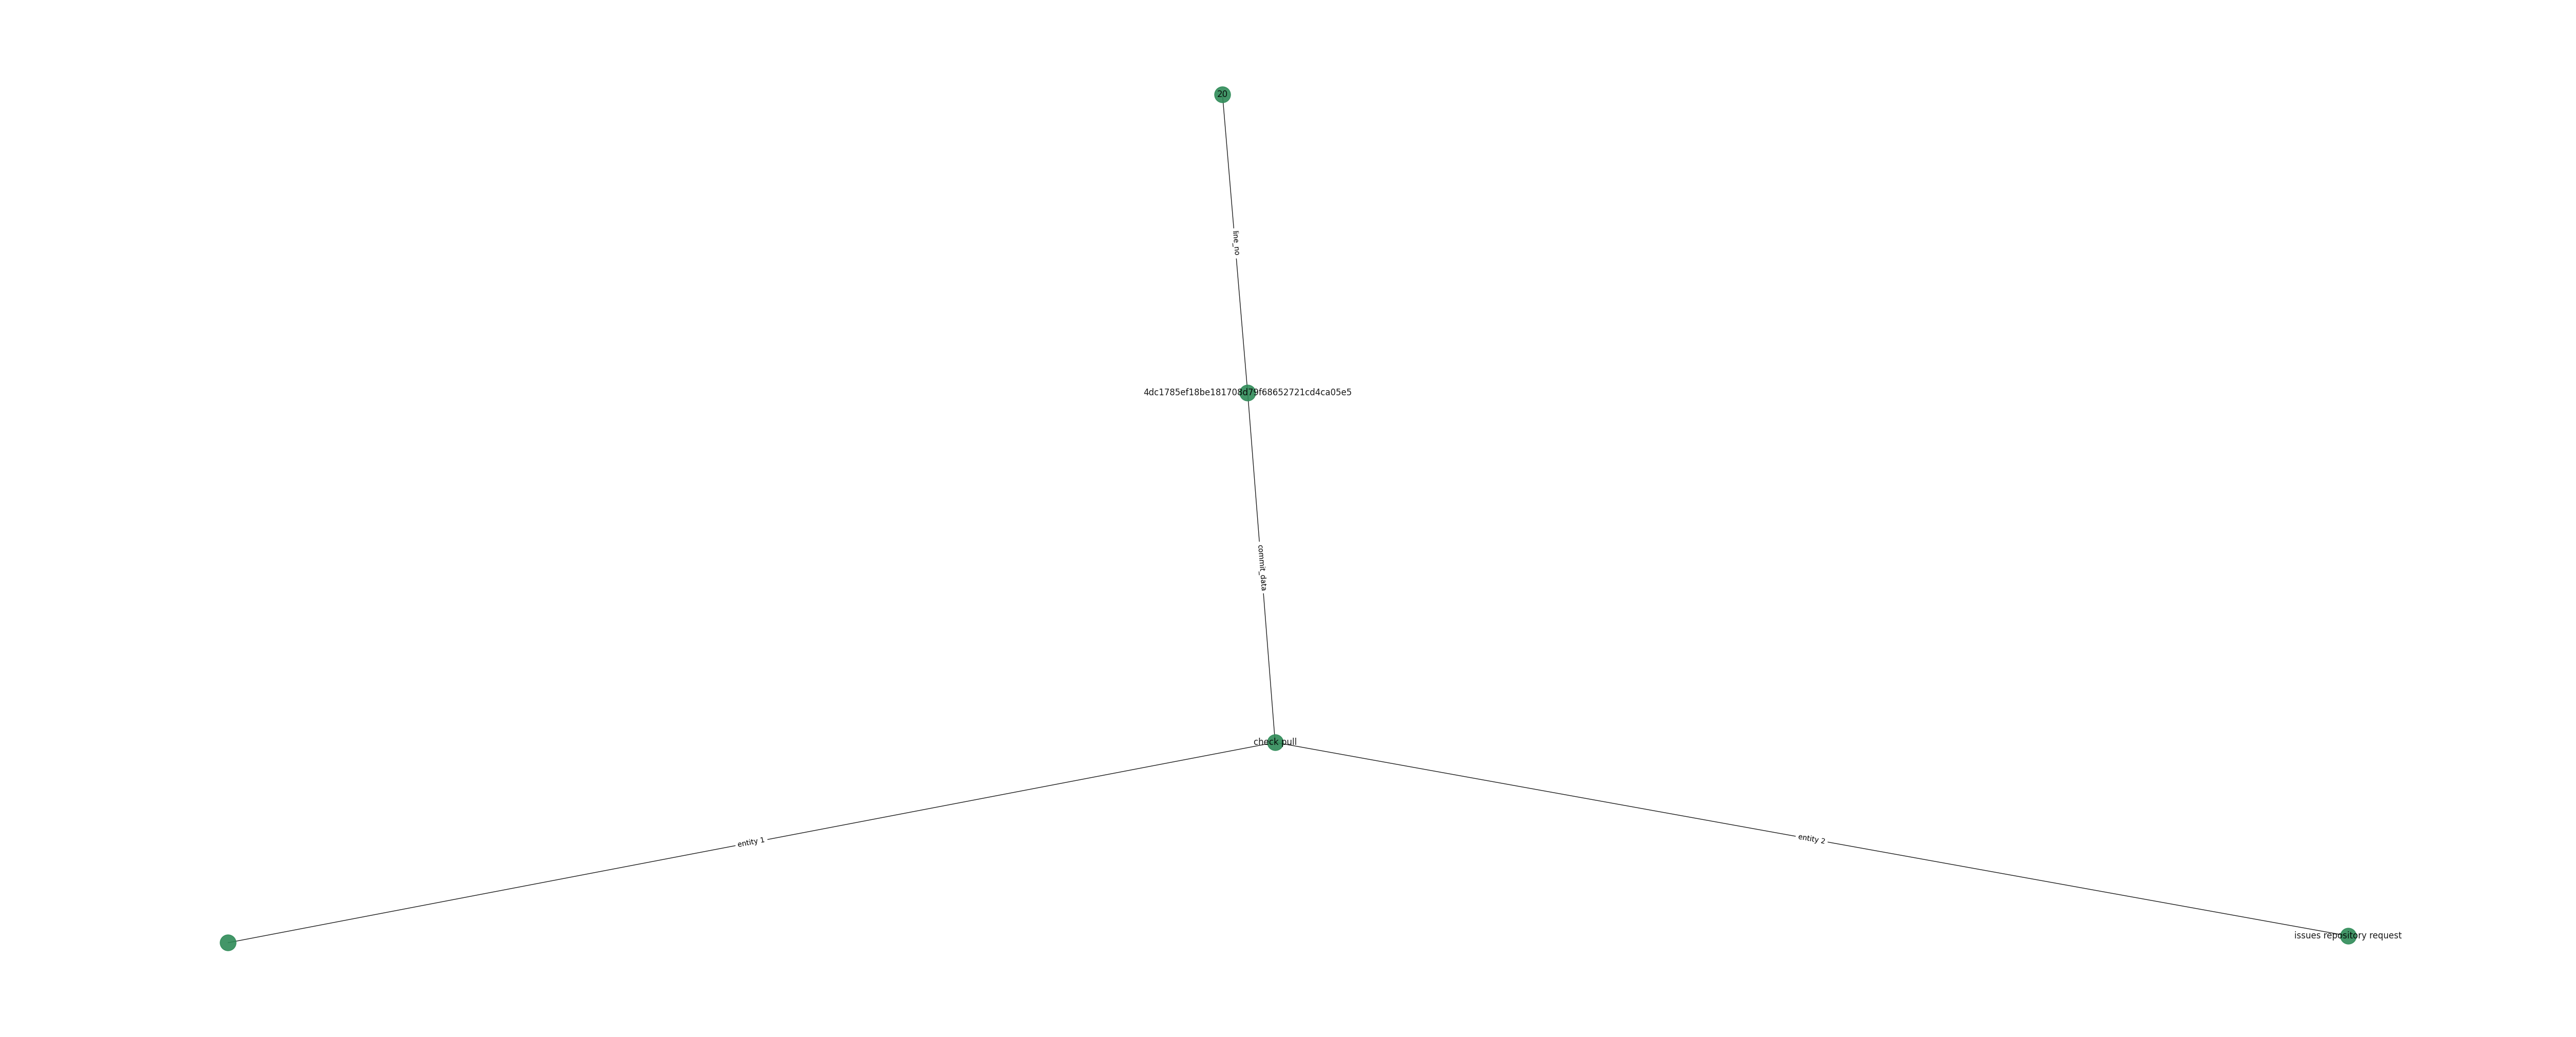

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a2500>
{12, 'Musk', 'answer several', 'd3726134b255bfc4a3ecd79ec5a6f4a43b37470a', 'companies'}


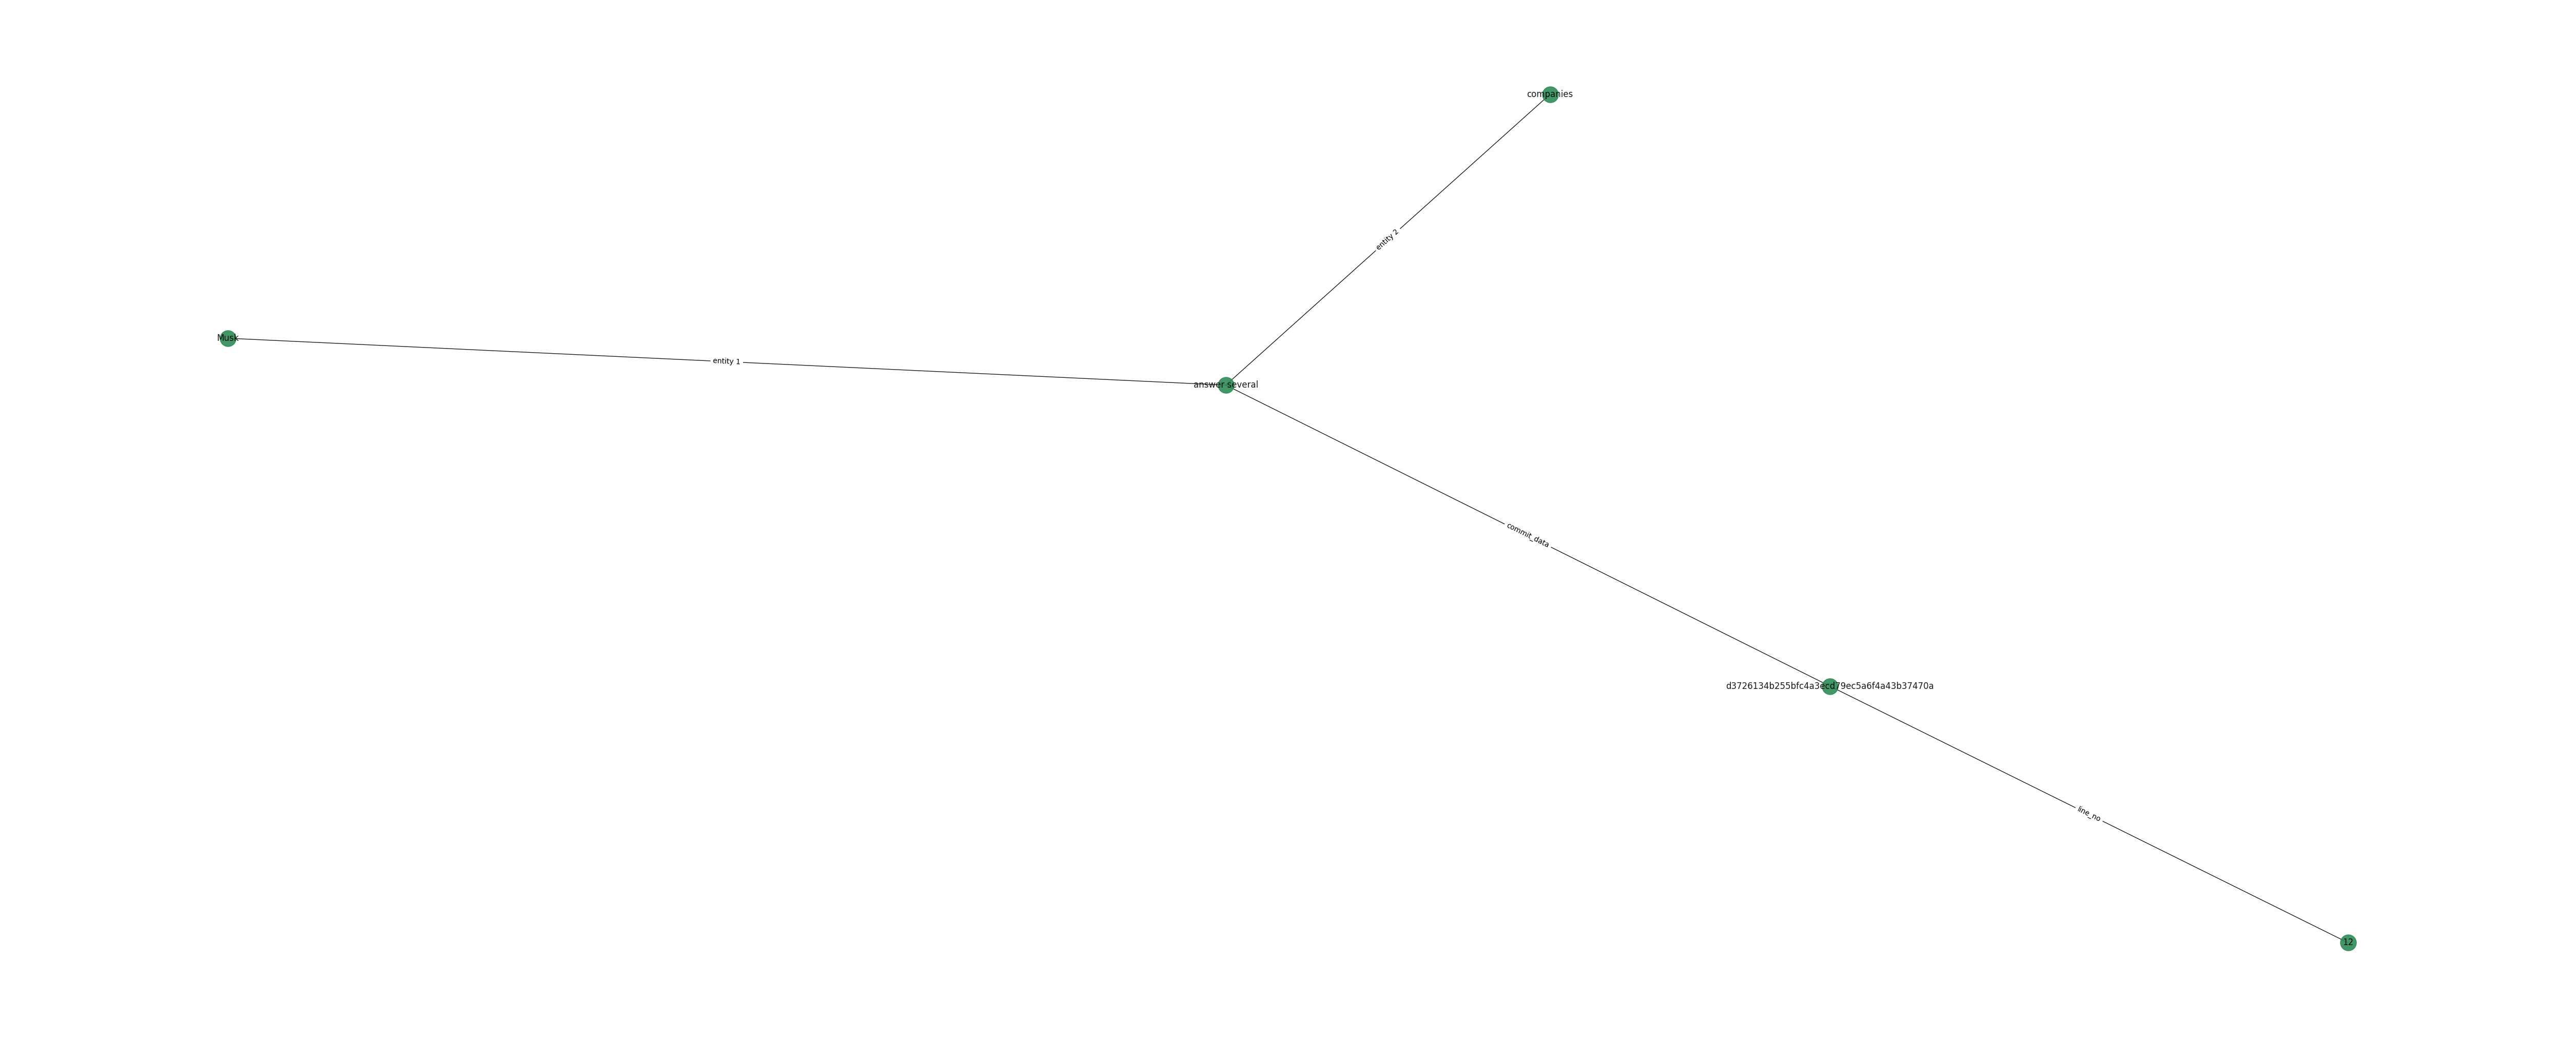

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a28f0>
{13, 'he', 'knowledge SpaceX Tesla Neuralink Company', 'be designer', 'd3726134b255bfc4a3ecd79ec5a6f4a43b37470a'}


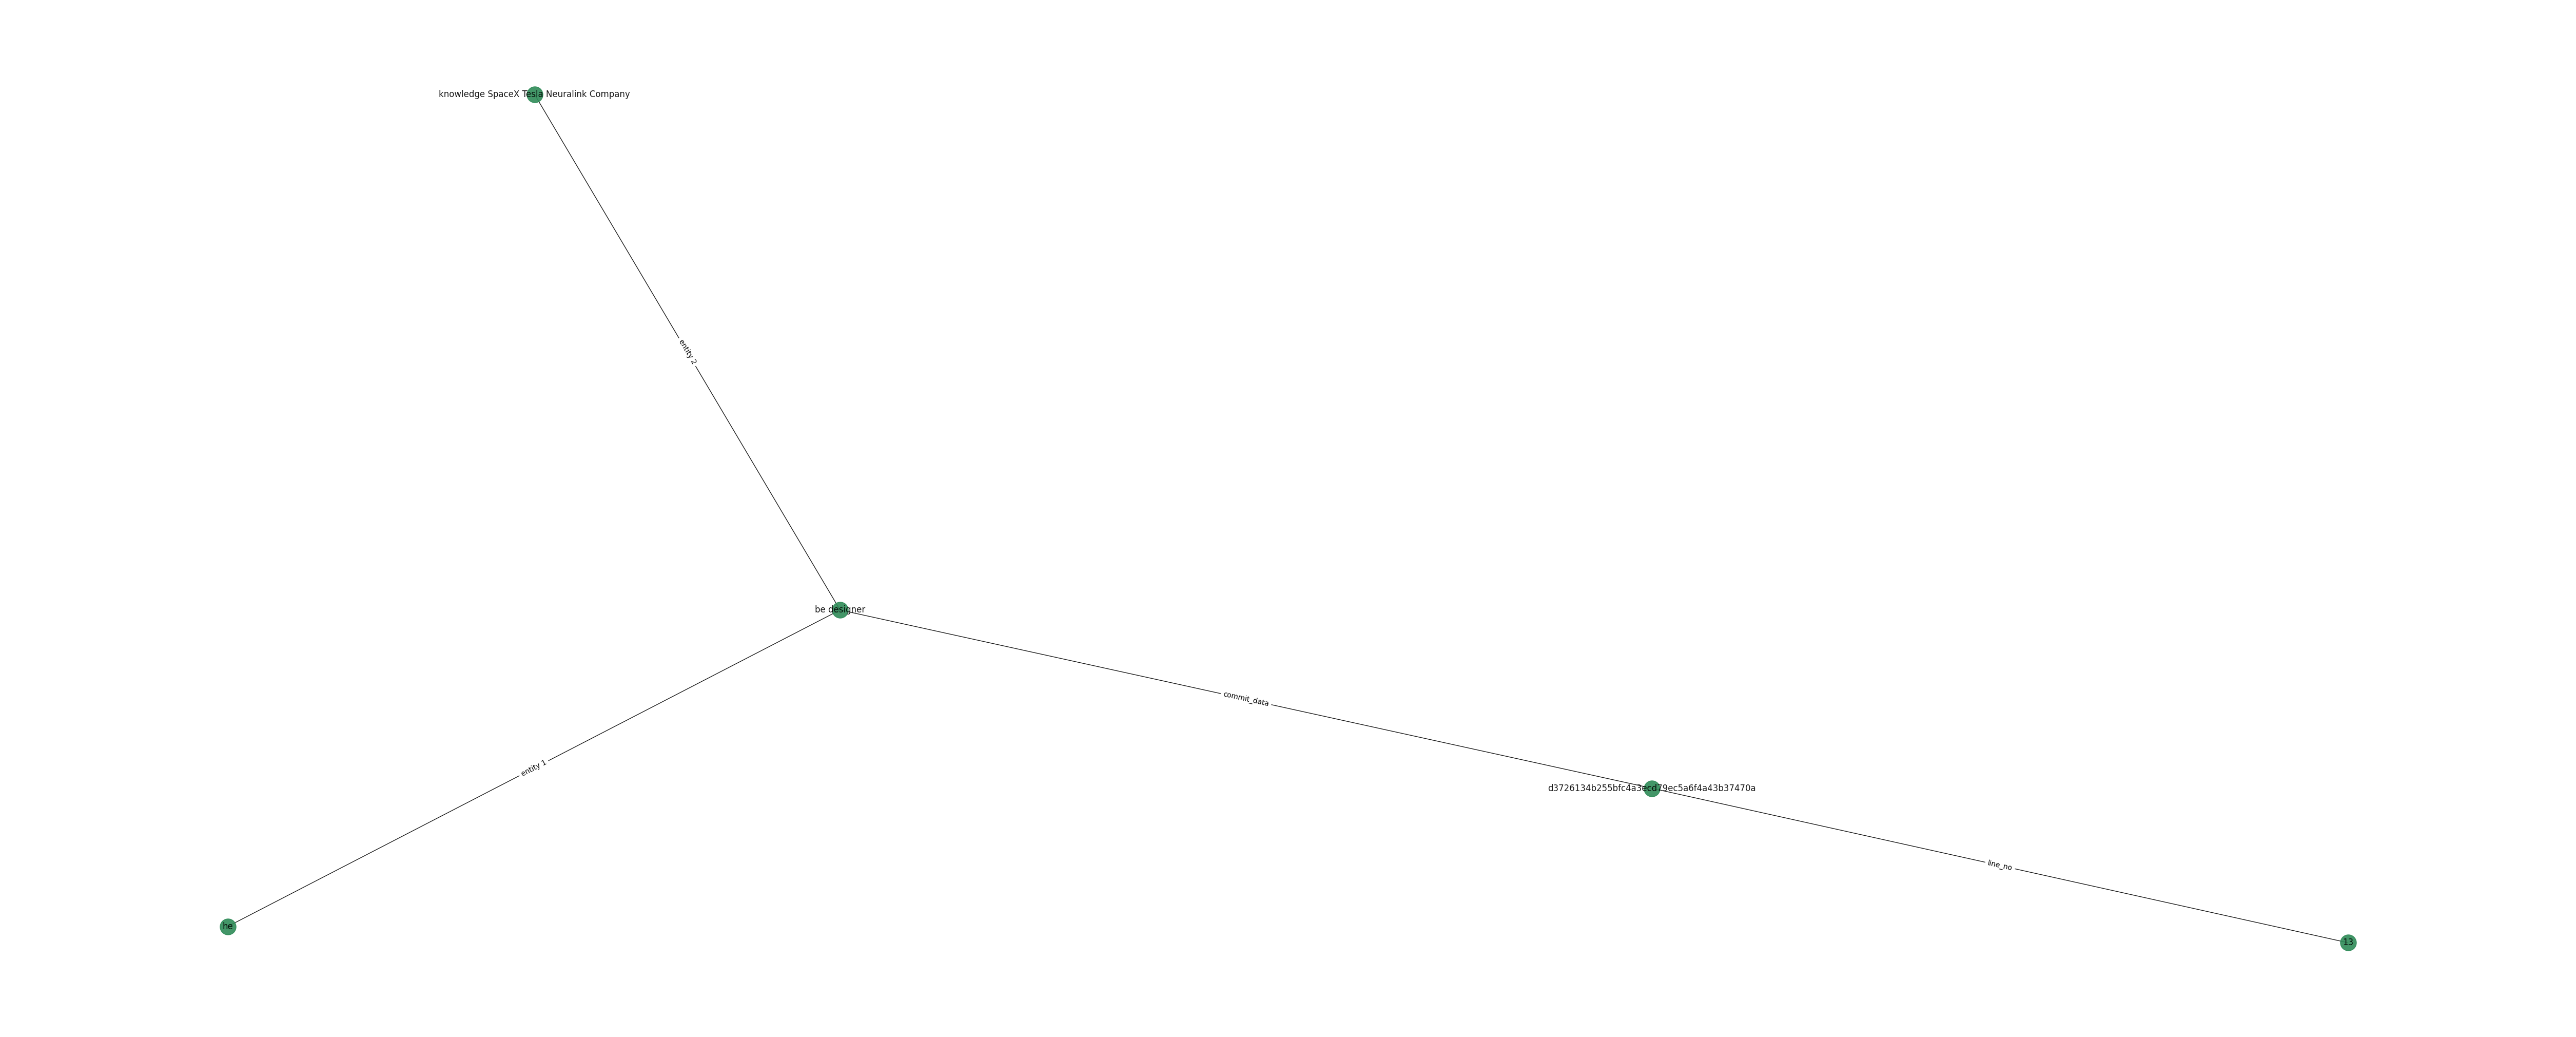

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a28f0>
{'information it', 14, 'time updates', 'note late', 'd3726134b255bfc4a3ecd79ec5a6f4a43b37470a'}


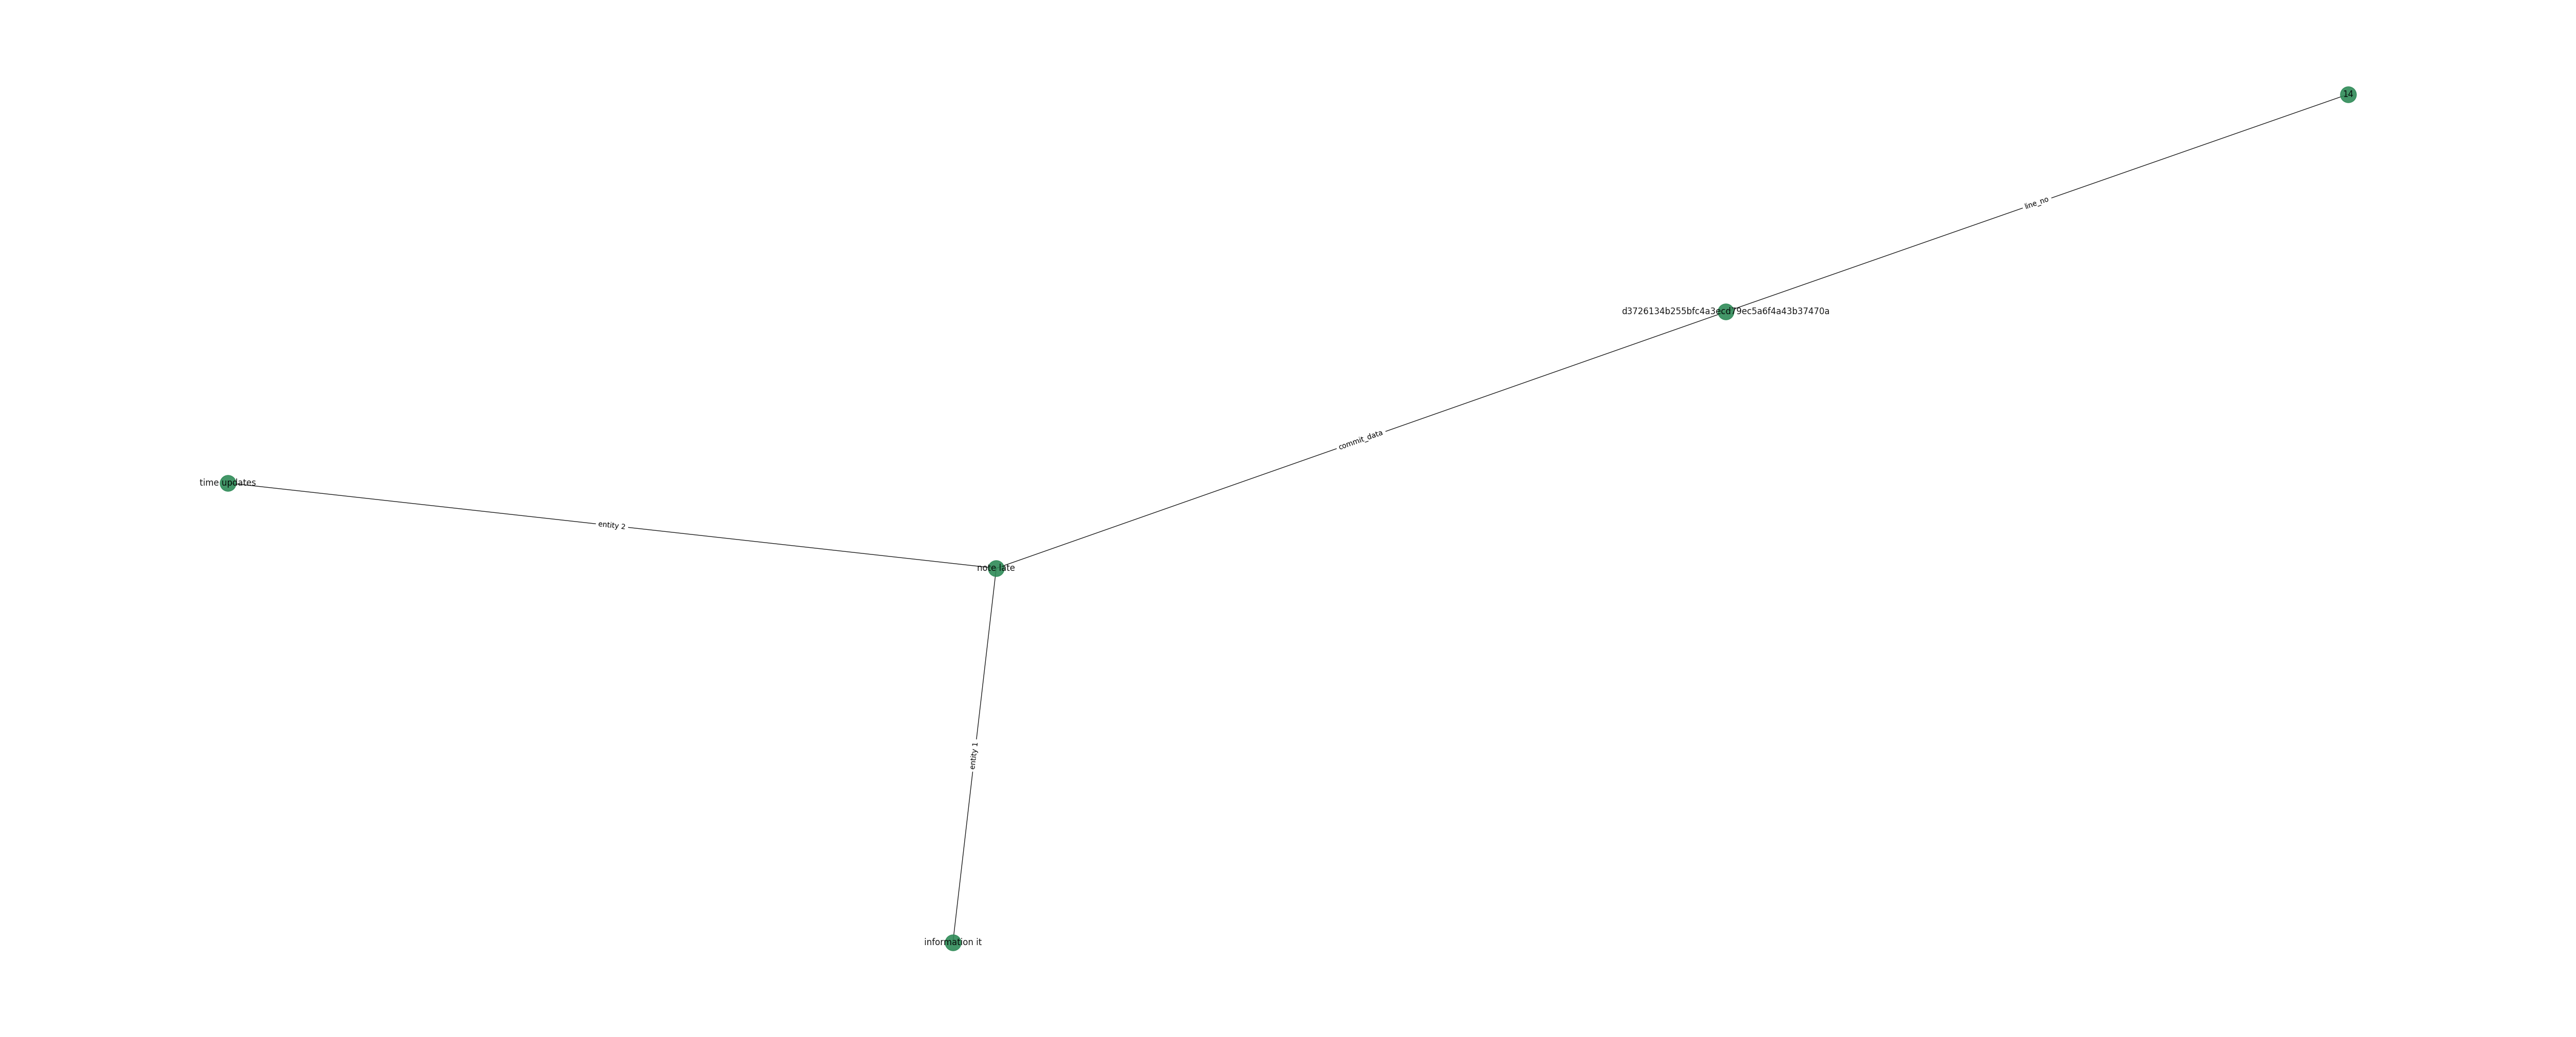

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7ca0>
{'', '3332e6e236e14aeece6db4ac8fda4bd21d874801', 'discussions questions experiences', 17, 'dive'}


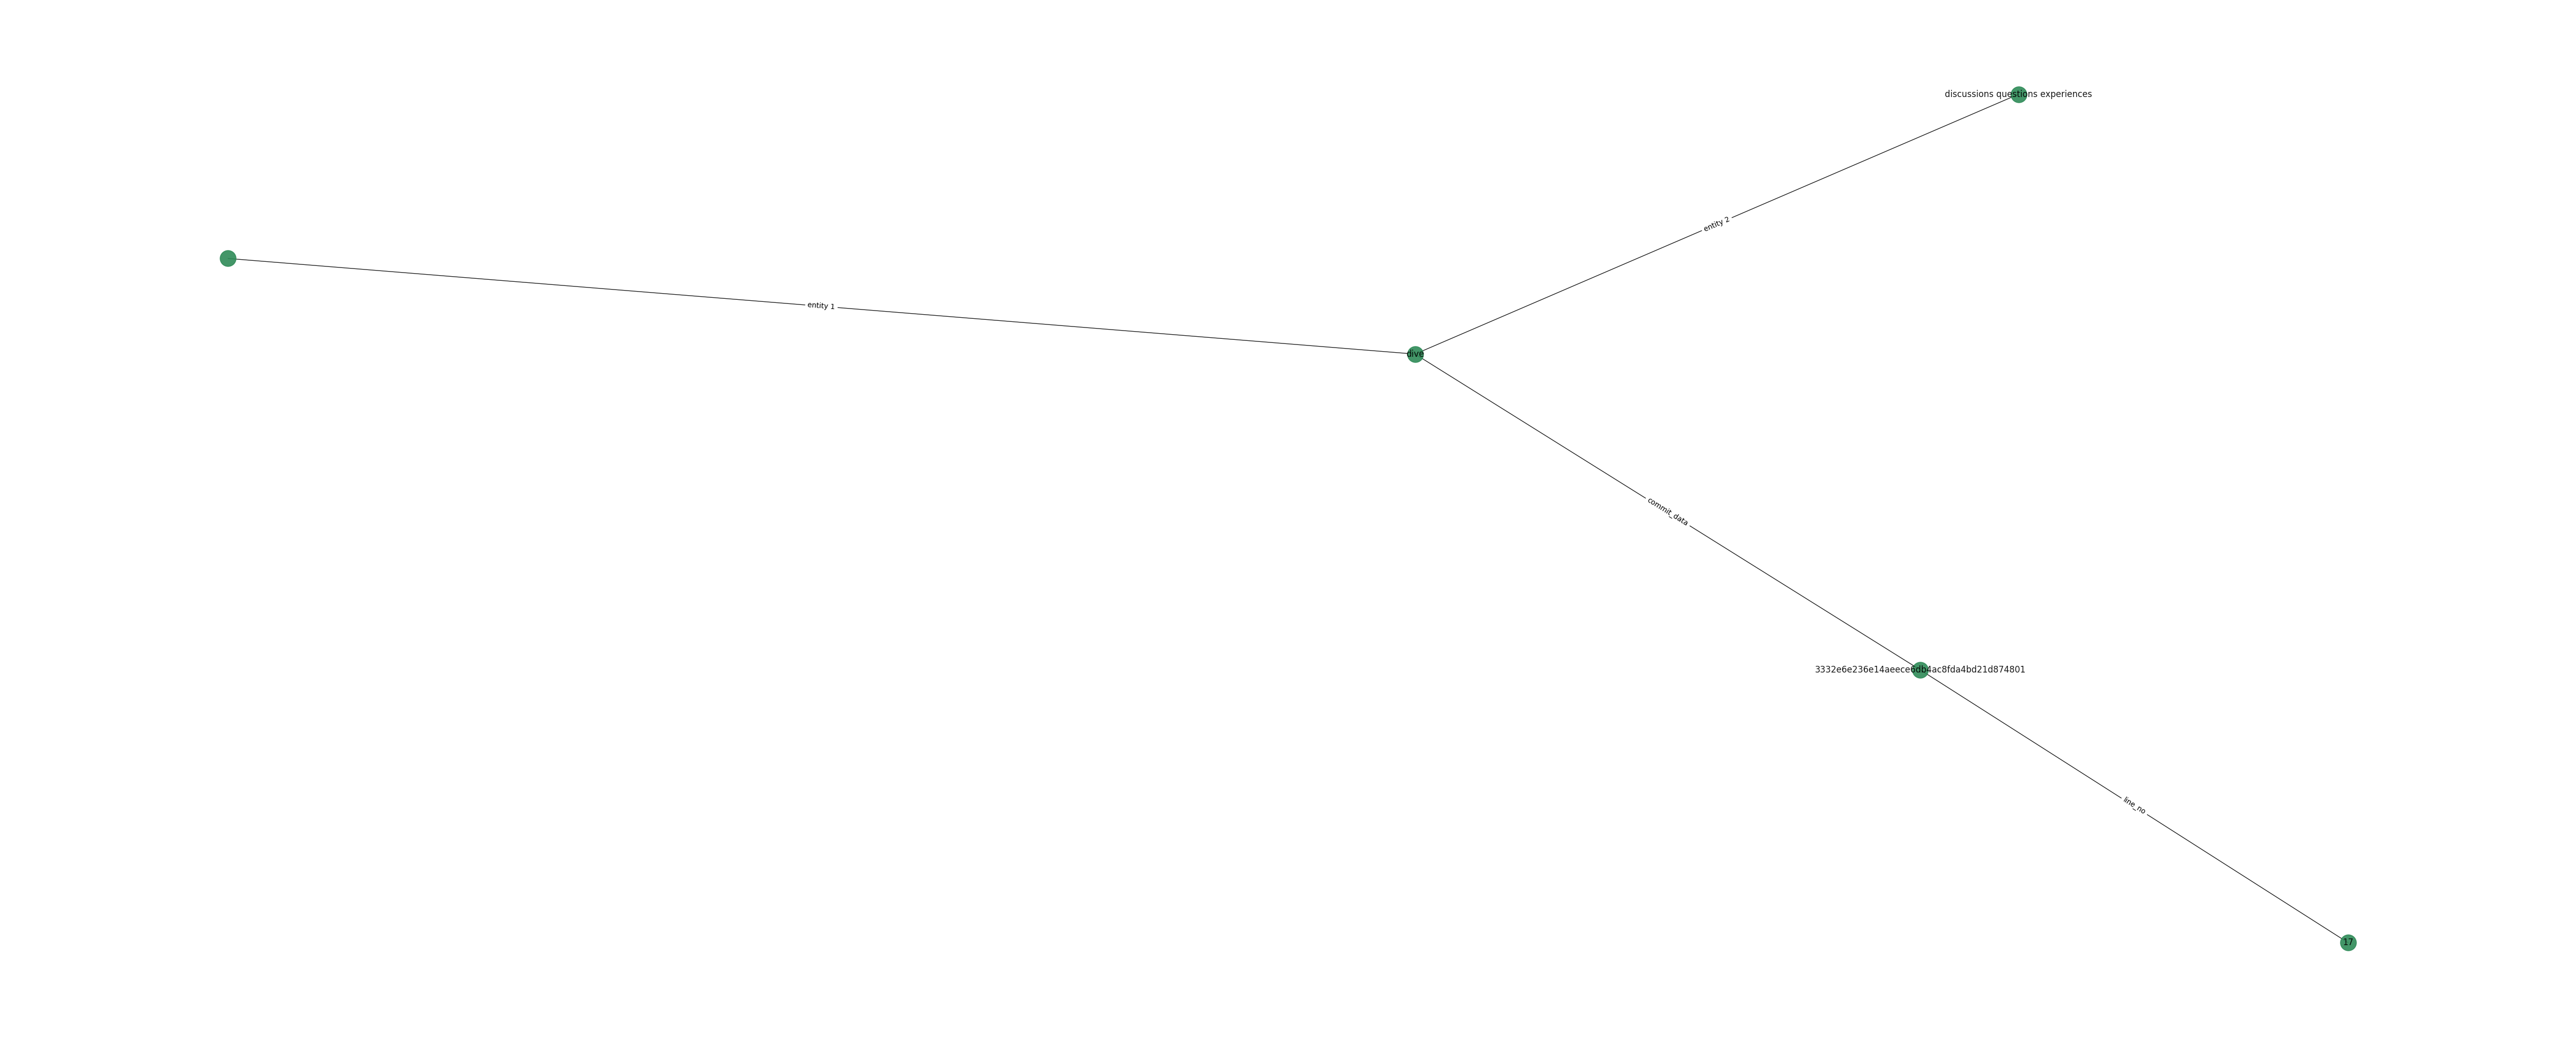

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7840>
{'', '3332e6e236e14aeece6db4ac8fda4bd21d874801', 'be', 'Contributions', 19}


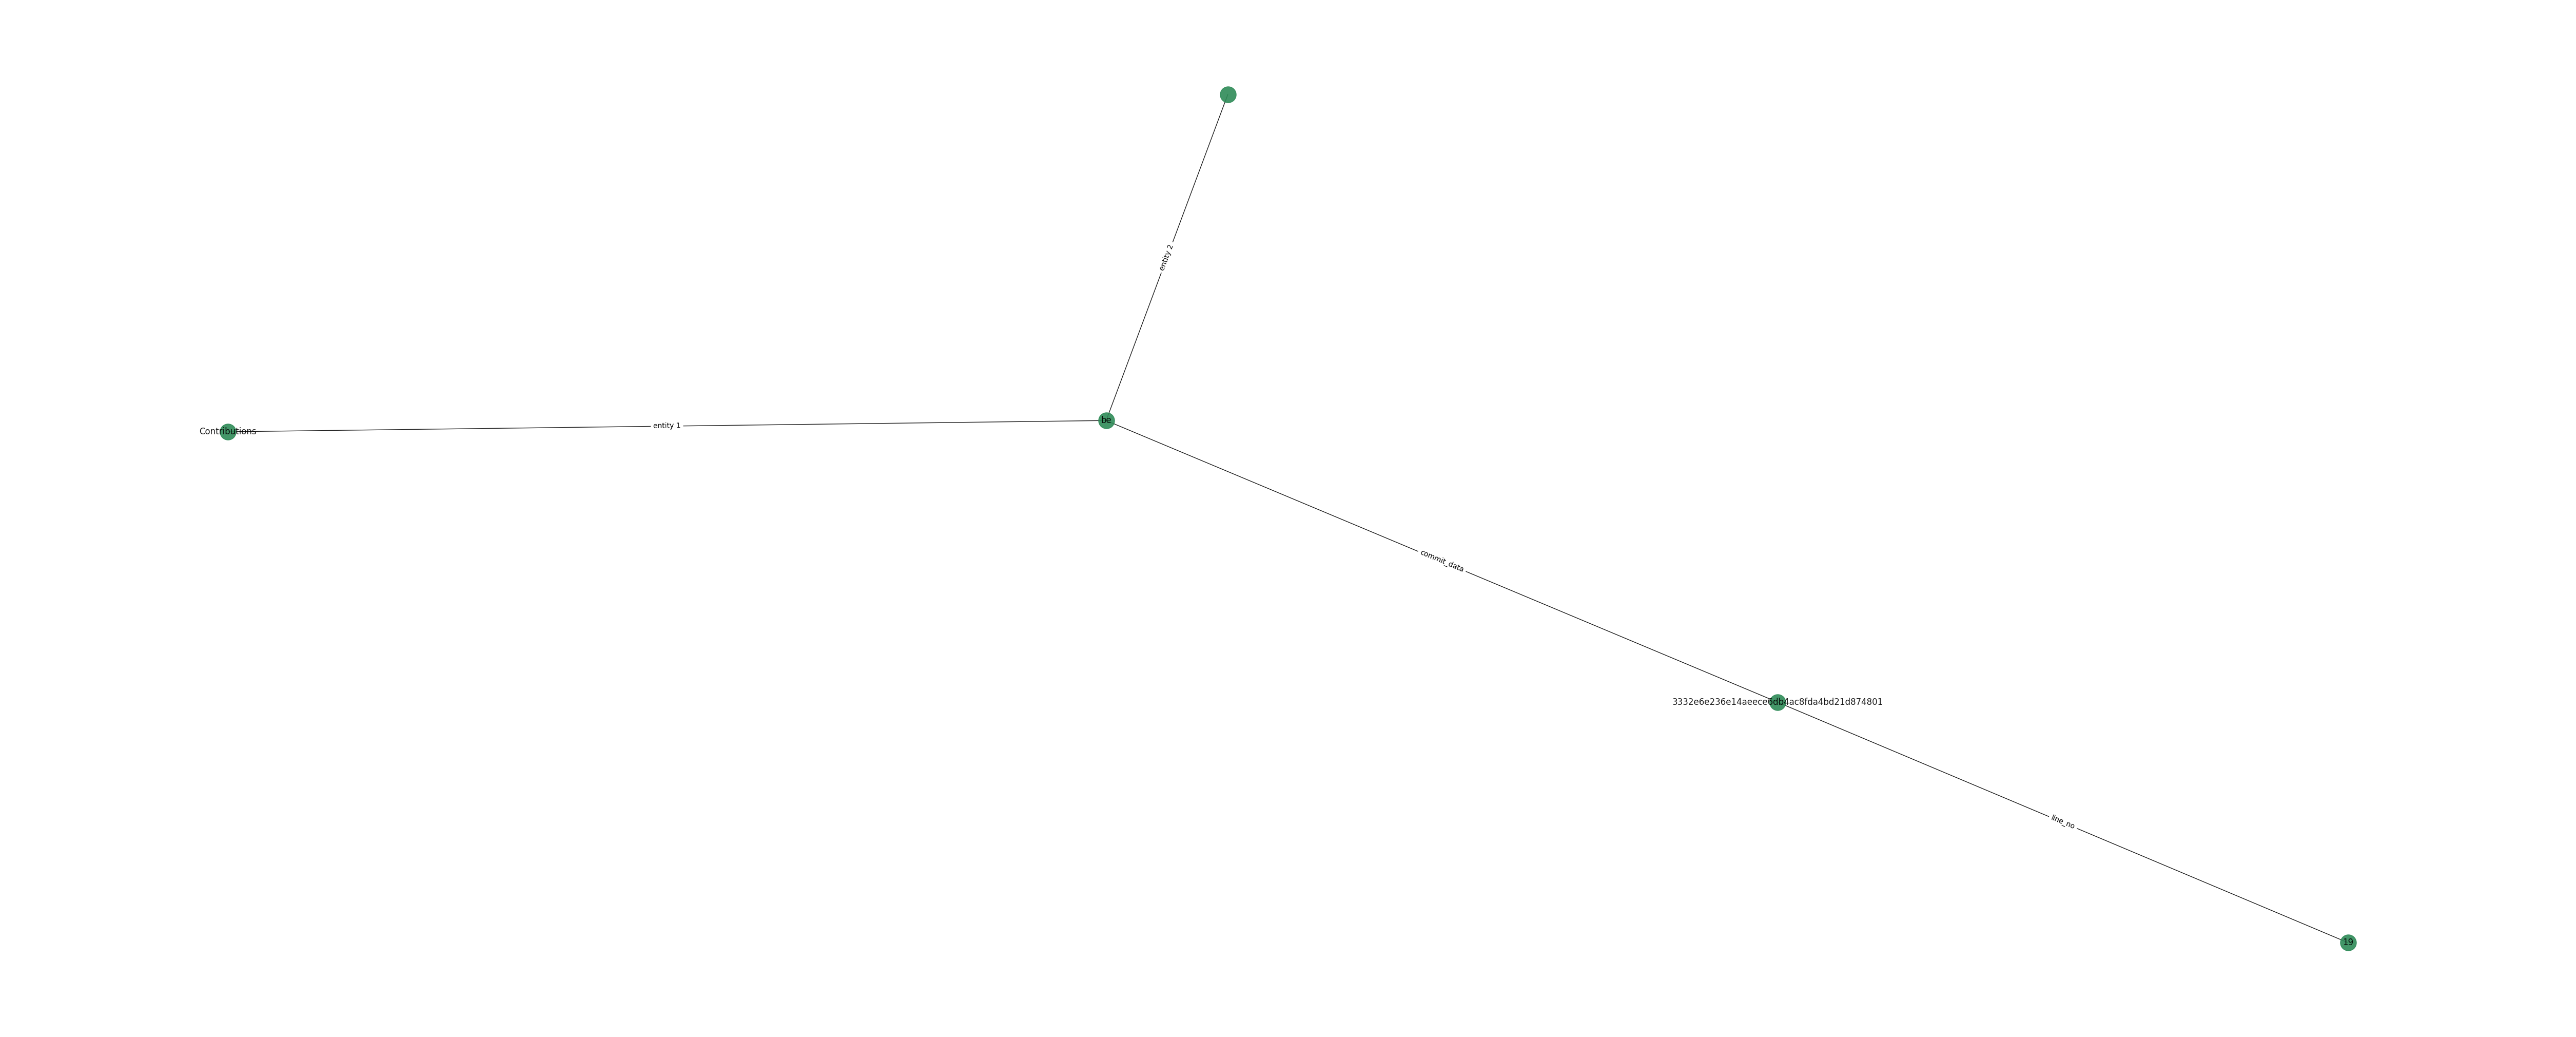

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b6ff0>
{'', '3332e6e236e14aeece6db4ac8fda4bd21d874801', 'check pull', 'issues repository request', 20}


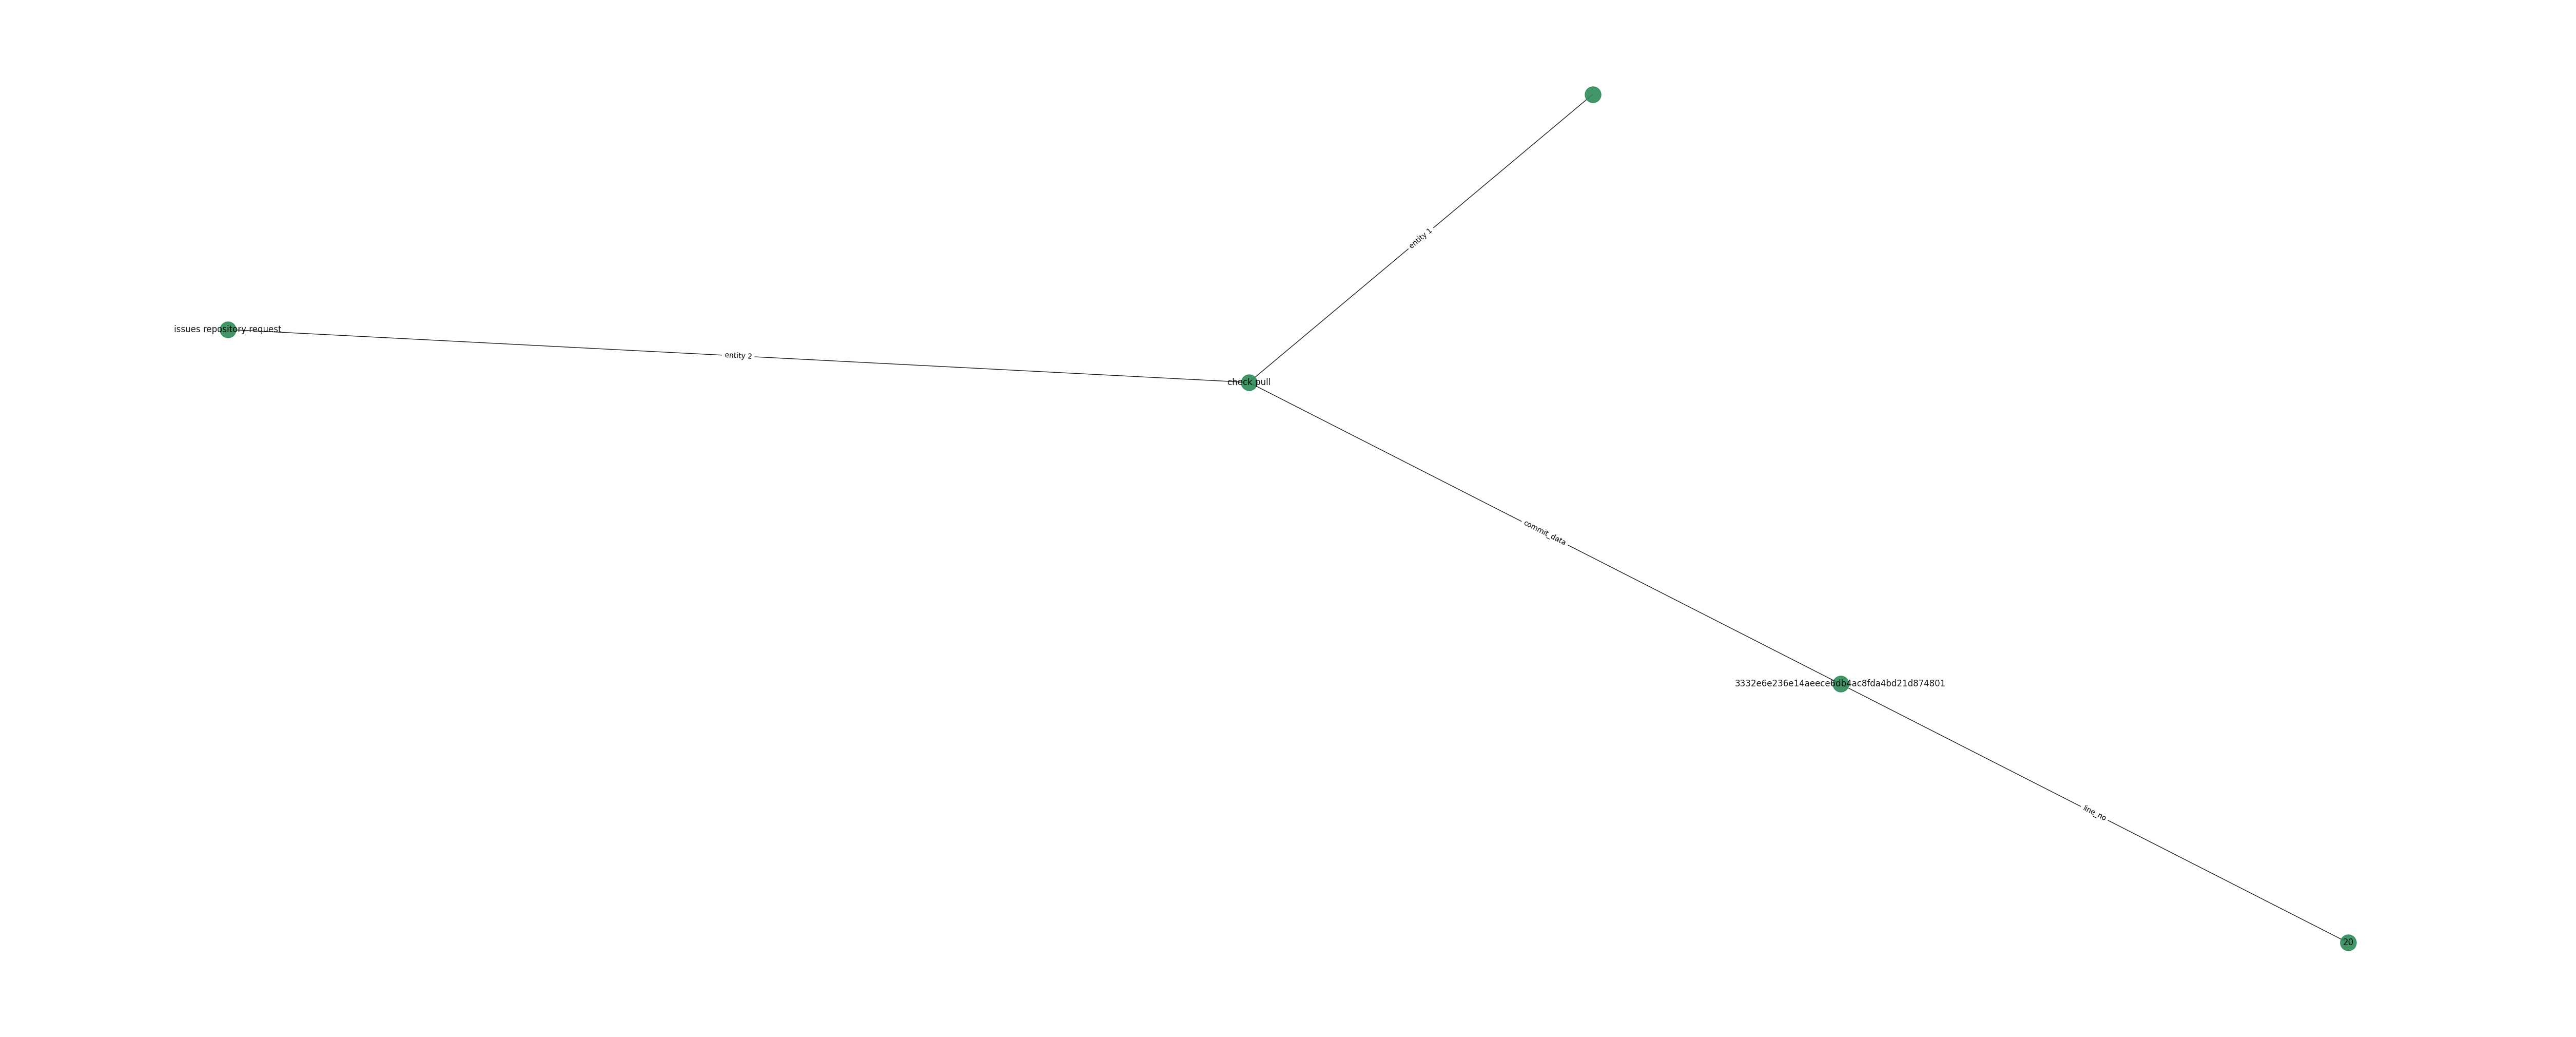

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7b50>
{'', '3332e6e236e14aeece6db4ac8fda4bd21d874801', 'information contributing guidelines](CONTRIBUTING.md', 'more see', 21}


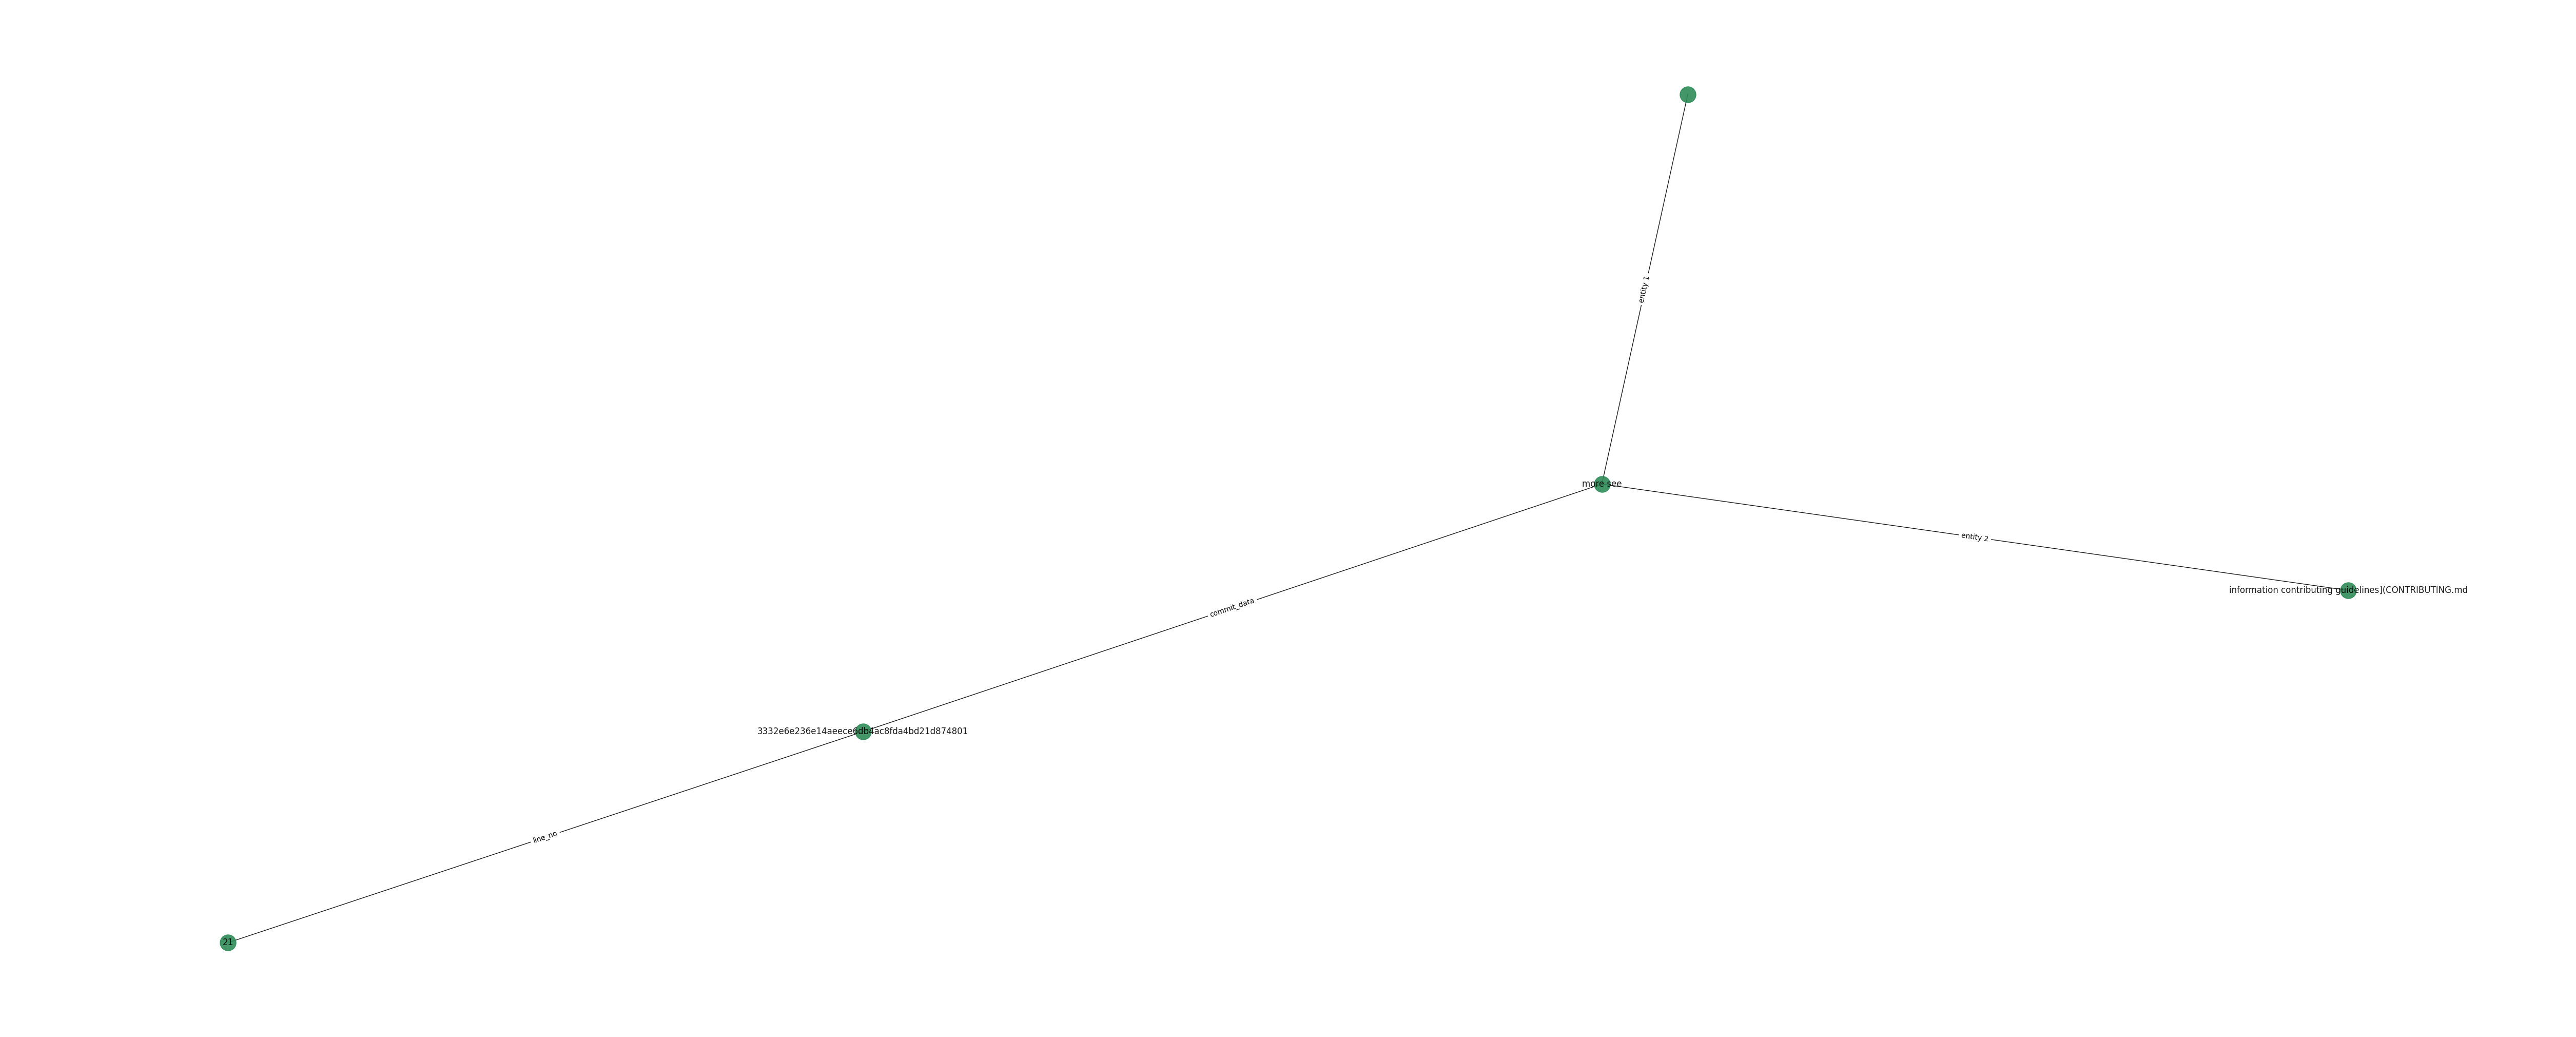

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7bc0>
{'segment manageable relevant optimize', 6, '7bcc9e35dd7111778d501f1f58edae07bb27411a', 'It', 'data chunks embeddings them database retrieval'}


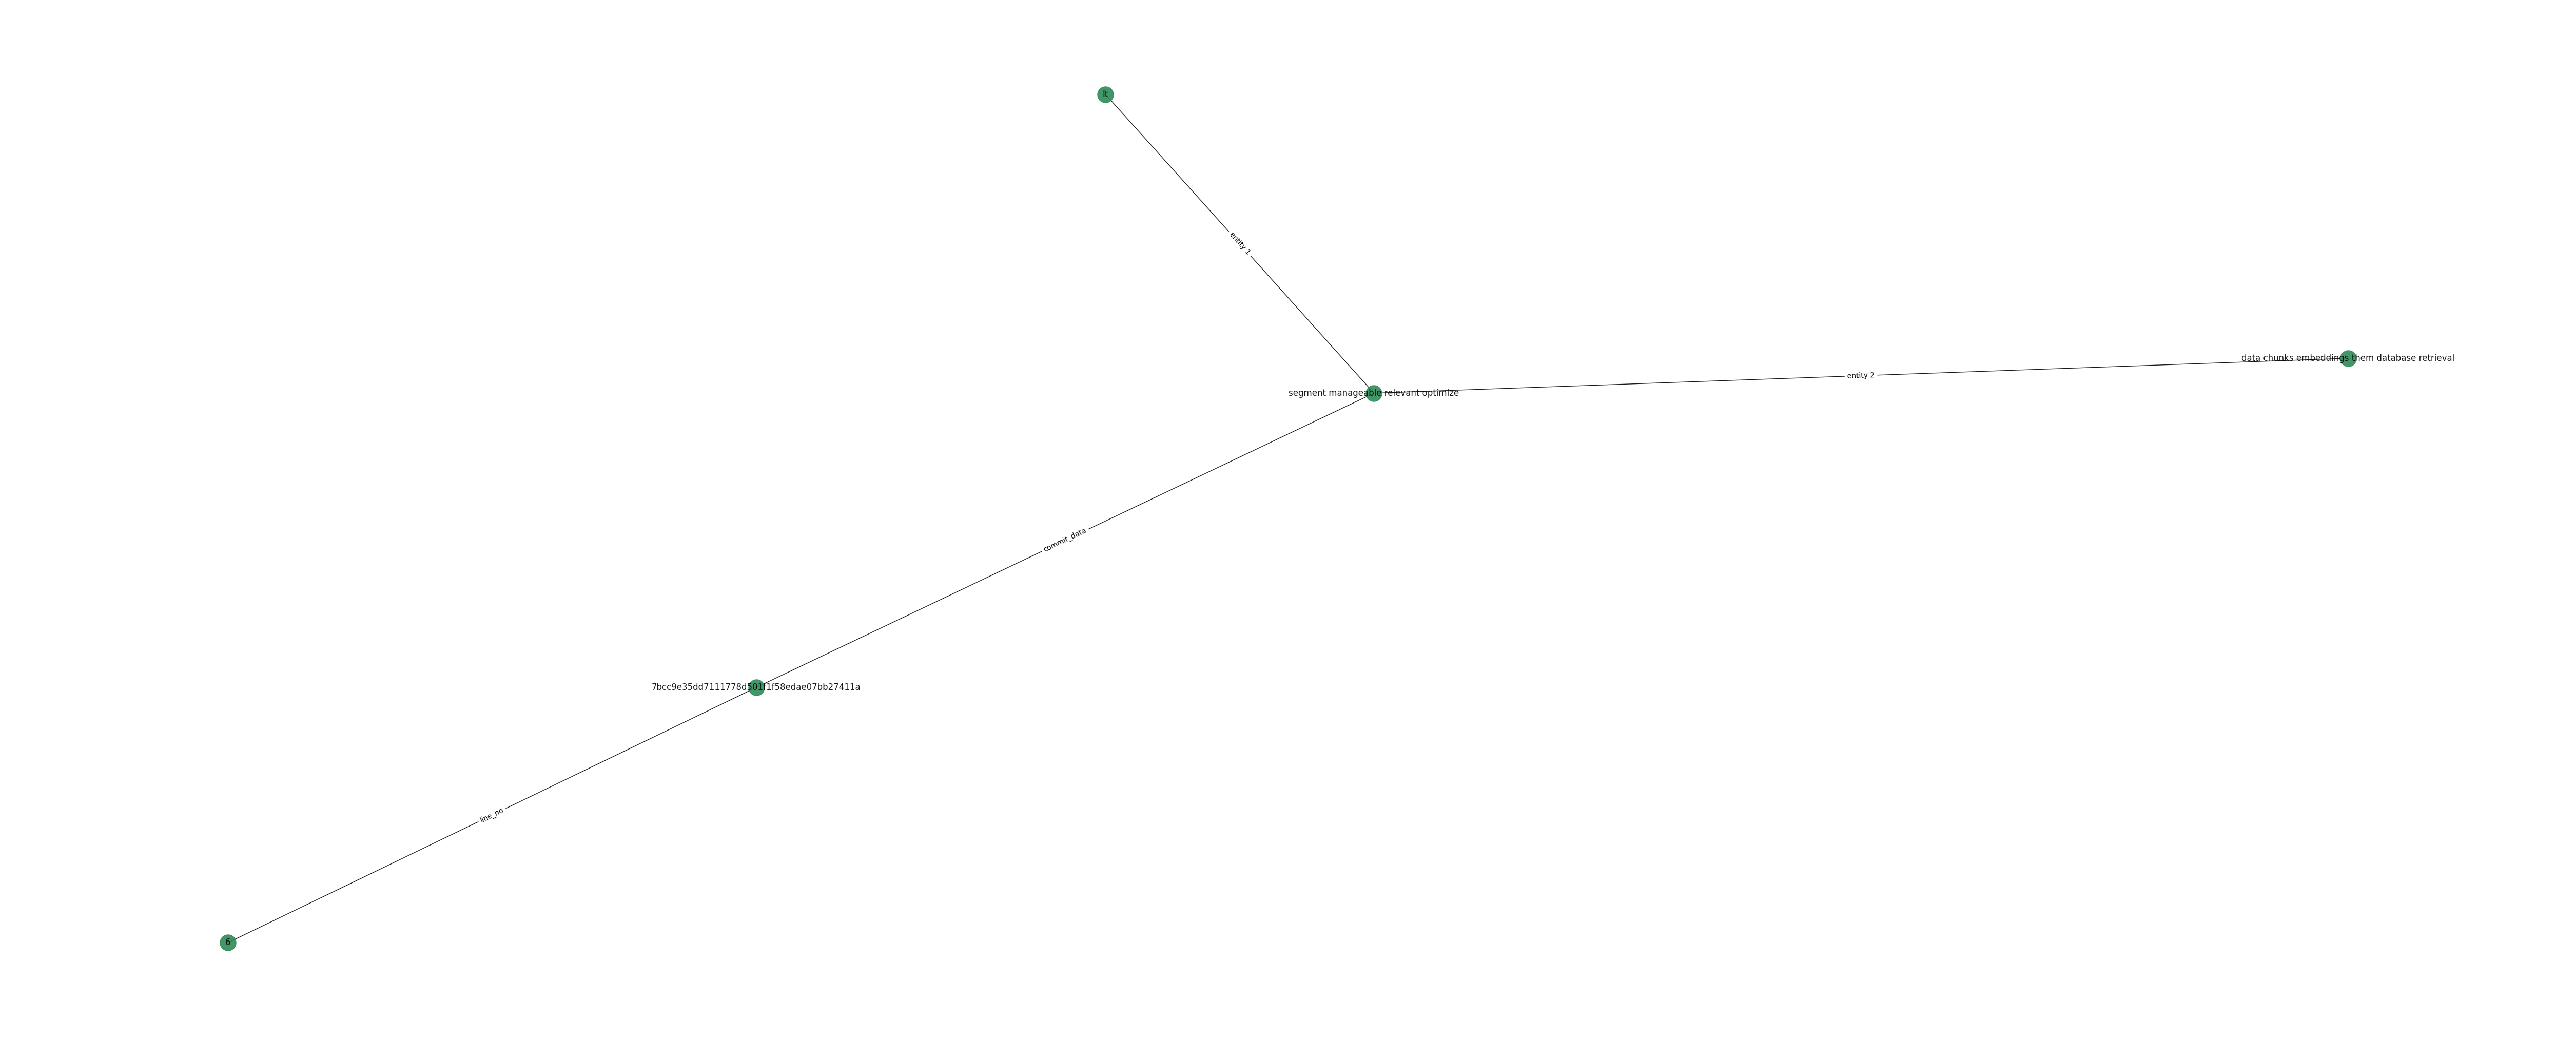

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3840>
{7, '7bcc9e35dd7111778d501f1f58edae07bb27411a', 'suite APIs users information answers conversations all data', 'it', 'diverse enable contextual precise interactive own'}


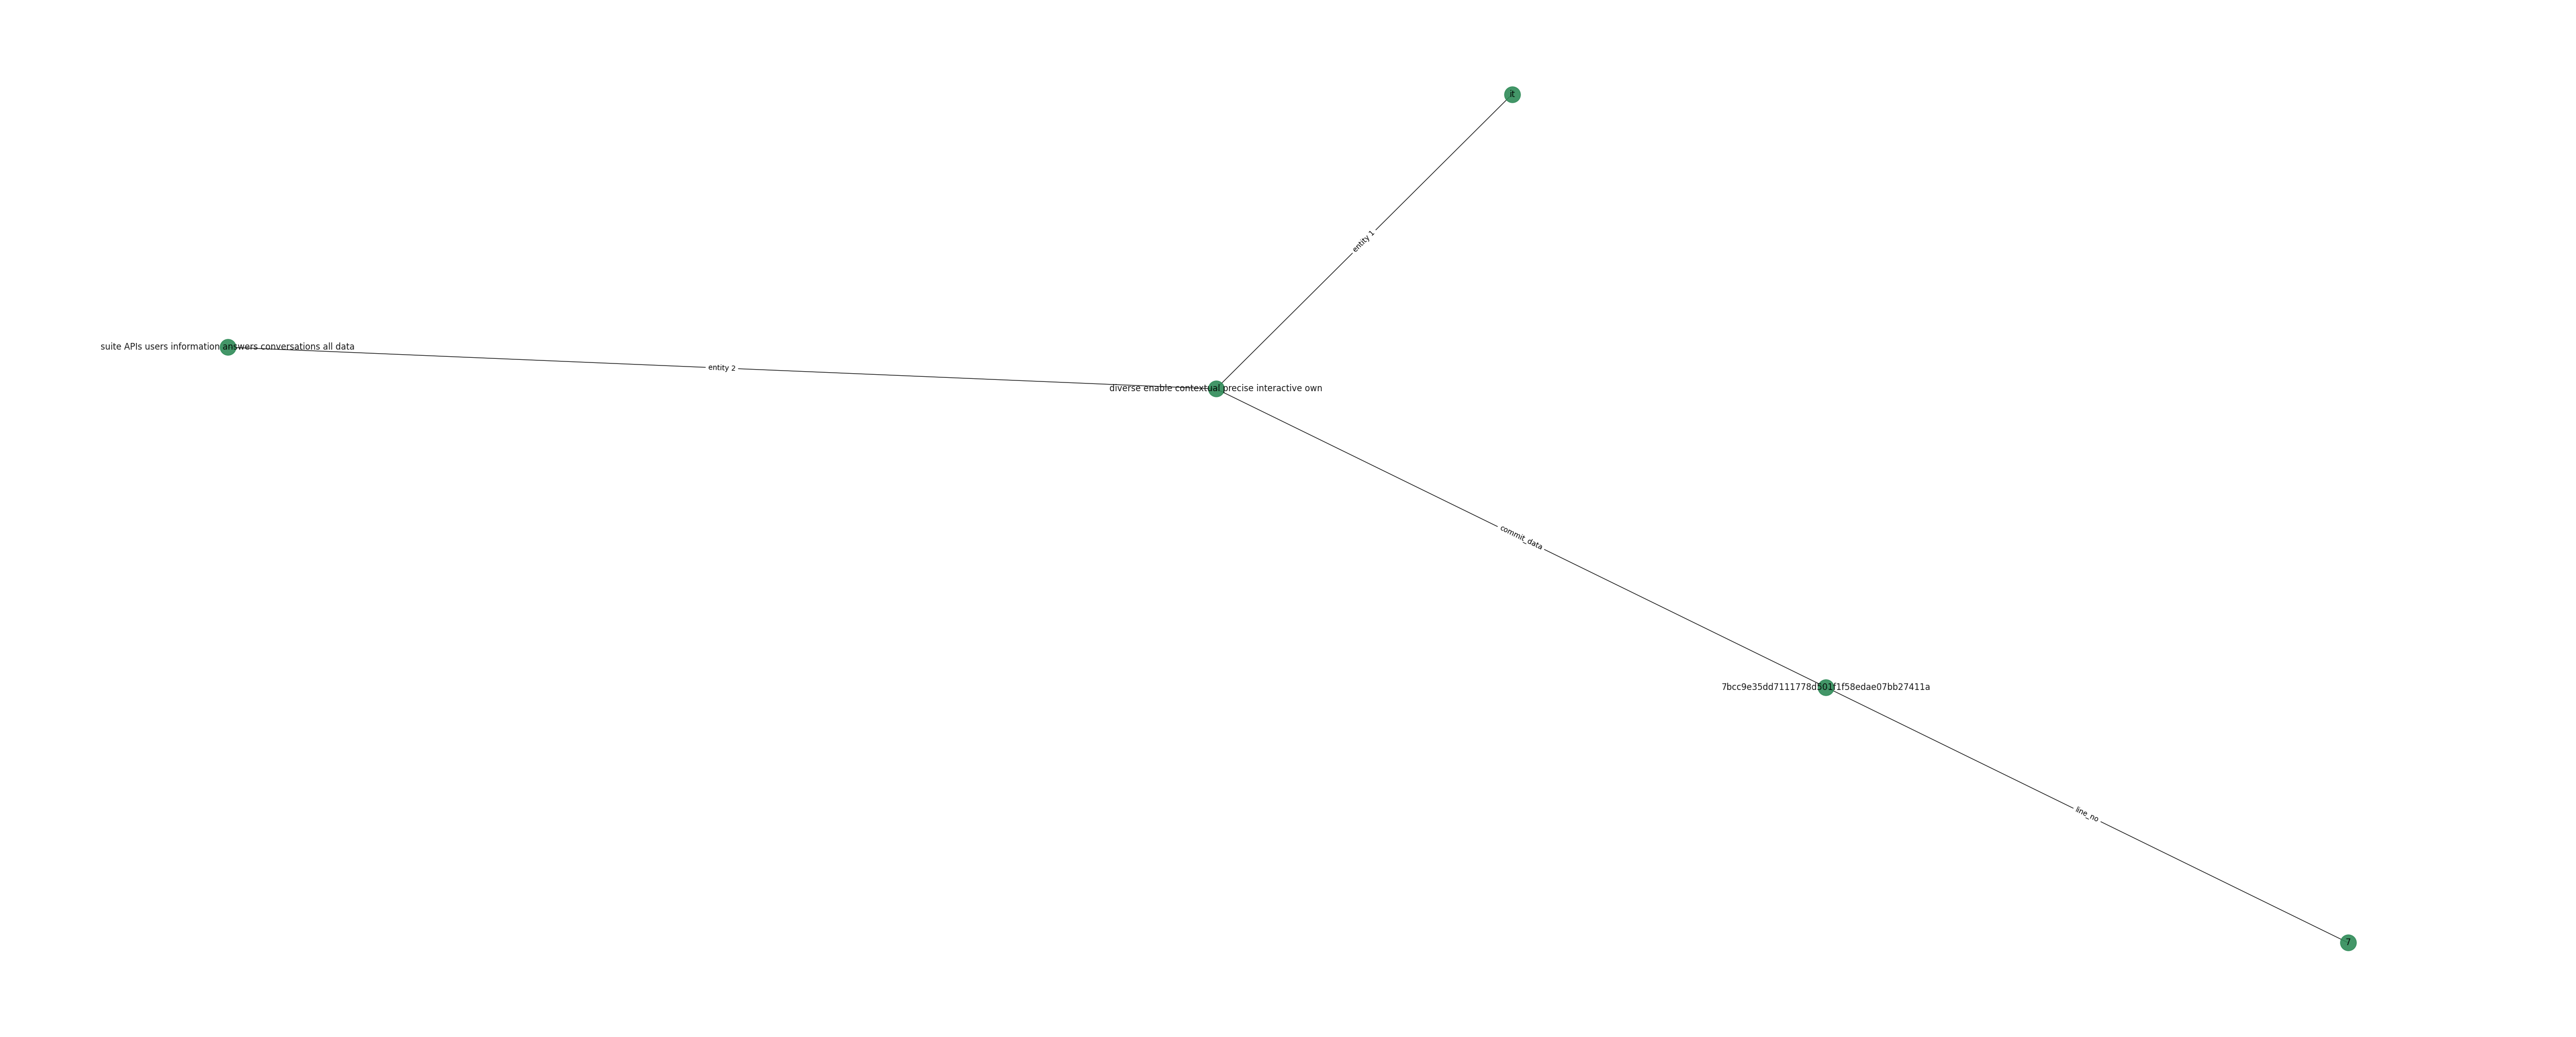

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3840>
{12, '7bcc9e35dd7111778d501f1f58edae07bb27411a', 'Musk', 'answer several', 'companies'}


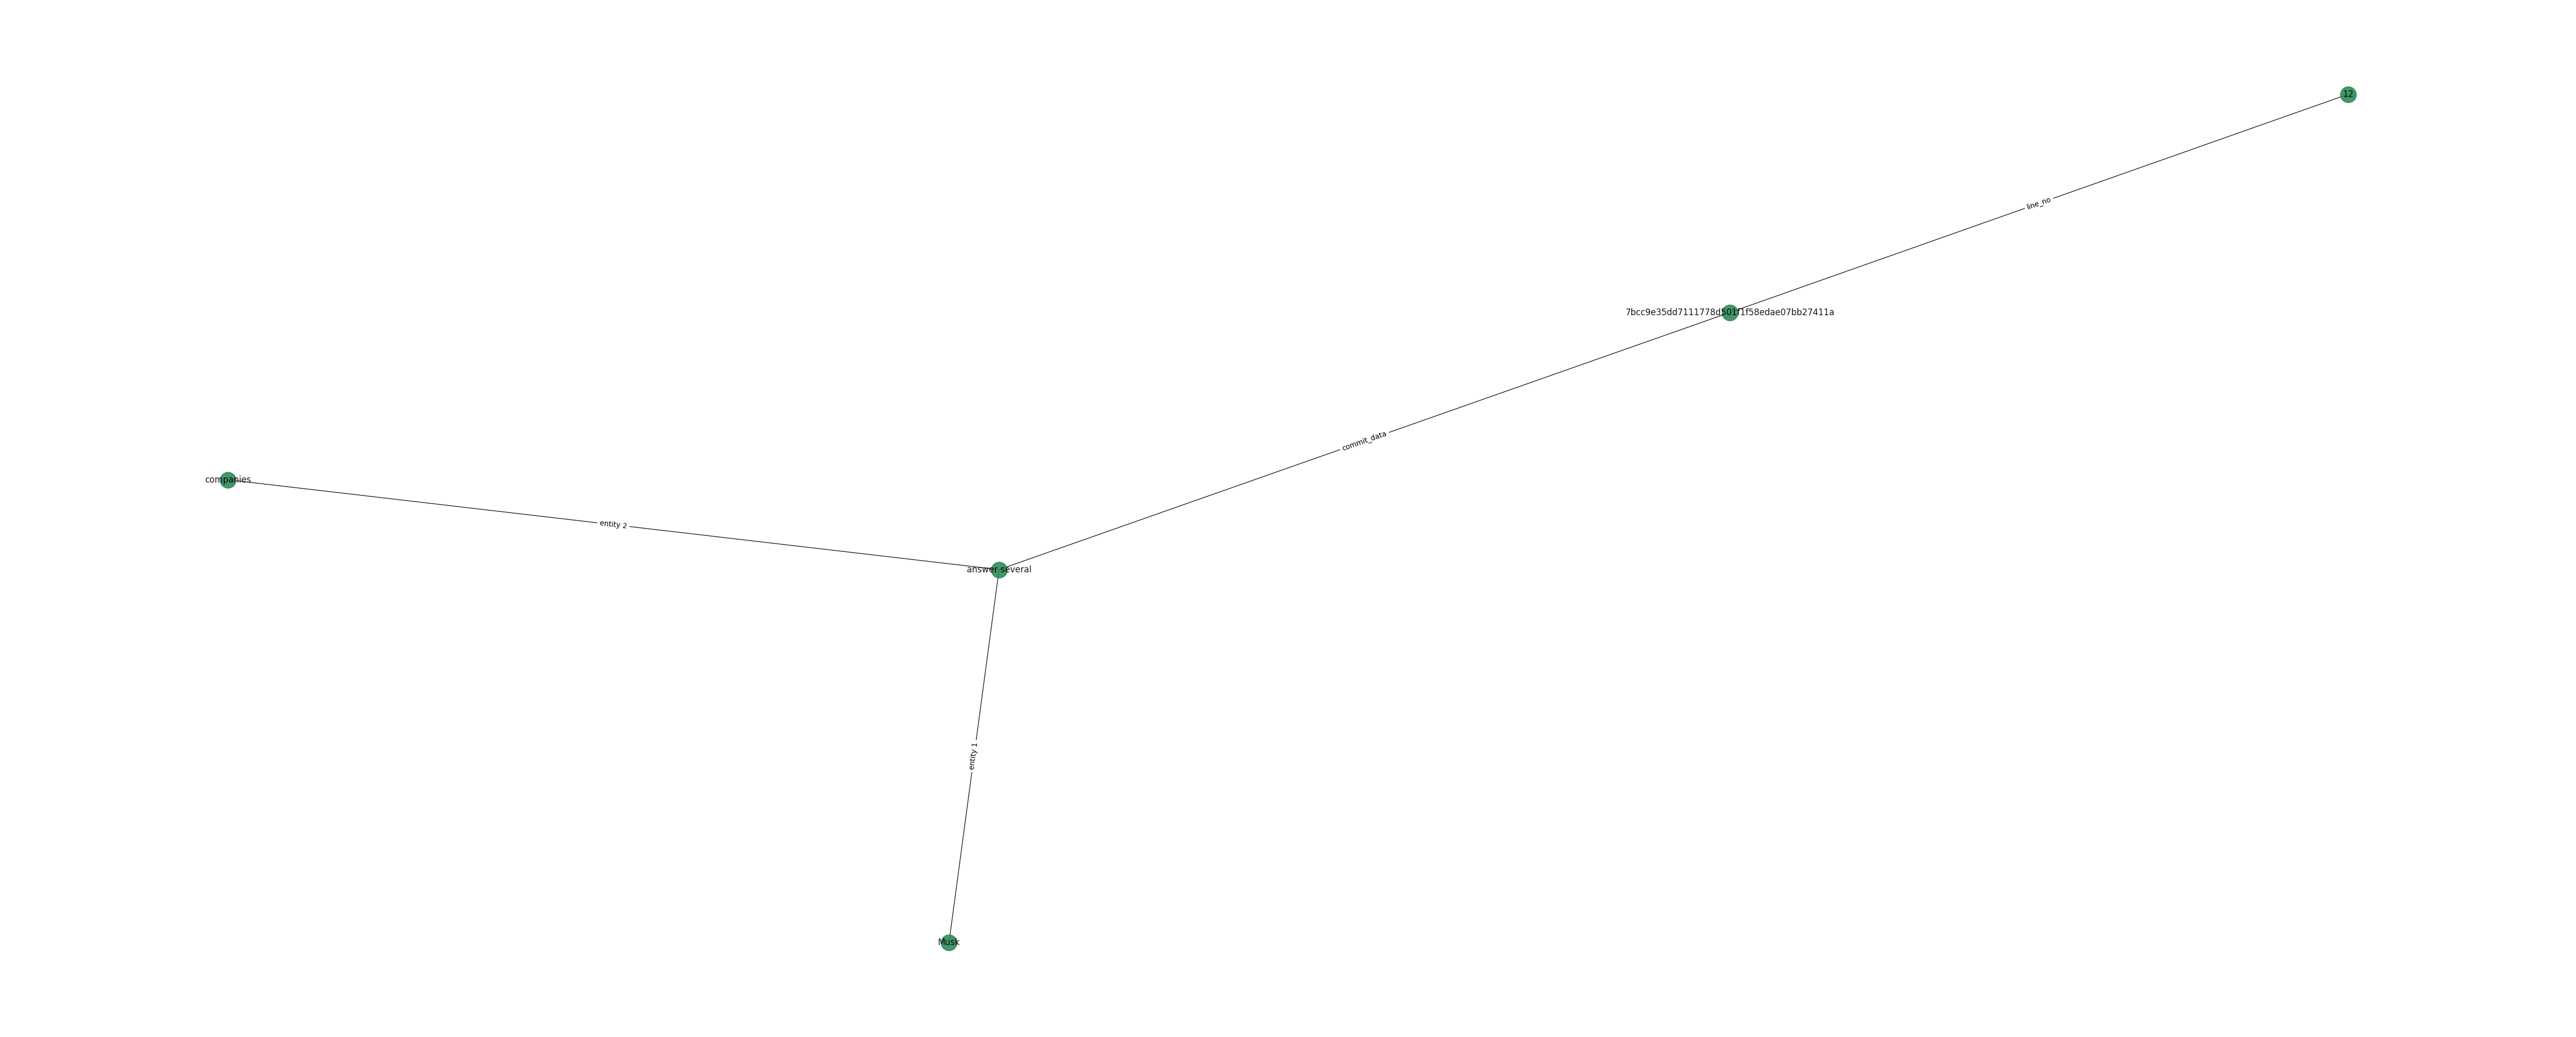

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7a70>
{13, 'he', '7bcc9e35dd7111778d501f1f58edae07bb27411a', 'knowledge SpaceX Tesla Neuralink Company', 'be designer'}


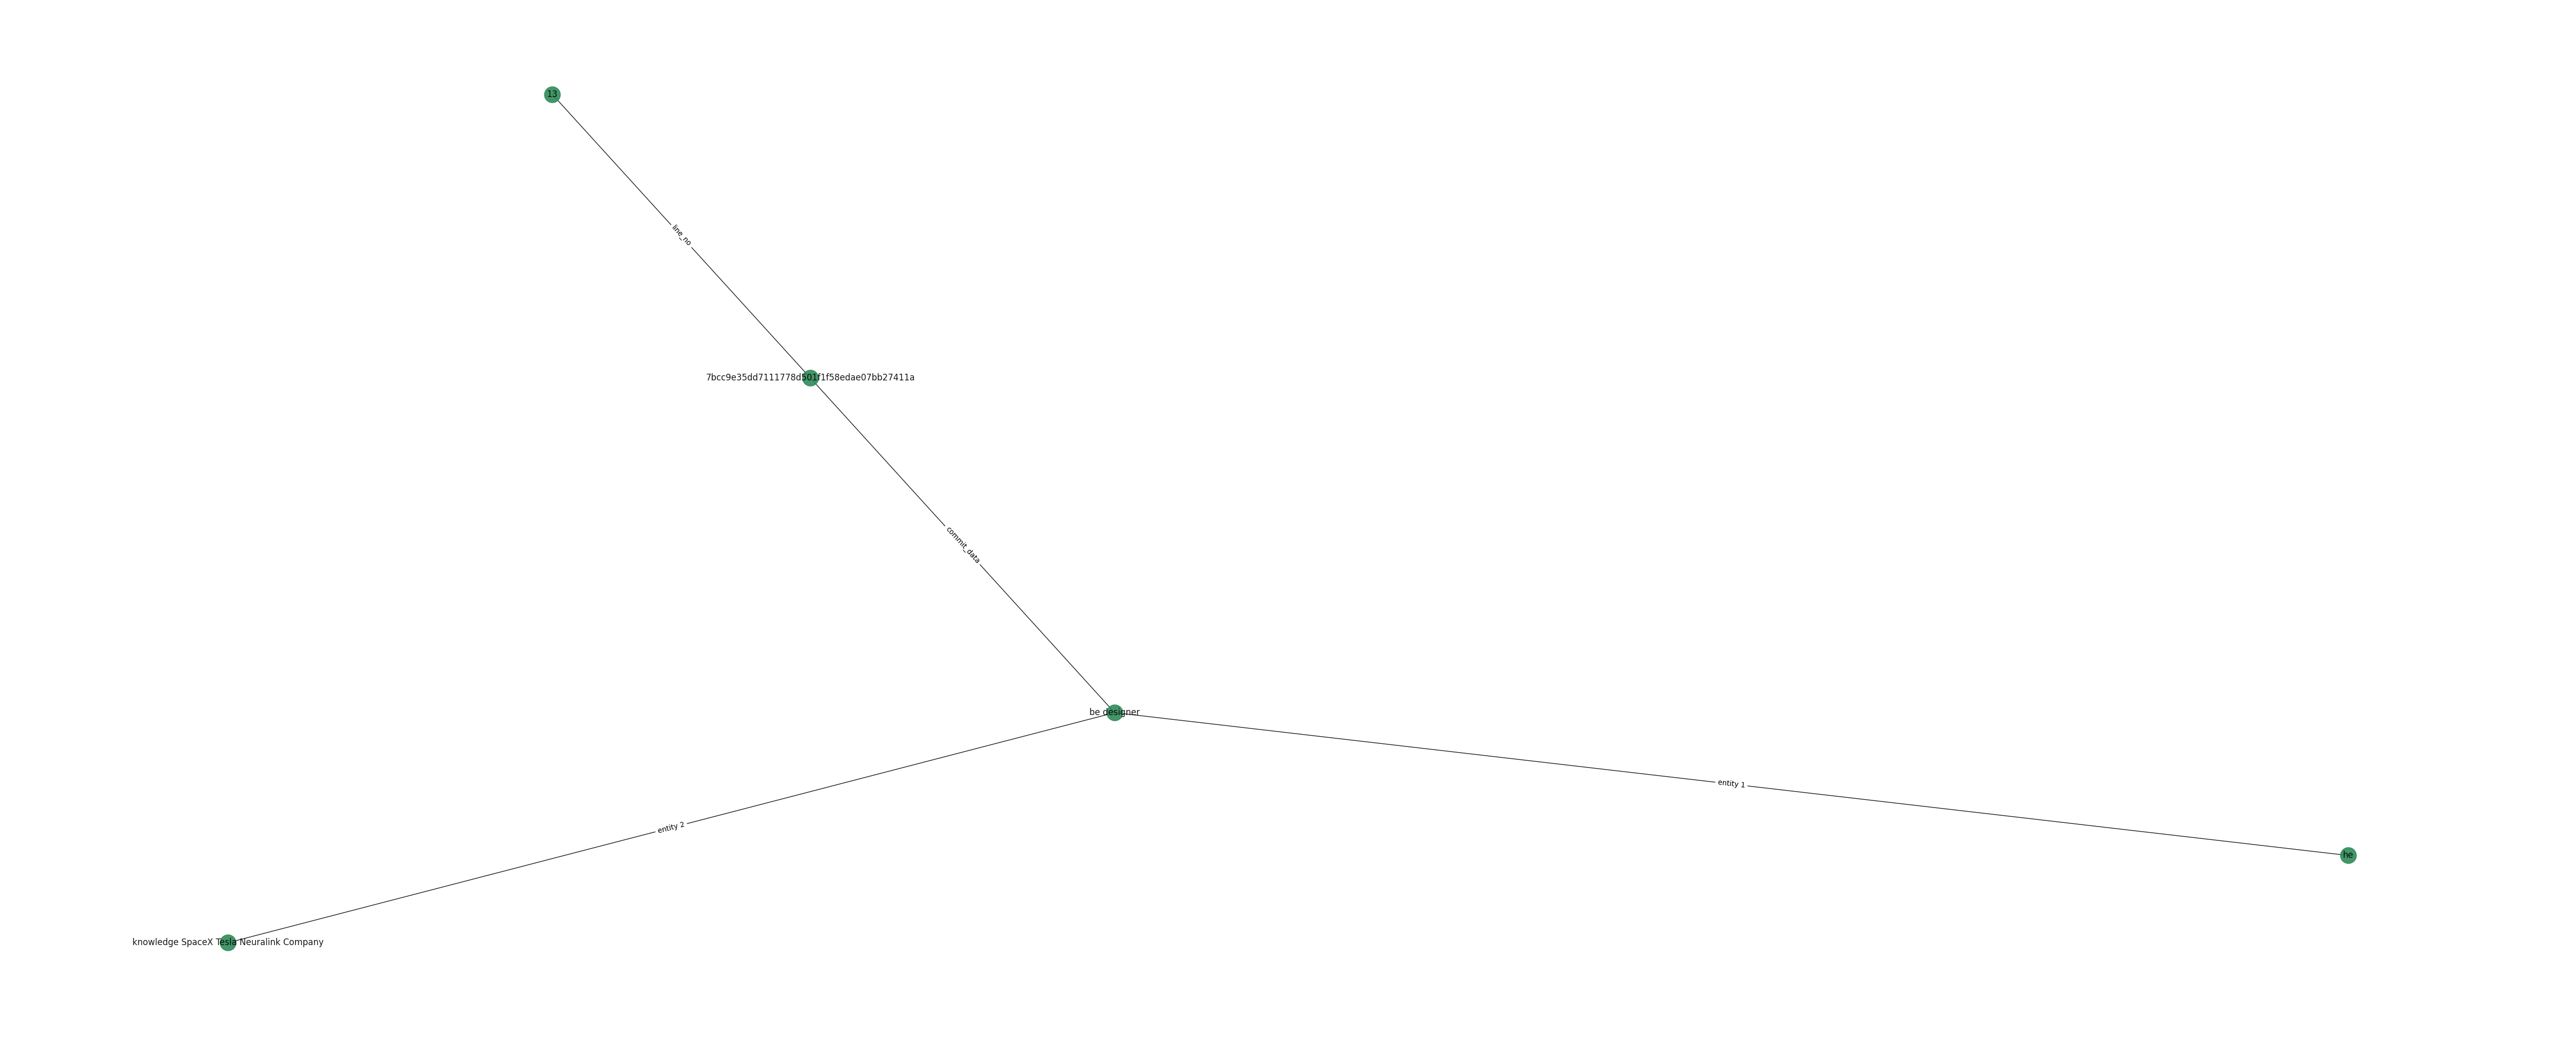

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7a70>
{'information it', 14, '7bcc9e35dd7111778d501f1f58edae07bb27411a', 'time updates', 'note late'}


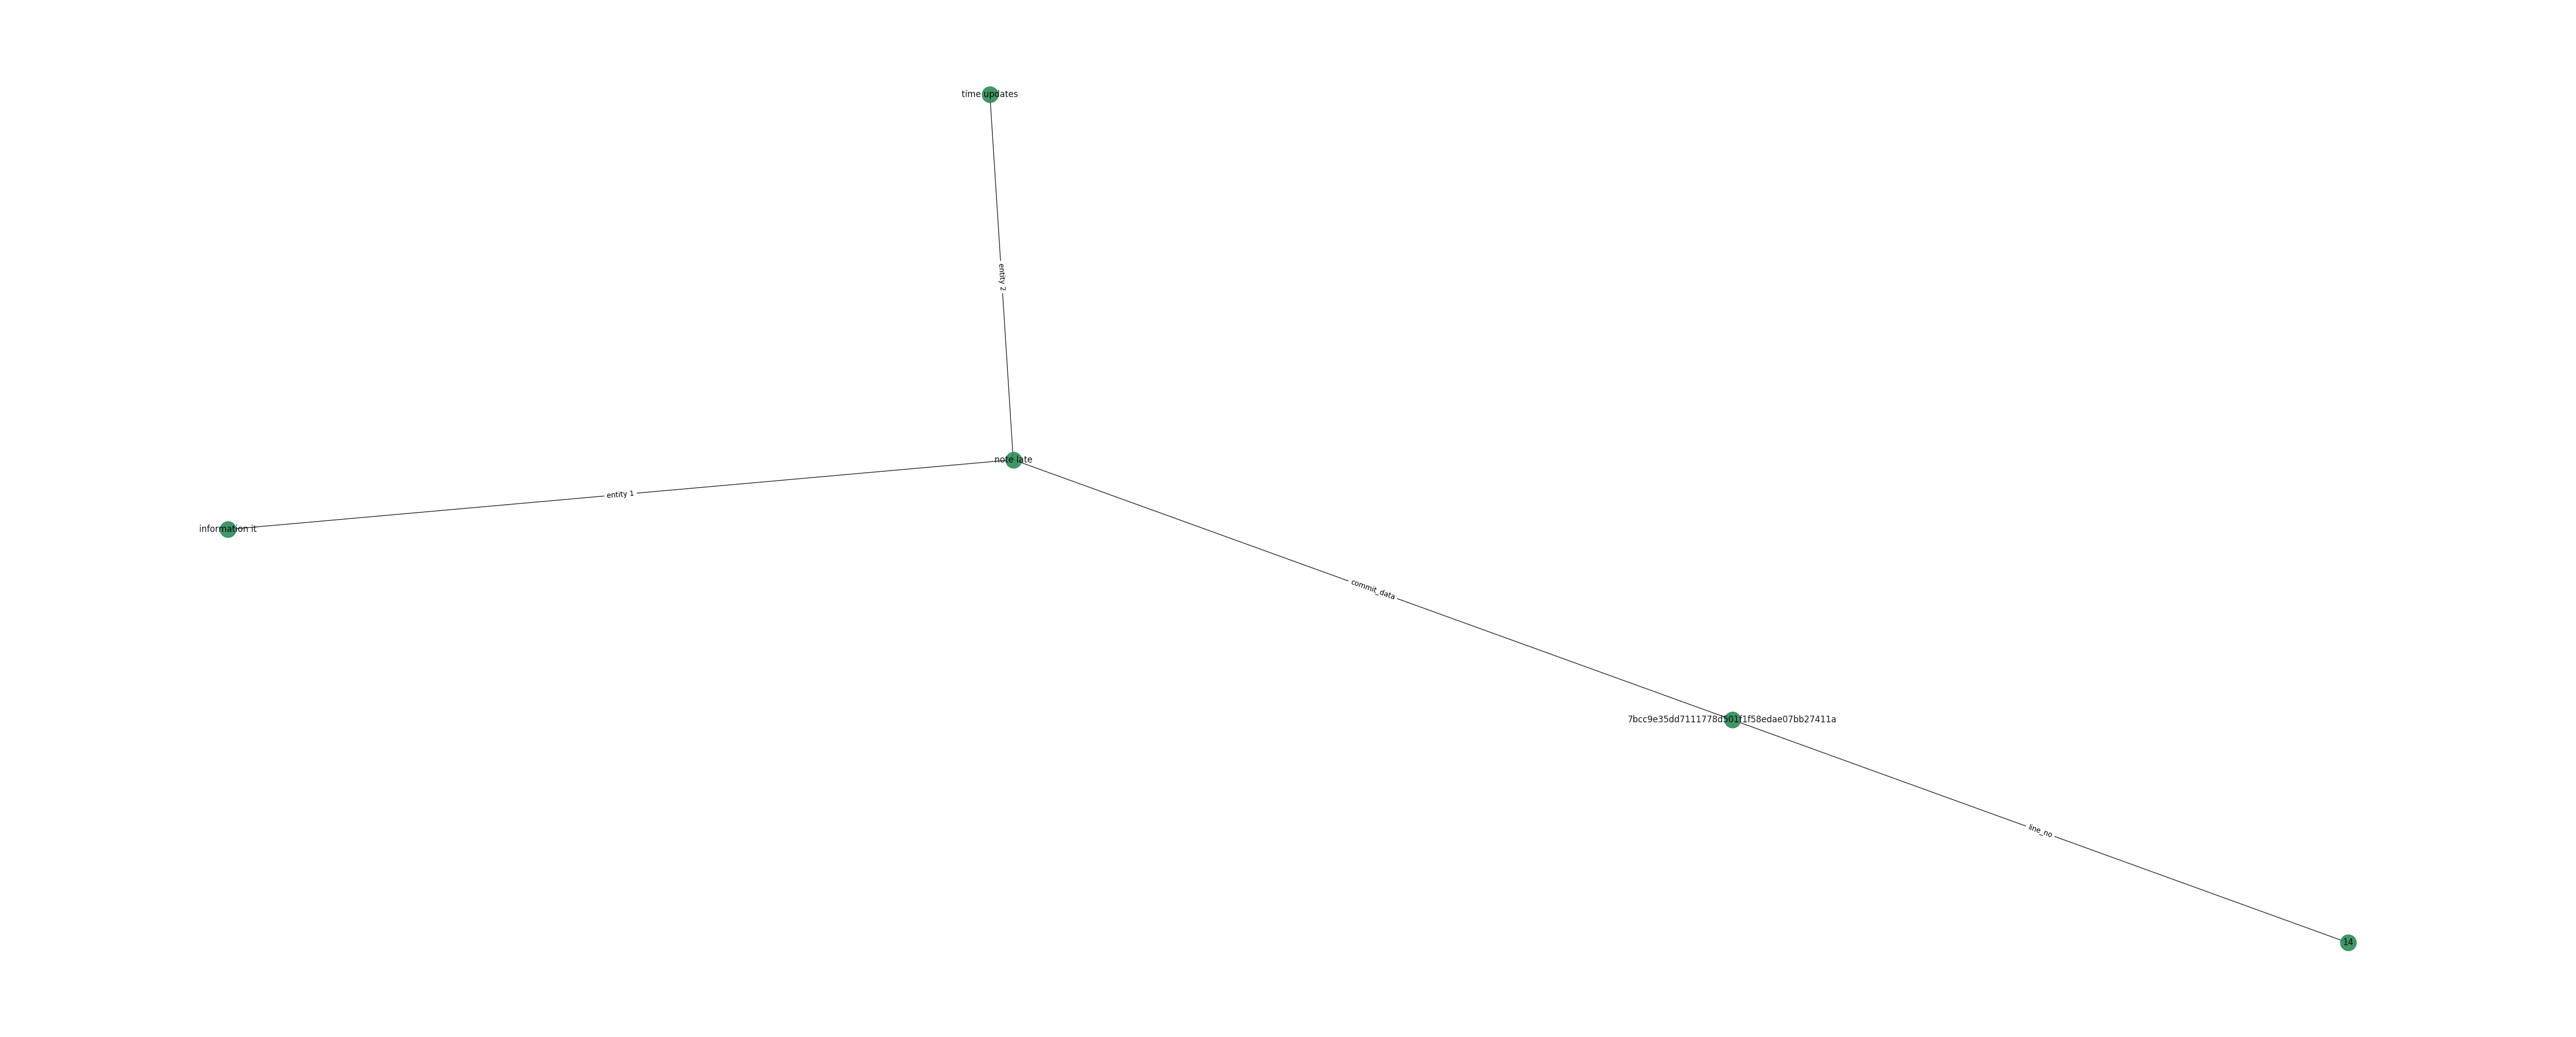

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a23b0>
{'data us', '7bcc9e35dd7111778d501f1f58edae07bb27411a', 'help', 'improvements compatibility', 25}


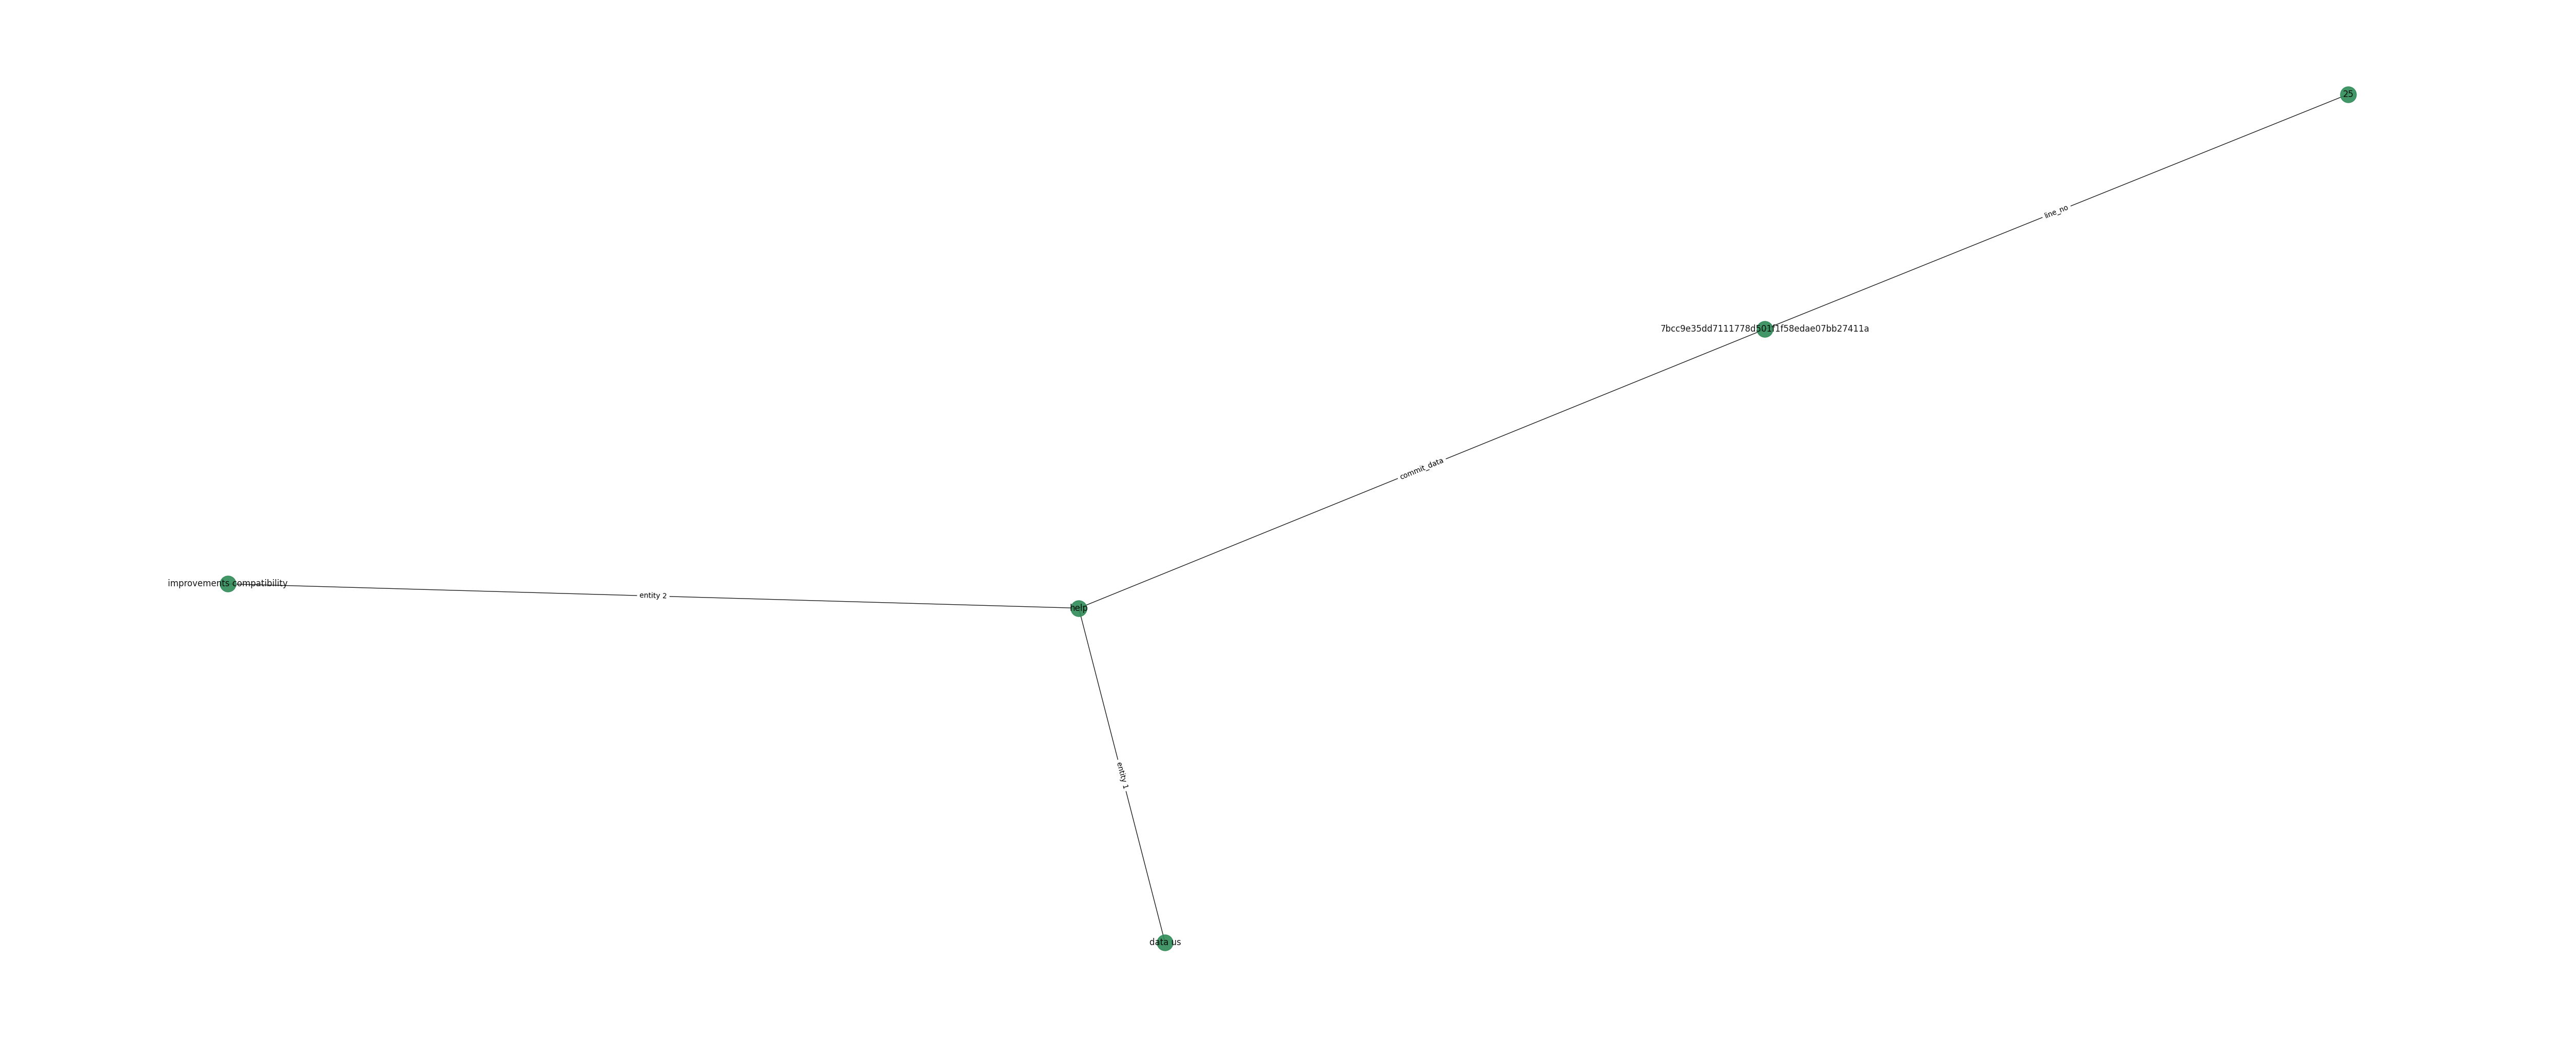

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a23b0>
{'data us', '7bcc9e35dd7111778d501f1f58edae07bb27411a', 'help', 'improvements compatibility', 25}


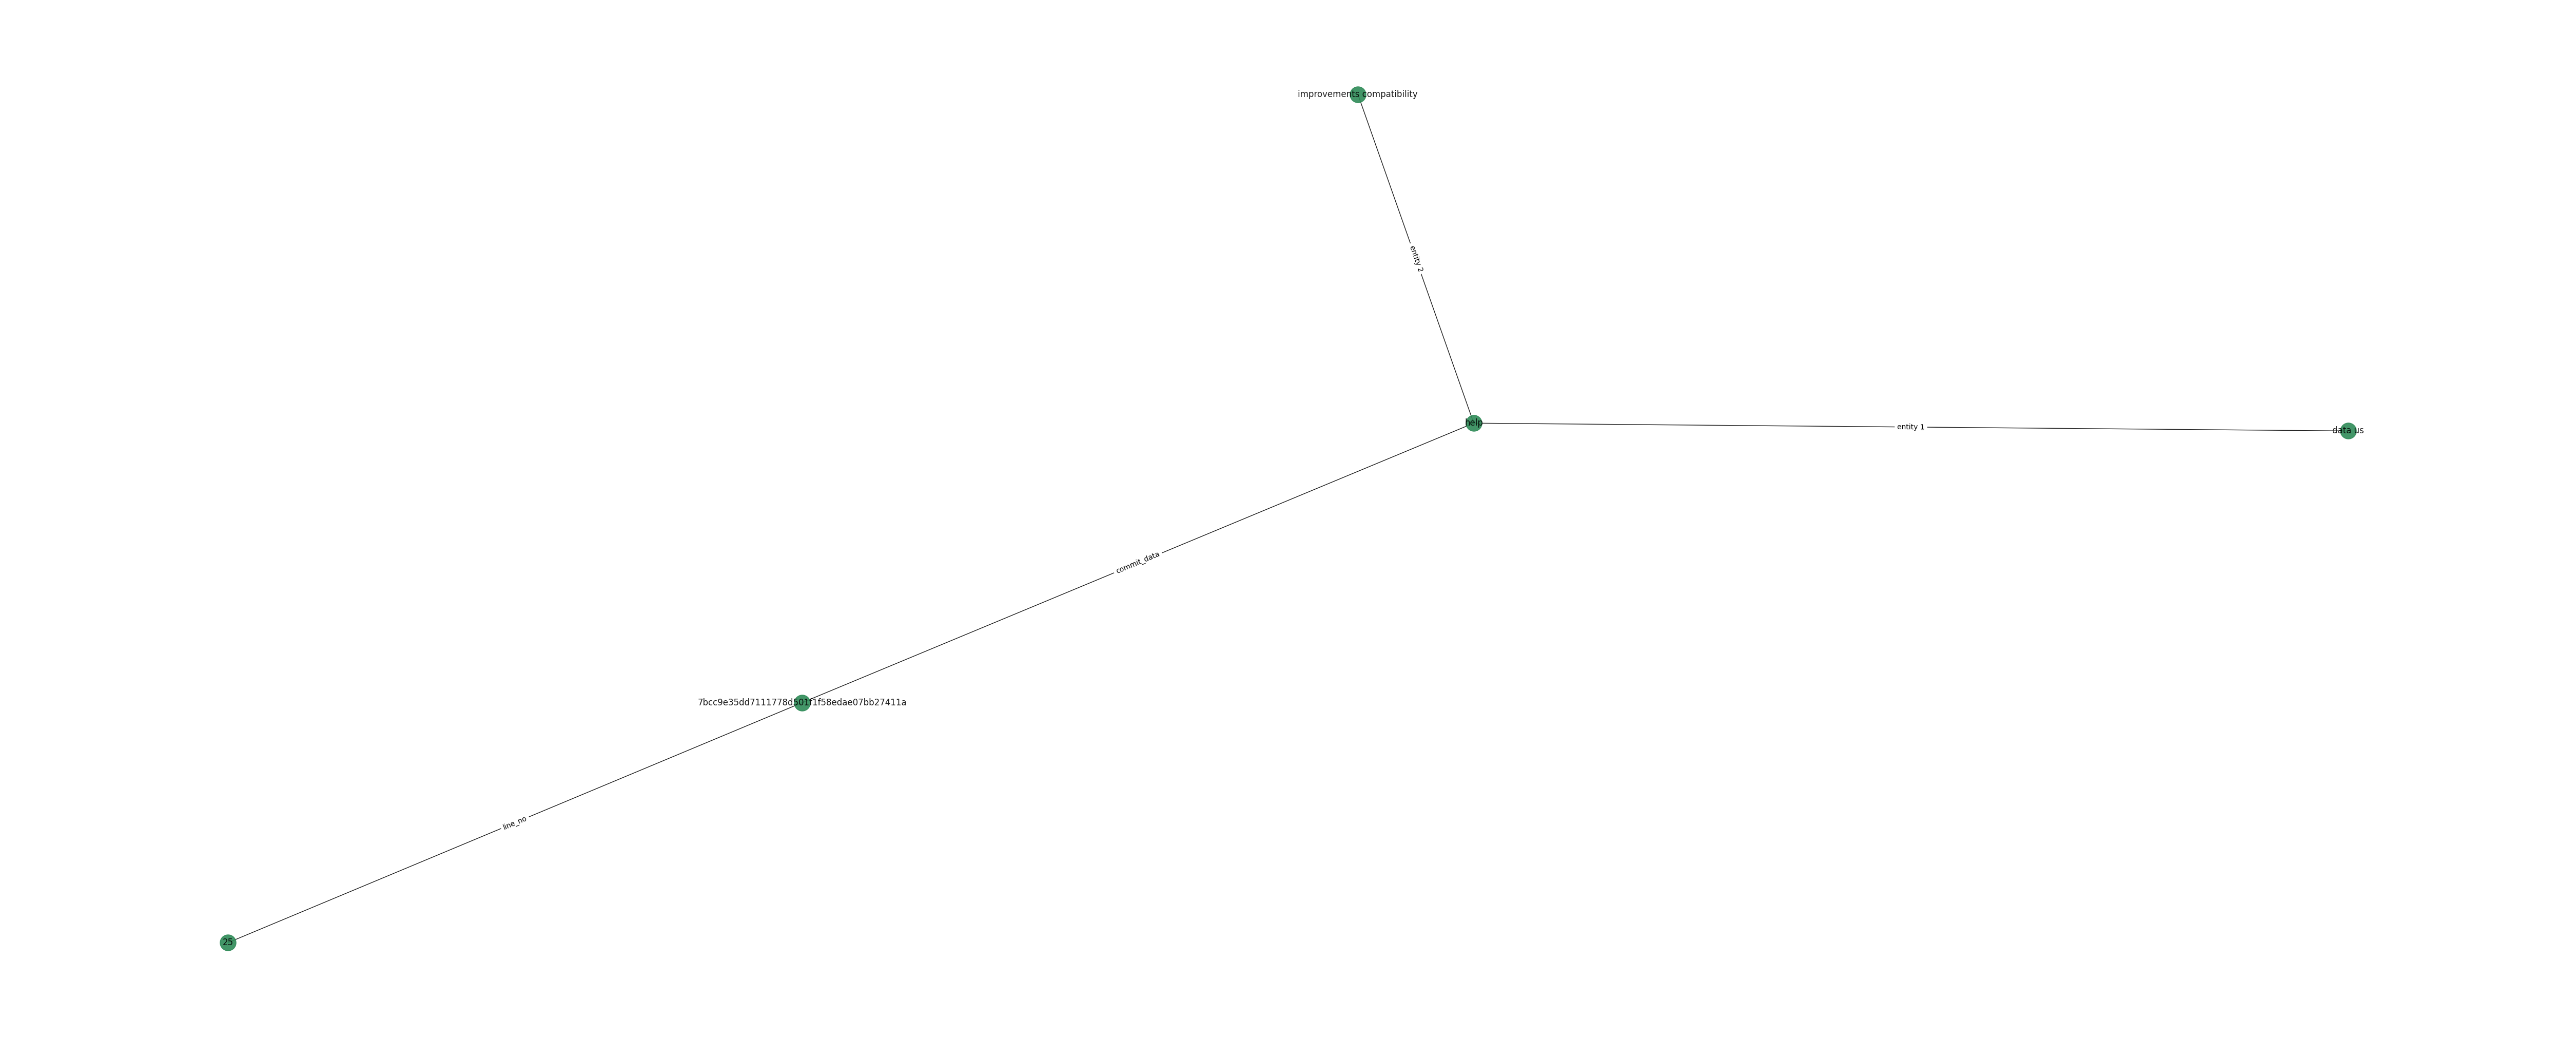

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b6260>
{'segment manageable relevant optimize', '43926fb527869b82b6dfc61afd3c04f31ffb9f6f', 6, 'It', 'data chunks embeddings them database retrieval'}


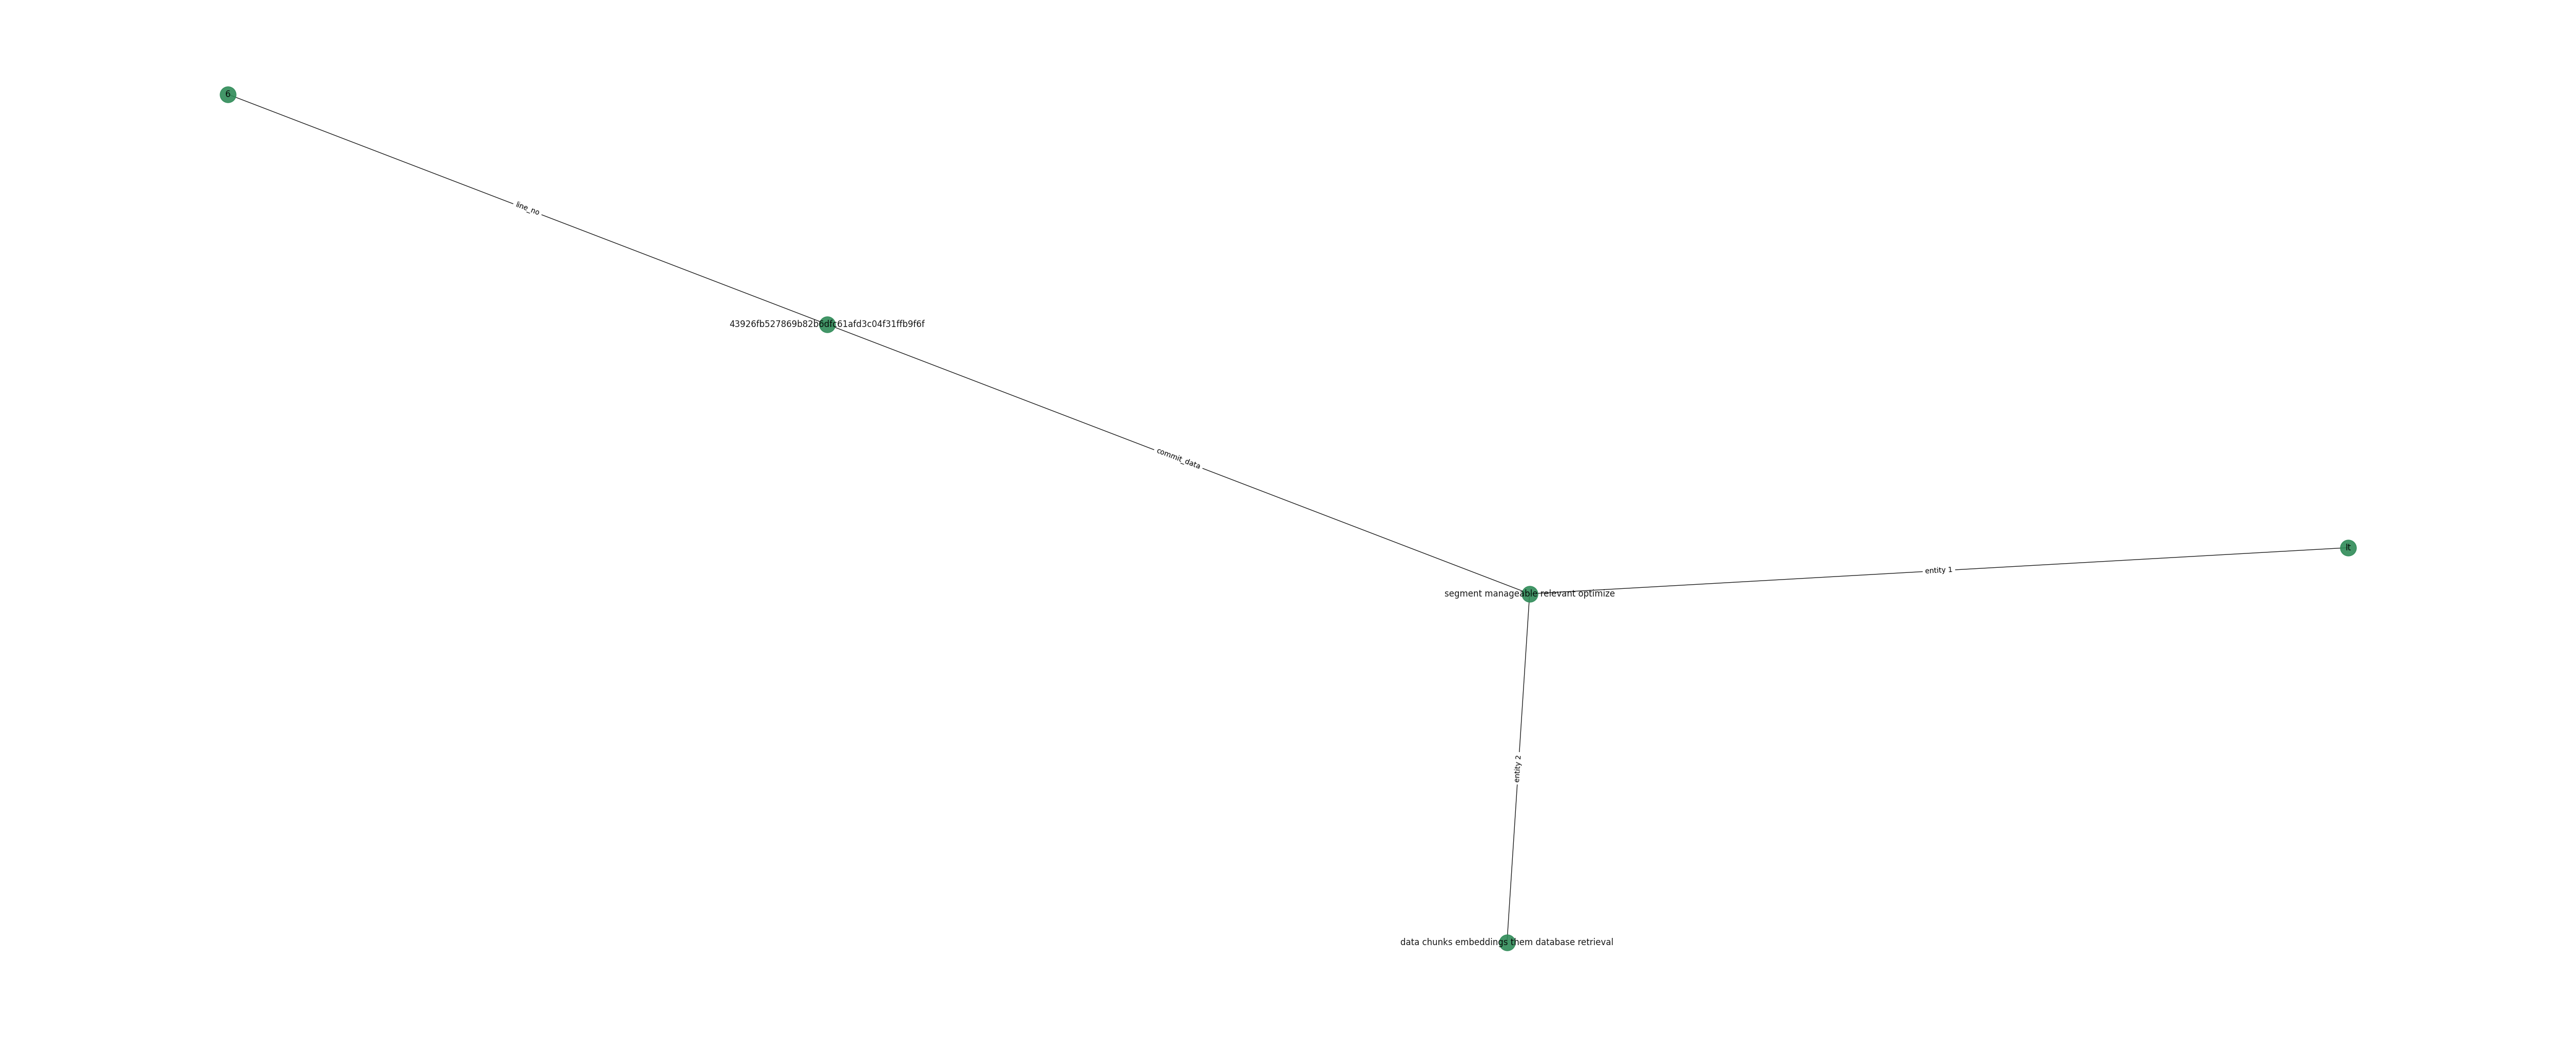

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a36f0>
{'43926fb527869b82b6dfc61afd3c04f31ffb9f6f', 7, 'suite APIs users information answers conversations all data', 'it', 'diverse enable contextual precise interactive own'}


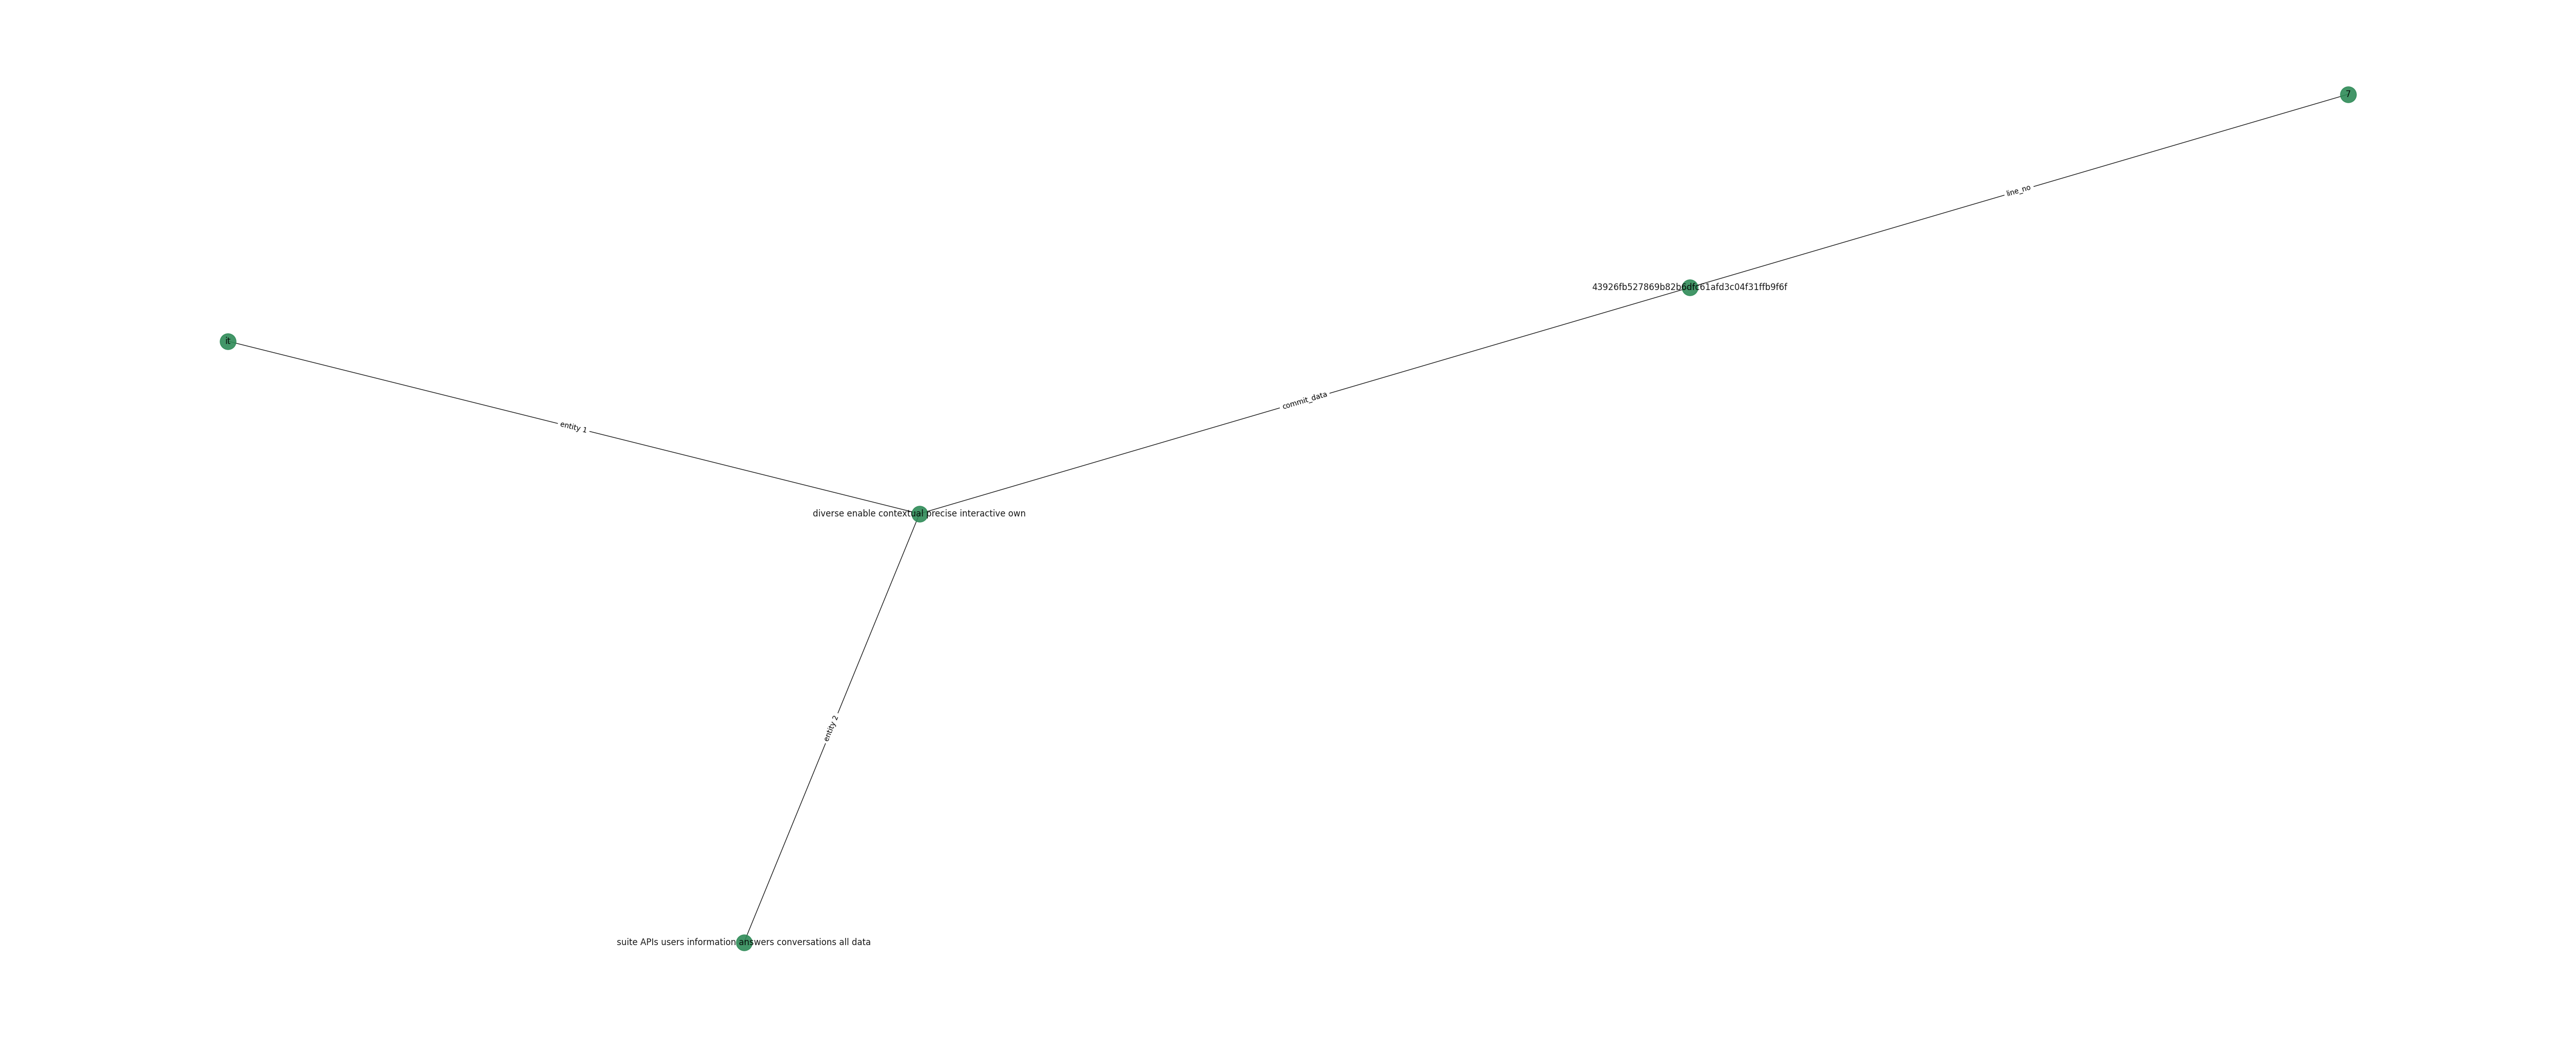

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3450>
{'', 10, 'Usage', '43926fb527869b82b6dfc61afd3c04f31ffb9f6f'}


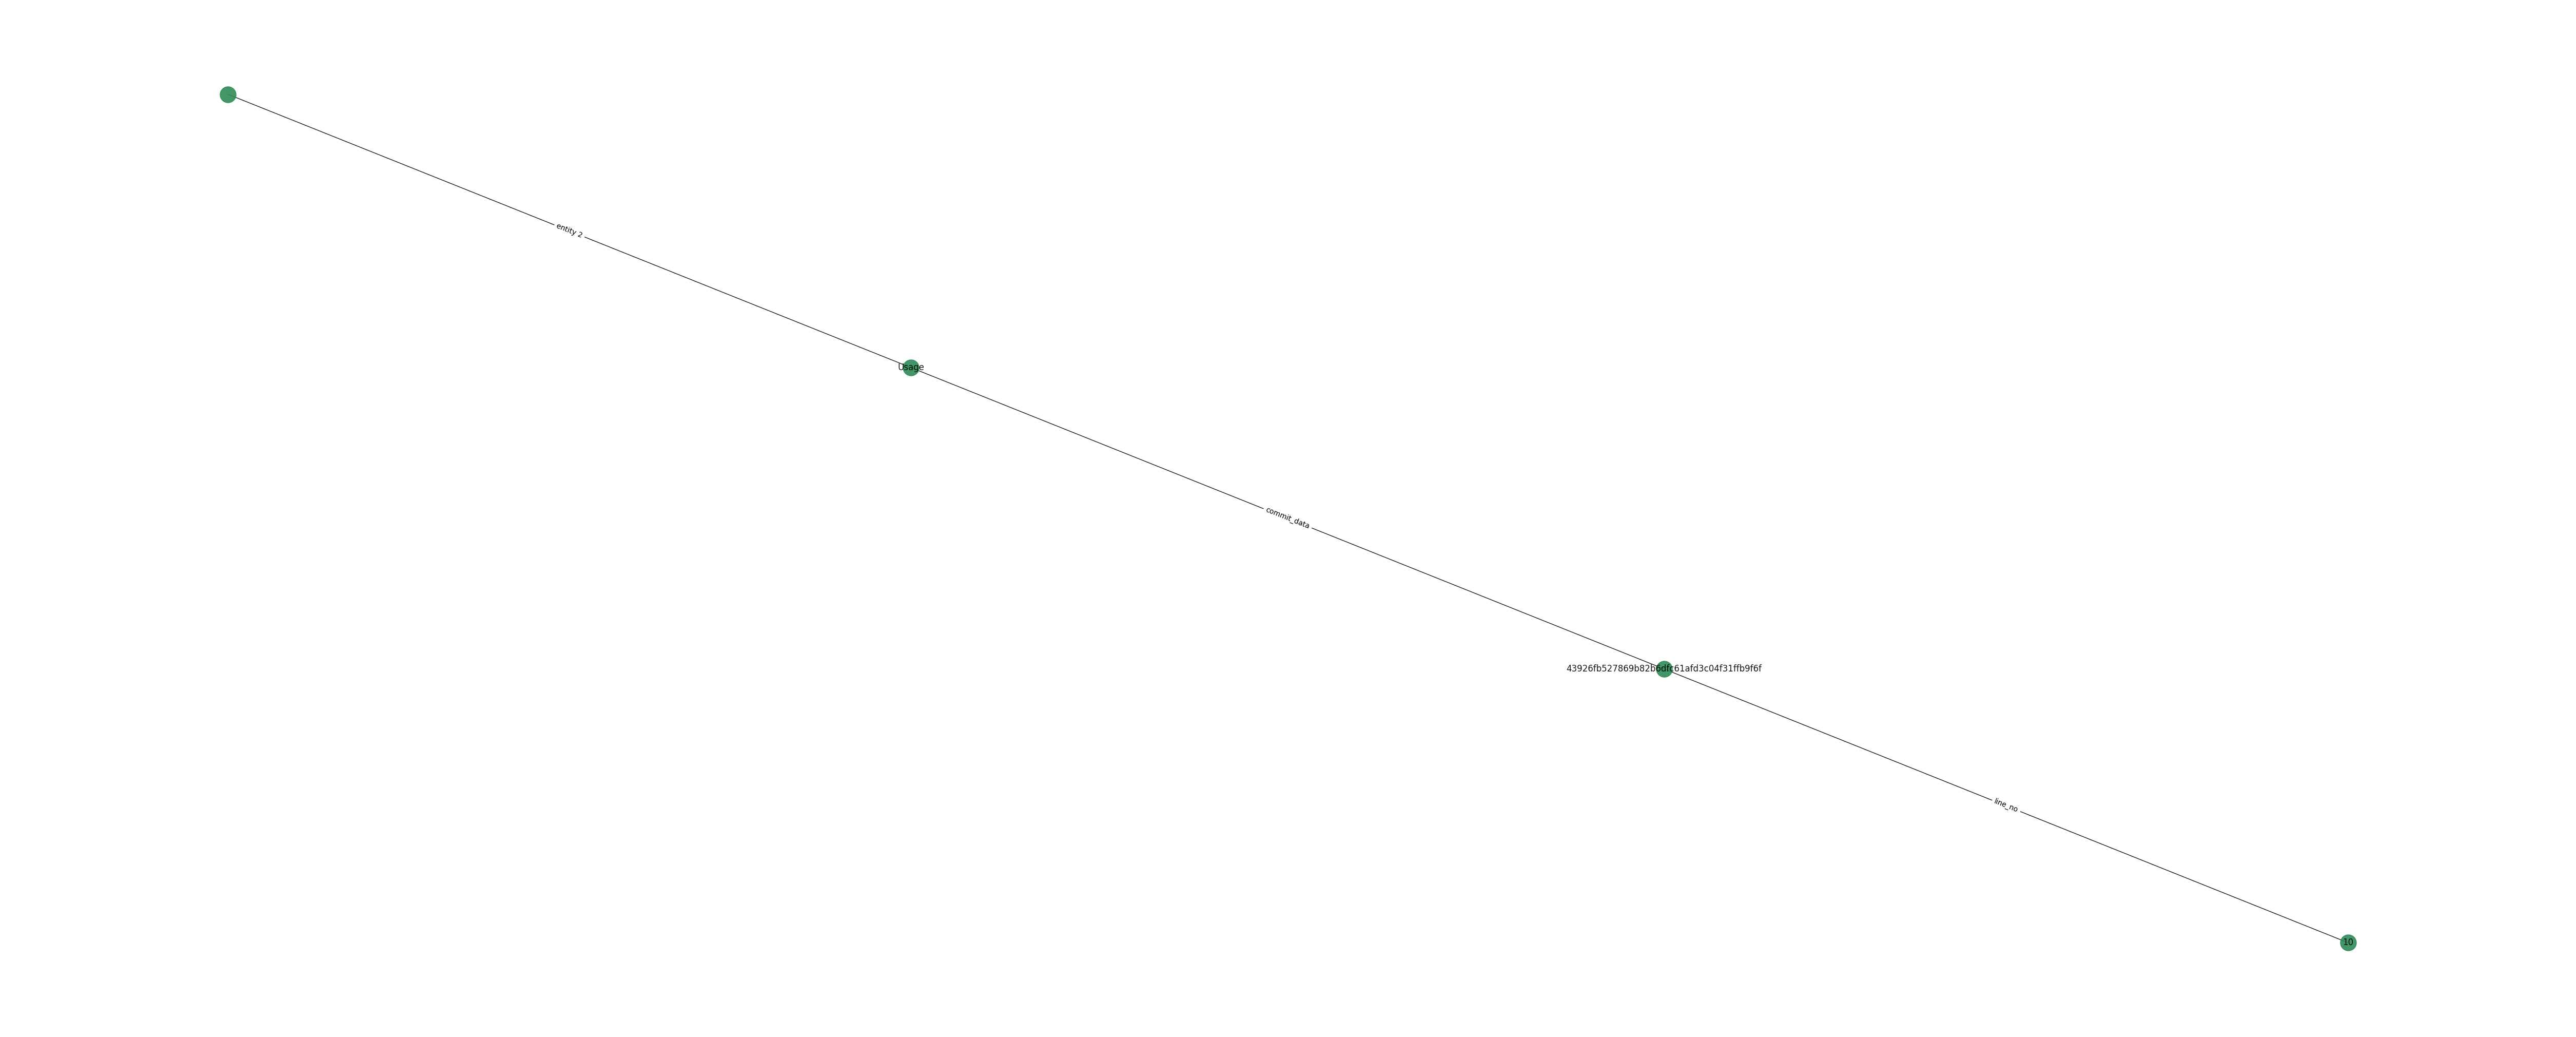

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3450>
{'', '43926fb527869b82b6dfc61afd3c04f31ffb9f6f', 'discussions questions experiences', 17, 'dive'}


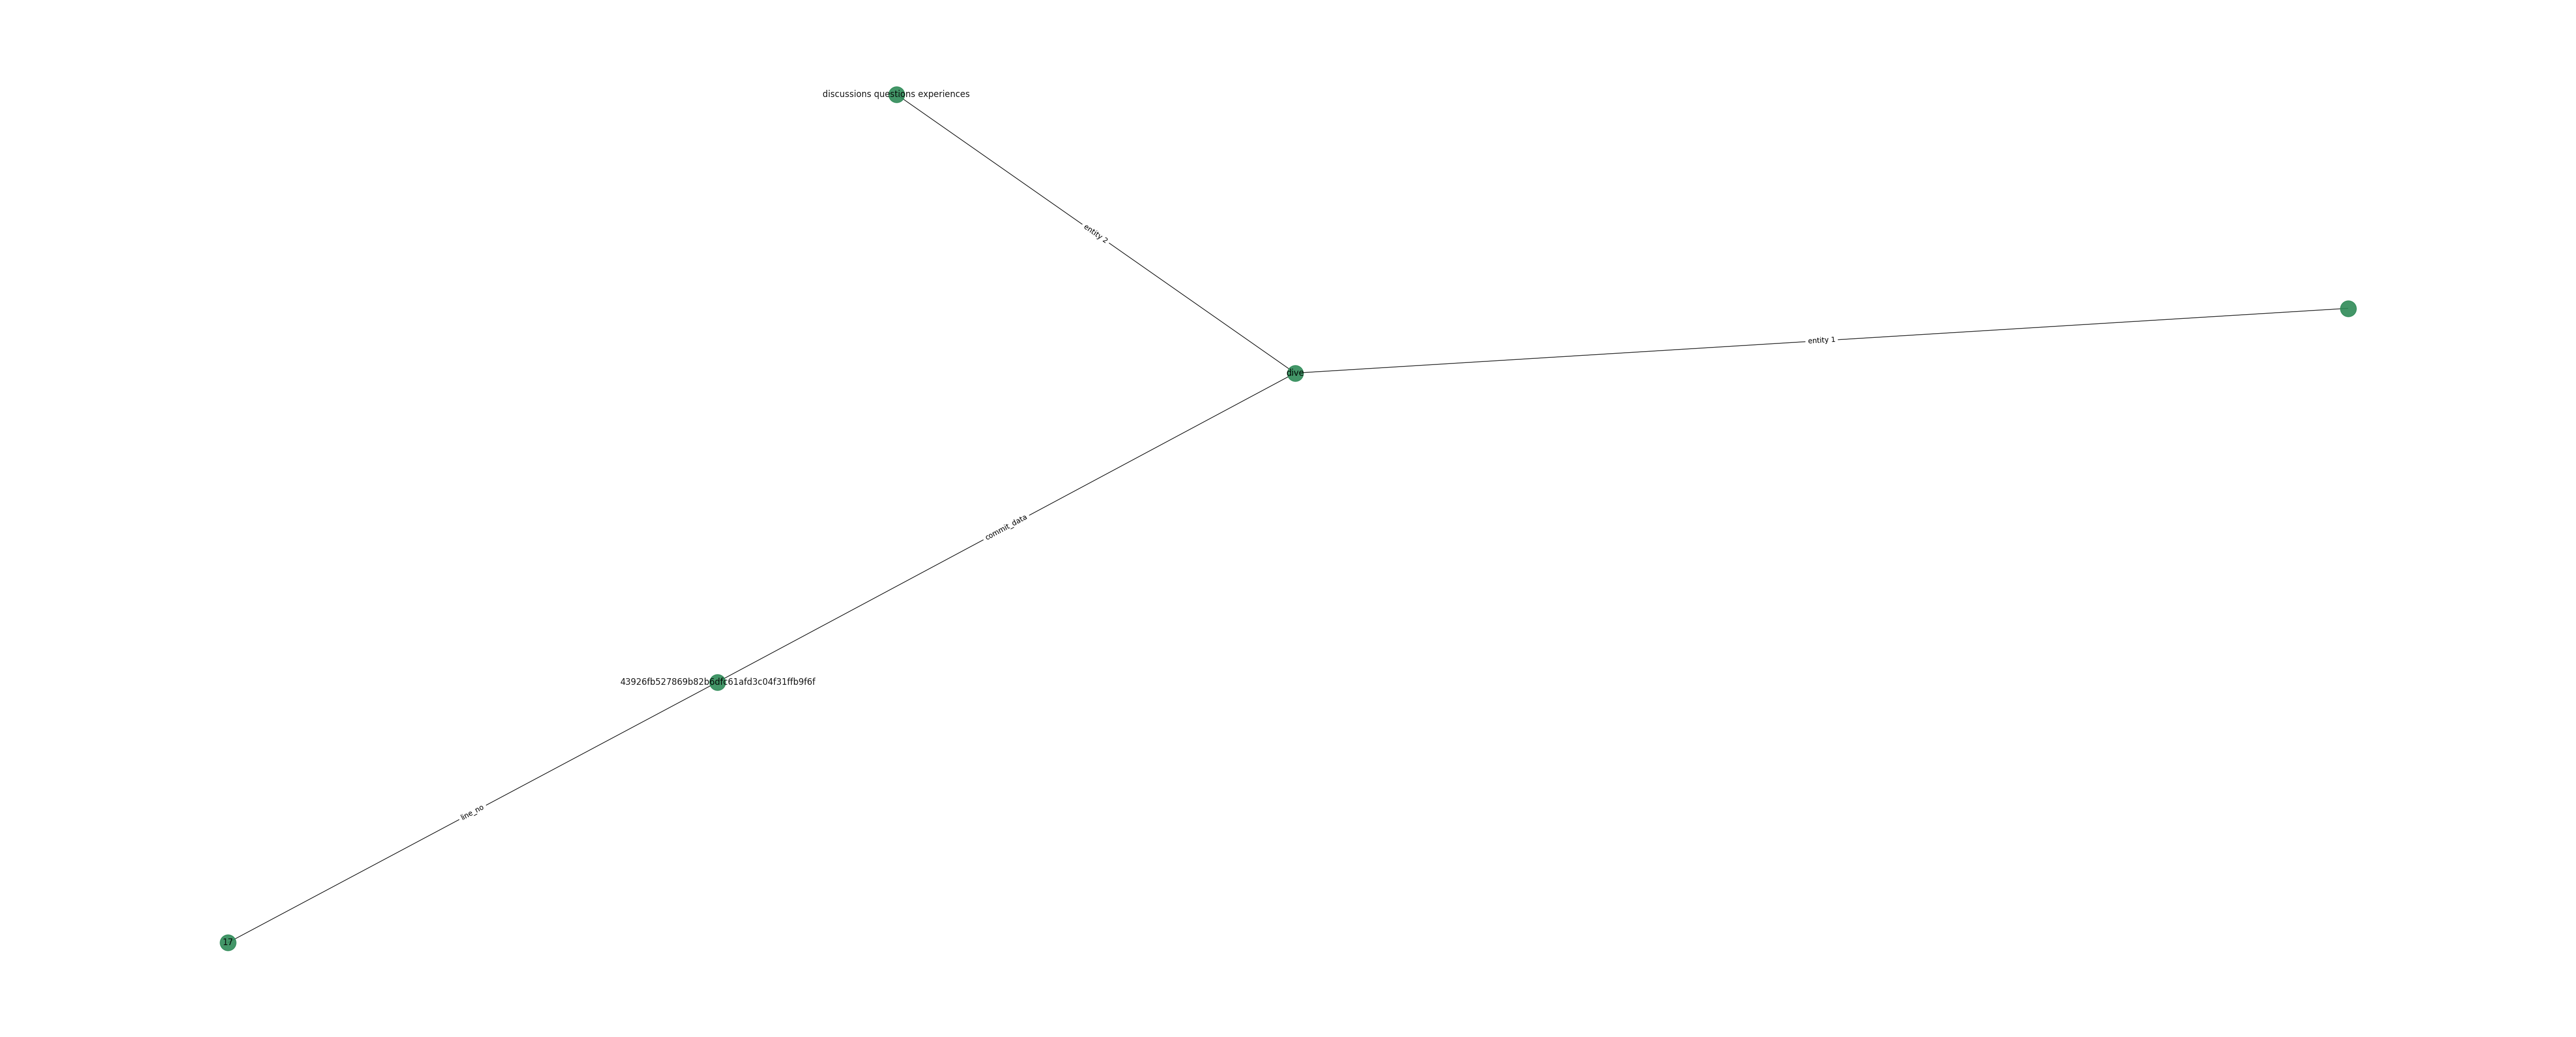

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7a70>
{'', '43926fb527869b82b6dfc61afd3c04f31ffb9f6f', 'discussions questions experiences', 17, 'dive'}


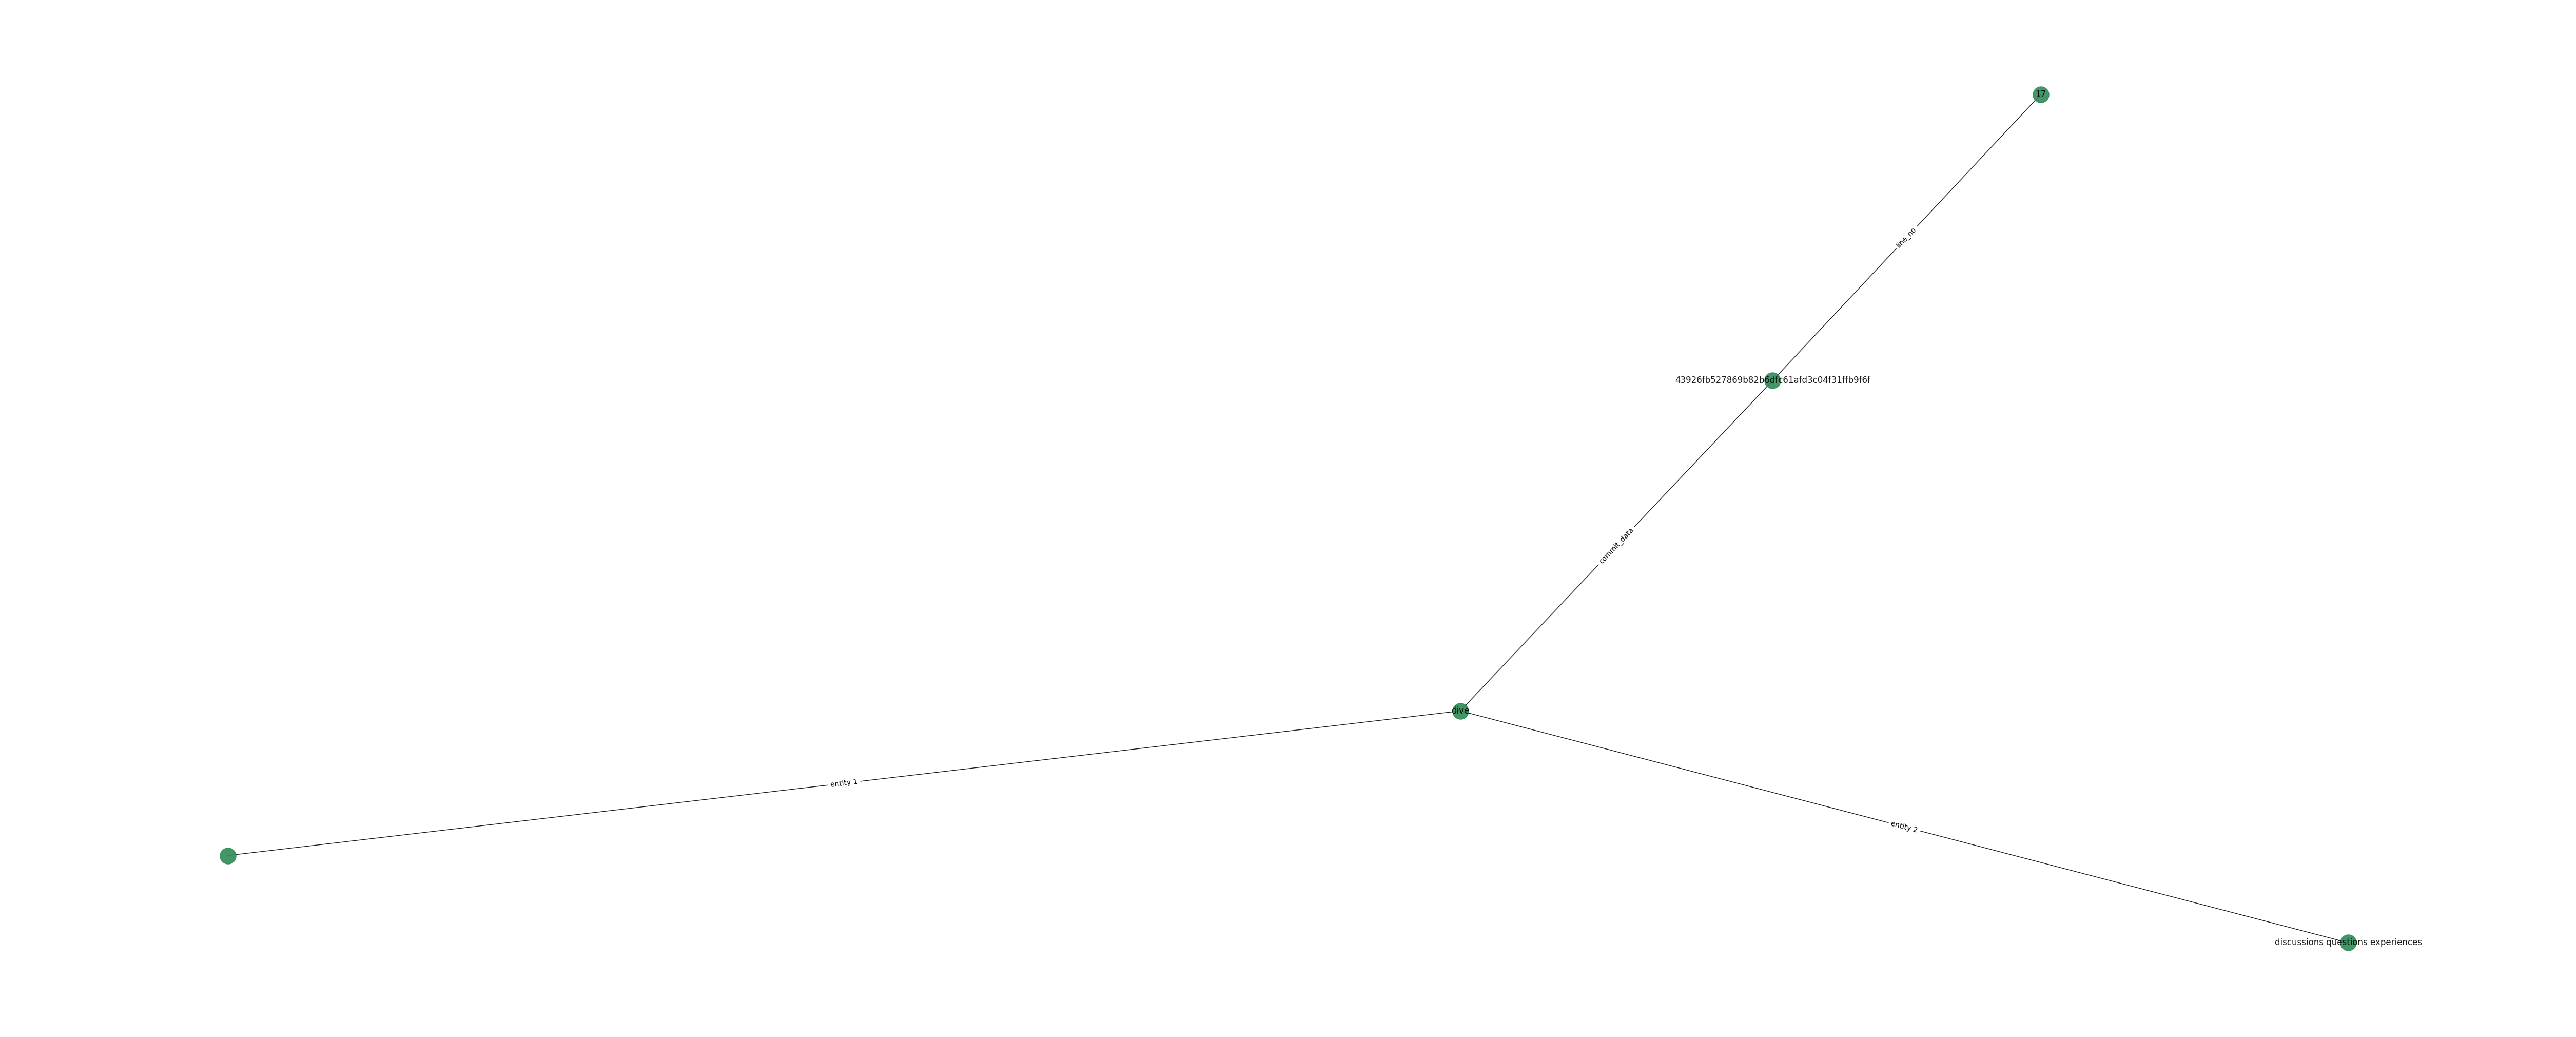

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7a70>
{'', '52b4577d3b2044358cee958c8b2e7b98fc4277ad', 'discussions questions experiences', 17, 'dive'}


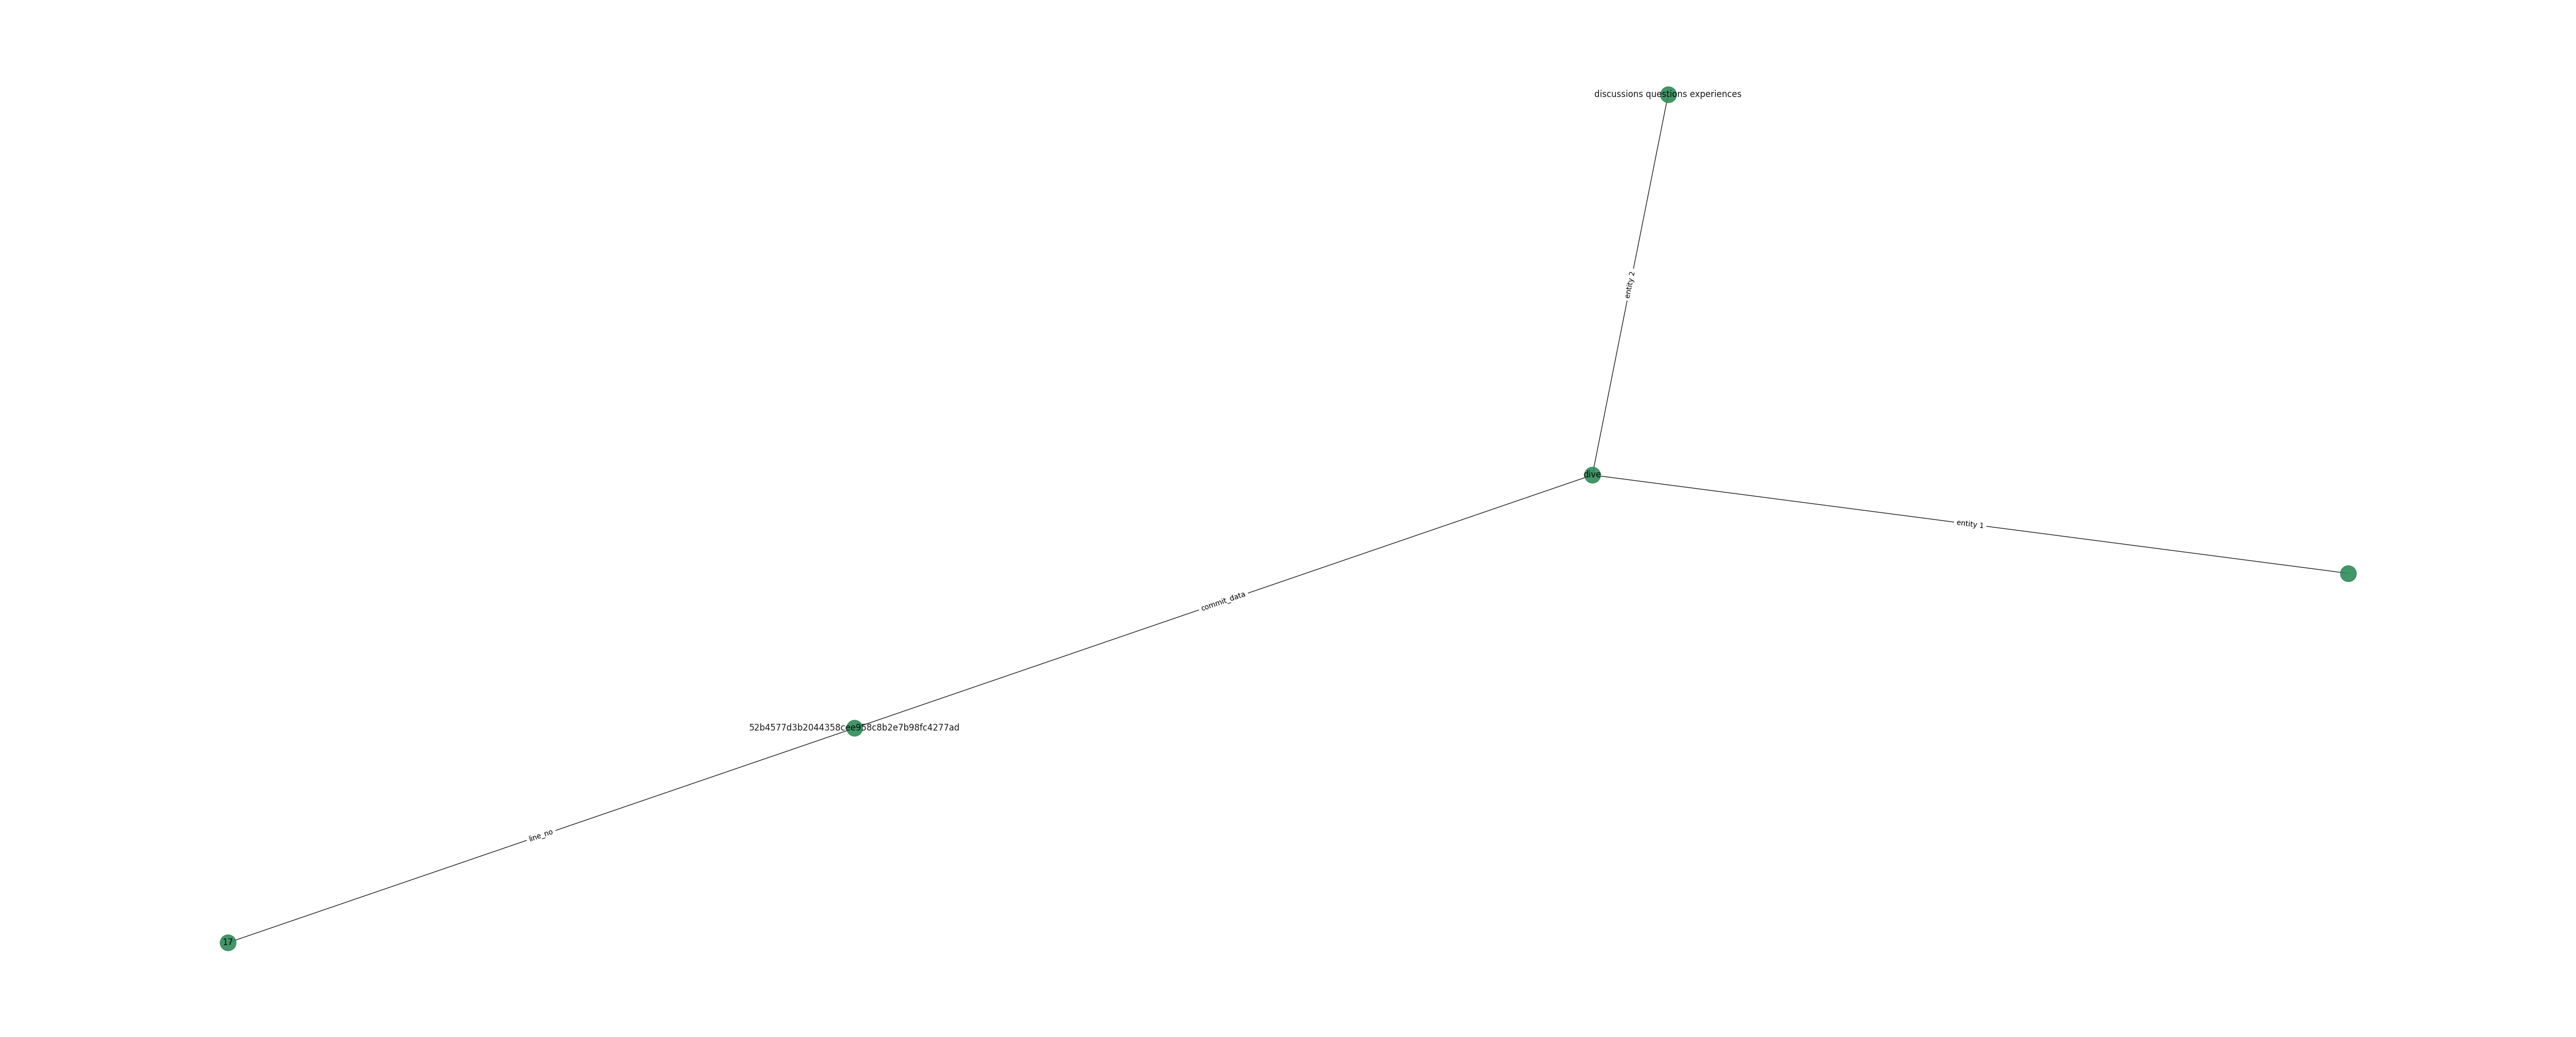

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3ae0>
{'segment manageable relevant optimize', '2b13984e1163fc7246d884a8265a4c3d4c7d575b', 6, 'It', 'data chunks embeddings them database retrieval'}


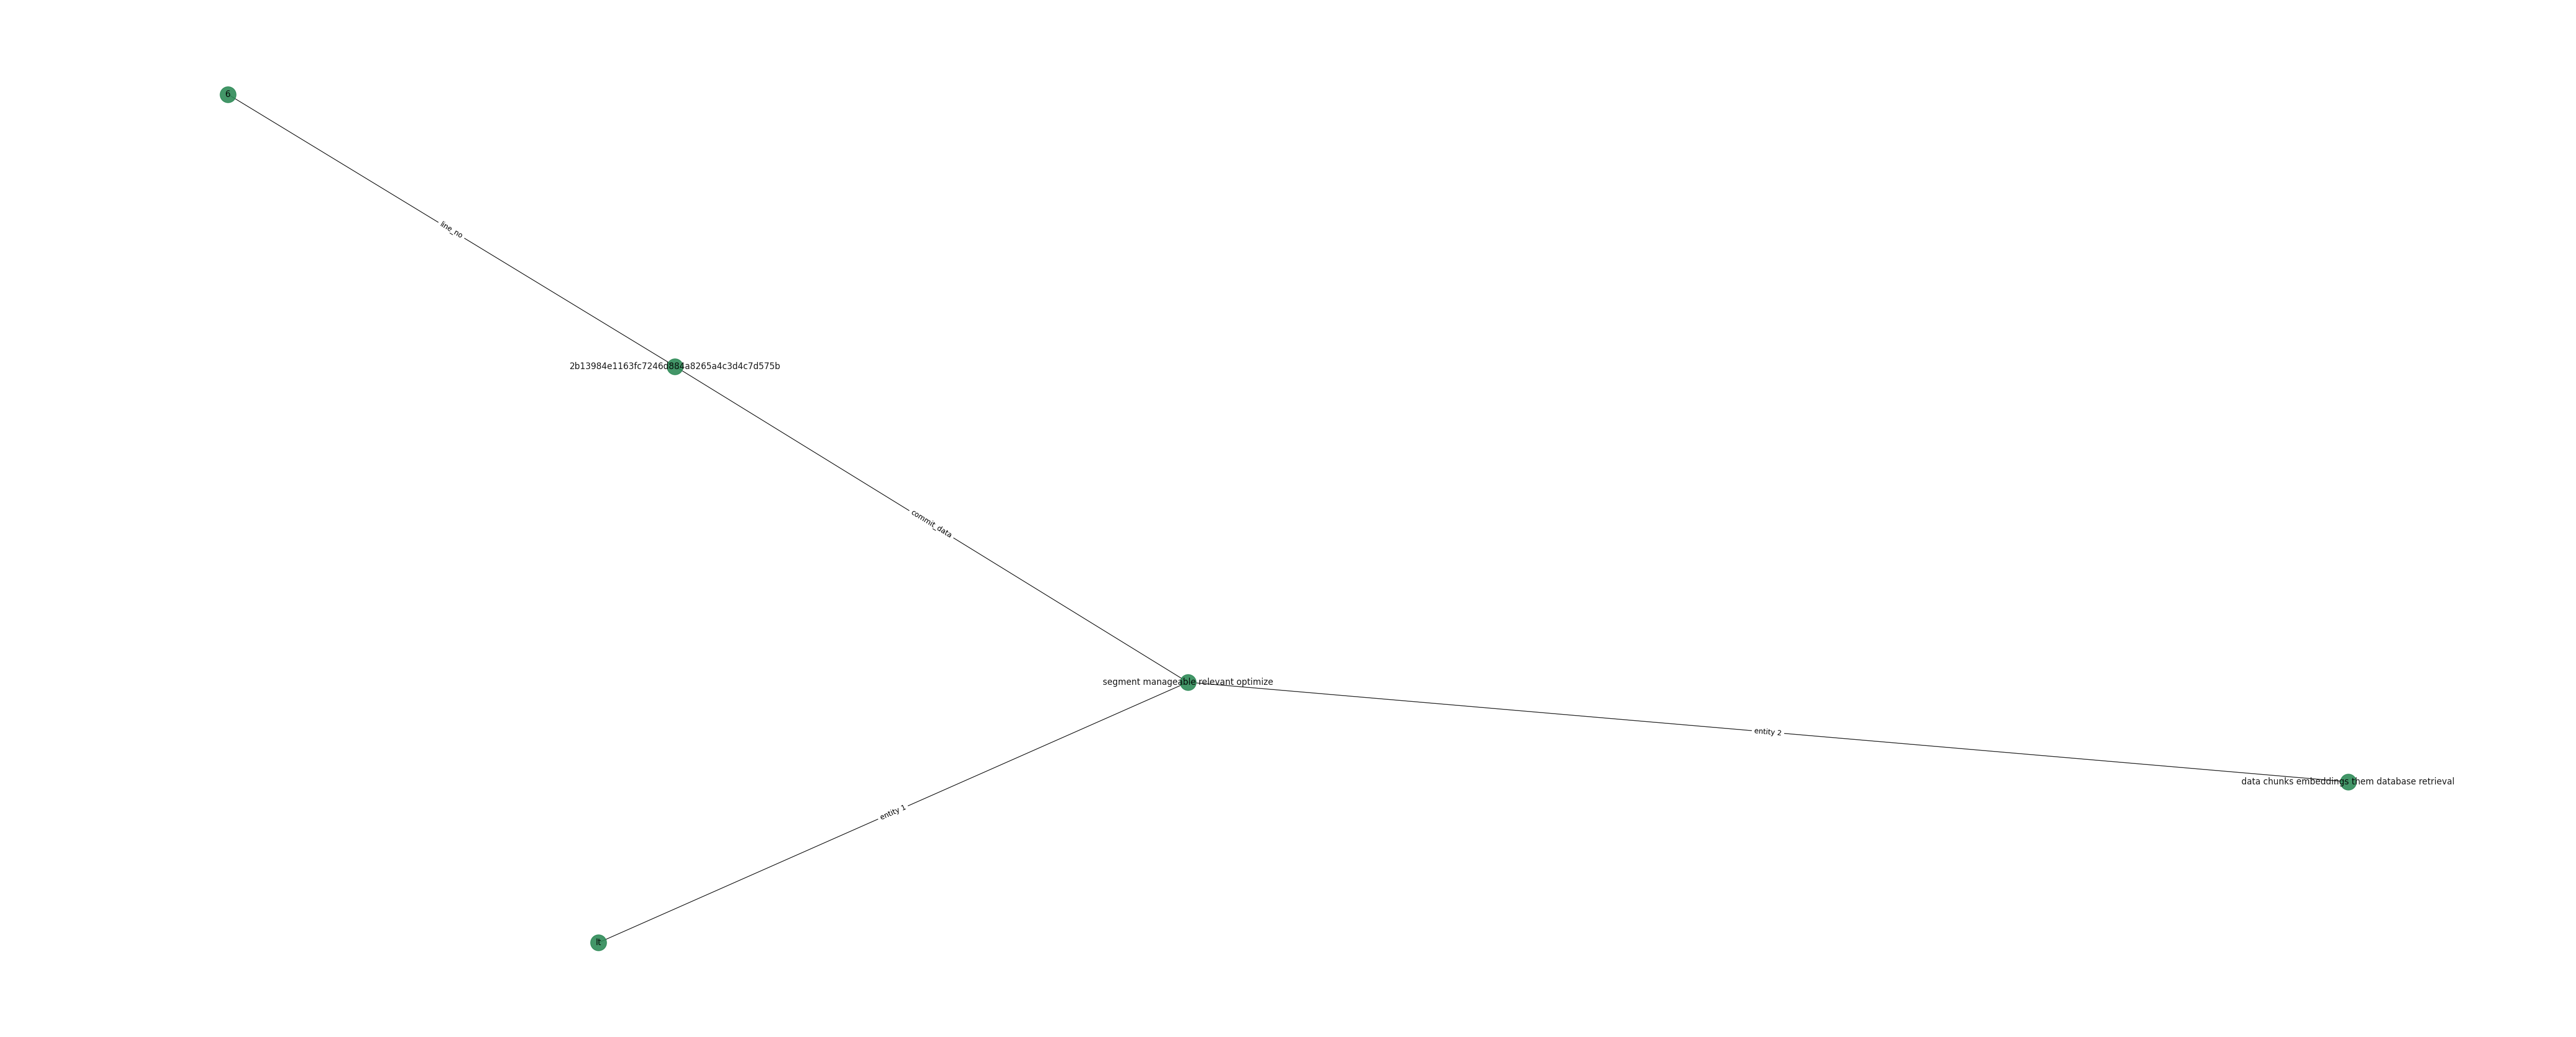

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a13f0>
{'2b13984e1163fc7246d884a8265a4c3d4c7d575b', 7, 'suite APIs users information answers conversations all data', 'it', 'diverse enable contextual precise interactive own'}


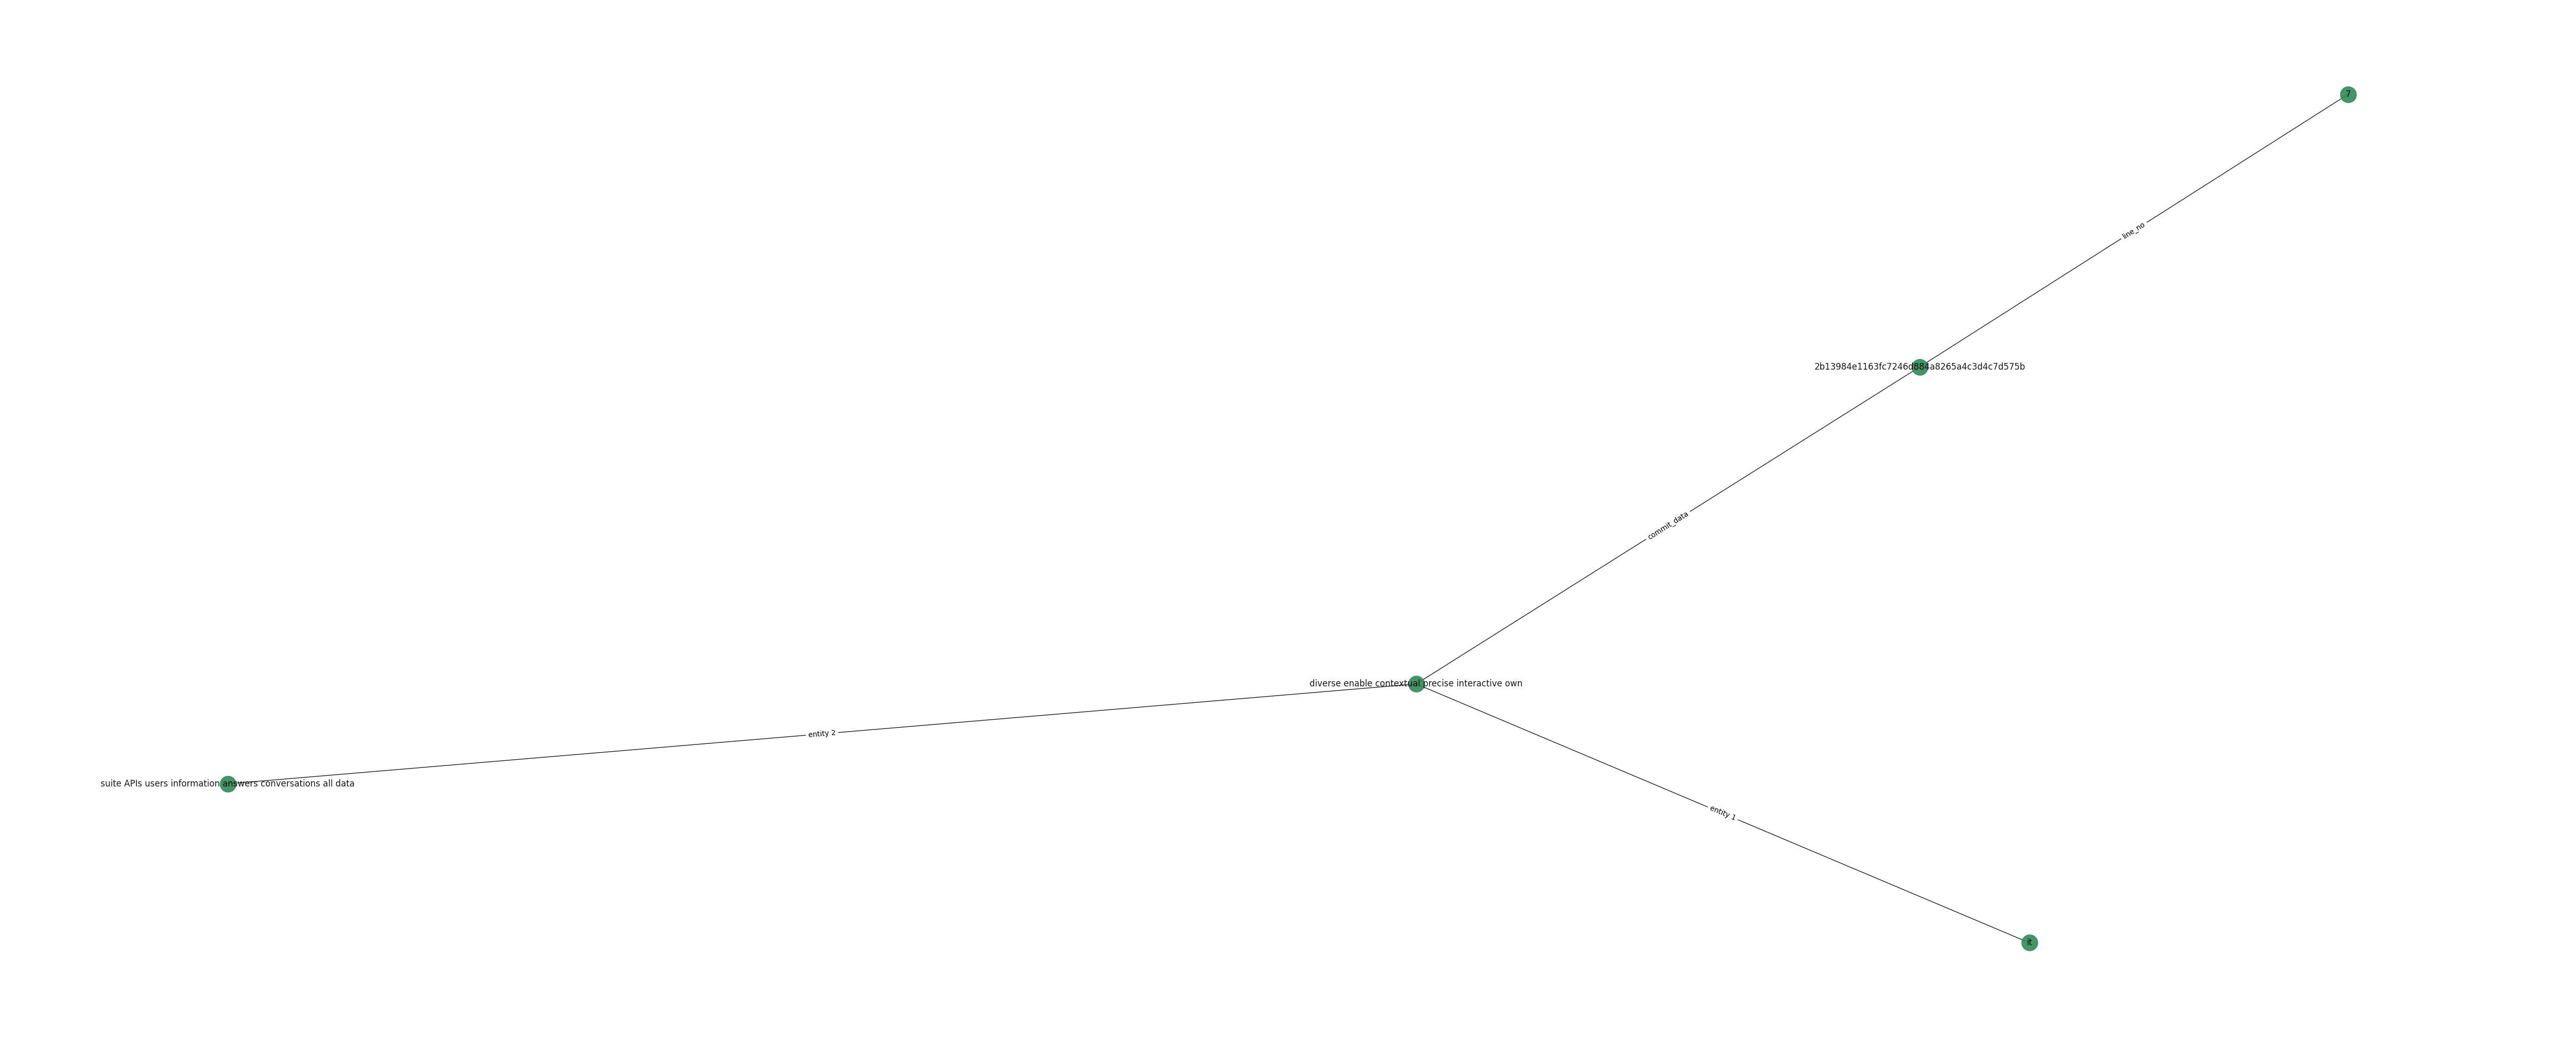

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7a70>
{'segment manageable relevant optimize', '2b13984e1163fc7246d884a8265a4c3d4c7d575b', 6, 'It', 'data chunks embeddings them database retrieval'}


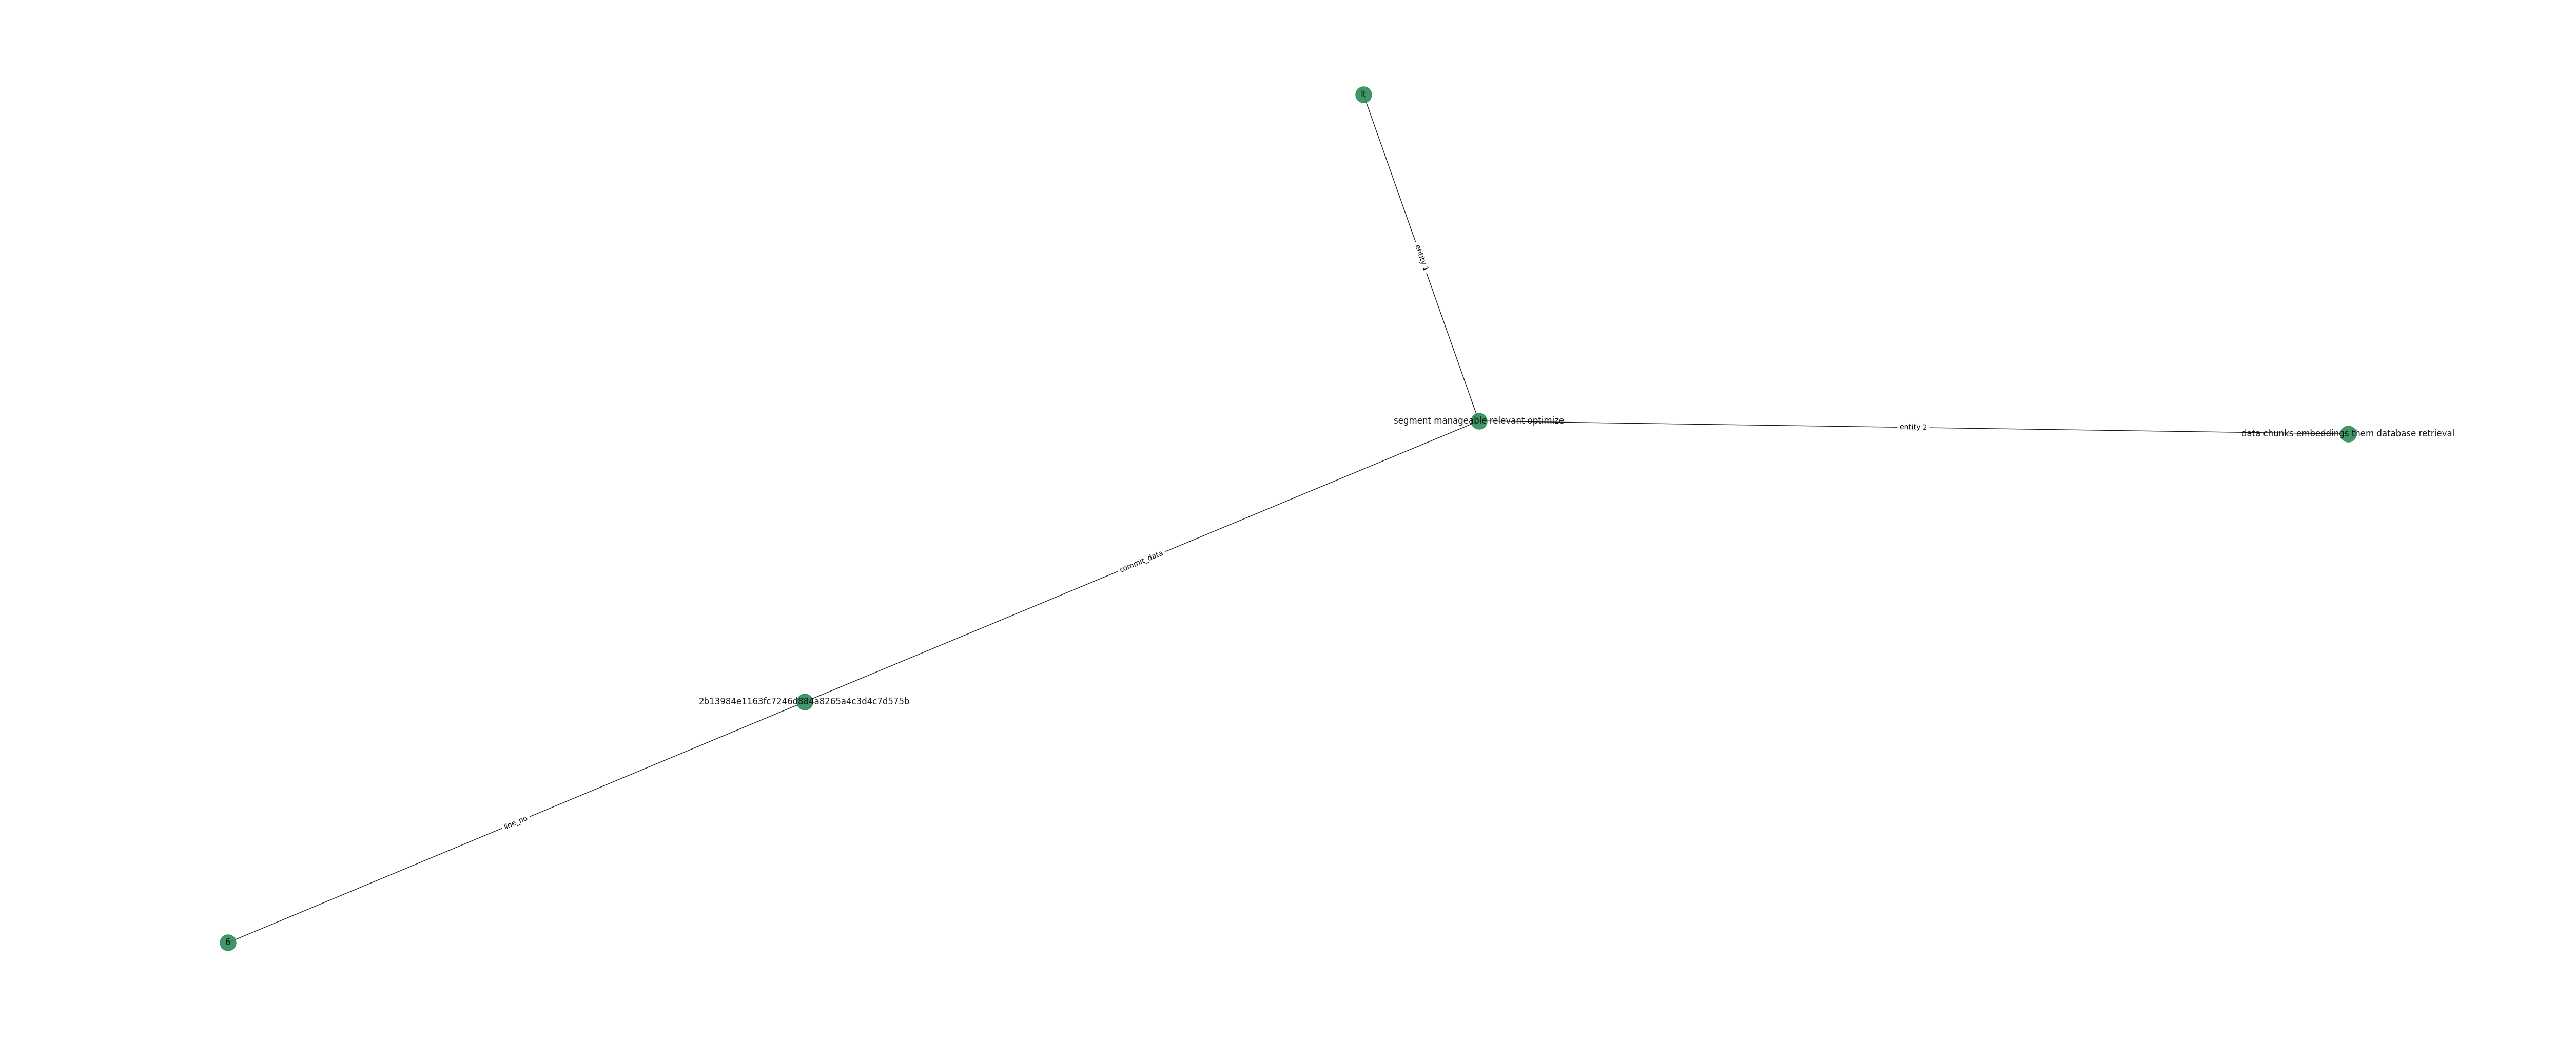

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a34c0>
{'2b13984e1163fc7246d884a8265a4c3d4c7d575b', 7, 'suite APIs users information answers conversations all data', 'it', 'diverse enable contextual precise interactive own'}


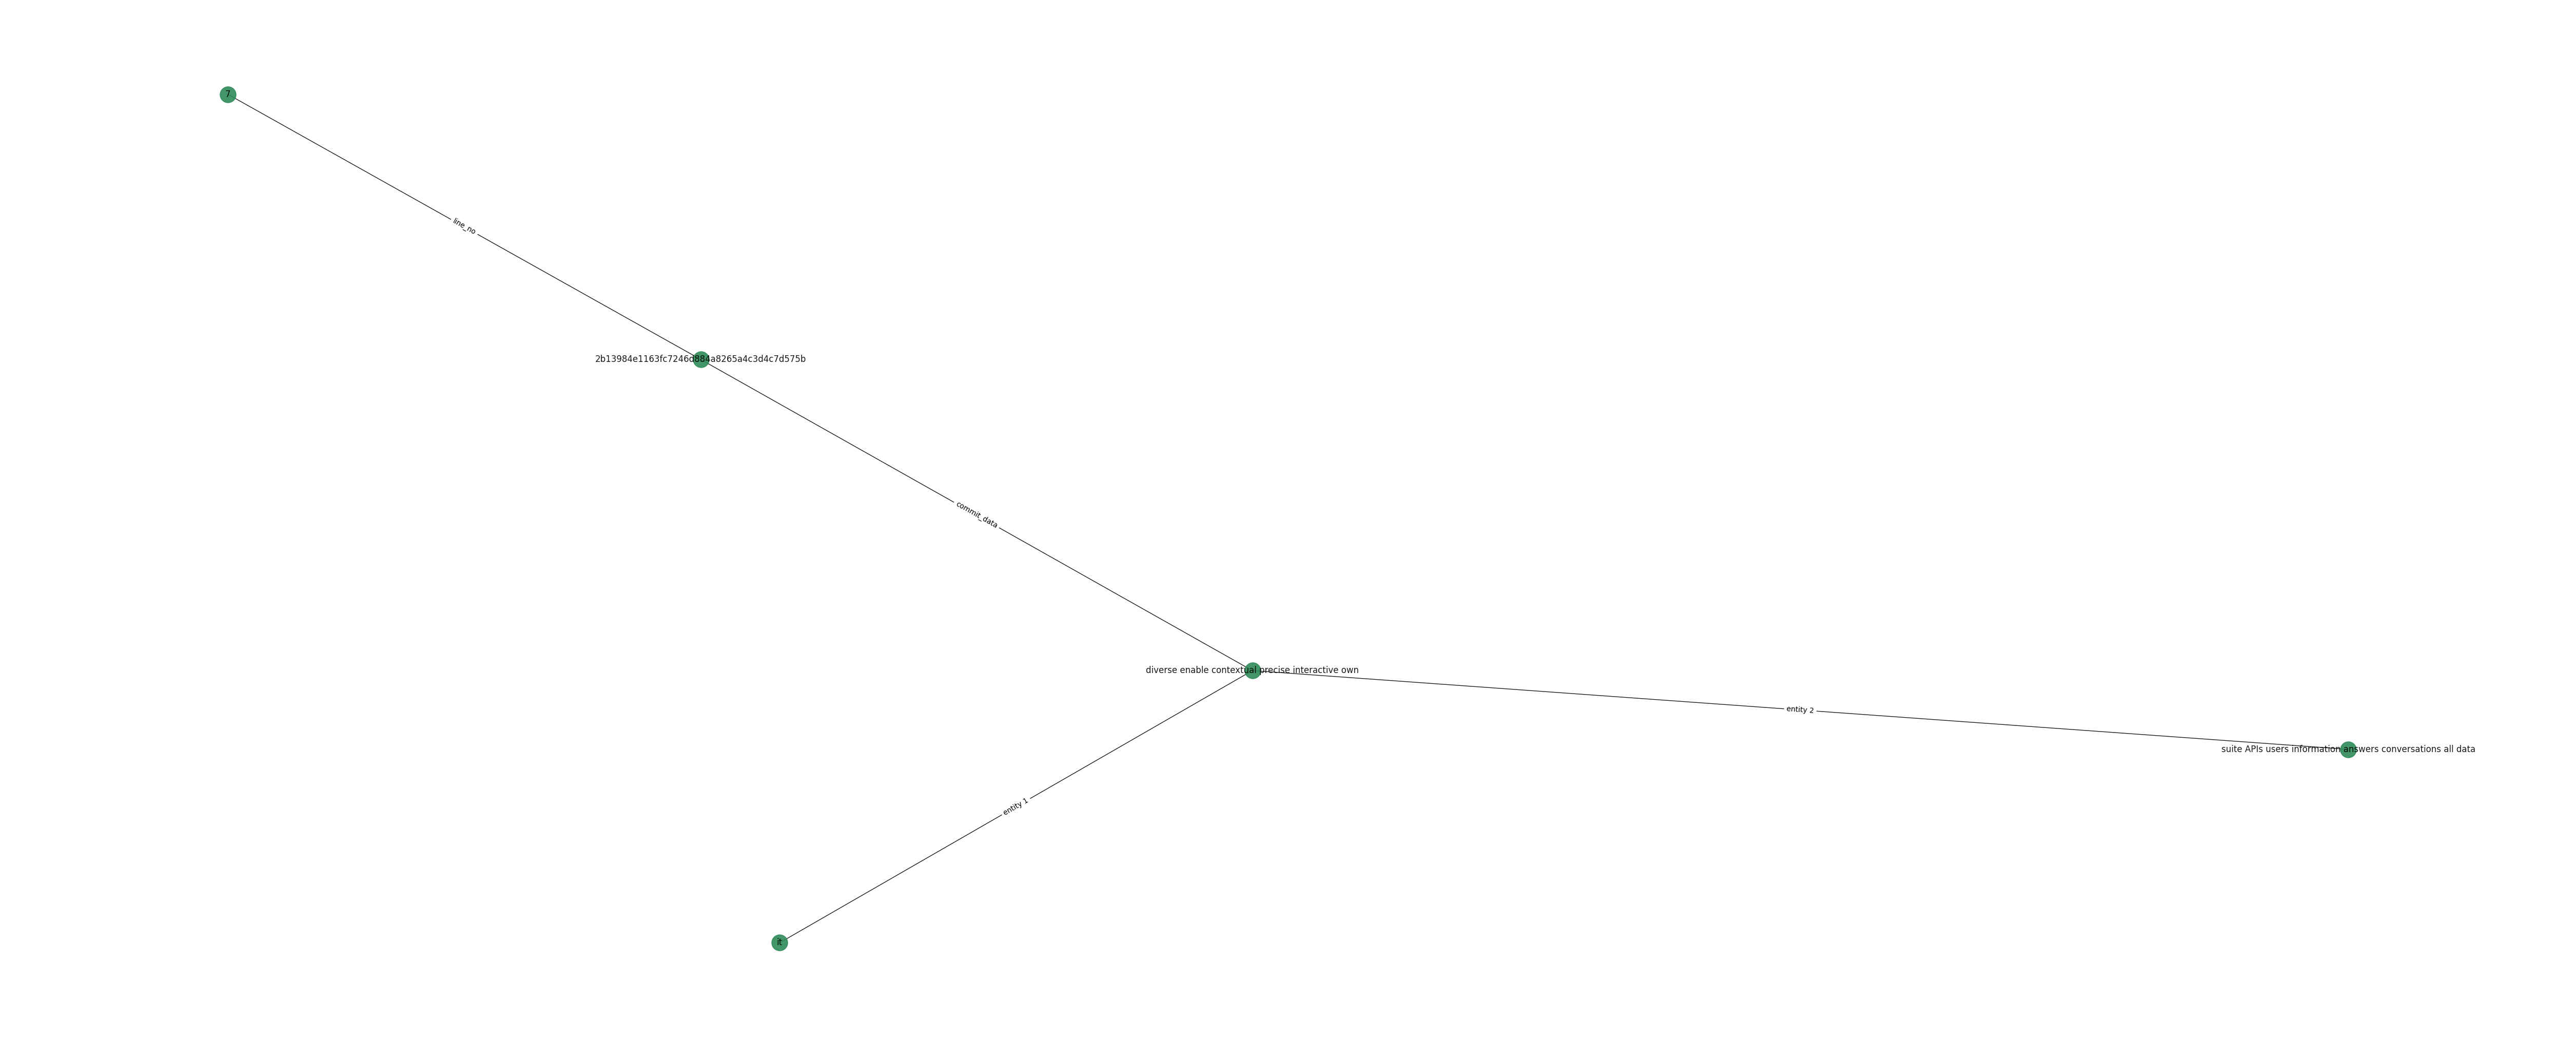

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3290>
{'4dc5c7348fe662daef0c015388df2604a7b69a9d', 12, 'Musk', 'answer several', 'companies'}


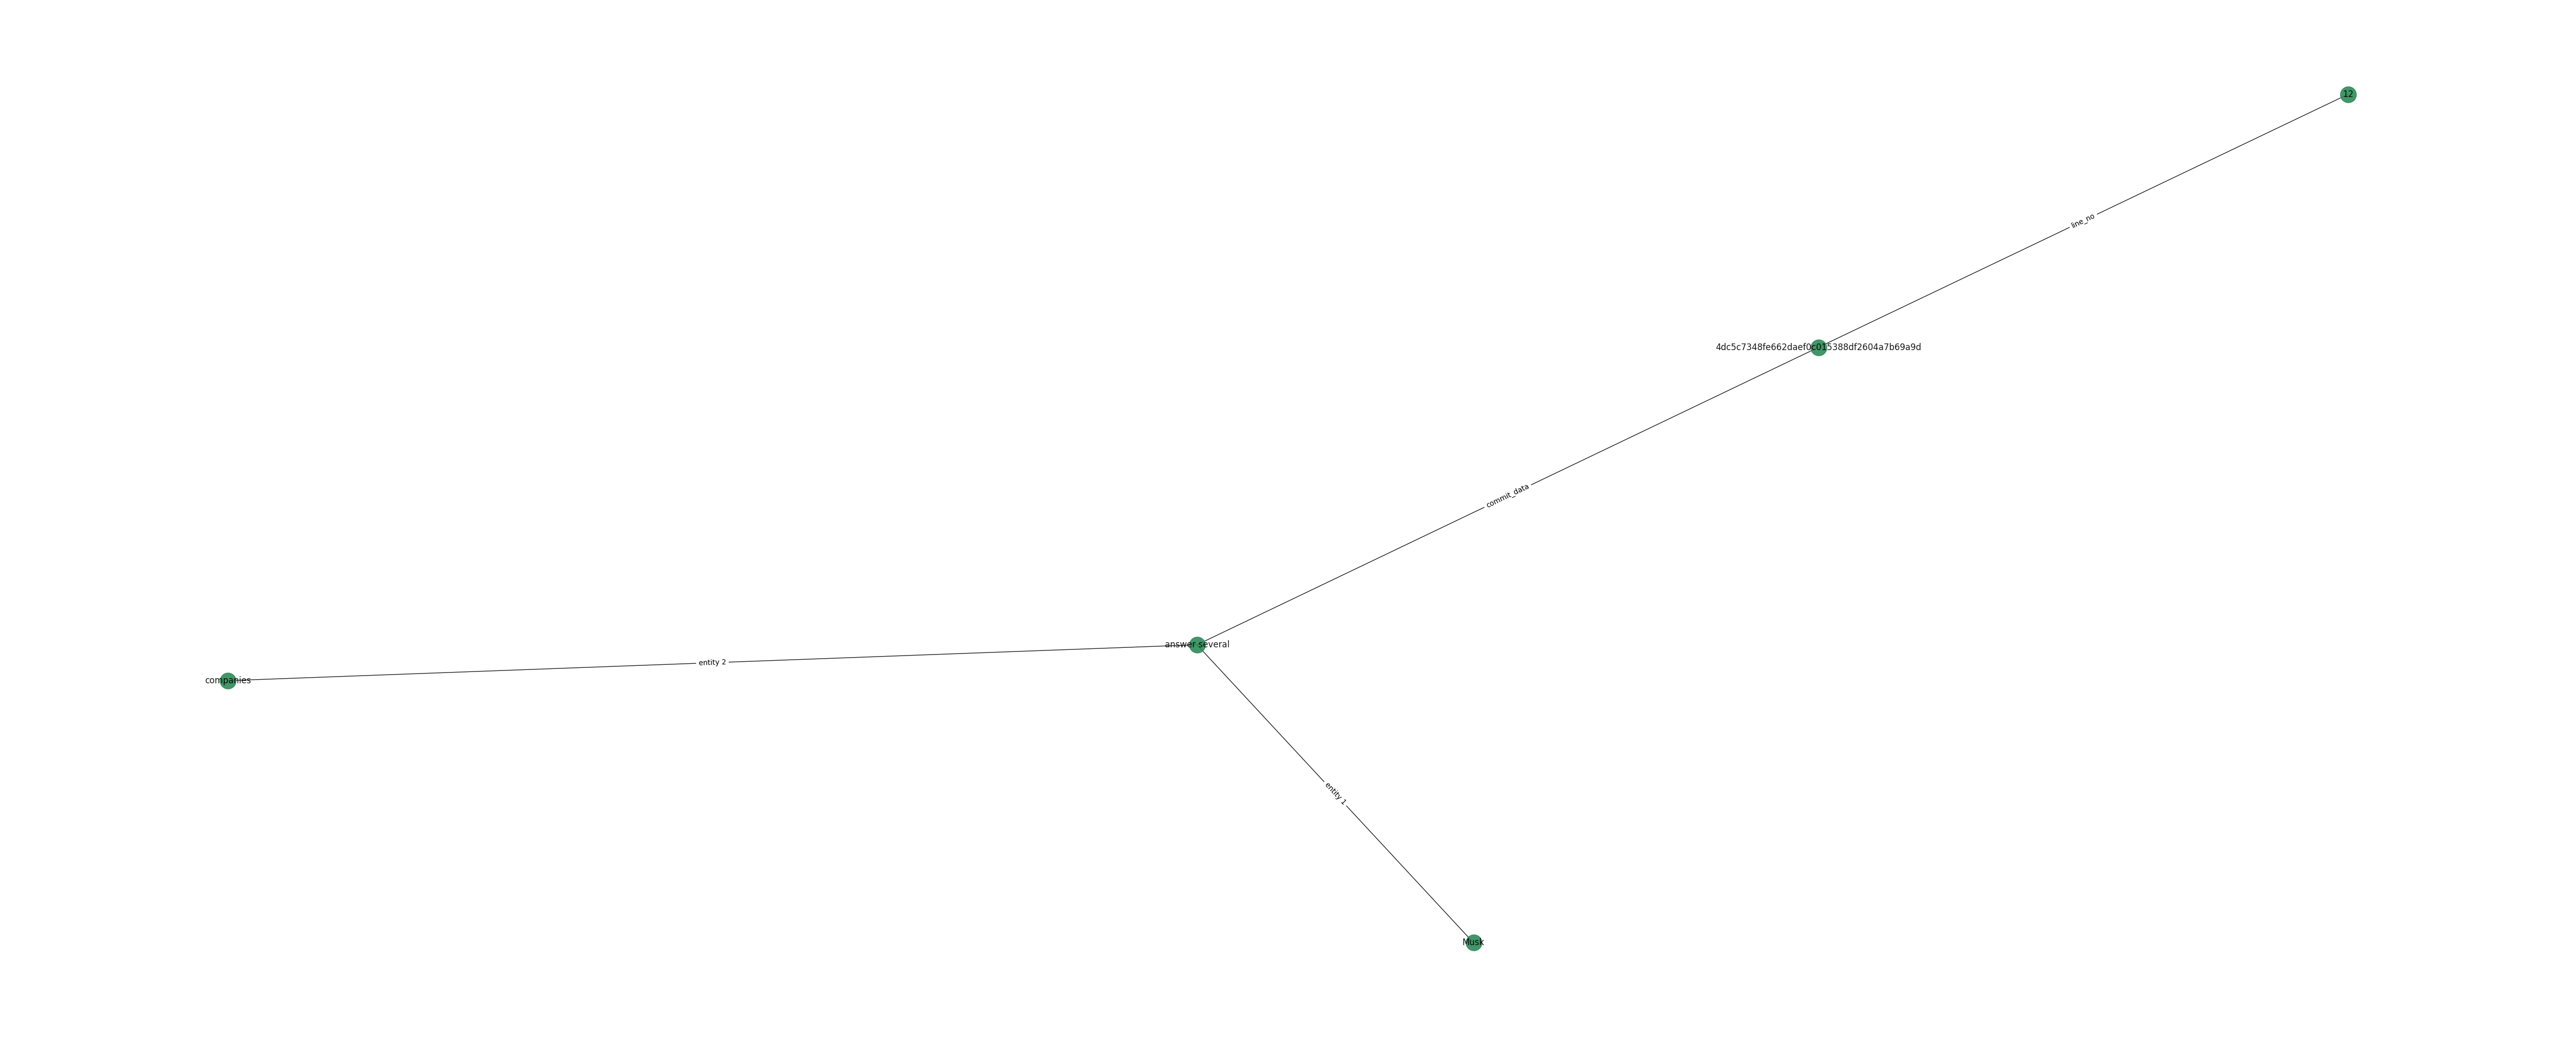

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a3290>
{'4dc5c7348fe662daef0c015388df2604a7b69a9d', 13, 'he', 'knowledge SpaceX Tesla Neuralink Company', 'be designer'}


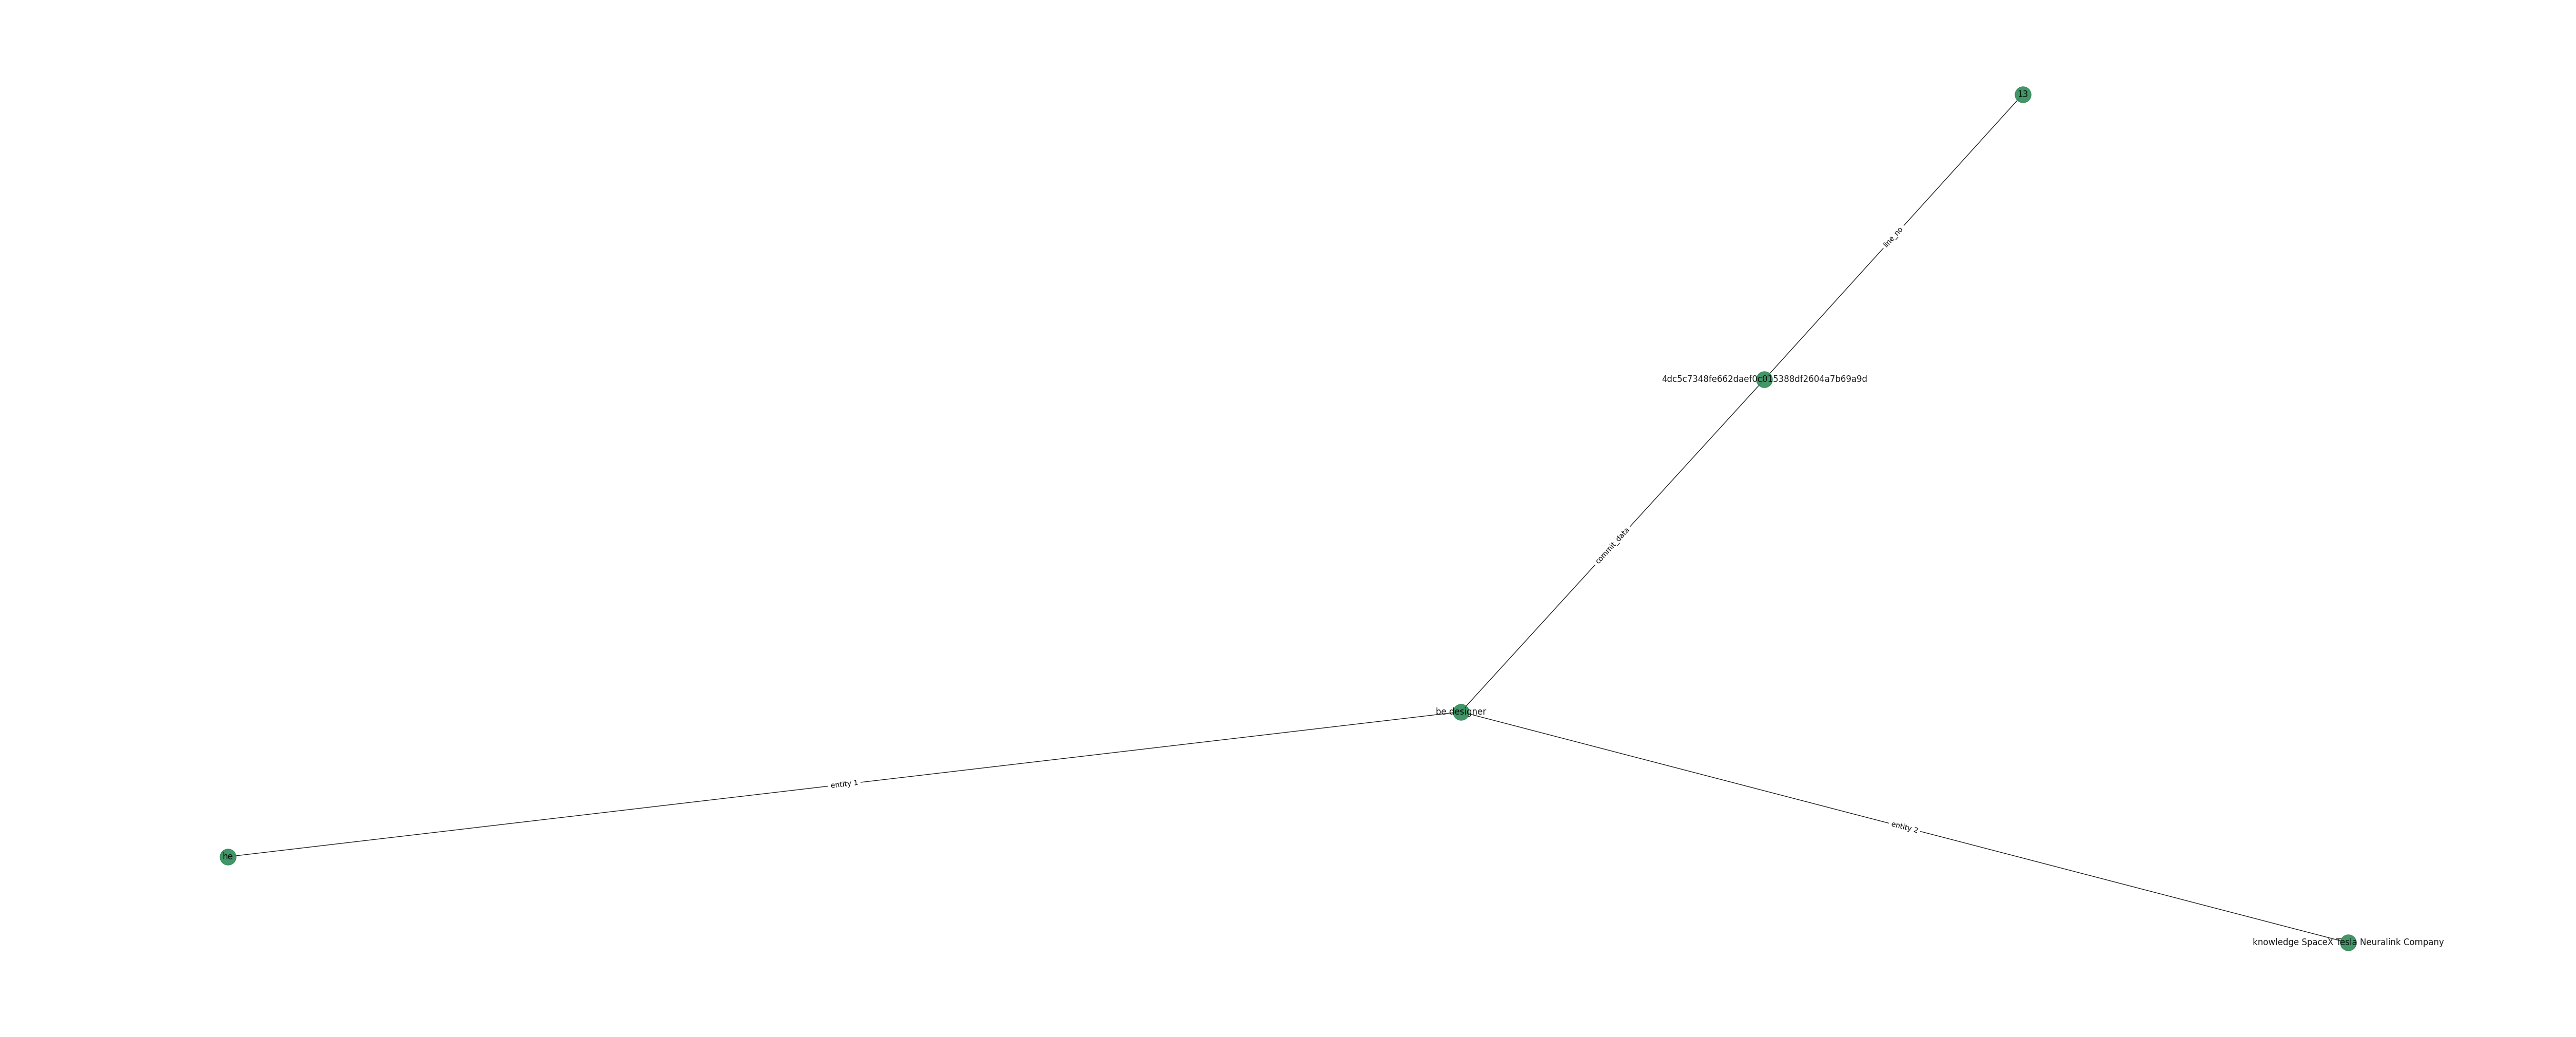

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7a70>
{'information it', 14, 'time updates', 'note late', '4dc5c7348fe662daef0c015388df2604a7b69a9d'}


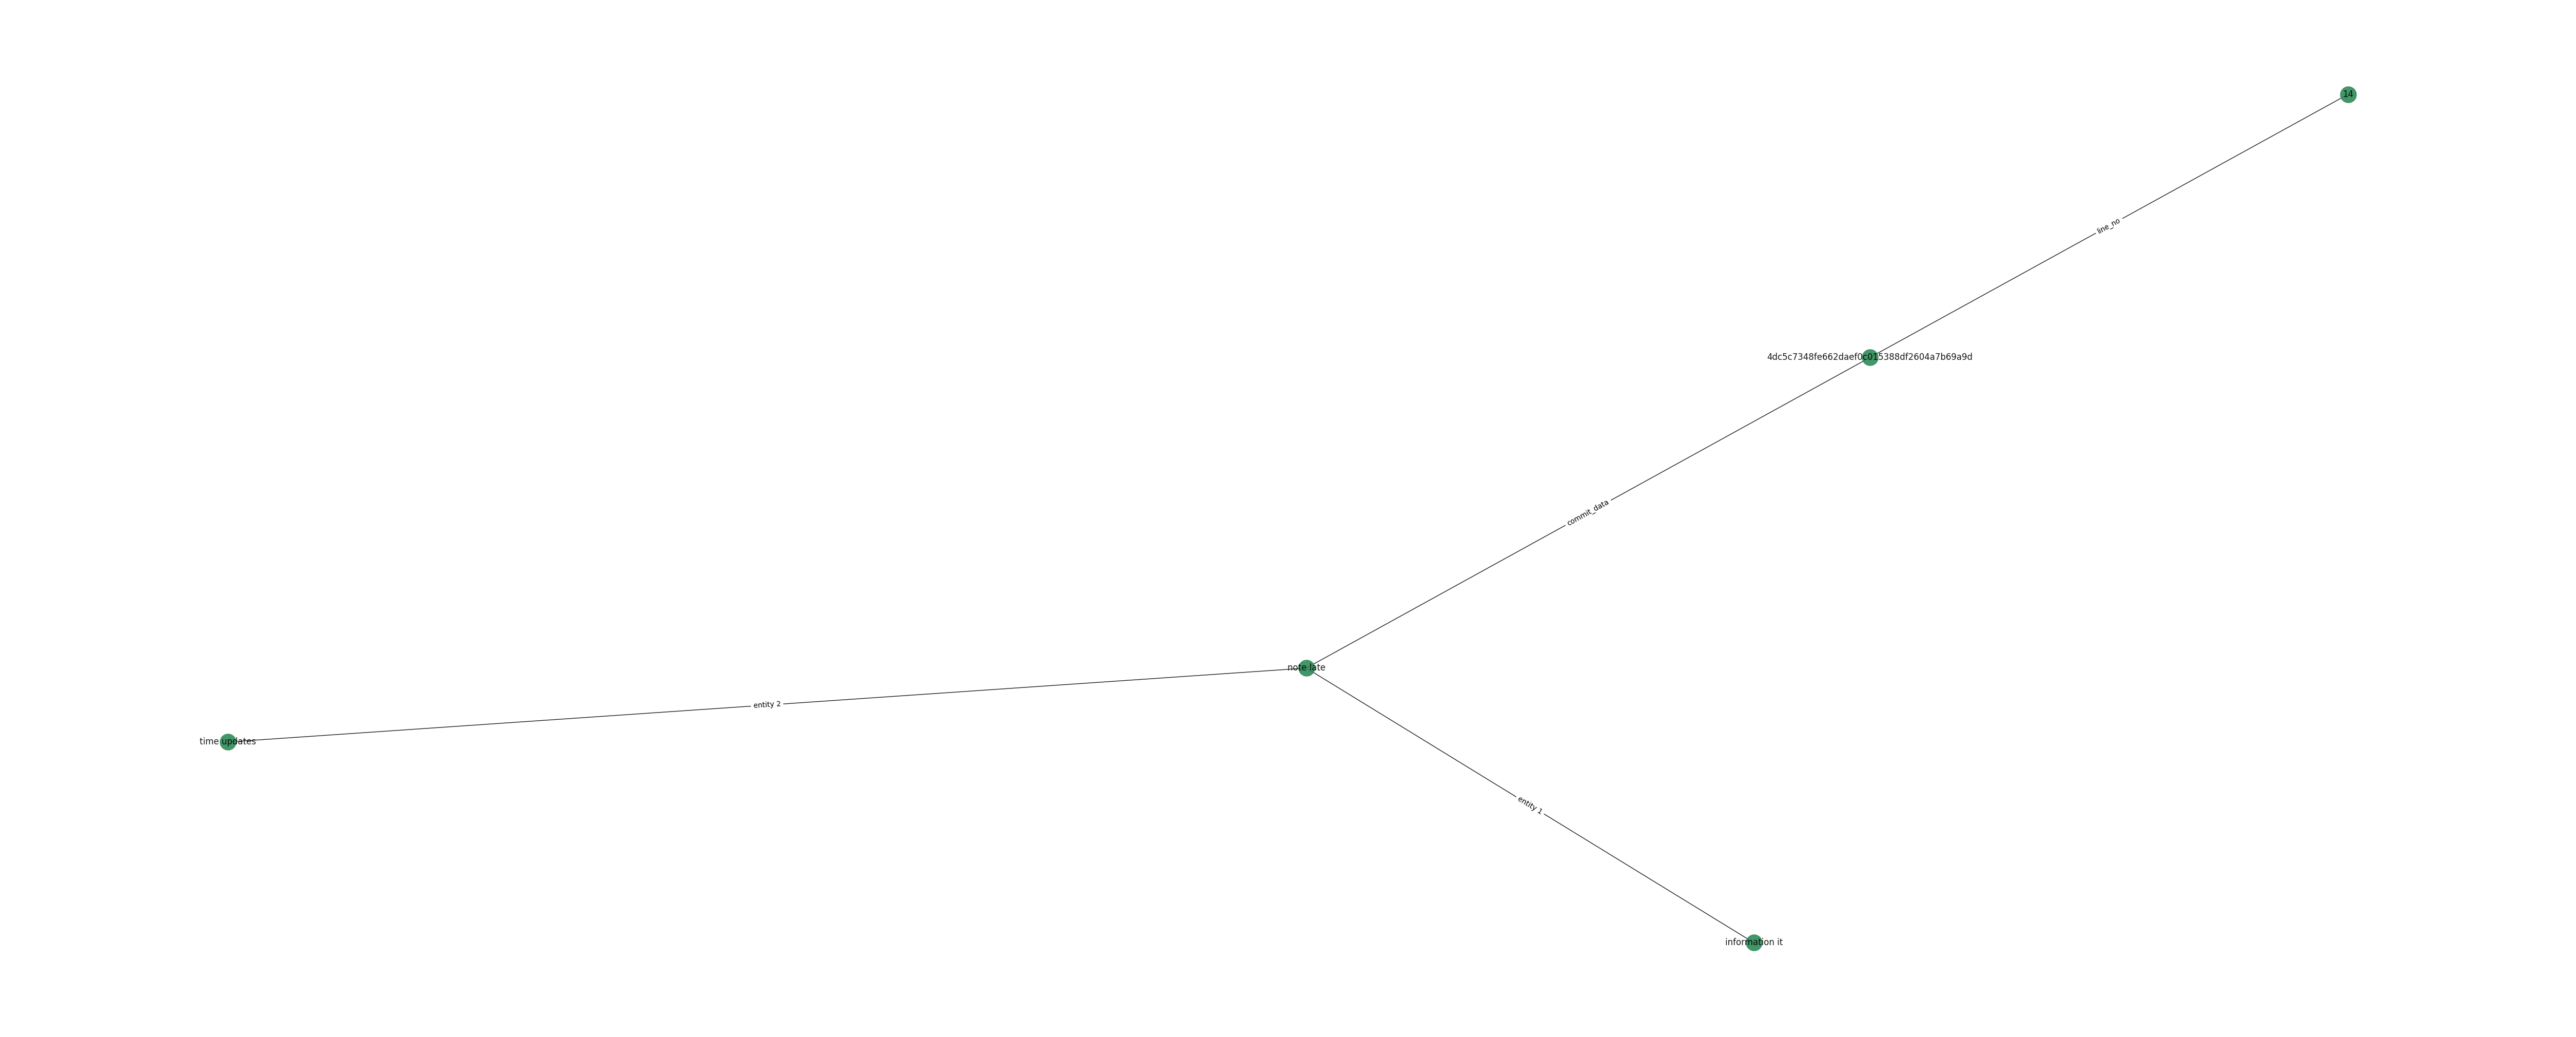

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394b7a70>
{'segment manageable relevant optimize', 6, 'a4d32aec2419649e926462053438028a5b060401', 'It', 'data chunks embeddings them database retrieval'}


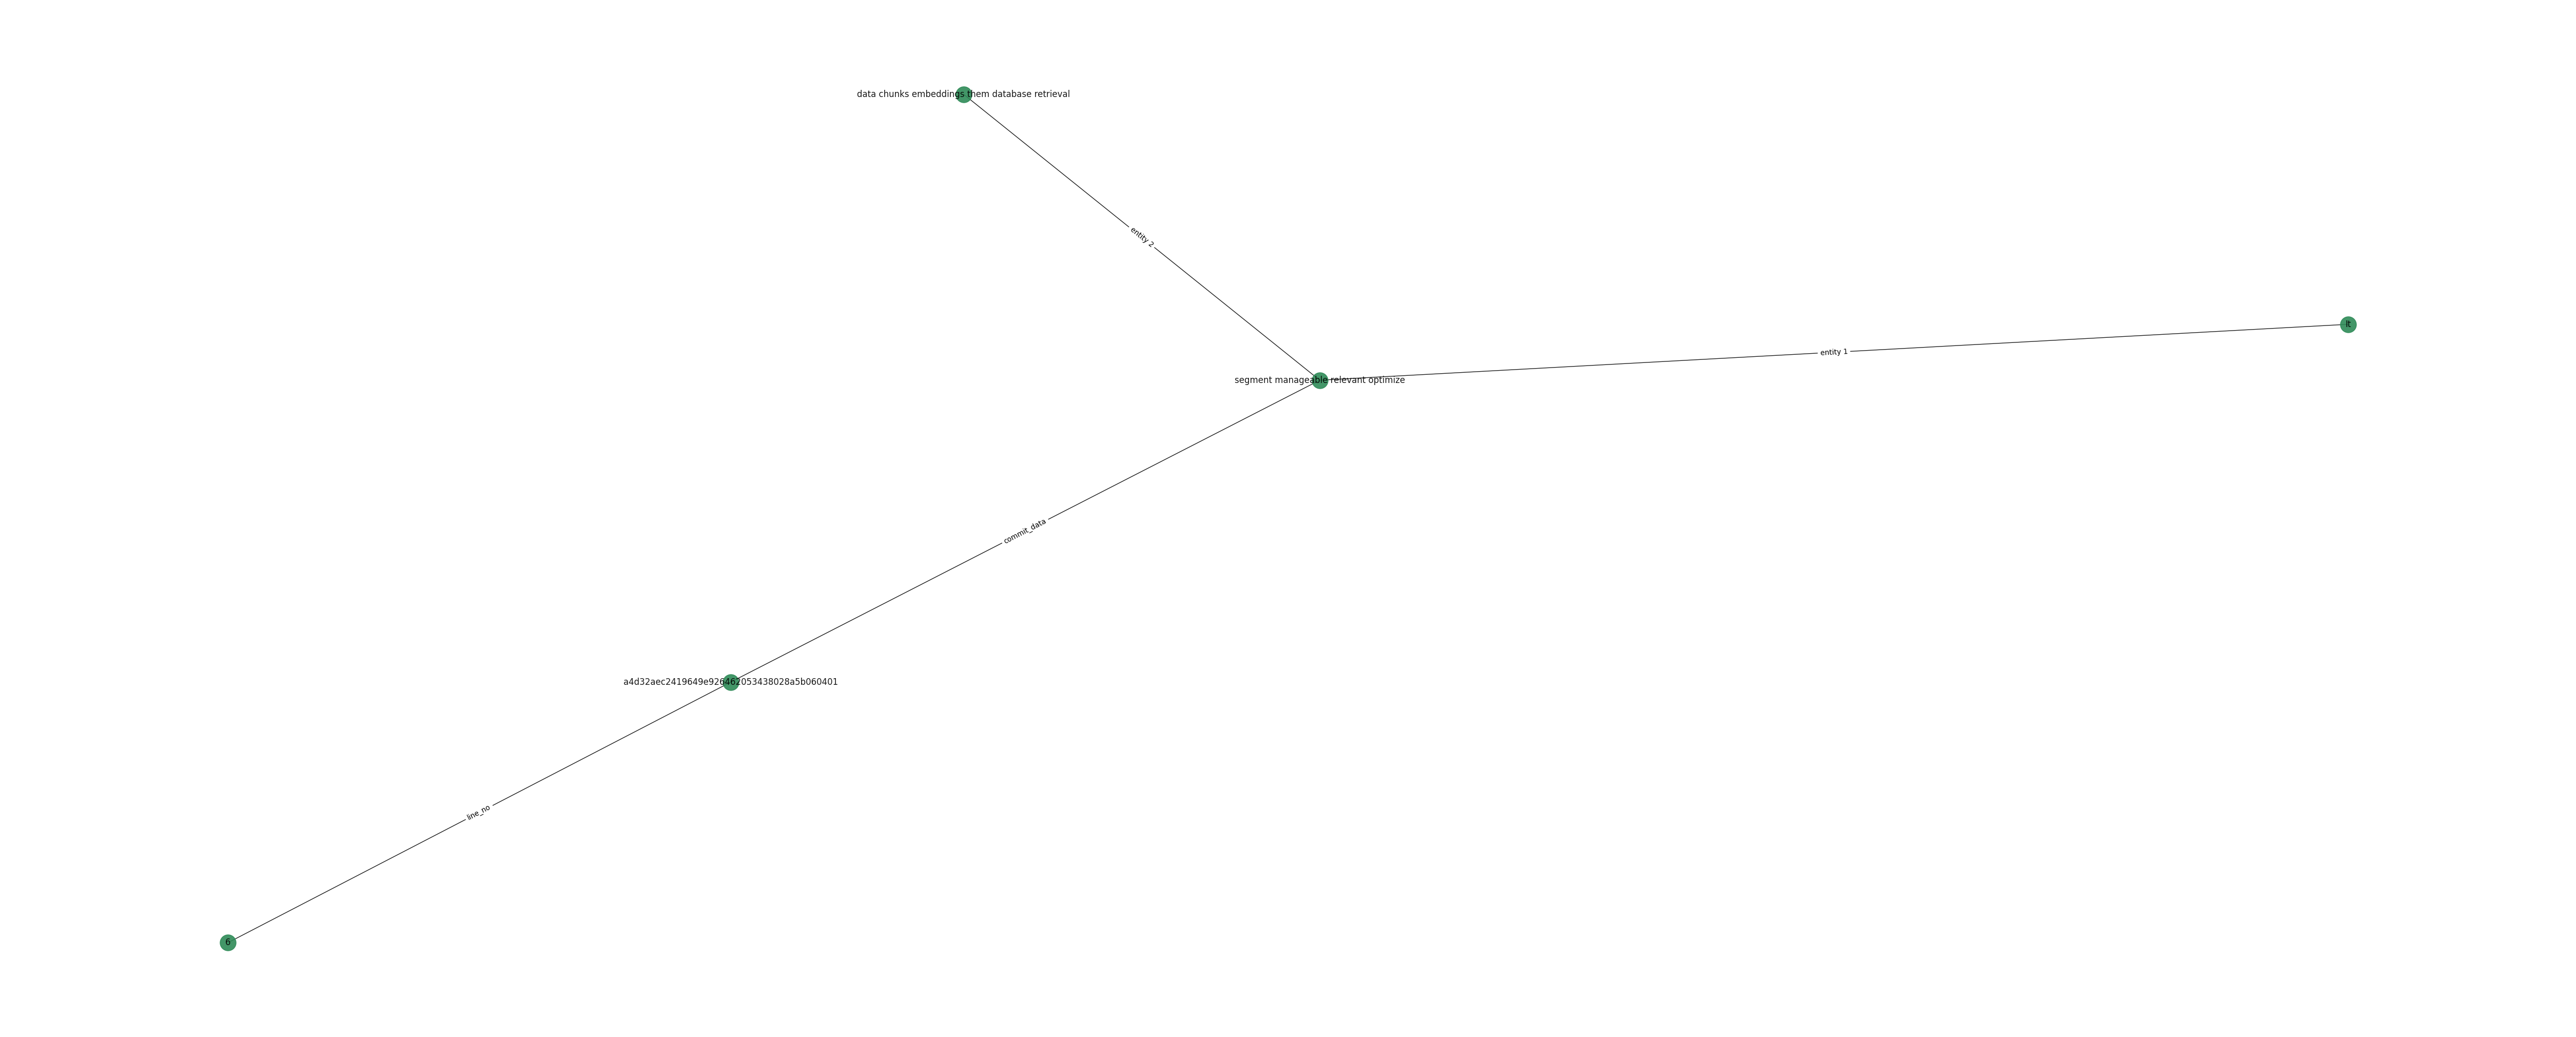

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a1b60>
{7, 'a4d32aec2419649e926462053438028a5b060401', 'suite APIs users information answers conversations all data', 'it', 'diverse enable contextual precise interactive own'}


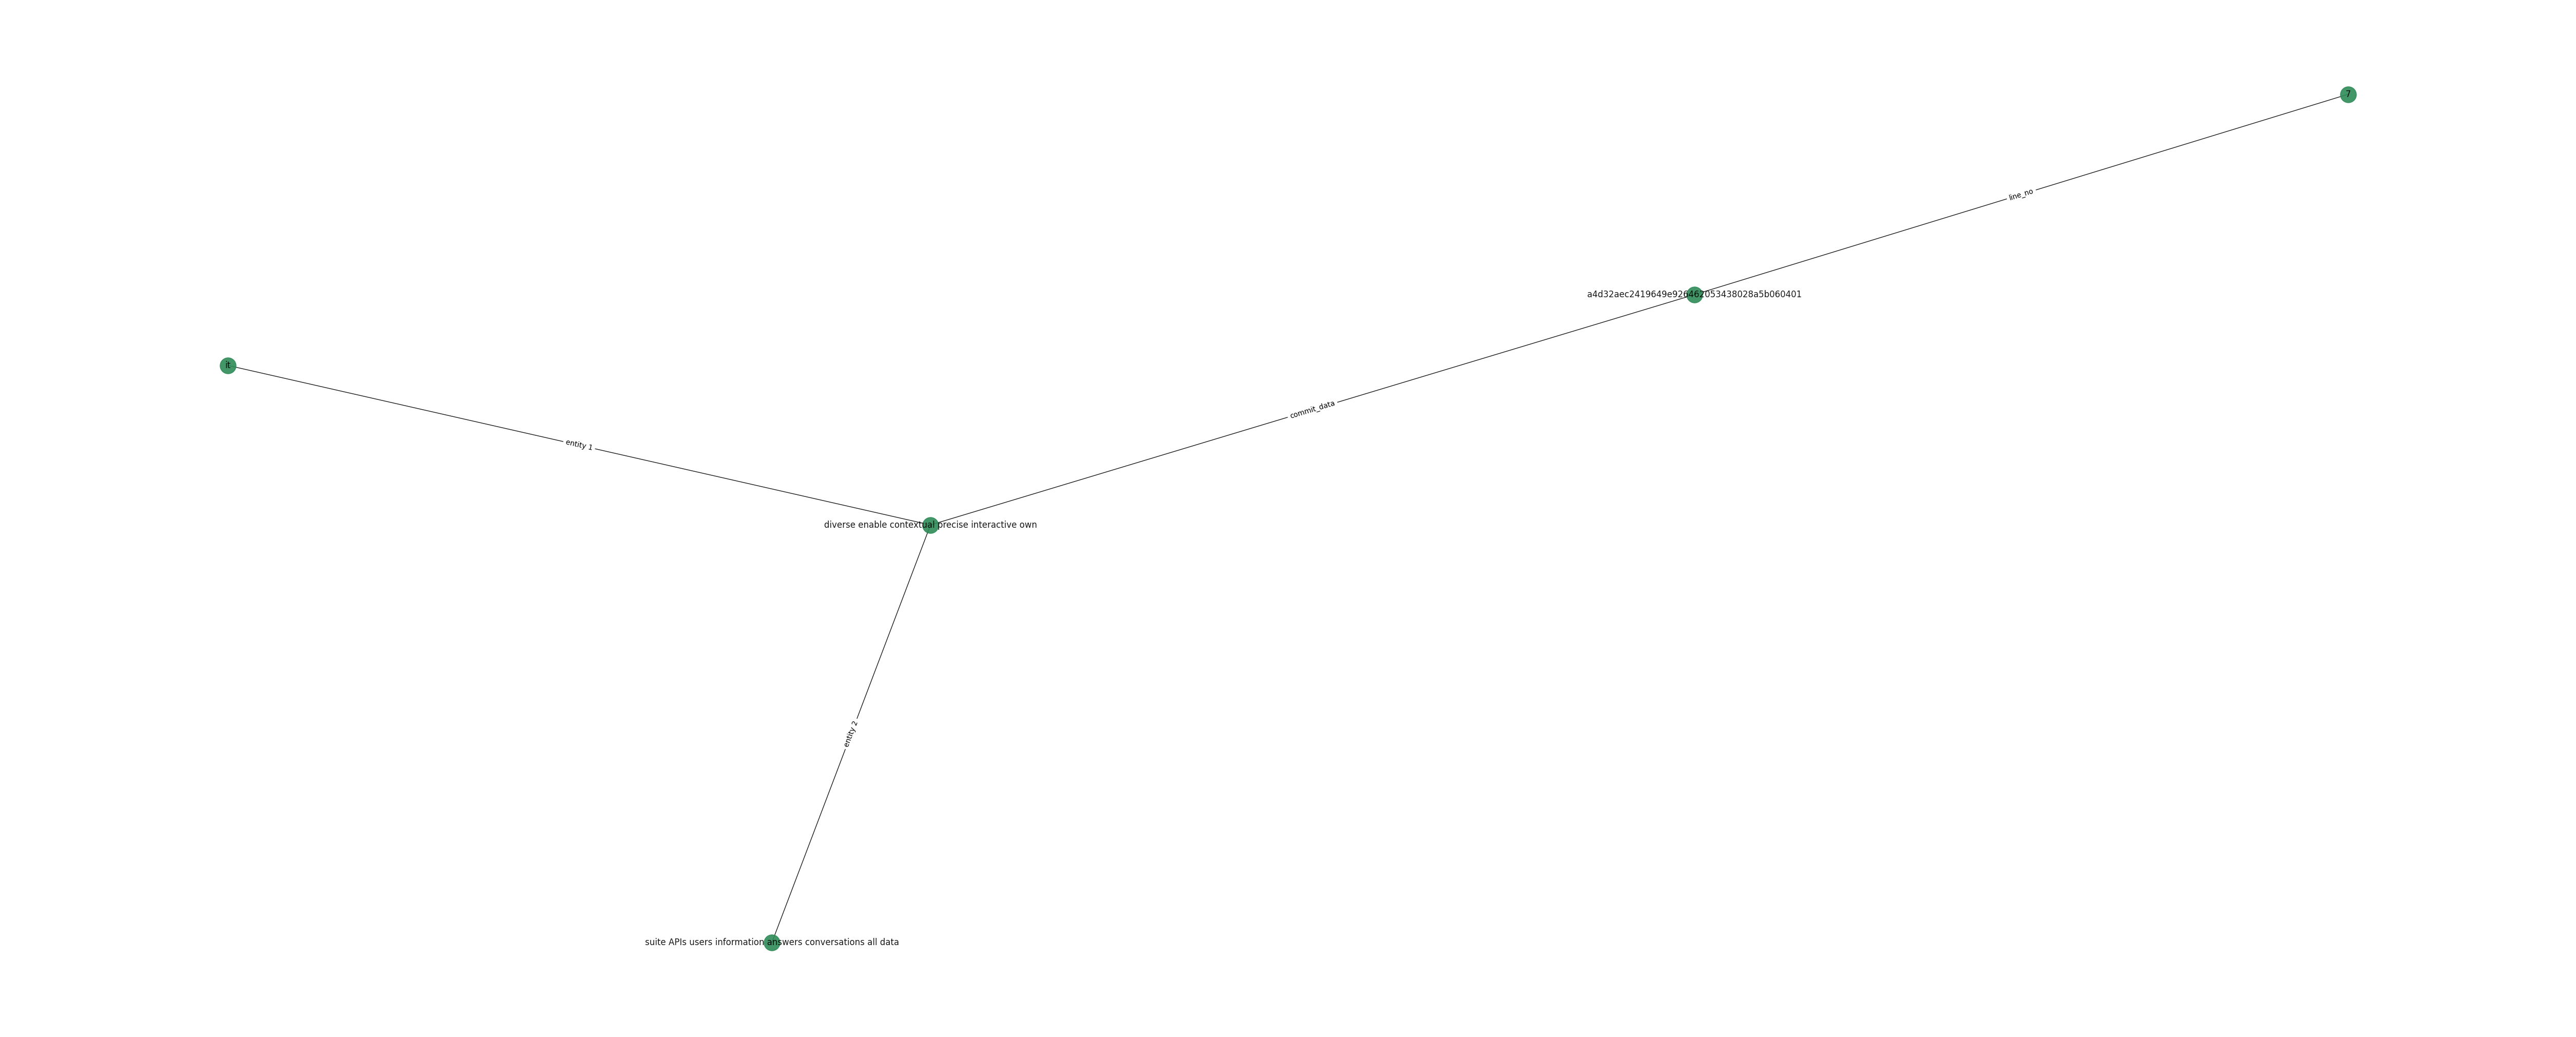

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a1b60>
{'segment manageable relevant optimize', 6, 'a4d32aec2419649e926462053438028a5b060401', 'It', 'data chunks embeddings them database retrieval'}


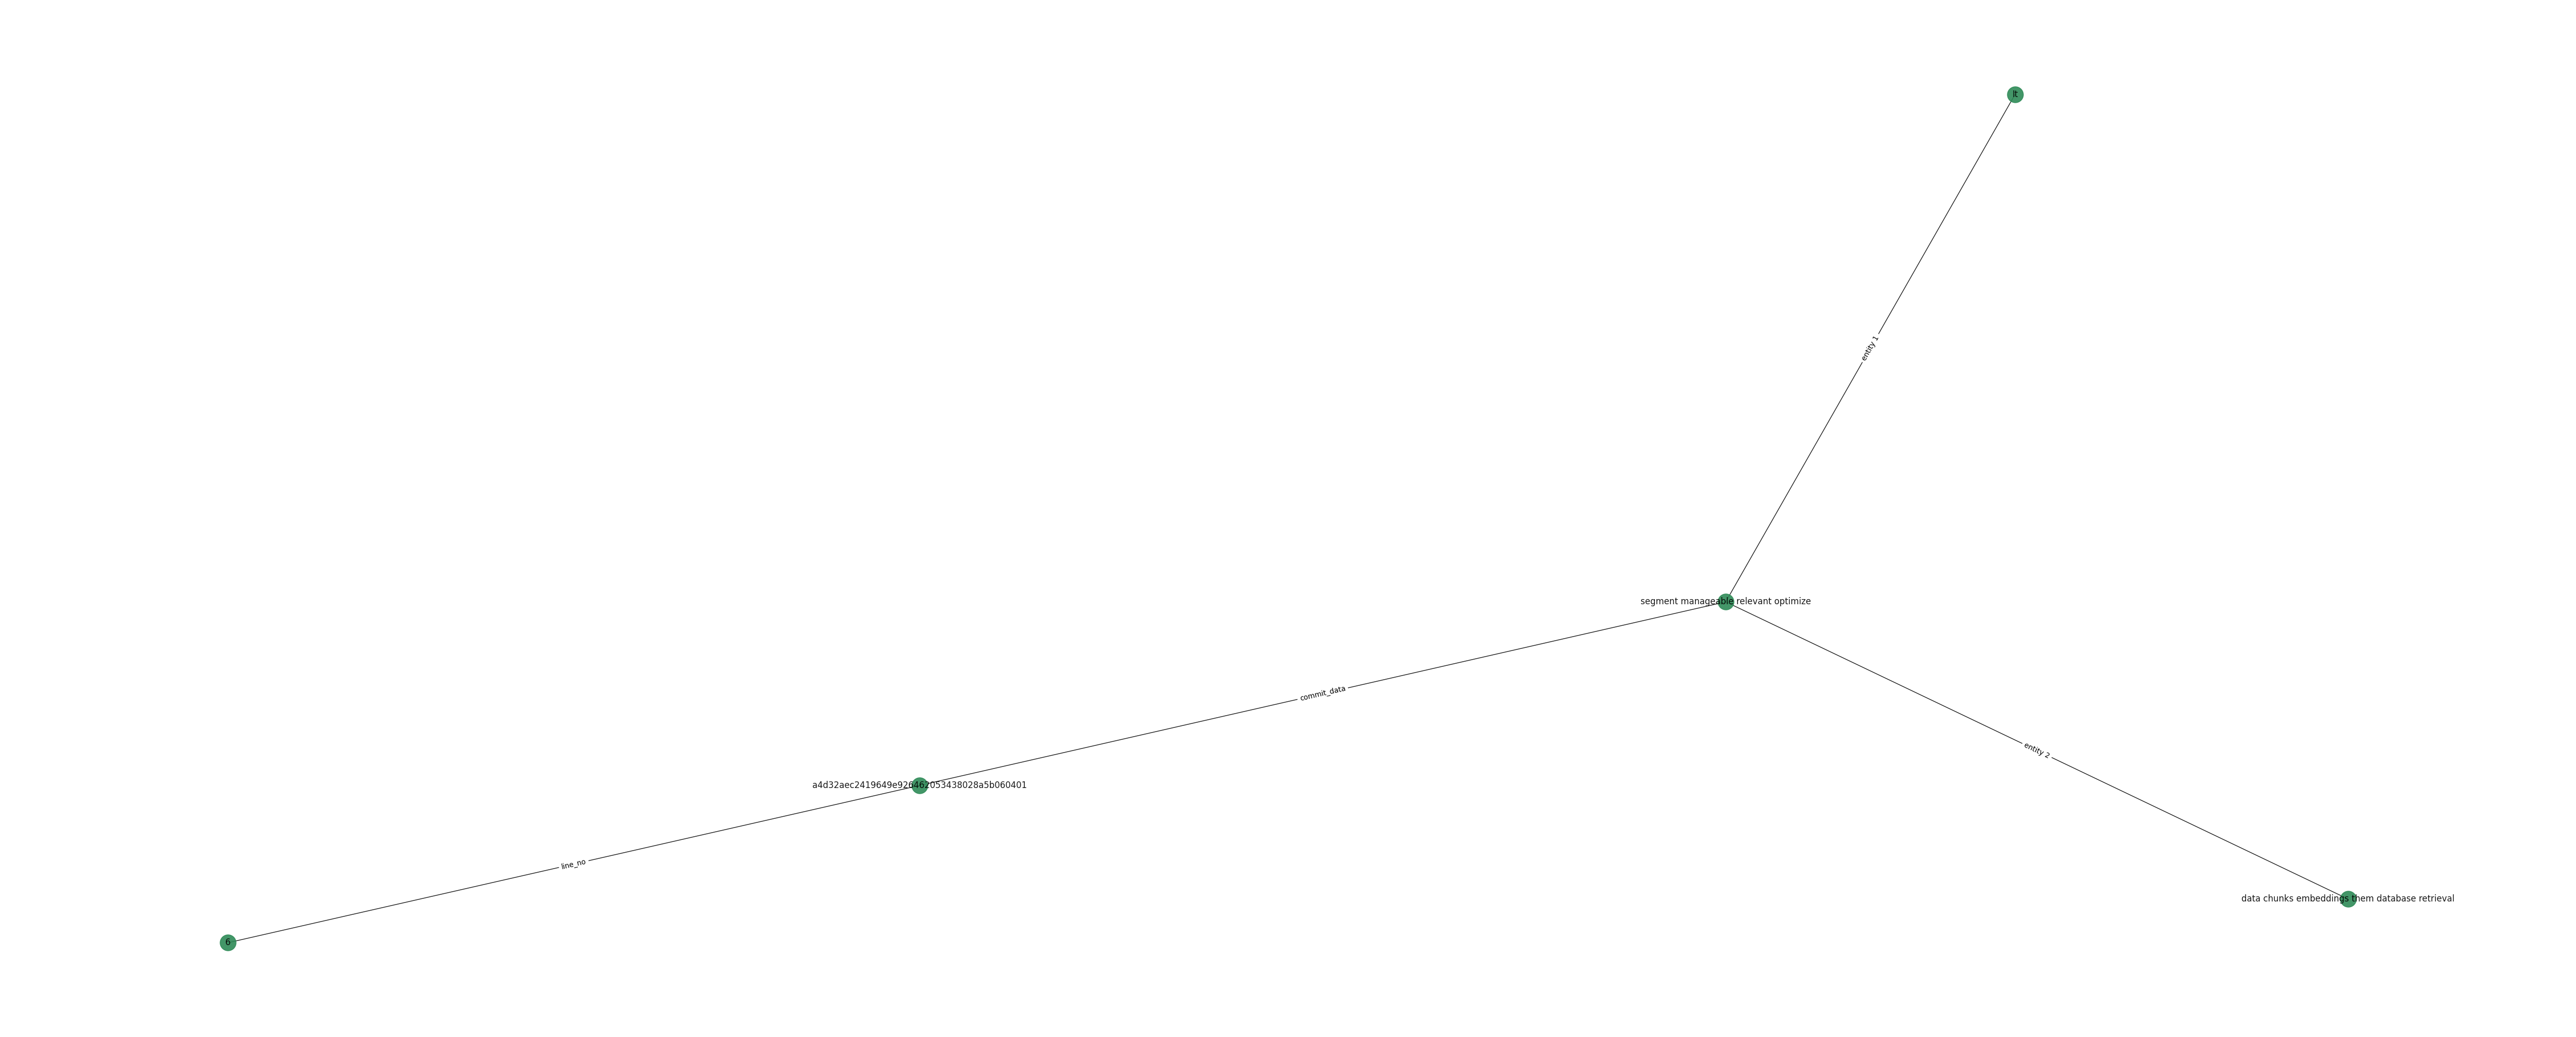

IAM MATCHED!!!
 

<generator object connected_components at 0x7bb9394a0900>
{7, 'a4d32aec2419649e926462053438028a5b060401', 'suite APIs users information answers conversations all data', 'it', 'diverse enable contextual precise interactive own'}


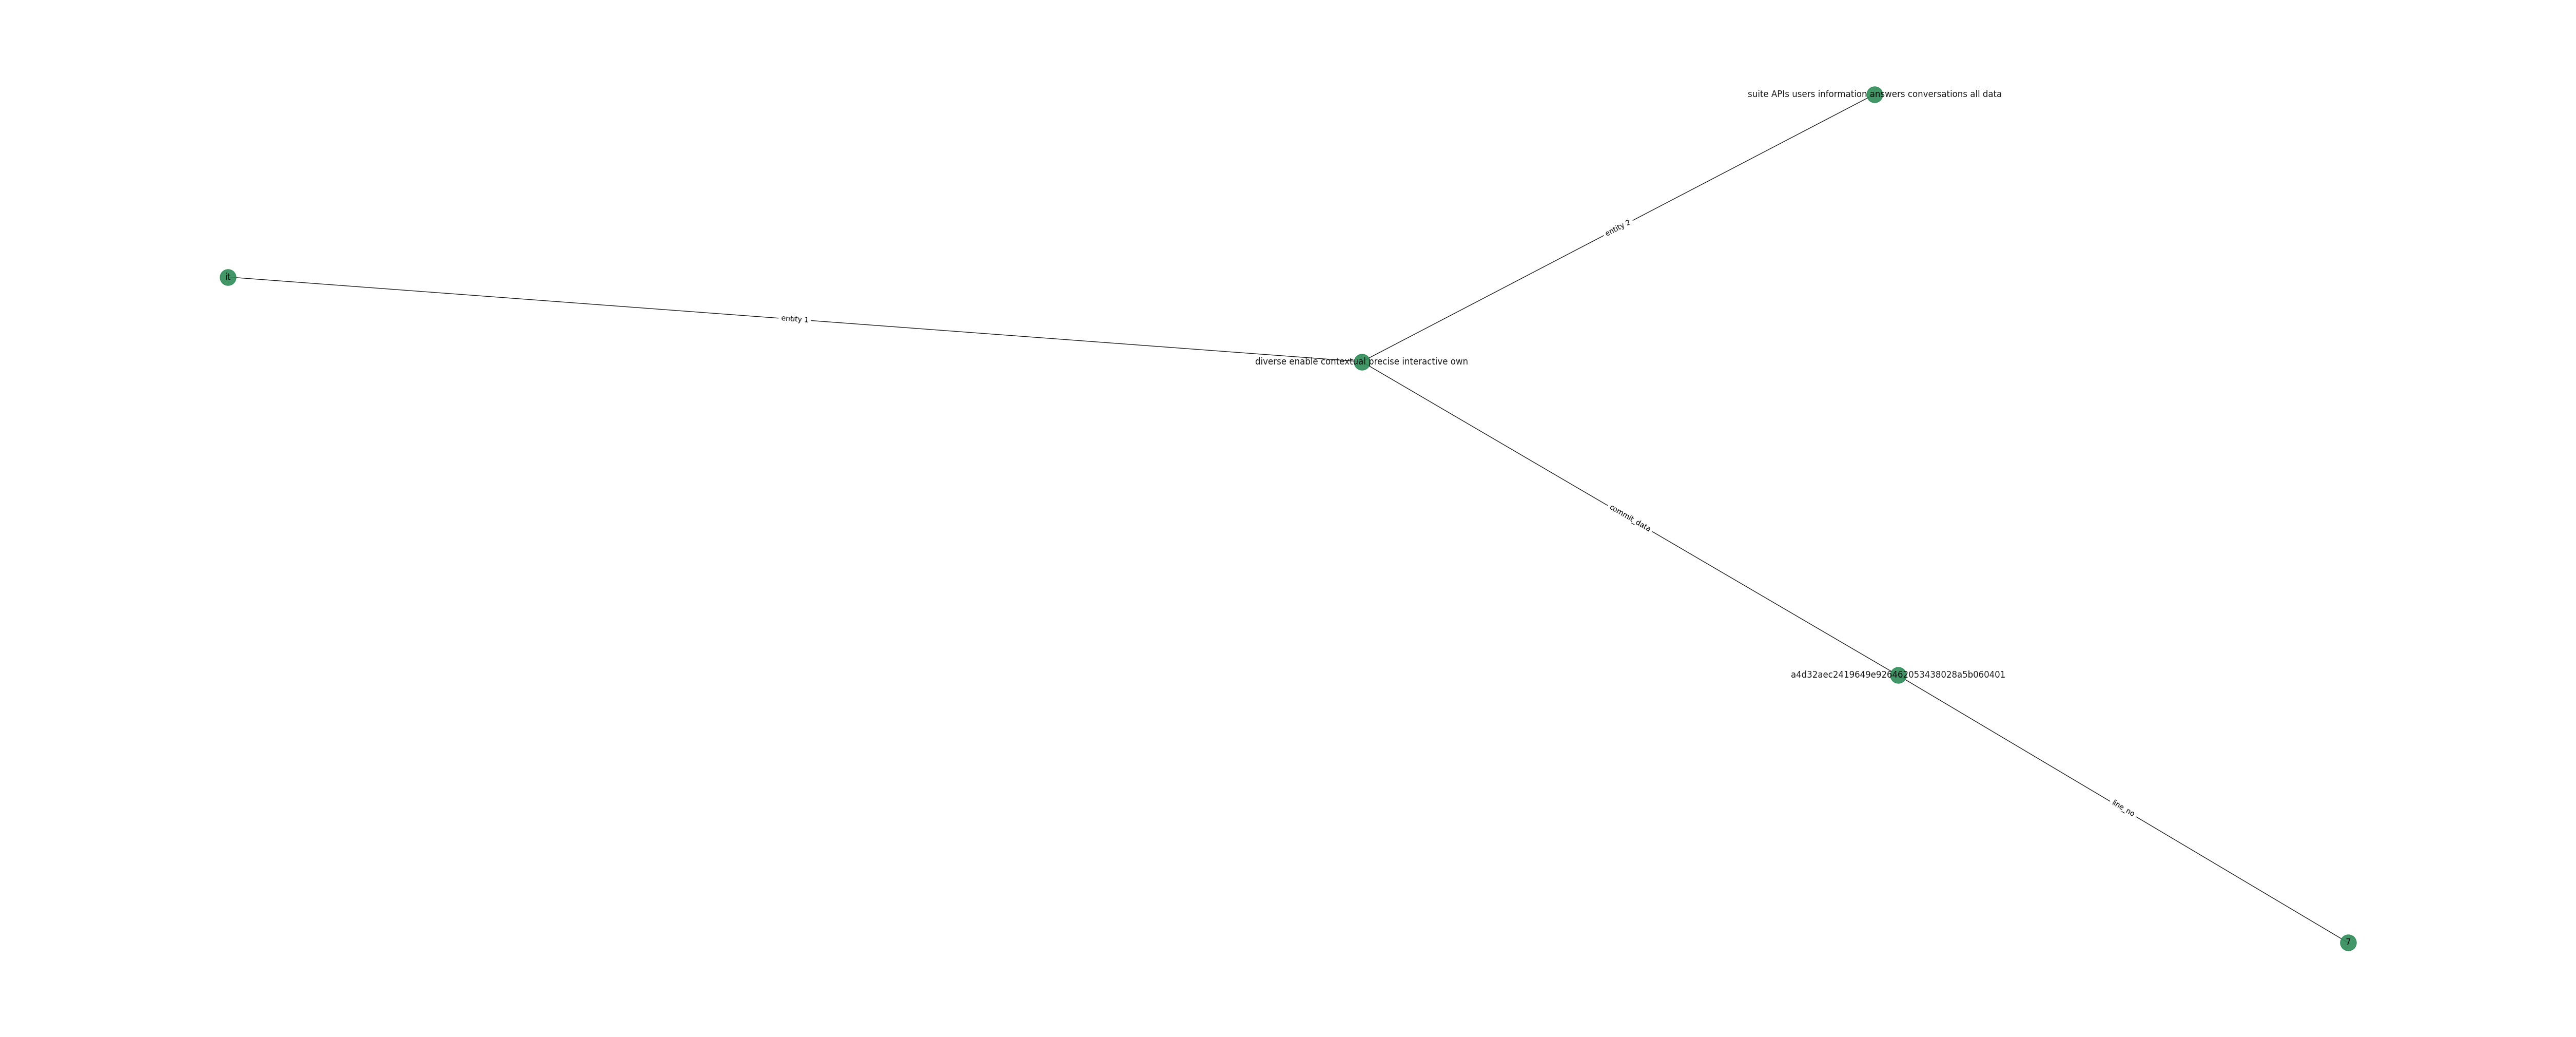

51


In [ ]:
  #readme commits
  import spacy
  from spacy.lang.en import English
  import networkx as nx
  import matplotlib.pyplot as plt
  from pydriller import Repository
  import re
  nlp_model = spacy.load('en_core_web_sm')
  def getSentences(text):
      nlp = English()
      nlp.add_pipe('sentencizer')
      document = nlp(text)
      return [sentence.text.strip() for sentence in document.sents]


  def printToken(token):
    # print(token.text, "->", token.dep_)
    pass

  def appendChunk(original, chunk):
      return original + ' ' + chunk

  def isRelationCandidate(token):
      deps = ["ROOT", "adj", "attr", "agent", "amod"]
      return any(subs in token.dep_ for subs in deps)

  def isConstructionCandidate(token):
      deps = ["compound", "prep", "conj", "mod"]
      return any(subs in token.dep_ for subs in deps)

  def processSubjectObjectPairs(tokens):
      subject = ''
      object = ''
      relation = ''
      subjectConstruction = ''
      objectConstruction = ''
      for token in tokens:
          printToken(token)
          if "punct" in token.dep_:
              continue
          if isRelationCandidate(token):
              relation = appendChunk(relation, token.lemma_)
          if isConstructionCandidate(token):
              if subjectConstruction:
                  subjectConstruction = appendChunk(subjectConstruction, token.text)
              if objectConstruction:
                  objectConstruction = appendChunk(objectConstruction, token.text)
          if "subj" in token.dep_:
              subject = appendChunk(subject, token.text)
              subject = appendChunk(subjectConstruction, subject)
              subjectConstruction = ''
          if "obj" in token.dep_:
              object = appendChunk(object, token.text)
              object = appendChunk(objectConstruction, object)
              objectConstruction = ''

      #print (subject.strip(), ",", relation.strip(), ",", object.strip())
      return (subject.strip(), relation.strip(), object.strip())

  def processSentence(sentence):
      tokens = nlp_model(sentence)
      return processSubjectObjectPairs(tokens)

  import os
  from pydriller import Repository

  def find_readme_file(directory):
      for root, dirs, files in os.walk(directory):
          for file in files:
              if file.lower() == 'readme.md':
                  return os.path.join(root, file)
      return None

  def get_commits(repo_path):
      readme_commits = []

      for commit in Repository(repo_path).traverse_commits():
        for modified_file in commit.modified_files:
            if modified_file.filename.lower() == 'readme.md':

                  commit_info = {
                      'title': commit.msg,
                      'patch': modified_file.diff,
                      'commit_id': commit.hash
                  }
                  readme_commits.append(commit_info)

      return readme_commits

  # Specify the path to the cloned repository
  repo_path = '/content/embedchain'


  def create_commit_dict(readme_commits):

      readme_commit_dict = {}
      count_read=1
      for commit in readme_commits:
        sentences=getSentences(commit['patch'])#assuming the patch has only content addition and no deletes
        for sentence in sentences:
          #readme_dict
              sentence = re.sub(r'@@\s*.*?\s*@@', '', sentence)
              sentence = sentence.replace('-', '')
              sentence = sentence.replace('+', '')
              sentence = sentence.replace('```', '')
              quadruple = []
              triples = []
              quadruple.append(commit['commit_id'])
              triples=list(processSentence(sentence))
              if (triples[0]+triples[1]+triples[2]) in readme_dict:
                quadruple.append(readme_dict[triples[0]+triples[1]+triples[2]])
                quadruple.append(triples)
                readme_commit_dict[count_read]=quadruple
                count_read=count_read+1
              #print(len(triples))
                print("IAM MATCHED!!!\n \n")
                printGraph(quadruple)
      print(count_read)
      return readme_commit_dict





  def diff_type(commit_diff):

      lines = commit_diff.split('\n')

      additions = sum(1 for line in lines if line.startswith('+') and not line.startswith('+++'))
      deletions = sum(1 for line in lines if line.startswith('-') and not line.startswith('---'))

      if additions > 0 and deletions == 0:
          return "Addition"
      elif deletions > 0 and additions == 0:
          return "Deletion"
      else:
          return "Mixed (Additions and Deletions)"


  def printGraph(quadruple):
      G = nx.Graph()

      G.add_node(quadruple[0])
      G.add_node(quadruple[1])
      G.add_node(quadruple[2][0])
      G.add_node(quadruple[2][1])
      G.add_node(quadruple[2][2])
      G.add_edge(quadruple[0], quadruple[1], label="line_no")
      G.add_edge(quadruple[0], quadruple[2][1], label="commit_data")
      G.add_edge(quadruple[2][0], quadruple[2][1], label="entity 1")
      G.add_edge(quadruple[2][1], quadruple[2][2], label="entity 2")

      components = nx.connected_components(G)
      print(components)
      for i in components:
        print(i)
      pos = nx.spring_layout(G)
      plt.figure(figsize=(50, 20))
      nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
              node_size=500, node_color='seagreen', alpha=0.9,
              labels={node: node for node in G.nodes()})

      edge_labels = {(edge[0], edge[1]): attr['label'] for edge, attr in G.edges.items()}
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

      plt.axis('off')
      plt.show()

  #
  if __name__ == "__main__":


      # Specify the path to the cloned repository
      repo_path = '/content/embedchain'

  # Retrieve the README file content and commit messages
      readme_commits = get_commits(repo_path)
      readme_commit_dict=create_commit_dict(readme_commits)
      #print(len(commit_dict))

  #useless
  #def retrieve_readme_and_commits(repo_path):
    # readme_content = None
      #commit_messages = []

      # Find the README file recursively within the repository directory
    # readme_path = find_readme_file(repo_path)
    # if readme_path:
        # with open(readme_path, 'r') as file:
            # readme_content = file.read()

    # return readme_content
    # quadruple.append(diff_type(commit['patch']))
    #print("commit['title']",processSentence(commit['title'])) quadruple.append(triples)
            # readme_commit_dict[count_read]=quadruple
              #count_read=count_read+1


ALL COMMITS KNOWLEDGE GRAPH(CODE+README)

Embedchain -> nsubj
is -> ROOT
an -> det
Open -> compound
Source -> compound
wireframe -> attr
for -> prep
personalizing -> pcomp
LLM -> compound
responses -> dobj
Embedchain , be wireframe , LLM  responses
<generator object connected_components at 0x7bb93d16ce40>
{'LLM  responses', 66789, 'addition', 'be wireframe', 'Embedchain'}


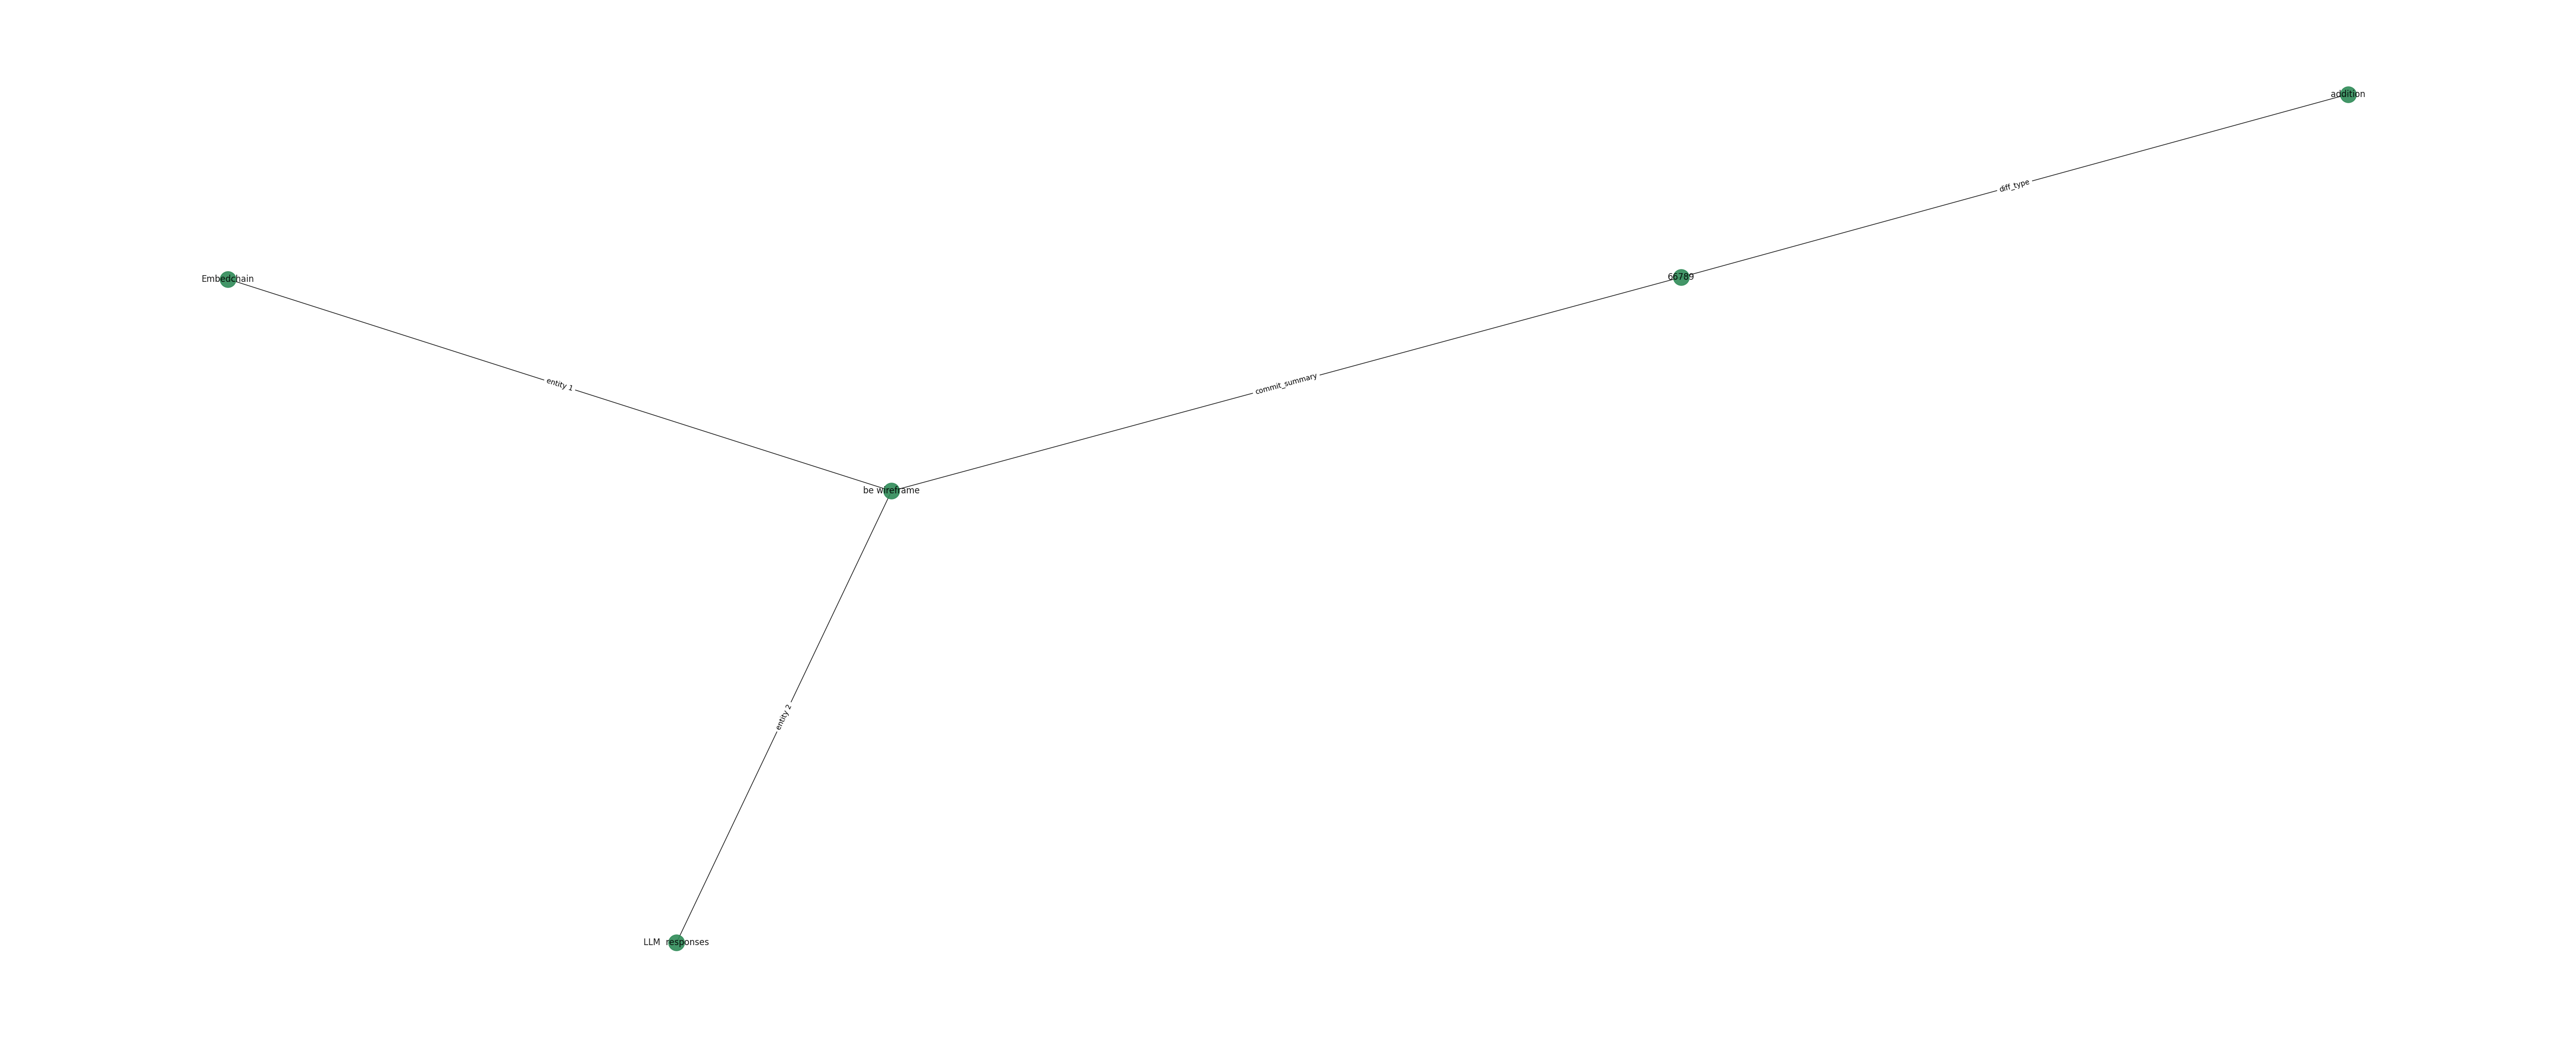

Embedchain
1


In [ ]:
#commits

import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
from pydriller import Repository
nlp_model = spacy.load('en_core_web_sm')
def getSentences(text):
    nlp = English()
    nlp.add_pipe('sentencizer')
    document = nlp(text)
    return [sentence.text.strip() for sentence in document.sents]


def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    c=0
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)

        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if ("compound" in token.dep_) and ("subj" in tokens[c+1].dep_ ):
                subject = appendChunk(token.text, subject)

        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''
        if ("compound" in token.dep_) and ("obj" in tokens[c+1].dep_ ):
                object = appendChunk(token.text, object)
        c=c+1

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

import os
from pydriller import Repository

def find_readme_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower() == 'readme.md':
                return os.path.join(root, file)
    return None

def retrieve_readme_and_commits(repo_path):
    readme_content = None
    commit_messages = []

    # Find the README file recursively within the repository directory
    readme_path = find_readme_file(repo_path)
    if readme_path:
        with open(readme_path, 'r') as file:
            readme_content = file.read()

    return readme_content

def create_commit_dict(readme_commits):

    commit_dict = {}
    count=0
    commit_summ="Embedchain is an Open Source wireframe for personalizing LLM responses"
    for commit in readme_commits:
            pentagons = []
            triples=[]
            pentagons.append(commit['commit_id'])
            #pentagons.append(diff_type(commit['patch']))#replace with patch summary
            pentagons.append("addition")
            triples=list(processSentence(commit_summ))

            pentagons.append(triples)
            commit_dict[count]=pentagons

            count=count+1

            printGraph(pentagons)
    return commit_dict

def get_commits(repo_path):
    code_commits = []

    #for commit in Repository(repo_path).traverse_commits():
     # for modified_file in commit.modified_files:
           #if modified_file.filename.lower() == 'readme.md':

    commit_info = {
                    'title': "Its trial",#commit.msg,
                    'patch': "hi",#modified_file.diff,
                    'commit_id': 66789 #commit.hash
                }
    code_commits.append(commit_info)

    return code_commits

# Specify the path to the cloned repository
repo_path = '/content/embedchain'



def diff_type(commit_diff):

    lines = commit_diff.split('\n')

    additions = sum(1 for line in lines if line.startswith('+') and not line.startswith('+++'))
    deletions = sum(1 for line in lines if line.startswith('-') and not line.startswith('---'))

    if additions > 0 and deletions == 0:
        return "Addition"
    elif deletions > 0 and additions == 0:
        return "Deletion"
    else:
        return "Mixed (Additions and Deletions)"


def printGraph(pentagons):
    G = nx.Graph()

    G.add_node(pentagons[0])
    G.add_node(pentagons[1])
    G.add_node(pentagons[2][0])
    G.add_node(pentagons[2][1])
    G.add_node(pentagons[2][2])
    G.add_edge(pentagons[0], pentagons[1], label="diff_type")
    G.add_edge(pentagons[0], pentagons[2][1], label="commit_summary")
    G.add_edge(pentagons[2][0], pentagons[2][1], label="entity 1")
    G.add_edge(pentagons[2][1], pentagons[2][2], label="entity 2")

    components = nx.connected_components(G)
    print(components)
    for i in components:
      print(i)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(50, 20))
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})

    edge_labels = {(edge[0], edge[1]): attr['label'] for edge, attr in G.edges.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.axis('off')
    plt.show()

#
if __name__ == "__main__":


    # Specify the path to the cloned repository
    repo_path = '/content/embedchain'

# Retrieve the README file content and commit messages
    code_commits = get_commits(repo_path)
    commit_dict=create_commit_dict(code_commits)
    print(commit_dict[0][2][0])
    print(len(commit_dict))

#useless
#'commit_id': commit.hash,
                    #'author': commit.author.name,
                    #'date': commit.author_date,
                    #'email': commit.author.email




FINDING SIMILARITY BETWEEN CODE COMMIT AND README COMMIT AND ACCORDINGLY UPDATE

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(text1, text2):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([text1, text2])
    cosine_sim = cosine_similarity(vectors[0:1], vectors[1:2])[0][0]
    return cosine_sim

def is_similar_enough(text1, text2, threshold):
    similarity = calculate_cosine_similarity(text1, text2)
    if similarity >= threshold:
        return True
    else:
        return False


text1=(commit_dict[0][2][0]+commit_dict[0][2][1]+commit_dict[0][2][2])
print(text1)
threshold = 0.1
for key, value in readme_dict.items():

  text2=key#(readme_dict[i][2][0]+readme_dict[i][2][1]+readme_dict[i][2][2])


  if is_similar_enough(text1,text2,threshold):
    print("text2",text2)
    print("The texts are similar enough hence update line .",readme_dict[key])
    c=1
    break
  else:
    c=0

if(c==0):
    print("The texts are not similar hence add this summary at ",len(readme_dict))
    t=len(readme_dict)
    triples = []
    triples=list(processSentence(text1))
    readme_dict[triples[0]+triples[1]+triples[2]]=t+1

Embedchainbe wireframeLLM  responses
text2 Embedchainbe FrameworkLLM  responses
The texts are similar enough hence update line . 2


EXPERIMENT CODE(JUST FOR DEBUGGING)

In [ ]:
from pydriller import Repository
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
from pydriller import Repository
import re
nlp_model = spacy.load('en_core_web_sm')
def get_commits_related_to_readme(repo_path):
    readme_commits = []

    # Iterate over all commits in the repository
    for commit in Repository(repo_path).traverse_commits():

        for modified_file in commit.modified_files:
           if modified_file.filename.lower() == 'readme.md':

                commit_info = {
                    'title': commit.msg,
                    'patch': modified_file.diff,
                    #'commit_id': commit.hash,
                    #'author': commit.author.name,
                    #'date': commit.author_date,
                    #'email': commit.author.email
                }
                readme_commits.append(commit_info)

    return readme_commits

# Specify the path to the cloned repository
repo_path = '/content/embedchain'

# Retrieve commits related to the README file
readme_commits = get_commits_related_to_readme(repo_path)
count=0
def getSentences(text):
    nlp = English()
    nlp.add_pipe('sentencizer')
    document = nlp(text)
    return [sentence.text.strip() for sentence in document.sents]

# Print commit information

for commit in readme_commits:
    print(count,"Title:", commit['title'])
    sentences=getSentences(commit['patch'])
   # print(sentences)
    for sentence in sentences:
      sentence = re.sub(r'@@\s*.*?\s*@@', '', sentence)
      sentence = sentence.replace('-', '')
      sentence = sentence.replace('+', '')
      sentence = sentence.replace('```', '')
      print(sentence)
    #print("Commit ID:", commit['commit_id'])
   # print("Author:", commit['author'])
   # print("Email:", commit['email'])
    #print("Date:", commit['date'])
   # print("Patch:\n", commit['patch'])
    #print("\n")
    count=count+1
print(count)

0 Title: Hello World

# embedchain
\ No newline at end of file
1 Title: Update Readme

Add what is it, how to use and install instructions

# embedchain
\ No newline at end of file
# embedchain

embedchain is a framework to easily create bots over any dataset.

* If you want to create a Naval Ravikant bot which has 1 youtube video, 1 book as pdf and 2 of his blog posts, all you need to do is add the links to the videos, pdf and blog posts and embedchain will create a bot for you.

python

from embedchain import App

app = app()

app.add("youtube_video", "https://www.youtube.com/watch?v=3qHkcs3kG44")
app.add("pdf_file", "https://navalmanack.s3.amazonaws.com/EricJorgenson_TheAlmanackofNavalRavikant_Final.pdf")
app.add("web_page", "https://nav.al/feedback")
app.add("web_page", "https://nav.al/agi")

app.query("How to do a startup?")


# How to use it?

## Installation

First make sure that you have the package installed.
If not, then install it using `pip`

bash
pip install embedchain


#